## Business problem 

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Given some information about users who have the mobile app listens to podcasts, identify prospects for a new podcasting app called "PodNN".The dataset includes some information about those users, including age, news and streaming subs, and income.
</font>


## Business objectives and constraints 

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4"> 1. No low-latency requirement. <br><br> 2. Interpretability is important. (We need to understand what are the factors which helps us determine if a user is a prospect. This will help in future)<br><br> 3. False negatives should be reduced as much as possible. (A real prospect customer identified by model as non-prospect customer can cost us)<br><br> 4. Probability of a data-point belonging to each class is needed. (so that there is an interpretibility to business. For eg: business can look deeper into users which have equal probability for two classes)
</font>


## Machine learning objective and constraints

**Objective:**

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Predict the probability of each data-point belonging to each of classes.
</font> <br><br>

    
**Constraints:**

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Interpretability. This means only those models which gives an understanding of which features are important can be used. Black box model such as RBF, SVM, Nueral network etc. cannot be used.  <br><br>
Class probabilities are needed. (Use of Caliberated classifier) <br><br>
Penalize the errors in class probabilites => Performance metric is Log-loss. <br><br>
No Latency constraints. Hence those models which has high train and run time complexity can also be used. <br><br>
</font>


## Summary of steps 

    
1. Data understanding/ exploration <br><br>

2. Data cleaning (Handling Missing values and outlier) <br><br>
3. Training the model to predict if a user is a prospect or not 
    3. a. Construct a baseline model as a yardstick of performance 
    3. b. Build 4 classification based ML models, hyperparameter tune the parameters and train each model with the best                   paramanters. Calcultate False neagtive rate and log loss for each model
    3. c. Choose the best performing model <br><br>
4. Finalise the business recommendation 
    

## Importing libraries 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
#from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Reading Data set

In [2]:
df=pd.read_excel('ds_practical.xlsx')#,sep='|')
df.head(2)

,anon_person_id,target,state,presence_of_child_ind,streaming_media_subs,streaming_entertainment_subs,marital_status,gender,income,number_of_news_subs,age
0,1,0,CA,0,N,0,M,Female,$175k-199k,0,43.0
1,2,0,CA,0,N,0,U,Male,$225k-249k,0,90.0


In [4]:
df.shape

(1000000, 11)

In [3]:
df.describe

<bound method NDFrame.describe of         anon_person_id  target state  presence_of_child_ind  \
0                    1       0    CA                      0   
1                    2       0    CA                      0   
2                    3       1    CA                      0   
3                    4       0    CA                      1   
4                    5       0    CA                      0   
...                ...     ...   ...                    ...   
999995             496       0    CA                      0   
999996             497       0    CA                      1   
999997             498       1    CA                      1   
999998             499       0    CA                      0   
999999             500       0    CA                      0   

       streaming_media_subs  streaming_entertainment_subs marital_status  \
0                         N                             0              M   
1                         N                             0

### What is the proporortion of users listening to podcasts?

Text(0, 0.5, 'Number of records')

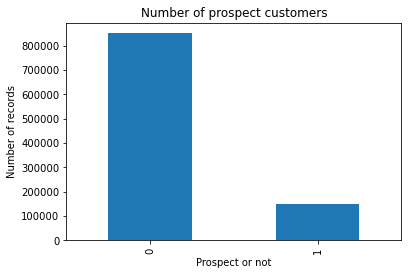

In [17]:
prospect=df['target'].value_counts()
p1 = prospect.plot(kind='bar', title='Number of prospect customers')#,x='Number of records')
p1.set_xlabel("Prospect or not")
p1.set_ylabel("Number of records")


<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
The dataset is highly imbalanced with 85:15 proportion
    </font>

In [19]:
print('~> Users who do not listen to podcast:\n   {}%'.format(100 - round(df['target'].mean()*100, 2)))
print('\n~> Users who listen to podcast:\n   {}%'.format(round(df['target'].mean()*100, 2)))

~> Users who do not listen to podcast:
   85.03%

~> Users who listen to podcast:
   14.97%


## Data Exploration 

### Subscription to services 

>### How many users has subscribed to streaming services?

Text(0, 0.5, 'Number of records')

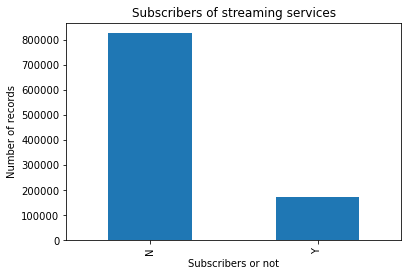

In [9]:
subs=df['streaming_media_subs'].value_counts()
p1 = subs.plot(kind='bar', title='Subscribers of streaming services')#,x='Number of records')
p1.set_xlabel("Subscribers or not")
p1.set_ylabel("Number of records")

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Only 17% has subscribed to the streaming services
</font>

>>### Out of users who has subscribed to streaming services, how many listen to podcast ?

<AxesSubplot:xlabel='streaming_media_subs', ylabel='Count'>

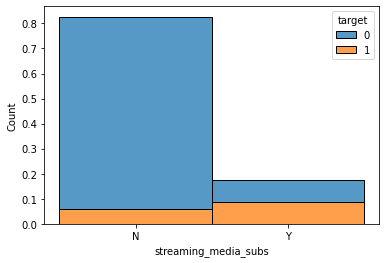

In [15]:
sns.histplot(x="streaming_media_subs", hue="target", data=df, stat="count", multiple="stack", weights=np.ones(len(df)) / len(df))


<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
50% of streaming media subscribers listens to podcasts.
Only 7% of non subscribes listens to podcasts. <br>
This is clear that whether a user has subscribed to media services is an indication of whether the user will listen to podcast or not    
</font>

>### How many users has subscribed to entertainment streaming services?

Text(0, 0.5, 'Number of records')

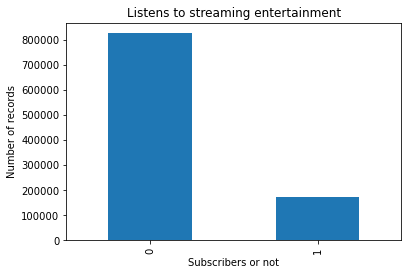

In [20]:
subs=df['streaming_entertainment_subs'].value_counts()
p1 = subs.plot(kind='bar', title='Listens to streaming entertainment')#,x='Number of records')
p1.set_xlabel("Subscribers or not")
p1.set_ylabel("Number of records")

<AxesSubplot:xlabel='streaming_entertainment_subs', ylabel='Count'>

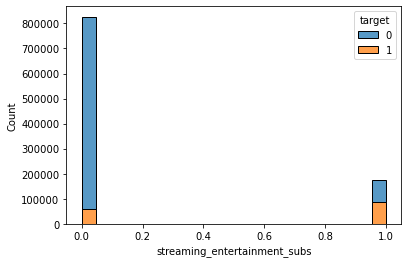

In [21]:
sns.histplot(x="streaming_entertainment_subs", hue="target", data=df, stat="count", multiple="stack")


<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Similar to media streaming services, 50% of streaming entertainment subscribers listens to podcasts.
Only 7% of non subscribes listens to podcasts. <br>
This is clear that whether a user has subscribed to entertainment services is an indication of whether the user will listen to podcast or not    
</font>

>### Number of news subscribtion by a prospect and a non prospect

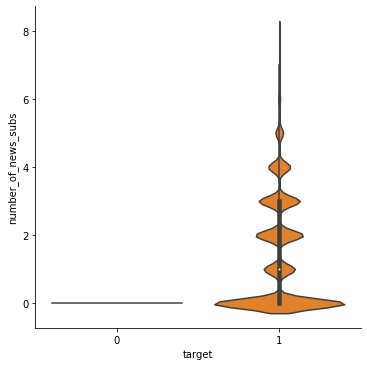

In [56]:
sns.catplot(data=df, kind="violin", x="target", y="number_of_news_subs", split=True)


<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
It is clear from this graph that a podcast listener has more news subscription when compared to non podcast listener.
</font>

### Demographic details  

>### Maritial status of users by whether they listen to podcast of not 

<AxesSubplot:xlabel='marital_status', ylabel='Count'>

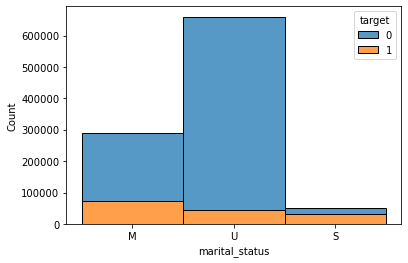

In [23]:
sns.histplot(x="marital_status", hue="target", data=df, stat="count", multiple="stack")

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Clearly an unmarried user has higher chance of listening to podcasts
</font>

>### Distribution of age 

In [28]:
df['age'].describe()

count    980298.000000
mean         46.851937
std          15.018724
min          19.000000
25%          40.000000
50%          45.000000
75%          51.000000
max          99.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Density'>

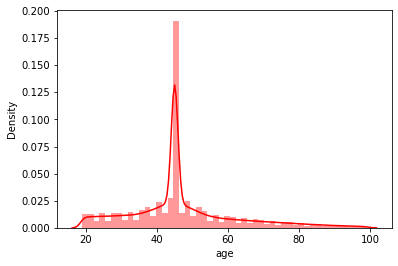

In [27]:
sns.distplot(df['age'],color = 'red')

Users are min 19 years old, on average 45 years old.

>>### Age distribution by podcast listeners

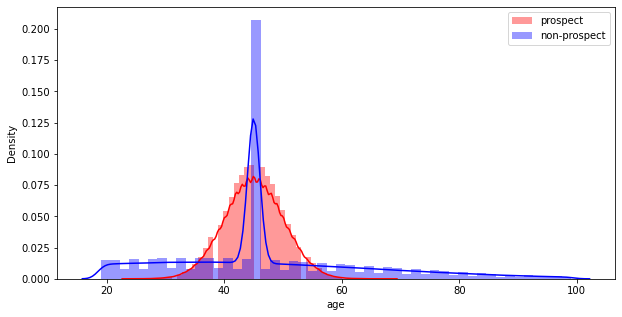

In [31]:
plt.figure(figsize=(10,5))
sns.distplot(df[df['target'] == 1]['age'][0:] , label = "prospect", color = 'red')
sns.distplot(df[df['target'] == 0]['age'][0:] , label = "non-prospect" , color = 'blue' )
plt.legend()
plt.show()

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Since the two distribution overlaps it can be understood that there is no difference in age between the two groups. However, podcast listners age range is wider than non prospect customers
</font>

>### How does having a child at home can affect whether they listen to podcast of not 

<AxesSubplot:xlabel='presence_of_child_ind', ylabel='Count'>

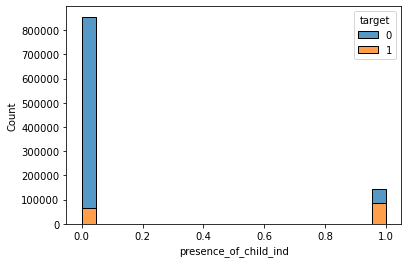

In [35]:
sns.histplot(x="presence_of_child_ind", hue="target", data=df, stat="count", multiple="stack")


<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Almost 60% of people who has child at home listens to podcast when compared to families with no children.
</font>

 >### Income details of users

[Text(0, 0, '$200k-224k'),
 Text(1, 0, '$175k-199k'),
 Text(2, 0, '$225k-249k'),
 Text(3, 0, '$150k-174k'),
 Text(4, 0, '$125k-149k'),
 Text(5, 0, '$250k+'),
 Text(6, 0, '$100k-124k'),
 Text(7, 0, 'U'),
 Text(8, 0, '$75k-99k'),
 Text(9, 0, '$50k-74k'),
 Text(10, 0, '$25k-49k'),
 Text(11, 0, '<$25k')]

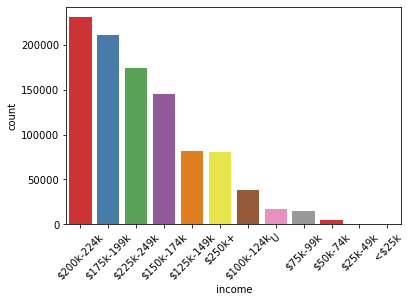

In [40]:
chart=sns.countplot(data=df,
    x='income',
   order = df['income'].value_counts().index,
    palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)


<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
This is a very granular level categories. This granular categories might later cause issues when modeling. So reducing the categories of this feature.
</font>

In [41]:
def income_categories(income):
    if income in ['$25k-49k','$50k-74k','$75k-99k']:
        return 'Less than 100k'
    if income in ['$100k-124k','$125k-149k','$150k-174k','$175k-199k']:
        return '$100k-200k'
    if income in ['$200k-224k','$225k-249k','$250k+']:
        return 'Greater than 200k'
    else:
        return 'Unknown'
df['income_categories']=df['income'].apply(lambda x:income_categories(x))

    

    

[Text(0, 0, 'Greater than 200k'),
 Text(1, 0, '$100k-200k'),
 Text(2, 0, 'Less than 100k'),
 Text(3, 0, 'Unknown')]

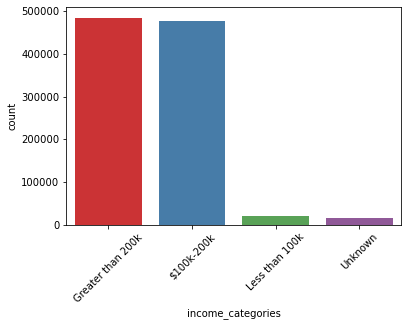

In [46]:
chart=sns.countplot(data=df,
    x='income_categories',
   order = df['income_categories'].value_counts().index,
    palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)


<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Majority of users have income of greater than 100k
</font>

>>### Income details of users by whether they are prospect of not

<AxesSubplot:xlabel='income_categories', ylabel='Count'>

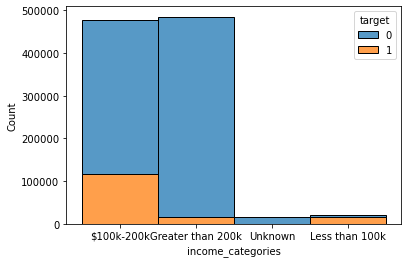

In [44]:
sns.histplot(x="income_categories", hue="target", data=df, stat="count", multiple="stack")
#chart.set_xticklabels(chart.get_xticklabels(), rotation=45)


<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
While income doesnt seem to have a great impact on whether a user listens to podcasts or not, it is evident that group with less than 100k income are mostly podcast listeners
</font>

> ### Gender of users 

In [49]:
df['gender'].value_counts()

Male       574615
Female     346159
feMalee     79226
Name: gender, dtype: int64

In [51]:
#Correcting the spelling mistake,
df['gender']=np.where((df['gender']=='feMalee'), "Female", df['gender'])

<AxesSubplot:xlabel='gender', ylabel='Count'>

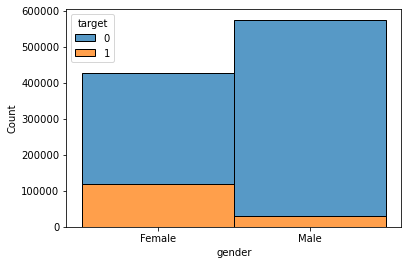

In [52]:
sns.histplot(x="gender", hue="target", data=df, stat="count", multiple="stack")


In [54]:
df[df['target']==1]['gender'].value_counts(normalize=True)

Female    0.798248
Male      0.201752
Name: gender, dtype: float64

### **To summarize initial findings :**

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
These are some characteristics of podcast listeners<br>1. They will have a number of news subscription <br>2. 80% of them are female <br>3. ~75% of them have income around 100k-200k<br>4. They have subsciption to streaming services as well, (only 60%)
</font>

## 2. Data cleaning  

>### Missing values

In [72]:
df[df.isna().any(axis=1)]

,anon_person_id,target,state,presence_of_child_ind,streaming_media_subs,streaming_entertainment_subs,marital_status,gender,income,number_of_news_subs,age,income_categories
399,400,1,CA,0,Y,1,U,Male,$200k-224k,0,NaN,Greater than 200k
400,401,0,CA,0,N,0,U,Female,U,0,NaN,Unknown
401,402,0,CA,0,N,0,U,Male,$200k-224k,0,NaN,Greater than 200k
402,403,0,CA,0,N,0,M,Male,$200k-224k,0,NaN,Greater than 200k
403,404,1,CA,0,Y,1,M,Female,$175k-199k,0,NaN,$100k-200k
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,496,0,CA,0,N,0,M,Female,$175k-199k,0,NaN,$100k-200k
999996,497,0,CA,1,N,0,U,Female,$125k-149k,0,NaN,$100k-200k
999997,498,1,CA,1,Y,1,S,Female,$100k-124k,1,NaN,$100k-200k
999998,499,0,CA,0,N,0,U,Female,$225k-249k,0,NaN,Greater than 200k


Almost 3% of the users do not have information about age

Imputing these blank values with the average of age of users in the same gender who has same income level

In [74]:
df["age"] = df.groupby(["income","gender"]).transform(lambda x: x.fillna(x.mean()))

>### Correcting spelling mistake

In the gender column, female was misspelled and it has been corrected 

In [75]:
df['gender']=np.where((df['gender']=='feMalee'), "Female", df['gender'])

>### Reduce the number of categories 

In [221]:
def income_categories(income):
    if income in ['$25k-49k','$50k-74k','$75k-99k']:
        return 'Less than 100k'
    if income in ['$100k-124k','$125k-149k','$150k-174k','$175k-199k']:
        return '$100k-200k'
    if income in ['$200k-224k','$225k-249k','$250k+']:
        return 'Greater than 200k'
    else:
        return 'Unknown'
df['income_categories']=df['income'].apply(lambda x:income_categories(x))

    

    

#### Converting target, presence_of_child_ind, streaming_entertainment_subs to categorical variables 

In [83]:
for col in ['target','presence_of_child_ind','streaming_entertainment_subs']:
    df[col] = df[col].astype('category',copy=False)



## 3. Data Modeling 

>### Train Test validation split

#### Splitting data into train, test and cross validation (64:20:16)


In [84]:
y = df['target'].values
X = df.drop(['target','anon_person_id','state','presence_of_child_ind','income'], axis=1)
X.head(1)

,streaming_media_subs,streaming_entertainment_subs,marital_status,gender,number_of_news_subs,age,income_categories
0,N,0,M,Female,0,1.0,$100k-200k


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=0)

In [86]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (670000, 7)
Number of data points in test data : (330000, 7)


Train and test should have equal distribution of y

In [87]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.8502567164179105 Class 1:  0.14974328358208955
---------- Distribution of output variable in test data ----------
Class 0:  0.14974242424242423 Class 1:  0.14974242424242423


>### Encoding categorical variables 

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Income_categories is an ordinal category. Hence ordinal encoding this feature:
    </font>

In [88]:
from sklearn.preprocessing import OrdinalEncoder
income=['Unknown','Less than 100k','$100k-200k','Greater than 200k']
ordi=OrdinalEncoder(categories=[income])
X_train["income"] = ordi.fit_transform(X_train[["income_categories"]])
X_test["income"] = ordi.transform(X_test[["income_categories"]])


In [95]:
X_train.head(2)

,streaming_media_subs,streaming_entertainment_subs,marital_status,gender,number_of_news_subs,age,income_categories,income
629541,0,0,0,0,0,629542.0,$100k-200k,2.0
982254,1,1,2,0,0,982255.0,Greater than 200k,3.0


<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Label encoding other categorical variables such as streaming_media_subs,marital_status and gender
</font>

In [94]:
from sklearn.preprocessing import LabelEncoder
labelencode=LabelEncoder()
for col in ['marital_status','gender']:#,'streaming_media_subs']:
    X_train[col] = labelencode.fit_transform(X_train[[col]])
    X_test[col] = labelencode.transform(X_test[[col]])

>### Defining some commonly used function 

#### 1. Function to calculate confusion matrix, precision matrix and recall matrix

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
Since the data is highly imbalanced, its important to see how the model is performing with the less dominant class. Confusion matrix is helpful for this. <br>
Also, confusion matrix, precision matrix and recall matrix will give an idea about false negatives of the model
</font>

In [97]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    Recall =(((C.T)/(C.sum(axis=1))).T)
    
    Precision =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(Precision, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(Recall, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

#### Function to plot feature importance.  

In [125]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

>### Building a baseline model 

<span style='font-family:"Times New Roman"'> <span styel=''> <font size="4">
This model is used as an base model of which predictions are completely random. Calculating log loss for this model will give a baseline for performance measurement of various models.
    </font>

Log loss on Test Data using Random Model 0.8864292604739396


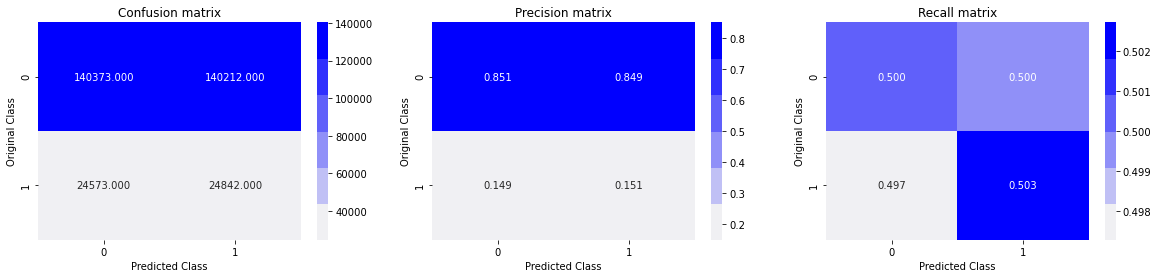

0.88 is baseline log loss

In [104]:
X_train.drop(['income_categories'],axis=1,inplace=True)
X_test.drop(['income_categories'],axis=1,inplace=True)

> ### K Nearest Neighbour

for alpha = 5
For values of alpha =  5 The log loss is: 0.4214777239371011
for alpha = 11
For values of alpha =  11 The log loss is: 0.42218176144377645
for alpha = 15
For values of alpha =  15 The log loss is: 0.4222304729660532
for alpha = 21
For values of alpha =  21 The log loss is: 0.42224906669813594
for alpha = 31
For values of alpha =  31 The log loss is: 0.42225376624088506
for alpha = 41
For values of alpha =  41 The log loss is: 0.422262234197562
for alpha = 51
For values of alpha =  51 The log loss is: 0.4222668445608106
for alpha = 99
For values of alpha =  99 The log loss is: 0.4222638053010066


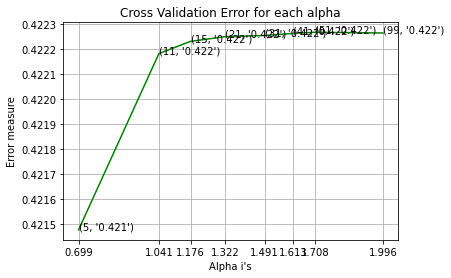

For values of best alpha =  5 The train log loss is: 0.40837360611201884
For values of best alpha =  5 The test log loss is: 0.4214777239371011
Total number of data points : 330000


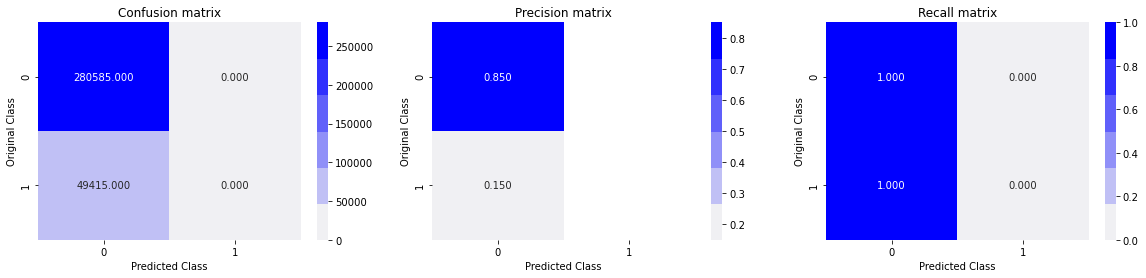

In [109]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    #print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
   # print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


fig, ax = plt.subplots()
ax.plot(np.log10(alpha), log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


> ### Logistic Regression 



#### With class balancing 

for alpha = 0.001
-- Epoch 1
Norm: 451.97, NNZs: 7, Bias: 15.253546, T: 670000, Avg. loss: 2975298428.885682
Total training time: 0.23 seconds.
-- Epoch 2
Norm: 457.54, NNZs: 7, Bias: 15.790047, T: 1340000, Avg. loss: 252429396.792600
Total training time: 0.48 seconds.
-- Epoch 3
Norm: 450.84, NNZs: 7, Bias: 16.230143, T: 2010000, Avg. loss: 147070510.515302
Total training time: 0.70 seconds.
-- Epoch 4
Norm: 479.42, NNZs: 7, Bias: 16.376147, T: 2680000, Avg. loss: 104660633.850430
Total training time: 0.92 seconds.
-- Epoch 5
Norm: 483.12, NNZs: 7, Bias: 16.681248, T: 3350000, Avg. loss: 80924503.011754
Total training time: 1.15 seconds.
-- Epoch 6
Norm: 478.90, NNZs: 7, Bias: 16.728294, T: 4020000, Avg. loss: 66273407.907927
Total training time: 1.38 seconds.
-- Epoch 7
Norm: 450.38, NNZs: 7, Bias: 16.757938, T: 4690000, Avg. loss: 56203152.166404
Total training time: 1.60 seconds.
-- Epoch 8
Norm: 451.22, NNZs: 7, Bias: 16.868166, T: 5360000, Avg. loss: 48337599.130311
Total trainin

Norm: 452.87, NNZs: 7, Bias: 18.810053, T: 44220000, Avg. loss: 5525230.549047
Total training time: 15.42 seconds.
-- Epoch 67
Norm: 453.76, NNZs: 7, Bias: 18.816665, T: 44890000, Avg. loss: 5466133.577603
Total training time: 15.64 seconds.
-- Epoch 68
Norm: 454.63, NNZs: 7, Bias: 18.828749, T: 45560000, Avg. loss: 5369860.697498
Total training time: 15.91 seconds.
-- Epoch 69
Norm: 450.09, NNZs: 7, Bias: 18.837672, T: 46230000, Avg. loss: 5304610.154833
Total training time: 16.16 seconds.
-- Epoch 70
Norm: 450.06, NNZs: 7, Bias: 18.844065, T: 46900000, Avg. loss: 5221436.337043
Total training time: 16.42 seconds.
-- Epoch 71
Norm: 451.58, NNZs: 7, Bias: 18.859493, T: 47570000, Avg. loss: 5123909.459488
Total training time: 16.64 seconds.
-- Epoch 72
Norm: 450.12, NNZs: 7, Bias: 18.878585, T: 48240000, Avg. loss: 5060393.238188
Total training time: 16.86 seconds.
-- Epoch 73
Norm: 450.07, NNZs: 7, Bias: 18.887757, T: 48910000, Avg. loss: 4991336.201287
Total training time: 17.11 secon

Norm: 449.93, NNZs: 7, Bias: 19.344223, T: 87770000, Avg. loss: 2770482.072646
Total training time: 30.83 seconds.
-- Epoch 132
Norm: 450.05, NNZs: 7, Bias: 19.346734, T: 88440000, Avg. loss: 2761624.222721
Total training time: 31.09 seconds.
-- Epoch 133
Norm: 450.07, NNZs: 7, Bias: 19.354786, T: 89110000, Avg. loss: 2733657.787434
Total training time: 31.41 seconds.
-- Epoch 134
Norm: 450.27, NNZs: 7, Bias: 19.356550, T: 89780000, Avg. loss: 2730344.902796
Total training time: 31.64 seconds.
-- Epoch 135
Norm: 449.94, NNZs: 7, Bias: 19.367889, T: 90450000, Avg. loss: 2689424.973324
Total training time: 31.87 seconds.
-- Epoch 136
Norm: 449.91, NNZs: 7, Bias: 19.373774, T: 91120000, Avg. loss: 2668827.208634
Total training time: 32.08 seconds.
-- Epoch 137
Norm: 449.89, NNZs: 7, Bias: 19.385220, T: 91790000, Avg. loss: 2648913.319734
Total training time: 32.30 seconds.
-- Epoch 138
Norm: 449.88, NNZs: 7, Bias: 19.390569, T: 92460000, Avg. loss: 2630089.338784
Total training time: 32.5

-- Epoch 196
Norm: 449.62, NNZs: 7, Bias: 19.674961, T: 131320000, Avg. loss: 1852768.076534
Total training time: 45.19 seconds.
-- Epoch 197
Norm: 449.62, NNZs: 7, Bias: 19.675739, T: 131990000, Avg. loss: 1849887.094117
Total training time: 45.41 seconds.
-- Epoch 198
Norm: 449.61, NNZs: 7, Bias: 19.677347, T: 132660000, Avg. loss: 1835707.288838
Total training time: 45.65 seconds.
-- Epoch 199
Norm: 449.60, NNZs: 7, Bias: 19.684615, T: 133330000, Avg. loss: 1822059.163218
Total training time: 45.89 seconds.
-- Epoch 200
Norm: 449.64, NNZs: 7, Bias: 19.687846, T: 134000000, Avg. loss: 1813470.058242
Total training time: 46.12 seconds.
-- Epoch 201
Norm: 449.59, NNZs: 7, Bias: 19.688791, T: 134670000, Avg. loss: 1807299.864157
Total training time: 46.40 seconds.
-- Epoch 202
Norm: 449.58, NNZs: 7, Bias: 19.691869, T: 135340000, Avg. loss: 1800529.199882
Total training time: 46.66 seconds.
-- Epoch 203
Norm: 449.58, NNZs: 7, Bias: 19.695569, T: 136010000, Avg. loss: 1787684.911327
Tota

Norm: 449.73, NNZs: 7, Bias: 19.888583, T: 174200000, Avg. loss: 1395178.590510
Total training time: 60.81 seconds.
-- Epoch 261
Norm: 449.41, NNZs: 7, Bias: 19.889750, T: 174870000, Avg. loss: 1391335.360662
Total training time: 61.03 seconds.
-- Epoch 262
Norm: 449.52, NNZs: 7, Bias: 19.894947, T: 175540000, Avg. loss: 1386267.954291
Total training time: 61.25 seconds.
-- Epoch 263
Norm: 449.41, NNZs: 7, Bias: 19.899616, T: 176210000, Avg. loss: 1374914.474964
Total training time: 61.47 seconds.
-- Epoch 264
Norm: 449.43, NNZs: 7, Bias: 19.904253, T: 176880000, Avg. loss: 1373667.334376
Total training time: 61.69 seconds.
-- Epoch 265
Norm: 449.41, NNZs: 7, Bias: 19.905644, T: 177550000, Avg. loss: 1367028.528312
Total training time: 61.91 seconds.
-- Epoch 266
Norm: 449.40, NNZs: 7, Bias: 19.910539, T: 178220000, Avg. loss: 1362352.387391
Total training time: 62.13 seconds.
-- Epoch 267
Norm: 449.41, NNZs: 7, Bias: 19.920037, T: 178890000, Avg. loss: 1348105.857846
Total training ti

Norm: 449.17, NNZs: 7, Bias: 20.061541, T: 217080000, Avg. loss: 1120073.878973
Total training time: 74.82 seconds.
-- Epoch 325
Norm: 449.20, NNZs: 7, Bias: 20.062106, T: 217750000, Avg. loss: 1116627.685934
Total training time: 75.04 seconds.
-- Epoch 326
Norm: 449.17, NNZs: 7, Bias: 20.065727, T: 218420000, Avg. loss: 1112111.001527
Total training time: 75.26 seconds.
-- Epoch 327
Norm: 449.17, NNZs: 7, Bias: 20.066539, T: 219090000, Avg. loss: 1111596.115649
Total training time: 75.48 seconds.
-- Epoch 328
Norm: 449.19, NNZs: 7, Bias: 20.067737, T: 219760000, Avg. loss: 1109550.299466
Total training time: 75.71 seconds.
-- Epoch 329
Norm: 449.17, NNZs: 7, Bias: 20.070060, T: 220430000, Avg. loss: 1102076.251884
Total training time: 75.94 seconds.
-- Epoch 330
Norm: 449.16, NNZs: 7, Bias: 20.072045, T: 221100000, Avg. loss: 1097222.617920
Total training time: 76.18 seconds.
-- Epoch 331
Norm: 449.16, NNZs: 7, Bias: 20.072989, T: 221770000, Avg. loss: 1097898.522058
Total training ti

Norm: 448.99, NNZs: 7, Bias: 20.179719, T: 259960000, Avg. loss: 929182.364713
Total training time: 89.08 seconds.
-- Epoch 389
Norm: 448.99, NNZs: 7, Bias: 20.183613, T: 260630000, Avg. loss: 930808.422535
Total training time: 89.30 seconds.
-- Epoch 390
Norm: 449.09, NNZs: 7, Bias: 20.184506, T: 261300000, Avg. loss: 929286.287606
Total training time: 89.52 seconds.
-- Epoch 391
Norm: 448.98, NNZs: 7, Bias: 20.185874, T: 261970000, Avg. loss: 927135.666060
Total training time: 89.74 seconds.
-- Epoch 392
Norm: 449.06, NNZs: 7, Bias: 20.186720, T: 262640000, Avg. loss: 926119.969702
Total training time: 89.96 seconds.
-- Epoch 393
Norm: 448.98, NNZs: 7, Bias: 20.190387, T: 263310000, Avg. loss: 917971.505753
Total training time: 90.17 seconds.
-- Epoch 394
Norm: 448.98, NNZs: 7, Bias: 20.192139, T: 263980000, Avg. loss: 919178.654683
Total training time: 90.39 seconds.
-- Epoch 395
Norm: 449.06, NNZs: 7, Bias: 20.191176, T: 264650000, Avg. loss: 918565.577480
Total training time: 90.6

Norm: 448.91, NNZs: 7, Bias: 20.287673, T: 302840000, Avg. loss: 801861.666554
Total training time: 103.97 seconds.
-- Epoch 453
Norm: 448.86, NNZs: 7, Bias: 20.288394, T: 303510000, Avg. loss: 799048.157977
Total training time: 104.16 seconds.
-- Epoch 454
Norm: 448.86, NNZs: 7, Bias: 20.290713, T: 304180000, Avg. loss: 796049.009240
Total training time: 104.39 seconds.
-- Epoch 455
Norm: 448.86, NNZs: 7, Bias: 20.293118, T: 304850000, Avg. loss: 795291.311206
Total training time: 104.61 seconds.
-- Epoch 456
Norm: 448.86, NNZs: 7, Bias: 20.293642, T: 305520000, Avg. loss: 796276.784397
Total training time: 104.85 seconds.
-- Epoch 457
Norm: 448.88, NNZs: 7, Bias: 20.295770, T: 306190000, Avg. loss: 792371.306722
Total training time: 105.05 seconds.
-- Epoch 458
Norm: 448.85, NNZs: 7, Bias: 20.297527, T: 306860000, Avg. loss: 788908.312883
Total training time: 105.24 seconds.
-- Epoch 459
Norm: 448.85, NNZs: 7, Bias: 20.299258, T: 307530000, Avg. loss: 787893.737204
Total training tim

Norm: 448.70, NNZs: 7, Bias: 20.394762, T: 346390000, Avg. loss: 701112.316056
Total training time: 119.29 seconds.
-- Epoch 518
Norm: 448.69, NNZs: 7, Bias: 20.396474, T: 347060000, Avg. loss: 698944.697849
Total training time: 119.49 seconds.
-- Epoch 519
Norm: 448.69, NNZs: 7, Bias: 20.397970, T: 347730000, Avg. loss: 698939.052138
Total training time: 119.72 seconds.
-- Epoch 520
Norm: 448.69, NNZs: 7, Bias: 20.400257, T: 348400000, Avg. loss: 700956.489106
Total training time: 119.94 seconds.
-- Epoch 521
Norm: 448.69, NNZs: 7, Bias: 20.400963, T: 349070000, Avg. loss: 696900.835345
Total training time: 120.16 seconds.
-- Epoch 522
Norm: 448.69, NNZs: 7, Bias: 20.401891, T: 349740000, Avg. loss: 694985.070669
Total training time: 120.39 seconds.
-- Epoch 523
Norm: 448.74, NNZs: 7, Bias: 20.403688, T: 350410000, Avg. loss: 692298.059794
Total training time: 120.61 seconds.
-- Epoch 524
Norm: 448.68, NNZs: 7, Bias: 20.403541, T: 351080000, Avg. loss: 692156.349908
Total training tim

Norm: 448.52, NNZs: 7, Bias: 20.454954, T: 389270000, Avg. loss: 624482.431084
Total training time: 133.43 seconds.
-- Epoch 582
Norm: 448.52, NNZs: 7, Bias: 20.456979, T: 389940000, Avg. loss: 621348.768988
Total training time: 133.65 seconds.
-- Epoch 583
Norm: 448.51, NNZs: 7, Bias: 20.458498, T: 390610000, Avg. loss: 620046.991824
Total training time: 133.88 seconds.
-- Epoch 584
Norm: 448.51, NNZs: 7, Bias: 20.460129, T: 391280000, Avg. loss: 619152.197195
Total training time: 134.11 seconds.
-- Epoch 585
Norm: 448.50, NNZs: 7, Bias: 20.462309, T: 391950000, Avg. loss: 617658.654007
Total training time: 134.34 seconds.
-- Epoch 586
Norm: 448.50, NNZs: 7, Bias: 20.462025, T: 392620000, Avg. loss: 620214.036879
Total training time: 134.57 seconds.
-- Epoch 587
Norm: 448.52, NNZs: 7, Bias: 20.463024, T: 393290000, Avg. loss: 617342.190254
Total training time: 134.79 seconds.
-- Epoch 588
Norm: 448.50, NNZs: 7, Bias: 20.464233, T: 393960000, Avg. loss: 616473.084047
Total training tim

Norm: 448.35, NNZs: 7, Bias: 20.526446, T: 432150000, Avg. loss: 561519.355417
Total training time: 147.90 seconds.
-- Epoch 646
Norm: 448.35, NNZs: 7, Bias: 20.526764, T: 432820000, Avg. loss: 561556.902999
Total training time: 148.12 seconds.
-- Epoch 647
Norm: 448.35, NNZs: 7, Bias: 20.528248, T: 433490000, Avg. loss: 559197.373809
Total training time: 148.34 seconds.
-- Epoch 648
Norm: 448.34, NNZs: 7, Bias: 20.530873, T: 434160000, Avg. loss: 557623.140731
Total training time: 148.55 seconds.
-- Epoch 649
Norm: 448.34, NNZs: 7, Bias: 20.531739, T: 434830000, Avg. loss: 558289.071039
Total training time: 148.77 seconds.
-- Epoch 650
Norm: 448.33, NNZs: 7, Bias: 20.532909, T: 435500000, Avg. loss: 554850.945656
Total training time: 148.99 seconds.
-- Epoch 651
Norm: 448.33, NNZs: 7, Bias: 20.534160, T: 436170000, Avg. loss: 556791.334866
Total training time: 149.22 seconds.
-- Epoch 652
Norm: 448.33, NNZs: 7, Bias: 20.534164, T: 436840000, Avg. loss: 557403.120360
Total training tim

Norm: 448.15, NNZs: 7, Bias: 20.585632, T: 475030000, Avg. loss: 511201.342441
Total training time: 161.91 seconds.
-- Epoch 710
Norm: 448.15, NNZs: 7, Bias: 20.585741, T: 475700000, Avg. loss: 509149.655151
Total training time: 162.13 seconds.
-- Epoch 711
Norm: 448.16, NNZs: 7, Bias: 20.586559, T: 476370000, Avg. loss: 506537.148923
Total training time: 162.35 seconds.
-- Epoch 712
Norm: 448.14, NNZs: 7, Bias: 20.588202, T: 477040000, Avg. loss: 506604.717587
Total training time: 162.57 seconds.
-- Epoch 713
Norm: 448.14, NNZs: 7, Bias: 20.588140, T: 477710000, Avg. loss: 507915.926752
Total training time: 162.79 seconds.
-- Epoch 714
Norm: 448.13, NNZs: 7, Bias: 20.589484, T: 478380000, Avg. loss: 504823.578425
Total training time: 163.00 seconds.
-- Epoch 715
Norm: 448.16, NNZs: 7, Bias: 20.590020, T: 479050000, Avg. loss: 507093.110241
Total training time: 163.21 seconds.
-- Epoch 716
Norm: 448.13, NNZs: 7, Bias: 20.591196, T: 479720000, Avg. loss: 504510.576847
Total training tim

Norm: 447.99, NNZs: 7, Bias: 20.634739, T: 517910000, Avg. loss: 466646.914181
Total training time: 177.62 seconds.
-- Epoch 774
Norm: 447.98, NNZs: 7, Bias: 20.634700, T: 518580000, Avg. loss: 469175.488189
Total training time: 177.87 seconds.
-- Epoch 775
Norm: 447.98, NNZs: 7, Bias: 20.635056, T: 519250000, Avg. loss: 468355.107173
Total training time: 178.10 seconds.
-- Epoch 776
Norm: 447.98, NNZs: 7, Bias: 20.634623, T: 519920000, Avg. loss: 467616.045824
Total training time: 178.38 seconds.
-- Epoch 777
Norm: 447.98, NNZs: 7, Bias: 20.634929, T: 520590000, Avg. loss: 466175.604824
Total training time: 178.63 seconds.
-- Epoch 778
Norm: 447.98, NNZs: 7, Bias: 20.636445, T: 521260000, Avg. loss: 463136.175808
Total training time: 178.89 seconds.
-- Epoch 779
Norm: 447.98, NNZs: 7, Bias: 20.637370, T: 521930000, Avg. loss: 463600.353238
Total training time: 179.13 seconds.
-- Epoch 780
Norm: 447.98, NNZs: 7, Bias: 20.637972, T: 522600000, Avg. loss: 462771.035264
Total training tim

Norm: 450.58, NNZs: 7, Bias: 75.112926, T: 25728000, Avg. loss: 9512014.560398
Total training time: 8.95 seconds.
-- Epoch 49
Norm: 450.60, NNZs: 7, Bias: 75.146149, T: 26264000, Avg. loss: 9340710.691269
Total training time: 9.12 seconds.
-- Epoch 50
Norm: 450.80, NNZs: 7, Bias: 75.170180, T: 26800000, Avg. loss: 9174187.775741
Total training time: 9.29 seconds.
-- Epoch 51
Norm: 451.78, NNZs: 7, Bias: 75.195804, T: 27336000, Avg. loss: 8944708.864117
Total training time: 9.47 seconds.
-- Epoch 52
Norm: 450.65, NNZs: 7, Bias: 75.198651, T: 27872000, Avg. loss: 8831831.514760
Total training time: 9.64 seconds.
-- Epoch 53
Norm: 450.87, NNZs: 7, Bias: 75.223821, T: 28408000, Avg. loss: 8611340.090932
Total training time: 9.81 seconds.
-- Epoch 54
Norm: 450.67, NNZs: 7, Bias: 75.241232, T: 28944000, Avg. loss: 8458697.413204
Total training time: 9.98 seconds.
-- Epoch 55
Norm: 450.68, NNZs: 7, Bias: 75.244953, T: 29480000, Avg. loss: 8390754.252528
Total training time: 10.16 seconds.
-- 

Norm: 450.28, NNZs: 7, Bias: 75.813096, T: 61104000, Avg. loss: 3986186.578499
Total training time: 20.09 seconds.
-- Epoch 115
Norm: 450.23, NNZs: 7, Bias: 75.822175, T: 61640000, Avg. loss: 3962100.710232
Total training time: 20.26 seconds.
-- Epoch 116
Norm: 450.45, NNZs: 7, Bias: 75.827391, T: 62176000, Avg. loss: 3924268.317015
Total training time: 20.43 seconds.
-- Epoch 117
Norm: 450.30, NNZs: 7, Bias: 75.828618, T: 62712000, Avg. loss: 3906700.823055
Total training time: 20.62 seconds.
-- Epoch 118
Norm: 451.15, NNZs: 7, Bias: 75.836890, T: 63248000, Avg. loss: 3846442.243332
Total training time: 20.78 seconds.
-- Epoch 119
Norm: 450.28, NNZs: 7, Bias: 75.842829, T: 63784000, Avg. loss: 3808808.993474
Total training time: 20.95 seconds.
-- Epoch 120
Norm: 450.26, NNZs: 7, Bias: 75.851435, T: 64320000, Avg. loss: 3784802.607411
Total training time: 21.13 seconds.
-- Epoch 121
Norm: 450.31, NNZs: 7, Bias: 75.852156, T: 64856000, Avg. loss: 3764718.659848
Total training time: 21.3

Norm: 450.12, NNZs: 7, Bias: 76.148760, T: 96480000, Avg. loss: 2537250.024609
Total training time: 31.59 seconds.
-- Epoch 181
Norm: 450.68, NNZs: 7, Bias: 76.153274, T: 97016000, Avg. loss: 2513287.365988
Total training time: 31.76 seconds.
-- Epoch 182
Norm: 450.37, NNZs: 7, Bias: 76.158940, T: 97552000, Avg. loss: 2494944.943857
Total training time: 31.93 seconds.
-- Epoch 183
Norm: 449.99, NNZs: 7, Bias: 76.162034, T: 98088000, Avg. loss: 2487664.482540
Total training time: 32.09 seconds.
-- Epoch 184
Norm: 449.99, NNZs: 7, Bias: 76.164710, T: 98624000, Avg. loss: 2476164.604164
Total training time: 32.26 seconds.
-- Epoch 185
Norm: 449.98, NNZs: 7, Bias: 76.163667, T: 99160000, Avg. loss: 2464858.736207
Total training time: 32.42 seconds.
-- Epoch 186
Norm: 449.98, NNZs: 7, Bias: 76.170154, T: 99696000, Avg. loss: 2436946.669716
Total training time: 32.59 seconds.
-- Epoch 187
Norm: 449.97, NNZs: 7, Bias: 76.173189, T: 100232000, Avg. loss: 2437792.893693
Total training time: 32.

Norm: 449.93, NNZs: 7, Bias: 76.424179, T: 130784000, Avg. loss: 1852475.827065
Total training time: 42.41 seconds.
-- Epoch 245
Norm: 449.76, NNZs: 7, Bias: 76.426836, T: 131320000, Avg. loss: 1855448.173656
Total training time: 42.57 seconds.
-- Epoch 246
Norm: 449.76, NNZs: 7, Bias: 76.432596, T: 131856000, Avg. loss: 1847709.098054
Total training time: 42.73 seconds.
-- Epoch 247
Norm: 449.77, NNZs: 7, Bias: 76.439818, T: 132392000, Avg. loss: 1827734.581697
Total training time: 42.92 seconds.
-- Epoch 248
Norm: 449.74, NNZs: 7, Bias: 76.439724, T: 132928000, Avg. loss: 1831432.909658
Total training time: 43.09 seconds.
-- Epoch 249
Norm: 449.83, NNZs: 7, Bias: 76.439086, T: 133464000, Avg. loss: 1830250.978974
Total training time: 43.25 seconds.
-- Epoch 250
Norm: 449.75, NNZs: 7, Bias: 76.442183, T: 134000000, Avg. loss: 1818751.541168
Total training time: 43.42 seconds.
-- Epoch 251
Norm: 449.72, NNZs: 7, Bias: 76.447697, T: 134536000, Avg. loss: 1802250.212360
Total training ti

Norm: 449.53, NNZs: 7, Bias: 76.627413, T: 165624000, Avg. loss: 1467433.671167
Total training time: 54.05 seconds.
-- Epoch 310
Norm: 449.70, NNZs: 7, Bias: 76.629623, T: 166160000, Avg. loss: 1466181.840202
Total training time: 54.22 seconds.
-- Epoch 311
Norm: 449.53, NNZs: 7, Bias: 76.628951, T: 166696000, Avg. loss: 1463421.476496
Total training time: 54.39 seconds.
-- Epoch 312
Norm: 449.73, NNZs: 7, Bias: 76.632102, T: 167232000, Avg. loss: 1453456.554799
Total training time: 54.57 seconds.
-- Epoch 313
Norm: 449.62, NNZs: 7, Bias: 76.633209, T: 167768000, Avg. loss: 1448199.266226
Total training time: 54.74 seconds.
-- Epoch 314
Norm: 449.52, NNZs: 7, Bias: 76.633890, T: 168304000, Avg. loss: 1450579.604923
Total training time: 54.90 seconds.
-- Epoch 315
Norm: 449.52, NNZs: 7, Bias: 76.638053, T: 168840000, Avg. loss: 1441189.274164
Total training time: 55.08 seconds.
-- Epoch 316
Norm: 449.51, NNZs: 7, Bias: 76.641529, T: 169376000, Avg. loss: 1430600.679778
Total training ti

Norm: 449.42, NNZs: 7, Bias: 76.758011, T: 199928000, Avg. loss: 1216248.469591
Total training time: 65.24 seconds.
-- Epoch 374
Norm: 449.42, NNZs: 7, Bias: 76.758080, T: 200464000, Avg. loss: 1219333.116609
Total training time: 65.41 seconds.
-- Epoch 375
Norm: 449.43, NNZs: 7, Bias: 76.760214, T: 201000000, Avg. loss: 1205141.779583
Total training time: 65.58 seconds.
-- Epoch 376
Norm: 449.40, NNZs: 7, Bias: 76.763706, T: 201536000, Avg. loss: 1199857.024945
Total training time: 65.75 seconds.
-- Epoch 377
Norm: 449.43, NNZs: 7, Bias: 76.766634, T: 202072000, Avg. loss: 1197866.502846
Total training time: 65.92 seconds.
-- Epoch 378
Norm: 449.39, NNZs: 7, Bias: 76.770208, T: 202608000, Avg. loss: 1196778.671001
Total training time: 66.08 seconds.
-- Epoch 379
Norm: 449.38, NNZs: 7, Bias: 76.768704, T: 203144000, Avg. loss: 1196840.047565
Total training time: 66.25 seconds.
-- Epoch 380
Norm: 449.38, NNZs: 7, Bias: 76.768482, T: 203680000, Avg. loss: 1190473.112857
Total training ti

Norm: 449.25, NNZs: 7, Bias: 76.869230, T: 234232000, Avg. loss: 1037934.686594
Total training time: 76.05 seconds.
-- Epoch 438
Norm: 449.25, NNZs: 7, Bias: 76.870978, T: 234768000, Avg. loss: 1037933.086251
Total training time: 76.21 seconds.
-- Epoch 439
Norm: 449.24, NNZs: 7, Bias: 76.871287, T: 235304000, Avg. loss: 1033825.806940
Total training time: 76.39 seconds.
-- Epoch 440
Norm: 449.24, NNZs: 7, Bias: 76.872471, T: 235840000, Avg. loss: 1031047.241520
Total training time: 76.56 seconds.
-- Epoch 441
Norm: 449.29, NNZs: 7, Bias: 76.874861, T: 236376000, Avg. loss: 1024323.319808
Total training time: 76.78 seconds.
-- Epoch 442
Norm: 449.23, NNZs: 7, Bias: 76.876590, T: 236912000, Avg. loss: 1023682.917299
Total training time: 76.97 seconds.
-- Epoch 443
Norm: 449.23, NNZs: 7, Bias: 76.875226, T: 237448000, Avg. loss: 1028892.422479
Total training time: 77.19 seconds.
-- Epoch 444
Norm: 449.23, NNZs: 7, Bias: 76.875778, T: 237984000, Avg. loss: 1024766.443195
Total training ti

Norm: 449.15, NNZs: 7, Bias: 76.960873, T: 269072000, Avg. loss: 901214.190345
Total training time: 88.39 seconds.
-- Epoch 503
Norm: 449.15, NNZs: 7, Bias: 76.962468, T: 269608000, Avg. loss: 900995.523925
Total training time: 88.56 seconds.
-- Epoch 504
Norm: 449.17, NNZs: 7, Bias: 76.962637, T: 270144000, Avg. loss: 902128.097819
Total training time: 88.73 seconds.
-- Epoch 505
Norm: 449.14, NNZs: 7, Bias: 76.963447, T: 270680000, Avg. loss: 898584.563844
Total training time: 88.92 seconds.
-- Epoch 506
Norm: 449.14, NNZs: 7, Bias: 76.966206, T: 271216000, Avg. loss: 892527.622778
Total training time: 89.09 seconds.
-- Epoch 507
Norm: 449.14, NNZs: 7, Bias: 76.967870, T: 271752000, Avg. loss: 893198.607742
Total training time: 89.26 seconds.
-- Epoch 508
Norm: 449.13, NNZs: 7, Bias: 76.969716, T: 272288000, Avg. loss: 889360.043543
Total training time: 89.43 seconds.
-- Epoch 509
Norm: 449.15, NNZs: 7, Bias: 76.971134, T: 272824000, Avg. loss: 890318.839165
Total training time: 89.6

Norm: 448.99, NNZs: 7, Bias: 77.049019, T: 304448000, Avg. loss: 798312.695594
Total training time: 100.22 seconds.
-- Epoch 569
Norm: 449.03, NNZs: 7, Bias: 77.050038, T: 304984000, Avg. loss: 797266.915686
Total training time: 100.39 seconds.
-- Epoch 570
Norm: 448.98, NNZs: 7, Bias: 77.049693, T: 305520000, Avg. loss: 795841.921378
Total training time: 100.56 seconds.
-- Epoch 571
Norm: 448.98, NNZs: 7, Bias: 77.051638, T: 306056000, Avg. loss: 791733.226377
Total training time: 100.74 seconds.
-- Epoch 572
Norm: 449.03, NNZs: 7, Bias: 77.053453, T: 306592000, Avg. loss: 792830.009530
Total training time: 100.90 seconds.
-- Epoch 573
Norm: 448.98, NNZs: 7, Bias: 77.054155, T: 307128000, Avg. loss: 791831.328465
Total training time: 101.09 seconds.
-- Epoch 574
Norm: 448.98, NNZs: 7, Bias: 77.056169, T: 307664000, Avg. loss: 789085.658656
Total training time: 101.29 seconds.
-- Epoch 575
Norm: 448.97, NNZs: 7, Bias: 77.057528, T: 308200000, Avg. loss: 787086.963032
Total training tim

Norm: 495.66, NNZs: 7, Bias: 45.120340, T: 13936000, Avg. loss: 17840885.852286
Total training time: 4.60 seconds.
-- Epoch 27
Norm: 450.30, NNZs: 7, Bias: 45.170572, T: 14472000, Avg. loss: 17161570.639691
Total training time: 4.77 seconds.
-- Epoch 28
Norm: 451.60, NNZs: 7, Bias: 45.220204, T: 15008000, Avg. loss: 16439036.917781
Total training time: 4.94 seconds.
-- Epoch 29
Norm: 456.56, NNZs: 7, Bias: 45.251845, T: 15544000, Avg. loss: 15892212.754176
Total training time: 5.11 seconds.
-- Epoch 30
Norm: 449.74, NNZs: 7, Bias: 45.306179, T: 16080000, Avg. loss: 15293794.092665
Total training time: 5.29 seconds.
-- Epoch 31
Norm: 449.73, NNZs: 7, Bias: 45.356370, T: 16616000, Avg. loss: 14893395.261610
Total training time: 5.46 seconds.
-- Epoch 32
Norm: 450.61, NNZs: 7, Bias: 45.401372, T: 17152000, Avg. loss: 14410639.973249
Total training time: 5.64 seconds.
-- Epoch 33
Norm: 449.58, NNZs: 7, Bias: 45.439809, T: 17688000, Avg. loss: 13867455.287987
Total training time: 5.82 secon

Norm: 449.67, NNZs: 7, Bias: 46.853543, T: 48776000, Avg. loss: 5007775.039111
Total training time: 16.08 seconds.
-- Epoch 92
Norm: 451.76, NNZs: 7, Bias: 46.879751, T: 49312000, Avg. loss: 4940037.284282
Total training time: 16.26 seconds.
-- Epoch 93
Norm: 449.60, NNZs: 7, Bias: 46.886324, T: 49848000, Avg. loss: 4894179.994550
Total training time: 16.44 seconds.
-- Epoch 94
Norm: 449.55, NNZs: 7, Bias: 46.907812, T: 50384000, Avg. loss: 4821427.466093
Total training time: 16.61 seconds.
-- Epoch 95
Norm: 449.58, NNZs: 7, Bias: 46.923037, T: 50920000, Avg. loss: 4767094.451130
Total training time: 16.78 seconds.
-- Epoch 96
Norm: 449.58, NNZs: 7, Bias: 46.952221, T: 51456000, Avg. loss: 4720322.117995
Total training time: 16.96 seconds.
-- Epoch 97
Norm: 449.52, NNZs: 7, Bias: 46.964834, T: 51992000, Avg. loss: 4688314.330528
Total training time: 17.14 seconds.
-- Epoch 98
Norm: 449.49, NNZs: 7, Bias: 46.978279, T: 52528000, Avg. loss: 4656751.106504
Total training time: 17.32 secon

Norm: 449.61, NNZs: 7, Bias: 47.583381, T: 84152000, Avg. loss: 2888830.208825
Total training time: 27.69 seconds.
-- Epoch 158
Norm: 449.27, NNZs: 7, Bias: 47.586829, T: 84688000, Avg. loss: 2871650.151156
Total training time: 27.86 seconds.
-- Epoch 159
Norm: 449.26, NNZs: 7, Bias: 47.600972, T: 85224000, Avg. loss: 2828715.604851
Total training time: 28.03 seconds.
-- Epoch 160
Norm: 449.27, NNZs: 7, Bias: 47.609036, T: 85760000, Avg. loss: 2831331.128489
Total training time: 28.19 seconds.
-- Epoch 161
Norm: 450.09, NNZs: 7, Bias: 47.609910, T: 86296000, Avg. loss: 2828086.878458
Total training time: 28.36 seconds.
-- Epoch 162
Norm: 449.24, NNZs: 7, Bias: 47.617448, T: 86832000, Avg. loss: 2790224.886712
Total training time: 28.52 seconds.
-- Epoch 163
Norm: 449.24, NNZs: 7, Bias: 47.627012, T: 87368000, Avg. loss: 2777957.382184
Total training time: 28.70 seconds.
-- Epoch 164
Norm: 449.22, NNZs: 7, Bias: 47.637935, T: 87904000, Avg. loss: 2745551.522633
Total training time: 28.8

Norm: 449.13, NNZs: 7, Bias: 48.055582, T: 118456000, Avg. loss: 2047052.922741
Total training time: 38.78 seconds.
-- Epoch 222
Norm: 449.09, NNZs: 7, Bias: 48.055633, T: 118992000, Avg. loss: 2047648.037289
Total training time: 38.96 seconds.
-- Epoch 223
Norm: 448.97, NNZs: 7, Bias: 48.060903, T: 119528000, Avg. loss: 2029494.129312
Total training time: 39.13 seconds.
-- Epoch 224
Norm: 448.96, NNZs: 7, Bias: 48.066300, T: 120064000, Avg. loss: 2025523.966332
Total training time: 39.31 seconds.
-- Epoch 225
Norm: 448.96, NNZs: 7, Bias: 48.077088, T: 120600000, Avg. loss: 2006671.854499
Total training time: 39.50 seconds.
-- Epoch 226
Norm: 449.04, NNZs: 7, Bias: 48.087861, T: 121136000, Avg. loss: 1993742.119241
Total training time: 39.68 seconds.
-- Epoch 227
Norm: 448.96, NNZs: 7, Bias: 48.091662, T: 121672000, Avg. loss: 1995527.327216
Total training time: 39.86 seconds.
-- Epoch 228
Norm: 448.96, NNZs: 7, Bias: 48.098058, T: 122208000, Avg. loss: 1973948.756319
Total training ti

Norm: 448.77, NNZs: 7, Bias: 48.403362, T: 152760000, Avg. loss: 1586626.425917
Total training time: 51.02 seconds.
-- Epoch 286
Norm: 448.76, NNZs: 7, Bias: 48.407345, T: 153296000, Avg. loss: 1584864.444539
Total training time: 51.19 seconds.
-- Epoch 287
Norm: 448.77, NNZs: 7, Bias: 48.411528, T: 153832000, Avg. loss: 1580197.473178
Total training time: 51.36 seconds.
-- Epoch 288
Norm: 448.76, NNZs: 7, Bias: 48.418256, T: 154368000, Avg. loss: 1567332.761535
Total training time: 51.56 seconds.
-- Epoch 289
Norm: 448.85, NNZs: 7, Bias: 48.422150, T: 154904000, Avg. loss: 1570597.999737
Total training time: 51.77 seconds.
-- Epoch 290
Norm: 448.76, NNZs: 7, Bias: 48.426664, T: 155440000, Avg. loss: 1564682.363209
Total training time: 51.98 seconds.
-- Epoch 291
Norm: 448.75, NNZs: 7, Bias: 48.427353, T: 155976000, Avg. loss: 1556850.944426
Total training time: 52.15 seconds.
-- Epoch 292
Norm: 448.92, NNZs: 7, Bias: 48.432887, T: 156512000, Avg. loss: 1547240.637327
Total training ti

Norm: 448.68, NNZs: 7, Bias: 48.680410, T: 187064000, Avg. loss: 1297278.552350
Total training time: 63.44 seconds.
-- Epoch 350
Norm: 448.60, NNZs: 7, Bias: 48.679797, T: 187600000, Avg. loss: 1295043.616071
Total training time: 63.64 seconds.
-- Epoch 351
Norm: 448.64, NNZs: 7, Bias: 48.682383, T: 188136000, Avg. loss: 1295565.458946
Total training time: 63.82 seconds.
-- Epoch 352
Norm: 448.60, NNZs: 7, Bias: 48.687803, T: 188672000, Avg. loss: 1285980.039357
Total training time: 64.02 seconds.
-- Epoch 353
Norm: 448.59, NNZs: 7, Bias: 48.692971, T: 189208000, Avg. loss: 1270437.357604
Total training time: 64.23 seconds.
-- Epoch 354
Norm: 448.59, NNZs: 7, Bias: 48.696475, T: 189744000, Avg. loss: 1282367.703217
Total training time: 64.44 seconds.
-- Epoch 355
Norm: 448.58, NNZs: 7, Bias: 48.701904, T: 190280000, Avg. loss: 1269816.988424
Total training time: 64.67 seconds.
-- Epoch 356
Norm: 448.58, NNZs: 7, Bias: 48.703727, T: 190816000, Avg. loss: 1276908.763860
Total training ti

Norm: 448.47, NNZs: 7, Bias: 48.900759, T: 221904000, Avg. loss: 1091688.858558
Total training time: 77.26 seconds.
-- Epoch 415
Norm: 448.47, NNZs: 7, Bias: 48.905639, T: 222440000, Avg. loss: 1084840.014408
Total training time: 77.45 seconds.
-- Epoch 416
Norm: 448.61, NNZs: 7, Bias: 48.907830, T: 222976000, Avg. loss: 1089357.427556
Total training time: 77.67 seconds.
-- Epoch 417
Norm: 448.49, NNZs: 7, Bias: 48.909766, T: 223512000, Avg. loss: 1086497.627828
Total training time: 77.92 seconds.
-- Epoch 418
Norm: 448.47, NNZs: 7, Bias: 48.913885, T: 224048000, Avg. loss: 1080664.633847
Total training time: 78.13 seconds.
-- Epoch 419
Norm: 448.46, NNZs: 7, Bias: 48.918721, T: 224584000, Avg. loss: 1072503.107553
Total training time: 78.35 seconds.
-- Epoch 420
Norm: 448.46, NNZs: 7, Bias: 48.922351, T: 225120000, Avg. loss: 1074453.133311
Total training time: 78.62 seconds.
-- Epoch 421
Norm: 448.46, NNZs: 7, Bias: 48.923932, T: 225656000, Avg. loss: 1074583.791691
Total training ti

Norm: 450.53, NNZs: 7, Bias: 17.589265, T: 29480000, Avg. loss: 8369578.745357
Total training time: 10.24 seconds.
-- Epoch 56
Norm: 450.55, NNZs: 7, Bias: 17.618086, T: 30016000, Avg. loss: 8189776.362842
Total training time: 10.41 seconds.
-- Epoch 57
Norm: 450.71, NNZs: 7, Bias: 17.625719, T: 30552000, Avg. loss: 8046303.513970
Total training time: 10.59 seconds.
-- Epoch 58
Norm: 450.54, NNZs: 7, Bias: 17.626164, T: 31088000, Avg. loss: 7882431.827772
Total training time: 10.75 seconds.
-- Epoch 59
Norm: 452.73, NNZs: 7, Bias: 17.660473, T: 31624000, Avg. loss: 7698037.237188
Total training time: 10.95 seconds.
-- Epoch 60
Norm: 450.62, NNZs: 7, Bias: 17.660508, T: 32160000, Avg. loss: 7631862.430436
Total training time: 11.14 seconds.
-- Epoch 61
Norm: 450.57, NNZs: 7, Bias: 17.673819, T: 32696000, Avg. loss: 7475468.260214
Total training time: 11.34 seconds.
-- Epoch 62
Norm: 450.62, NNZs: 7, Bias: 17.678417, T: 33232000, Avg. loss: 7338450.388727
Total training time: 11.53 secon

Norm: 450.49, NNZs: 7, Bias: 18.032971, T: 64856000, Avg. loss: 3773542.854183
Total training time: 21.70 seconds.
-- Epoch 122
Norm: 450.49, NNZs: 7, Bias: 18.029644, T: 65392000, Avg. loss: 3741570.424289
Total training time: 21.87 seconds.
-- Epoch 123
Norm: 450.50, NNZs: 7, Bias: 18.033072, T: 65928000, Avg. loss: 3700677.866331
Total training time: 22.04 seconds.
-- Epoch 124
Norm: 450.52, NNZs: 7, Bias: 18.036382, T: 66464000, Avg. loss: 3670856.583317
Total training time: 22.22 seconds.
-- Epoch 125
Norm: 450.76, NNZs: 7, Bias: 18.043549, T: 67000000, Avg. loss: 3639764.528737
Total training time: 22.39 seconds.
-- Epoch 126
Norm: 450.46, NNZs: 7, Bias: 18.049447, T: 67536000, Avg. loss: 3606194.197220
Total training time: 22.56 seconds.
-- Epoch 127
Norm: 450.45, NNZs: 7, Bias: 18.055616, T: 68072000, Avg. loss: 3588324.807522
Total training time: 22.72 seconds.
-- Epoch 128
Norm: 450.46, NNZs: 7, Bias: 18.060921, T: 68608000, Avg. loss: 3556190.974548
Total training time: 22.8

Norm: 450.37, NNZs: 7, Bias: 18.258120, T: 100232000, Avg. loss: 2436732.128344
Total training time: 33.10 seconds.
-- Epoch 188
Norm: 450.23, NNZs: 7, Bias: 18.262944, T: 100768000, Avg. loss: 2430345.161374
Total training time: 33.30 seconds.
-- Epoch 189
Norm: 450.23, NNZs: 7, Bias: 18.268068, T: 101304000, Avg. loss: 2395673.163252
Total training time: 33.48 seconds.
-- Epoch 190
Norm: 450.87, NNZs: 7, Bias: 18.273591, T: 101840000, Avg. loss: 2383222.740957
Total training time: 33.67 seconds.
-- Epoch 191
Norm: 450.20, NNZs: 7, Bias: 18.275340, T: 102376000, Avg. loss: 2383993.695472
Total training time: 33.85 seconds.
-- Epoch 192
Norm: 450.32, NNZs: 7, Bias: 18.278412, T: 102912000, Avg. loss: 2354125.204078
Total training time: 34.02 seconds.
-- Epoch 193
Norm: 450.49, NNZs: 7, Bias: 18.283350, T: 103448000, Avg. loss: 2342901.257812
Total training time: 34.20 seconds.
-- Epoch 194
Norm: 450.17, NNZs: 7, Bias: 18.291283, T: 103984000, Avg. loss: 2341702.446051
Total training ti

Norm: 450.09, NNZs: 7, Bias: 18.434279, T: 134536000, Avg. loss: 1811916.865298
Total training time: 45.41 seconds.
-- Epoch 252
Norm: 450.03, NNZs: 7, Bias: 18.435229, T: 135072000, Avg. loss: 1798988.652896
Total training time: 45.62 seconds.
-- Epoch 253
Norm: 449.99, NNZs: 7, Bias: 18.437404, T: 135608000, Avg. loss: 1788464.495722
Total training time: 45.80 seconds.
-- Epoch 254
Norm: 449.99, NNZs: 7, Bias: 18.440055, T: 136144000, Avg. loss: 1791740.252672
Total training time: 46.00 seconds.
-- Epoch 255
Norm: 449.98, NNZs: 7, Bias: 18.442301, T: 136680000, Avg. loss: 1771974.128669
Total training time: 46.19 seconds.
-- Epoch 256
Norm: 450.53, NNZs: 7, Bias: 18.442680, T: 137216000, Avg. loss: 1778583.079628
Total training time: 46.38 seconds.
-- Epoch 257
Norm: 449.97, NNZs: 7, Bias: 18.444134, T: 137752000, Avg. loss: 1759141.225483
Total training time: 46.58 seconds.
-- Epoch 258
Norm: 449.98, NNZs: 7, Bias: 18.447422, T: 138288000, Avg. loss: 1764965.638566
Total training ti

Norm: 449.90, NNZs: 7, Bias: 18.544933, T: 168840000, Avg. loss: 1448371.837036
Total training time: 57.42 seconds.
-- Epoch 316
Norm: 449.79, NNZs: 7, Bias: 18.547950, T: 169376000, Avg. loss: 1425120.641077
Total training time: 57.62 seconds.
-- Epoch 317
Norm: 449.78, NNZs: 7, Bias: 18.547334, T: 169912000, Avg. loss: 1436021.236251
Total training time: 57.81 seconds.
-- Epoch 318
Norm: 449.85, NNZs: 7, Bias: 18.548648, T: 170448000, Avg. loss: 1435771.844308
Total training time: 58.00 seconds.
-- Epoch 319
Norm: 449.90, NNZs: 7, Bias: 18.551978, T: 170984000, Avg. loss: 1419008.393404
Total training time: 58.20 seconds.
-- Epoch 320
Norm: 449.78, NNZs: 7, Bias: 18.554847, T: 171520000, Avg. loss: 1410382.653061
Total training time: 58.36 seconds.
-- Epoch 321
Norm: 449.80, NNZs: 7, Bias: 18.552668, T: 172056000, Avg. loss: 1420623.952936
Total training time: 58.53 seconds.
-- Epoch 322
Norm: 449.78, NNZs: 7, Bias: 18.552442, T: 172592000, Avg. loss: 1409227.291944
Total training ti

Norm: 449.66, NNZs: 7, Bias: 18.628424, T: 203144000, Avg. loss: 1201335.198366
Total training time: 68.80 seconds.
-- Epoch 380
Norm: 449.67, NNZs: 7, Bias: 18.626892, T: 203680000, Avg. loss: 1199833.090309
Total training time: 68.98 seconds.
-- Epoch 381
Norm: 449.74, NNZs: 7, Bias: 18.628080, T: 204216000, Avg. loss: 1189200.479814
Total training time: 69.17 seconds.
-- Epoch 382
Norm: 449.67, NNZs: 7, Bias: 18.629519, T: 204752000, Avg. loss: 1185449.566056
Total training time: 69.33 seconds.
-- Epoch 383
Norm: 449.66, NNZs: 7, Bias: 18.630249, T: 205288000, Avg. loss: 1178887.553668
Total training time: 69.51 seconds.
-- Epoch 384
Norm: 449.66, NNZs: 7, Bias: 18.632271, T: 205824000, Avg. loss: 1182689.159357
Total training time: 69.68 seconds.
-- Epoch 385
Norm: 449.65, NNZs: 7, Bias: 18.631774, T: 206360000, Avg. loss: 1183932.625671
Total training time: 69.85 seconds.
-- Epoch 386
Norm: 449.66, NNZs: 7, Bias: 18.633705, T: 206896000, Avg. loss: 1177967.193528
Total training ti

Norm: 449.57, NNZs: 7, Bias: 18.686625, T: 237984000, Avg. loss: 1026115.422673
Total training time: 80.21 seconds.
-- Epoch 445
Norm: 449.51, NNZs: 7, Bias: 18.685710, T: 238520000, Avg. loss: 1023110.477731
Total training time: 80.41 seconds.
-- Epoch 446
Norm: 449.51, NNZs: 7, Bias: 18.686496, T: 239056000, Avg. loss: 1018733.949054
Total training time: 80.61 seconds.
-- Epoch 447
Norm: 449.53, NNZs: 7, Bias: 18.688915, T: 239592000, Avg. loss: 1010496.876333
Total training time: 80.78 seconds.
-- Epoch 448
Norm: 449.50, NNZs: 7, Bias: 18.688907, T: 240128000, Avg. loss: 1015369.315885
Total training time: 80.95 seconds.
-- Epoch 449
Norm: 449.59, NNZs: 7, Bias: 18.688579, T: 240664000, Avg. loss: 1011423.188067
Total training time: 81.12 seconds.
-- Epoch 450
Norm: 449.50, NNZs: 7, Bias: 18.689601, T: 241200000, Avg. loss: 1006670.995857
Total training time: 81.31 seconds.
-- Epoch 451
Norm: 449.52, NNZs: 7, Bias: 18.691626, T: 241736000, Avg. loss: 1002251.774307
Total training ti

Norm: 449.52, NNZs: 7, Bias: 18.748934, T: 272288000, Avg. loss: 891231.403029
Total training time: 91.19 seconds.
-- Epoch 509
Norm: 449.37, NNZs: 7, Bias: 18.748374, T: 272824000, Avg. loss: 896610.549902
Total training time: 91.35 seconds.
-- Epoch 510
Norm: 449.37, NNZs: 7, Bias: 18.750548, T: 273360000, Avg. loss: 885872.742322
Total training time: 91.52 seconds.
-- Epoch 511
Norm: 449.37, NNZs: 7, Bias: 18.752125, T: 273896000, Avg. loss: 885264.948464
Total training time: 91.74 seconds.
-- Epoch 512
Norm: 449.37, NNZs: 7, Bias: 18.750956, T: 274432000, Avg. loss: 889546.244496
Total training time: 91.95 seconds.
-- Epoch 513
Norm: 449.41, NNZs: 7, Bias: 18.750983, T: 274968000, Avg. loss: 885970.399250
Total training time: 92.11 seconds.
-- Epoch 514
Norm: 449.39, NNZs: 7, Bias: 18.753781, T: 275504000, Avg. loss: 879046.799612
Total training time: 92.27 seconds.
-- Epoch 515
Norm: 449.37, NNZs: 7, Bias: 18.755699, T: 276040000, Avg. loss: 876805.662184
Total training time: 92.4

Norm: 450.15, NNZs: 7, Bias: 17.382394, T: 27872000, Avg. loss: 8776976.426437
Total training time: 9.81 seconds.
-- Epoch 53
Norm: 450.42, NNZs: 7, Bias: 17.406811, T: 28408000, Avg. loss: 8587389.915331
Total training time: 10.02 seconds.
-- Epoch 54
Norm: 450.41, NNZs: 7, Bias: 17.424876, T: 28944000, Avg. loss: 8455248.412839
Total training time: 10.18 seconds.
-- Epoch 55
Norm: 450.20, NNZs: 7, Bias: 17.435536, T: 29480000, Avg. loss: 8325938.839111
Total training time: 10.33 seconds.
-- Epoch 56
Norm: 450.14, NNZs: 7, Bias: 17.454405, T: 30016000, Avg. loss: 8185741.911323
Total training time: 10.54 seconds.
-- Epoch 57
Norm: 450.15, NNZs: 7, Bias: 17.463248, T: 30552000, Avg. loss: 8032362.920975
Total training time: 10.74 seconds.
-- Epoch 58
Norm: 450.13, NNZs: 7, Bias: 17.477121, T: 31088000, Avg. loss: 7881160.149236
Total training time: 10.93 seconds.
-- Epoch 59
Norm: 452.36, NNZs: 7, Bias: 17.481472, T: 31624000, Avg. loss: 7739206.595476
Total training time: 11.11 second

Norm: 450.40, NNZs: 7, Bias: 17.907089, T: 63248000, Avg. loss: 3864964.310453
Total training time: 21.42 seconds.
-- Epoch 119
Norm: 449.96, NNZs: 7, Bias: 17.919518, T: 63784000, Avg. loss: 3824615.448086
Total training time: 21.59 seconds.
-- Epoch 120
Norm: 449.98, NNZs: 7, Bias: 17.918233, T: 64320000, Avg. loss: 3800934.959309
Total training time: 21.76 seconds.
-- Epoch 121
Norm: 450.09, NNZs: 7, Bias: 17.925320, T: 64856000, Avg. loss: 3759913.305047
Total training time: 21.92 seconds.
-- Epoch 122
Norm: 449.93, NNZs: 7, Bias: 17.932454, T: 65392000, Avg. loss: 3726439.540107
Total training time: 22.08 seconds.
-- Epoch 123
Norm: 449.95, NNZs: 7, Bias: 17.940183, T: 65928000, Avg. loss: 3688191.307240
Total training time: 22.24 seconds.
-- Epoch 124
Norm: 449.91, NNZs: 7, Bias: 17.947915, T: 66464000, Avg. loss: 3677486.298360
Total training time: 22.43 seconds.
-- Epoch 125
Norm: 450.25, NNZs: 7, Bias: 17.954577, T: 67000000, Avg. loss: 3624941.374181
Total training time: 22.6

Norm: 449.78, NNZs: 7, Bias: 18.196910, T: 98624000, Avg. loss: 2464726.878258
Total training time: 33.66 seconds.
-- Epoch 185
Norm: 449.79, NNZs: 7, Bias: 18.204859, T: 99160000, Avg. loss: 2456319.032565
Total training time: 33.86 seconds.
-- Epoch 186
Norm: 449.76, NNZs: 7, Bias: 18.210942, T: 99696000, Avg. loss: 2441960.886159
Total training time: 34.04 seconds.
-- Epoch 187
Norm: 450.02, NNZs: 7, Bias: 18.211980, T: 100232000, Avg. loss: 2437621.657793
Total training time: 34.26 seconds.
-- Epoch 188
Norm: 449.76, NNZs: 7, Bias: 18.219190, T: 100768000, Avg. loss: 2414974.064296
Total training time: 34.45 seconds.
-- Epoch 189
Norm: 449.74, NNZs: 7, Bias: 18.227773, T: 101304000, Avg. loss: 2389243.513460
Total training time: 34.65 seconds.
-- Epoch 190
Norm: 450.50, NNZs: 7, Bias: 18.235899, T: 101840000, Avg. loss: 2379894.903806
Total training time: 34.84 seconds.
-- Epoch 191
Norm: 449.75, NNZs: 7, Bias: 18.238685, T: 102376000, Avg. loss: 2385734.275621
Total training time:

Norm: 449.55, NNZs: 7, Bias: 18.441020, T: 132928000, Avg. loss: 1831398.748814
Total training time: 45.36 seconds.
-- Epoch 249
Norm: 449.54, NNZs: 7, Bias: 18.442983, T: 133464000, Avg. loss: 1828510.374181
Total training time: 45.53 seconds.
-- Epoch 250
Norm: 449.55, NNZs: 7, Bias: 18.448653, T: 134000000, Avg. loss: 1812784.450040
Total training time: 45.70 seconds.
-- Epoch 251
Norm: 449.58, NNZs: 7, Bias: 18.452369, T: 134536000, Avg. loss: 1802997.230781
Total training time: 45.91 seconds.
-- Epoch 252
Norm: 449.54, NNZs: 7, Bias: 18.452164, T: 135072000, Avg. loss: 1805108.041582
Total training time: 46.09 seconds.
-- Epoch 253
Norm: 449.54, NNZs: 7, Bias: 18.455329, T: 135608000, Avg. loss: 1792122.715276
Total training time: 46.31 seconds.
-- Epoch 254
Norm: 449.52, NNZs: 7, Bias: 18.456776, T: 136144000, Avg. loss: 1787933.425581
Total training time: 46.54 seconds.
-- Epoch 255
Norm: 449.53, NNZs: 7, Bias: 18.461896, T: 136680000, Avg. loss: 1769586.192505
Total training ti

Norm: 449.44, NNZs: 7, Bias: 18.554410, T: 167232000, Avg. loss: 1456756.440757
Total training time: 56.65 seconds.
-- Epoch 313
Norm: 449.44, NNZs: 7, Bias: 18.554928, T: 167768000, Avg. loss: 1448050.643718
Total training time: 56.83 seconds.
-- Epoch 314
Norm: 449.43, NNZs: 7, Bias: 18.555986, T: 168304000, Avg. loss: 1444877.773060
Total training time: 57.00 seconds.
-- Epoch 315
Norm: 449.55, NNZs: 7, Bias: 18.559339, T: 168840000, Avg. loss: 1438257.430351
Total training time: 57.17 seconds.
-- Epoch 316
Norm: 449.43, NNZs: 7, Bias: 18.561469, T: 169376000, Avg. loss: 1429233.069126
Total training time: 57.35 seconds.
-- Epoch 317
Norm: 449.42, NNZs: 7, Bias: 18.560809, T: 169912000, Avg. loss: 1435221.129579
Total training time: 57.55 seconds.
-- Epoch 318
Norm: 449.48, NNZs: 7, Bias: 18.561733, T: 170448000, Avg. loss: 1428306.049295
Total training time: 57.72 seconds.
-- Epoch 319
Norm: 449.54, NNZs: 7, Bias: 18.561064, T: 170984000, Avg. loss: 1425823.911466
Total training ti

Norm: 449.27, NNZs: 7, Bias: 18.643917, T: 201536000, Avg. loss: 1206421.219291
Total training time: 67.70 seconds.
-- Epoch 377
Norm: 449.27, NNZs: 7, Bias: 18.646217, T: 202072000, Avg. loss: 1201036.584234
Total training time: 67.87 seconds.
-- Epoch 378
Norm: 449.26, NNZs: 7, Bias: 18.647218, T: 202608000, Avg. loss: 1205254.961906
Total training time: 68.05 seconds.
-- Epoch 379
Norm: 449.26, NNZs: 7, Bias: 18.647308, T: 203144000, Avg. loss: 1199897.004409
Total training time: 68.21 seconds.
-- Epoch 380
Norm: 449.27, NNZs: 7, Bias: 18.646516, T: 203680000, Avg. loss: 1200222.814457
Total training time: 68.39 seconds.
-- Epoch 381
Norm: 449.27, NNZs: 7, Bias: 18.647737, T: 204216000, Avg. loss: 1191084.660755
Total training time: 68.56 seconds.
-- Epoch 382
Norm: 449.26, NNZs: 7, Bias: 18.649617, T: 204752000, Avg. loss: 1182235.944363
Total training time: 68.73 seconds.
-- Epoch 383
Norm: 449.25, NNZs: 7, Bias: 18.649804, T: 205288000, Avg. loss: 1181253.068176
Total training ti

Norm: 449.12, NNZs: 7, Bias: 18.705077, T: 236376000, Avg. loss: 1028456.736676
Total training time: 79.42 seconds.
-- Epoch 442
Norm: 449.08, NNZs: 7, Bias: 18.706462, T: 236912000, Avg. loss: 1026160.925835
Total training time: 79.60 seconds.
-- Epoch 443
Norm: 449.08, NNZs: 7, Bias: 18.707313, T: 237448000, Avg. loss: 1030056.524336
Total training time: 79.80 seconds.
-- Epoch 444
Norm: 449.12, NNZs: 7, Bias: 18.709191, T: 237984000, Avg. loss: 1020043.178644
Total training time: 79.97 seconds.
-- Epoch 445
Norm: 449.06, NNZs: 7, Bias: 18.709099, T: 238520000, Avg. loss: 1017561.762541
Total training time: 80.14 seconds.
-- Epoch 446
Norm: 449.06, NNZs: 7, Bias: 18.710310, T: 239056000, Avg. loss: 1017008.358959
Total training time: 80.31 seconds.
-- Epoch 447
Norm: 449.07, NNZs: 7, Bias: 18.711532, T: 239592000, Avg. loss: 1010169.794068
Total training time: 80.50 seconds.
-- Epoch 448
Norm: 449.08, NNZs: 7, Bias: 18.711782, T: 240128000, Avg. loss: 1010011.753953
Total training ti

Norm: 448.95, NNZs: 7, Bias: 18.767085, T: 270680000, Avg. loss: 895998.467035
Total training time: 90.21 seconds.
-- Epoch 506
Norm: 449.05, NNZs: 7, Bias: 18.770541, T: 271216000, Avg. loss: 890903.207375
Total training time: 90.37 seconds.
-- Epoch 507
Norm: 448.94, NNZs: 7, Bias: 18.770873, T: 271752000, Avg. loss: 892096.685565
Total training time: 90.53 seconds.
-- Epoch 508
Norm: 449.09, NNZs: 7, Bias: 18.771690, T: 272288000, Avg. loss: 894105.247209
Total training time: 90.69 seconds.
-- Epoch 509
Norm: 448.96, NNZs: 7, Bias: 18.771796, T: 272824000, Avg. loss: 895714.734627
Total training time: 90.85 seconds.
-- Epoch 510
Norm: 448.93, NNZs: 7, Bias: 18.772748, T: 273360000, Avg. loss: 887147.006151
Total training time: 91.02 seconds.
-- Epoch 511
Norm: 448.93, NNZs: 7, Bias: 18.774999, T: 273896000, Avg. loss: 884906.006542
Total training time: 91.19 seconds.
-- Epoch 512
Norm: 448.92, NNZs: 7, Bias: 18.775534, T: 274432000, Avg. loss: 883458.363902
Total training time: 91.3

Norm: 448.77, NNZs: 7, Bias: 18.829004, T: 305520000, Avg. loss: 797677.981383
Total training time: 101.54 seconds.
-- Epoch 571
Norm: 448.78, NNZs: 7, Bias: 18.827195, T: 306056000, Avg. loss: 795702.489150
Total training time: 101.71 seconds.
-- Epoch 572
Norm: 448.76, NNZs: 7, Bias: 18.827101, T: 306592000, Avg. loss: 793989.908625
Total training time: 101.88 seconds.
-- Epoch 573
Norm: 448.77, NNZs: 7, Bias: 18.829043, T: 307128000, Avg. loss: 790345.268072
Total training time: 102.04 seconds.
-- Epoch 574
Norm: 448.77, NNZs: 7, Bias: 18.827976, T: 307664000, Avg. loss: 794411.270662
Total training time: 102.21 seconds.
-- Epoch 575
Norm: 448.80, NNZs: 7, Bias: 18.830076, T: 308200000, Avg. loss: 786203.529949
Total training time: 102.38 seconds.
-- Epoch 576
Norm: 448.79, NNZs: 7, Bias: 18.831004, T: 308736000, Avg. loss: 785177.872879
Total training time: 102.55 seconds.
-- Epoch 577
Norm: 448.75, NNZs: 7, Bias: 18.832599, T: 309272000, Avg. loss: 781431.939495
Total training tim

Norm: 448.61, NNZs: 7, Bias: 18.870340, T: 339824000, Avg. loss: 714249.954720
Total training time: 112.45 seconds.
-- Epoch 635
Norm: 448.62, NNZs: 7, Bias: 18.871303, T: 340360000, Avg. loss: 712727.033788
Total training time: 112.62 seconds.
-- Epoch 636
Norm: 448.64, NNZs: 7, Bias: 18.871247, T: 340896000, Avg. loss: 711675.229443
Total training time: 112.80 seconds.
-- Epoch 637
Norm: 448.61, NNZs: 7, Bias: 18.872196, T: 341432000, Avg. loss: 713167.023367
Total training time: 112.96 seconds.
-- Epoch 638
Norm: 448.62, NNZs: 7, Bias: 18.872171, T: 341968000, Avg. loss: 714847.143793
Total training time: 113.13 seconds.
-- Epoch 639
Norm: 448.63, NNZs: 7, Bias: 18.874508, T: 342504000, Avg. loss: 706326.724065
Total training time: 113.30 seconds.
-- Epoch 640
Norm: 448.63, NNZs: 7, Bias: 18.876384, T: 343040000, Avg. loss: 708721.544935
Total training time: 113.47 seconds.
-- Epoch 641
Norm: 448.63, NNZs: 7, Bias: 18.876371, T: 343576000, Avg. loss: 708683.464042
Total training tim

Norm: 450.99, NNZs: 7, Bias: -36.164213, T: 10720000, Avg. loss: 23159596.843315
Total training time: 3.67 seconds.
-- Epoch 21
Norm: 452.70, NNZs: 7, Bias: -36.117405, T: 11256000, Avg. loss: 22097582.184246
Total training time: 3.88 seconds.
-- Epoch 22
Norm: 450.99, NNZs: 7, Bias: -36.044432, T: 11792000, Avg. loss: 21012508.770980
Total training time: 4.08 seconds.
-- Epoch 23
Norm: 452.73, NNZs: 7, Bias: -35.982036, T: 12328000, Avg. loss: 20046345.774403
Total training time: 4.27 seconds.
-- Epoch 24
Norm: 455.57, NNZs: 7, Bias: -35.982839, T: 12864000, Avg. loss: 19380068.285501
Total training time: 4.48 seconds.
-- Epoch 25
Norm: 451.19, NNZs: 7, Bias: -35.956330, T: 13400000, Avg. loss: 18477018.155949
Total training time: 4.67 seconds.
-- Epoch 26
Norm: 472.45, NNZs: 7, Bias: -35.937300, T: 13936000, Avg. loss: 17784133.476458
Total training time: 4.82 seconds.
-- Epoch 27
Norm: 450.72, NNZs: 7, Bias: -35.908448, T: 14472000, Avg. loss: 17143555.704373
Total training time: 4.

-- Epoch 85
Norm: 450.59, NNZs: 7, Bias: -34.759059, T: 45560000, Avg. loss: 5350791.893904
Total training time: 14.99 seconds.
-- Epoch 86
Norm: 450.33, NNZs: 7, Bias: -34.757469, T: 46096000, Avg. loss: 5319616.831844
Total training time: 15.17 seconds.
-- Epoch 87
Norm: 450.31, NNZs: 7, Bias: -34.751567, T: 46632000, Avg. loss: 5243483.405583
Total training time: 15.36 seconds.
-- Epoch 88
Norm: 450.30, NNZs: 7, Bias: -34.735084, T: 47168000, Avg. loss: 5173049.797915
Total training time: 15.56 seconds.
-- Epoch 89
Norm: 450.58, NNZs: 7, Bias: -34.729605, T: 47704000, Avg. loss: 5133883.666275
Total training time: 15.74 seconds.
-- Epoch 90
Norm: 450.27, NNZs: 7, Bias: -34.716722, T: 48240000, Avg. loss: 5049342.006594
Total training time: 15.92 seconds.
-- Epoch 91
Norm: 450.29, NNZs: 7, Bias: -34.706581, T: 48776000, Avg. loss: 5009226.426510
Total training time: 16.10 seconds.
-- Epoch 92
Norm: 452.32, NNZs: 7, Bias: -34.693483, T: 49312000, Avg. loss: 4923044.737791
Total traini

Norm: 450.14, NNZs: 7, Bias: -34.183628, T: 79864000, Avg. loss: 3034695.607010
Total training time: 27.01 seconds.
-- Epoch 150
Norm: 450.13, NNZs: 7, Bias: -34.184364, T: 80400000, Avg. loss: 3033344.077221
Total training time: 27.17 seconds.
-- Epoch 151
Norm: 450.15, NNZs: 7, Bias: -34.177736, T: 80936000, Avg. loss: 2997369.537246
Total training time: 27.31 seconds.
-- Epoch 152
Norm: 450.40, NNZs: 7, Bias: -34.172853, T: 81472000, Avg. loss: 2993780.608779
Total training time: 27.50 seconds.
-- Epoch 153
Norm: 450.23, NNZs: 7, Bias: -34.173436, T: 82008000, Avg. loss: 2988837.850512
Total training time: 27.66 seconds.
-- Epoch 154
Norm: 451.33, NNZs: 7, Bias: -34.167223, T: 82544000, Avg. loss: 2943897.667172
Total training time: 27.83 seconds.
-- Epoch 155
Norm: 450.15, NNZs: 7, Bias: -34.162813, T: 83080000, Avg. loss: 2936661.646343
Total training time: 28.01 seconds.
-- Epoch 156
Norm: 450.14, NNZs: 7, Bias: -34.157309, T: 83616000, Avg. loss: 2912162.688858
Total training ti

Norm: 449.94, NNZs: 7, Bias: -33.854626, T: 114704000, Avg. loss: 2117985.811635
Total training time: 38.11 seconds.
-- Epoch 215
Norm: 449.95, NNZs: 7, Bias: -33.850966, T: 115240000, Avg. loss: 2108092.139145
Total training time: 38.29 seconds.
-- Epoch 216
Norm: 449.92, NNZs: 7, Bias: -33.849776, T: 115776000, Avg. loss: 2106431.245786
Total training time: 38.48 seconds.
-- Epoch 217
Norm: 449.92, NNZs: 7, Bias: -33.843748, T: 116312000, Avg. loss: 2092550.846574
Total training time: 38.68 seconds.
-- Epoch 218
Norm: 449.92, NNZs: 7, Bias: -33.841051, T: 116848000, Avg. loss: 2088684.482985
Total training time: 38.86 seconds.
-- Epoch 219
Norm: 449.91, NNZs: 7, Bias: -33.832438, T: 117384000, Avg. loss: 2067897.510507
Total training time: 39.06 seconds.
-- Epoch 220
Norm: 449.92, NNZs: 7, Bias: -33.829667, T: 117920000, Avg. loss: 2066867.008834
Total training time: 39.24 seconds.
-- Epoch 221
Norm: 449.91, NNZs: 7, Bias: -33.826293, T: 118456000, Avg. loss: 2048961.237783
Total tra

Norm: 449.79, NNZs: 7, Bias: -33.595960, T: 149008000, Avg. loss: 1637909.007234
Total training time: 49.56 seconds.
-- Epoch 279
Norm: 449.88, NNZs: 7, Bias: -33.596997, T: 149544000, Avg. loss: 1630580.001262
Total training time: 49.75 seconds.
-- Epoch 280
Norm: 449.78, NNZs: 7, Bias: -33.595144, T: 150080000, Avg. loss: 1614796.101215
Total training time: 49.92 seconds.
-- Epoch 281
Norm: 449.77, NNZs: 7, Bias: -33.589805, T: 150616000, Avg. loss: 1612304.645618
Total training time: 50.08 seconds.
-- Epoch 282
Norm: 450.00, NNZs: 7, Bias: -33.588999, T: 151152000, Avg. loss: 1610321.024275
Total training time: 50.26 seconds.
-- Epoch 283
Norm: 449.76, NNZs: 7, Bias: -33.584900, T: 151688000, Avg. loss: 1596727.129321
Total training time: 50.44 seconds.
-- Epoch 284
Norm: 449.77, NNZs: 7, Bias: -33.579090, T: 152224000, Avg. loss: 1589678.150805
Total training time: 50.60 seconds.
-- Epoch 285
Norm: 449.76, NNZs: 7, Bias: -33.576443, T: 152760000, Avg. loss: 1590018.583282
Total tra

Norm: 449.68, NNZs: 7, Bias: -33.426453, T: 183312000, Avg. loss: 1319812.148126
Total training time: 60.48 seconds.
-- Epoch 343
Norm: 449.55, NNZs: 7, Bias: -33.424808, T: 183848000, Avg. loss: 1319834.404650
Total training time: 60.65 seconds.
-- Epoch 344
Norm: 449.55, NNZs: 7, Bias: -33.424493, T: 184384000, Avg. loss: 1314339.682031
Total training time: 60.83 seconds.
-- Epoch 345
Norm: 449.54, NNZs: 7, Bias: -33.425237, T: 184920000, Avg. loss: 1317149.772801
Total training time: 60.99 seconds.
-- Epoch 346
Norm: 449.53, NNZs: 7, Bias: -33.423958, T: 185456000, Avg. loss: 1309476.900764
Total training time: 61.16 seconds.
-- Epoch 347
Norm: 449.54, NNZs: 7, Bias: -33.419492, T: 185992000, Avg. loss: 1304323.026658
Total training time: 61.34 seconds.
-- Epoch 348
Norm: 449.60, NNZs: 7, Bias: -33.417561, T: 186528000, Avg. loss: 1303237.661158
Total training time: 61.51 seconds.
-- Epoch 349
Norm: 449.53, NNZs: 7, Bias: -33.415122, T: 187064000, Avg. loss: 1292299.404904
Total tra

Norm: 449.39, NNZs: 7, Bias: -33.284485, T: 217616000, Avg. loss: 1115892.152886
Total training time: 72.34 seconds.
-- Epoch 407
Norm: 449.40, NNZs: 7, Bias: -33.282645, T: 218152000, Avg. loss: 1116722.021208
Total training time: 72.54 seconds.
-- Epoch 408
Norm: 449.38, NNZs: 7, Bias: -33.279689, T: 218688000, Avg. loss: 1107663.703224
Total training time: 72.75 seconds.
-- Epoch 409
Norm: 449.38, NNZs: 7, Bias: -33.279697, T: 219224000, Avg. loss: 1111272.539787
Total training time: 72.92 seconds.
-- Epoch 410
Norm: 449.37, NNZs: 7, Bias: -33.277989, T: 219760000, Avg. loss: 1102907.350825
Total training time: 73.10 seconds.
-- Epoch 411
Norm: 449.43, NNZs: 7, Bias: -33.276449, T: 220296000, Avg. loss: 1099494.424889
Total training time: 73.27 seconds.
-- Epoch 412
Norm: 449.40, NNZs: 7, Bias: -33.273499, T: 220832000, Avg. loss: 1104275.269588
Total training time: 73.45 seconds.
-- Epoch 413
Norm: 449.43, NNZs: 7, Bias: -33.270726, T: 221368000, Avg. loss: 1095610.286410
Total tra

Norm: 449.31, NNZs: 7, Bias: -33.178530, T: 251920000, Avg. loss: 963083.406697
Total training time: 83.85 seconds.
-- Epoch 471
Norm: 449.22, NNZs: 7, Bias: -33.175888, T: 252456000, Avg. loss: 961740.060833
Total training time: 84.03 seconds.
-- Epoch 472
Norm: 449.22, NNZs: 7, Bias: -33.175625, T: 252992000, Avg. loss: 959557.413534
Total training time: 84.20 seconds.
-- Epoch 473
Norm: 449.22, NNZs: 7, Bias: -33.173578, T: 253528000, Avg. loss: 960490.902692
Total training time: 84.37 seconds.
-- Epoch 474
Norm: 449.22, NNZs: 7, Bias: -33.170786, T: 254064000, Avg. loss: 954184.766837
Total training time: 84.53 seconds.
-- Epoch 475
Norm: 449.21, NNZs: 7, Bias: -33.168486, T: 254600000, Avg. loss: 953348.096047
Total training time: 84.73 seconds.
-- Epoch 476
Norm: 449.31, NNZs: 7, Bias: -33.168334, T: 255136000, Avg. loss: 954894.376494
Total training time: 84.91 seconds.
-- Epoch 477
Norm: 449.22, NNZs: 7, Bias: -33.166866, T: 255672000, Avg. loss: 946427.967634
Total training ti

Norm: 449.08, NNZs: 7, Bias: -33.075705, T: 286224000, Avg. loss: 847111.762350
Total training time: 94.65 seconds.
-- Epoch 535
Norm: 449.08, NNZs: 7, Bias: -33.073137, T: 286760000, Avg. loss: 840822.926357
Total training time: 94.83 seconds.
-- Epoch 536
Norm: 449.05, NNZs: 7, Bias: -33.071450, T: 287296000, Avg. loss: 840667.011000
Total training time: 94.97 seconds.
-- Epoch 537
Norm: 449.05, NNZs: 7, Bias: -33.068999, T: 287832000, Avg. loss: 839175.315596
Total training time: 95.15 seconds.
-- Epoch 538
Norm: 449.04, NNZs: 7, Bias: -33.067788, T: 288368000, Avg. loss: 838878.439872
Total training time: 95.35 seconds.
-- Epoch 539
Norm: 449.04, NNZs: 7, Bias: -33.067253, T: 288904000, Avg. loss: 841751.974753
Total training time: 95.48 seconds.
-- Epoch 540
Norm: 449.04, NNZs: 7, Bias: -33.066188, T: 289440000, Avg. loss: 838260.495662
Total training time: 95.62 seconds.
-- Epoch 541
Norm: 449.04, NNZs: 7, Bias: -33.065728, T: 289976000, Avg. loss: 838500.230272
Total training ti

Norm: 448.92, NNZs: 7, Bias: -32.971785, T: 320528000, Avg. loss: 758717.763134
Total training time: 105.80 seconds.
-- Epoch 599
Norm: 448.90, NNZs: 7, Bias: -32.971410, T: 321064000, Avg. loss: 756975.195699
Total training time: 105.97 seconds.
-- Epoch 600
Norm: 448.90, NNZs: 7, Bias: -32.968800, T: 321600000, Avg. loss: 751636.938008
Total training time: 106.13 seconds.
-- Epoch 601
Norm: 448.91, NNZs: 7, Bias: -32.966371, T: 322136000, Avg. loss: 754344.035536
Total training time: 106.30 seconds.
-- Epoch 602
Norm: 448.93, NNZs: 7, Bias: -32.964952, T: 322672000, Avg. loss: 750865.353511
Total training time: 106.47 seconds.
-- Epoch 603
Norm: 448.89, NNZs: 7, Bias: -32.963823, T: 323208000, Avg. loss: 752296.981037
Total training time: 106.64 seconds.
-- Epoch 604
Norm: 448.89, NNZs: 7, Bias: -32.962953, T: 323744000, Avg. loss: 746171.634986
Total training time: 106.81 seconds.
-- Epoch 605
Norm: 448.89, NNZs: 7, Bias: -32.961939, T: 324280000, Avg. loss: 749888.869767
Total trai

Norm: 448.77, NNZs: 7, Bias: -32.886213, T: 355368000, Avg. loss: 679528.357236
Total training time: 116.90 seconds.
-- Epoch 664
Norm: 448.77, NNZs: 7, Bias: -32.884538, T: 355904000, Avg. loss: 681559.826062
Total training time: 117.07 seconds.
-- Epoch 665
Norm: 448.77, NNZs: 7, Bias: -32.883487, T: 356440000, Avg. loss: 680245.829476
Total training time: 117.24 seconds.
-- Epoch 666
Norm: 448.77, NNZs: 7, Bias: -32.882618, T: 356976000, Avg. loss: 679986.644530
Total training time: 117.40 seconds.
-- Epoch 667
Norm: 448.77, NNZs: 7, Bias: -32.882165, T: 357512000, Avg. loss: 678626.482627
Total training time: 117.56 seconds.
-- Epoch 668
Norm: 448.77, NNZs: 7, Bias: -32.880030, T: 358048000, Avg. loss: 674757.552866
Total training time: 117.72 seconds.
-- Epoch 669
Norm: 448.76, NNZs: 7, Bias: -32.879496, T: 358584000, Avg. loss: 678435.023397
Total training time: 117.89 seconds.
-- Epoch 670
Norm: 448.76, NNZs: 7, Bias: -32.878813, T: 359120000, Avg. loss: 676936.479143
Total trai

Norm: 448.64, NNZs: 7, Bias: -32.816705, T: 390208000, Avg. loss: 622307.143914
Total training time: 128.56 seconds.
-- Epoch 729
Norm: 448.66, NNZs: 7, Bias: -32.815346, T: 390744000, Avg. loss: 619522.678141
Total training time: 128.74 seconds.
-- Epoch 730
Norm: 448.64, NNZs: 7, Bias: -32.813848, T: 391280000, Avg. loss: 621393.890000
Total training time: 128.91 seconds.
-- Epoch 731
Norm: 448.64, NNZs: 7, Bias: -32.812613, T: 391816000, Avg. loss: 618066.873350
Total training time: 129.08 seconds.
-- Epoch 732
Norm: 448.64, NNZs: 7, Bias: -32.810836, T: 392352000, Avg. loss: 617008.078172
Total training time: 129.27 seconds.
-- Epoch 733
Norm: 448.63, NNZs: 7, Bias: -32.811303, T: 392888000, Avg. loss: 618393.985042
Total training time: 129.44 seconds.
-- Epoch 734
Norm: 448.63, NNZs: 7, Bias: -32.809936, T: 393424000, Avg. loss: 614475.267789
Total training time: 129.61 seconds.
-- Epoch 735
Norm: 448.63, NNZs: 7, Bias: -32.808563, T: 393960000, Avg. loss: 613593.528605
Total trai

Norm: 448.52, NNZs: 7, Bias: -32.748542, T: 425048000, Avg. loss: 571082.293807
Total training time: 139.76 seconds.
-- Epoch 794
Norm: 448.50, NNZs: 7, Bias: -32.748653, T: 425584000, Avg. loss: 573196.797195
Total training time: 139.92 seconds.
-- Epoch 795
Norm: 448.50, NNZs: 7, Bias: -32.747262, T: 426120000, Avg. loss: 570391.880983
Total training time: 140.09 seconds.
-- Epoch 796
Norm: 448.50, NNZs: 7, Bias: -32.745877, T: 426656000, Avg. loss: 566819.645647
Total training time: 140.26 seconds.
-- Epoch 797
Norm: 448.54, NNZs: 7, Bias: -32.744959, T: 427192000, Avg. loss: 564538.789794
Total training time: 140.43 seconds.
-- Epoch 798
Norm: 448.49, NNZs: 7, Bias: -32.743102, T: 427728000, Avg. loss: 564015.607781
Total training time: 140.59 seconds.
-- Epoch 799
Norm: 448.49, NNZs: 7, Bias: -32.742844, T: 428264000, Avg. loss: 567306.000117
Total training time: 140.77 seconds.
-- Epoch 800
Norm: 448.49, NNZs: 7, Bias: -32.741369, T: 428800000, Avg. loss: 564113.835728
Total trai

-- Epoch 858
Norm: 448.38, NNZs: 7, Bias: -32.687042, T: 459888000, Avg. loss: 522014.792266
Total training time: 150.95 seconds.
-- Epoch 859
Norm: 448.38, NNZs: 7, Bias: -32.686695, T: 460424000, Avg. loss: 525122.185640
Total training time: 151.14 seconds.
-- Epoch 860
Norm: 448.38, NNZs: 7, Bias: -32.685382, T: 460960000, Avg. loss: 526346.232435
Total training time: 151.31 seconds.
-- Epoch 861
Norm: 448.38, NNZs: 7, Bias: -32.684181, T: 461496000, Avg. loss: 525135.924627
Total training time: 151.48 seconds.
-- Epoch 862
Norm: 448.38, NNZs: 7, Bias: -32.682793, T: 462032000, Avg. loss: 522428.899983
Total training time: 151.67 seconds.
-- Epoch 863
Norm: 448.37, NNZs: 7, Bias: -32.682126, T: 462568000, Avg. loss: 524907.921856
Total training time: 151.84 seconds.
Convergence after 863 epochs took 151.84 seconds
For values of alpha =  0.001 The log loss is: 0.42226203647027416
for alpha = 0.01
-- Epoch 1
Norm: 45.21, NNZs: 7, Bias: -2.968710, T: 670000, Avg. loss: 385417152.610194

Norm: 45.01, NNZs: 7, Bias: -2.627782, T: 40200000, Avg. loss: 609544.713422
Total training time: 13.19 seconds.
-- Epoch 61
Norm: 45.03, NNZs: 7, Bias: -2.626667, T: 40870000, Avg. loss: 600010.537969
Total training time: 13.41 seconds.
-- Epoch 62
Norm: 45.02, NNZs: 7, Bias: -2.625820, T: 41540000, Avg. loss: 589565.501428
Total training time: 13.62 seconds.
-- Epoch 63
Norm: 45.01, NNZs: 7, Bias: -2.624448, T: 42210000, Avg. loss: 577566.027133
Total training time: 13.83 seconds.
-- Epoch 64
Norm: 45.01, NNZs: 7, Bias: -2.622920, T: 42880000, Avg. loss: 572347.792624
Total training time: 14.04 seconds.
-- Epoch 65
Norm: 45.01, NNZs: 7, Bias: -2.621387, T: 43550000, Avg. loss: 562326.063832
Total training time: 14.25 seconds.
-- Epoch 66
Norm: 45.29, NNZs: 7, Bias: -2.620545, T: 44220000, Avg. loss: 552631.053094
Total training time: 14.45 seconds.
-- Epoch 67
Norm: 45.01, NNZs: 7, Bias: -2.619749, T: 44890000, Avg. loss: 546074.271469
Total training time: 14.66 seconds.
-- Epoch 68


Norm: 45.02, NNZs: 7, Bias: -2.569543, T: 84420000, Avg. loss: 288779.024839
Total training time: 26.99 seconds.
-- Epoch 127
Norm: 45.01, NNZs: 7, Bias: -2.569061, T: 85090000, Avg. loss: 286581.009345
Total training time: 27.19 seconds.
-- Epoch 128
Norm: 45.00, NNZs: 7, Bias: -2.568169, T: 85760000, Avg. loss: 284358.721577
Total training time: 27.41 seconds.
-- Epoch 129
Norm: 45.01, NNZs: 7, Bias: -2.567633, T: 86430000, Avg. loss: 281474.868935
Total training time: 27.61 seconds.
-- Epoch 130
Norm: 45.00, NNZs: 7, Bias: -2.567391, T: 87100000, Avg. loss: 280135.934796
Total training time: 27.82 seconds.
-- Epoch 131
Norm: 45.00, NNZs: 7, Bias: -2.566342, T: 87770000, Avg. loss: 277280.171548
Total training time: 28.01 seconds.
-- Epoch 132
Norm: 45.01, NNZs: 7, Bias: -2.566015, T: 88440000, Avg. loss: 275975.769800
Total training time: 28.22 seconds.
-- Epoch 133
Norm: 45.01, NNZs: 7, Bias: -2.565106, T: 89110000, Avg. loss: 273403.696262
Total training time: 28.43 seconds.
-- Ep

Norm: 44.97, NNZs: 7, Bias: -2.534516, T: 127970000, Avg. loss: 190578.204686
Total training time: 42.21 seconds.
-- Epoch 192
Norm: 44.97, NNZs: 7, Bias: -2.534169, T: 128640000, Avg. loss: 188806.010572
Total training time: 42.44 seconds.
-- Epoch 193
Norm: 44.96, NNZs: 7, Bias: -2.533634, T: 129310000, Avg. loss: 188147.622987
Total training time: 42.67 seconds.
-- Epoch 194
Norm: 44.97, NNZs: 7, Bias: -2.533754, T: 129980000, Avg. loss: 187368.488010
Total training time: 42.87 seconds.
-- Epoch 195
Norm: 44.96, NNZs: 7, Bias: -2.533119, T: 130650000, Avg. loss: 186002.340613
Total training time: 43.09 seconds.
-- Epoch 196
Norm: 44.97, NNZs: 7, Bias: -2.532672, T: 131320000, Avg. loss: 185336.590608
Total training time: 43.31 seconds.
-- Epoch 197
Norm: 44.97, NNZs: 7, Bias: -2.532518, T: 131990000, Avg. loss: 184880.962227
Total training time: 43.57 seconds.
-- Epoch 198
Norm: 44.96, NNZs: 7, Bias: -2.532289, T: 132660000, Avg. loss: 183483.758211
Total training time: 43.84 second

Norm: 44.96, NNZs: 7, Bias: -2.511529, T: 171520000, Avg. loss: 141449.780601
Total training time: 56.82 seconds.
-- Epoch 257
Norm: 44.95, NNZs: 7, Bias: -2.510725, T: 172190000, Avg. loss: 140375.479162
Total training time: 57.02 seconds.
-- Epoch 258
Norm: 44.95, NNZs: 7, Bias: -2.510363, T: 172860000, Avg. loss: 140199.942233
Total training time: 57.24 seconds.
-- Epoch 259
Norm: 44.96, NNZs: 7, Bias: -2.510208, T: 173530000, Avg. loss: 140756.628953
Total training time: 57.48 seconds.
-- Epoch 260
Norm: 44.98, NNZs: 7, Bias: -2.509816, T: 174200000, Avg. loss: 139447.335454
Total training time: 57.72 seconds.
-- Epoch 261
Norm: 44.95, NNZs: 7, Bias: -2.509724, T: 174870000, Avg. loss: 139356.894419
Total training time: 57.93 seconds.
-- Epoch 262
Norm: 44.96, NNZs: 7, Bias: -2.509131, T: 175540000, Avg. loss: 138546.283951
Total training time: 58.14 seconds.
-- Epoch 263
Norm: 44.95, NNZs: 7, Bias: -2.508560, T: 176210000, Avg. loss: 137383.025306
Total training time: 58.37 second

Norm: 44.92, NNZs: 7, Bias: -2.492591, T: 215070000, Avg. loss: 112949.482390
Total training time: 71.27 seconds.
-- Epoch 322
Norm: 44.92, NNZs: 7, Bias: -2.492439, T: 215740000, Avg. loss: 112419.084598
Total training time: 71.47 seconds.
-- Epoch 323
Norm: 44.93, NNZs: 7, Bias: -2.492299, T: 216410000, Avg. loss: 112033.252822
Total training time: 71.71 seconds.
-- Epoch 324
Norm: 44.92, NNZs: 7, Bias: -2.491966, T: 217080000, Avg. loss: 111940.629669
Total training time: 71.92 seconds.
-- Epoch 325
Norm: 44.93, NNZs: 7, Bias: -2.491833, T: 217750000, Avg. loss: 111529.710039
Total training time: 72.13 seconds.
-- Epoch 326
Norm: 44.92, NNZs: 7, Bias: -2.491477, T: 218420000, Avg. loss: 111286.522300
Total training time: 72.37 seconds.
-- Epoch 327
Norm: 44.92, NNZs: 7, Bias: -2.491330, T: 219090000, Avg. loss: 111182.412110
Total training time: 72.59 seconds.
-- Epoch 328
Norm: 44.92, NNZs: 7, Bias: -2.491166, T: 219760000, Avg. loss: 110896.403763
Total training time: 72.80 second

Norm: 44.91, NNZs: 7, Bias: -2.479316, T: 258620000, Avg. loss: 93671.486039
Total training time: 85.53 seconds.
-- Epoch 387
Norm: 44.91, NNZs: 7, Bias: -2.479302, T: 259290000, Avg. loss: 94100.433541
Total training time: 85.75 seconds.
-- Epoch 388
Norm: 44.90, NNZs: 7, Bias: -2.478884, T: 259960000, Avg. loss: 92987.922693
Total training time: 85.96 seconds.
-- Epoch 389
Norm: 44.90, NNZs: 7, Bias: -2.478416, T: 260630000, Avg. loss: 92970.684749
Total training time: 86.18 seconds.
-- Epoch 390
Norm: 44.91, NNZs: 7, Bias: -2.478393, T: 261300000, Avg. loss: 93089.028478
Total training time: 86.39 seconds.
-- Epoch 391
Norm: 44.90, NNZs: 7, Bias: -2.478262, T: 261970000, Avg. loss: 92815.616328
Total training time: 86.61 seconds.
-- Epoch 392
Norm: 44.91, NNZs: 7, Bias: -2.478174, T: 262640000, Avg. loss: 92510.780719
Total training time: 86.83 seconds.
-- Epoch 393
Norm: 44.90, NNZs: 7, Bias: -2.477809, T: 263310000, Avg. loss: 91876.193664
Total training time: 87.04 seconds.
-- Ep

Norm: 44.90, NNZs: 7, Bias: -2.466877, T: 302170000, Avg. loss: 80311.864393
Total training time: 101.23 seconds.
-- Epoch 452
Norm: 44.90, NNZs: 7, Bias: -2.466669, T: 302840000, Avg. loss: 80126.867246
Total training time: 101.44 seconds.
-- Epoch 453
Norm: 44.89, NNZs: 7, Bias: -2.466616, T: 303510000, Avg. loss: 79997.066048
Total training time: 101.66 seconds.
-- Epoch 454
Norm: 44.89, NNZs: 7, Bias: -2.466359, T: 304180000, Avg. loss: 79545.414732
Total training time: 101.87 seconds.
-- Epoch 455
Norm: 44.89, NNZs: 7, Bias: -2.466103, T: 304850000, Avg. loss: 79545.889565
Total training time: 102.13 seconds.
-- Epoch 456
Norm: 44.89, NNZs: 7, Bias: -2.466023, T: 305520000, Avg. loss: 79635.028332
Total training time: 102.34 seconds.
-- Epoch 457
Norm: 44.89, NNZs: 7, Bias: -2.465791, T: 306190000, Avg. loss: 79255.956006
Total training time: 102.56 seconds.
-- Epoch 458
Norm: 44.89, NNZs: 7, Bias: -2.465632, T: 306860000, Avg. loss: 78887.545835
Total training time: 102.76 second

Norm: 44.88, NNZs: 7, Bias: -2.455261, T: 345720000, Avg. loss: 70084.268089
Total training time: 116.12 seconds.
-- Epoch 517
Norm: 44.88, NNZs: 7, Bias: -2.455210, T: 346390000, Avg. loss: 70127.782336
Total training time: 116.34 seconds.
-- Epoch 518
Norm: 44.88, NNZs: 7, Bias: -2.455043, T: 347060000, Avg. loss: 69929.429342
Total training time: 116.56 seconds.
-- Epoch 519
Norm: 44.88, NNZs: 7, Bias: -2.454917, T: 347730000, Avg. loss: 69961.310226
Total training time: 116.78 seconds.
-- Epoch 520
Norm: 44.88, NNZs: 7, Bias: -2.454680, T: 348400000, Avg. loss: 70044.793987
Total training time: 116.99 seconds.
-- Epoch 521
Norm: 44.88, NNZs: 7, Bias: -2.454527, T: 349070000, Avg. loss: 69652.802080
Total training time: 117.21 seconds.
-- Epoch 522
Norm: 44.88, NNZs: 7, Bias: -2.454456, T: 349740000, Avg. loss: 69469.553516
Total training time: 117.43 seconds.
-- Epoch 523
Norm: 44.88, NNZs: 7, Bias: -2.454170, T: 350410000, Avg. loss: 69055.095691
Total training time: 117.66 second

Norm: 44.86, NNZs: 7, Bias: -2.448217, T: 389270000, Avg. loss: 62362.539514
Total training time: 131.17 seconds.
-- Epoch 582
Norm: 44.86, NNZs: 7, Bias: -2.448029, T: 389940000, Avg. loss: 62170.792811
Total training time: 131.39 seconds.
-- Epoch 583
Norm: 44.86, NNZs: 7, Bias: -2.447839, T: 390610000, Avg. loss: 61888.283737
Total training time: 131.61 seconds.
-- Epoch 584
Norm: 44.86, NNZs: 7, Bias: -2.447641, T: 391280000, Avg. loss: 61840.889004
Total training time: 131.84 seconds.
-- Epoch 585
Norm: 44.86, NNZs: 7, Bias: -2.447400, T: 391950000, Avg. loss: 61763.215221
Total training time: 132.06 seconds.
-- Epoch 586
Norm: 44.86, NNZs: 7, Bias: -2.447433, T: 392620000, Avg. loss: 61961.752386
Total training time: 132.29 seconds.
-- Epoch 587
Norm: 44.86, NNZs: 7, Bias: -2.447330, T: 393290000, Avg. loss: 61774.312682
Total training time: 132.52 seconds.
-- Epoch 588
Norm: 44.86, NNZs: 7, Bias: -2.447139, T: 393960000, Avg. loss: 61647.047377
Total training time: 132.76 second

Norm: 44.84, NNZs: 7, Bias: -2.440136, T: 433490000, Avg. loss: 55882.802906
Total training time: 146.00 seconds.
-- Epoch 648
Norm: 44.84, NNZs: 7, Bias: -2.439859, T: 434160000, Avg. loss: 55749.967838
Total training time: 146.23 seconds.
-- Epoch 649
Norm: 44.84, NNZs: 7, Bias: -2.439763, T: 434830000, Avg. loss: 55888.078582
Total training time: 146.45 seconds.
-- Epoch 650
Norm: 44.84, NNZs: 7, Bias: -2.439604, T: 435500000, Avg. loss: 55434.138714
Total training time: 146.67 seconds.
-- Epoch 651
Norm: 44.84, NNZs: 7, Bias: -2.439471, T: 436170000, Avg. loss: 55644.579851
Total training time: 146.90 seconds.
-- Epoch 652
Norm: 44.84, NNZs: 7, Bias: -2.439453, T: 436840000, Avg. loss: 55745.980453
Total training time: 147.12 seconds.
-- Epoch 653
Norm: 44.84, NNZs: 7, Bias: -2.439360, T: 437510000, Avg. loss: 55515.246433
Total training time: 147.34 seconds.
-- Epoch 654
Norm: 44.84, NNZs: 7, Bias: -2.439296, T: 438180000, Avg. loss: 55362.894467
Total training time: 147.54 second

Norm: 44.82, NNZs: 7, Bias: -2.433105, T: 477040000, Avg. loss: 50699.483027
Total training time: 161.44 seconds.
-- Epoch 713
Norm: 44.82, NNZs: 7, Bias: -2.433097, T: 477710000, Avg. loss: 50762.702833
Total training time: 161.68 seconds.
-- Epoch 714
Norm: 44.82, NNZs: 7, Bias: -2.432964, T: 478380000, Avg. loss: 50498.987949
Total training time: 161.92 seconds.
-- Epoch 715
Norm: 44.83, NNZs: 7, Bias: -2.432904, T: 479050000, Avg. loss: 50697.735362
Total training time: 162.15 seconds.
-- Epoch 716
Norm: 44.82, NNZs: 7, Bias: -2.432757, T: 479720000, Avg. loss: 50391.464995
Total training time: 162.36 seconds.
-- Epoch 717
Norm: 44.82, NNZs: 7, Bias: -2.432720, T: 480390000, Avg. loss: 50468.283273
Total training time: 162.58 seconds.
-- Epoch 718
Norm: 44.82, NNZs: 7, Bias: -2.432696, T: 481060000, Avg. loss: 50455.102829
Total training time: 162.82 seconds.
-- Epoch 719
Norm: 44.82, NNZs: 7, Bias: -2.432674, T: 481730000, Avg. loss: 50474.078303
Total training time: 163.03 second

-- Epoch 778
Norm: 44.81, NNZs: 7, Bias: -2.427641, T: 521260000, Avg. loss: 46283.406395
Total training time: 175.98 seconds.
-- Epoch 779
Norm: 44.81, NNZs: 7, Bias: -2.427541, T: 521930000, Avg. loss: 46363.935053
Total training time: 176.23 seconds.
-- Epoch 780
Norm: 44.81, NNZs: 7, Bias: -2.427471, T: 522600000, Avg. loss: 46265.646561
Total training time: 176.43 seconds.
-- Epoch 781
Norm: 44.81, NNZs: 7, Bias: -2.427391, T: 523270000, Avg. loss: 46395.091391
Total training time: 176.65 seconds.
-- Epoch 782
Norm: 44.81, NNZs: 7, Bias: -2.427281, T: 523940000, Avg. loss: 46319.742697
Total training time: 176.85 seconds.
-- Epoch 783
Norm: 44.81, NNZs: 7, Bias: -2.427271, T: 524610000, Avg. loss: 46364.580589
Total training time: 177.07 seconds.
-- Epoch 784
Norm: 44.81, NNZs: 7, Bias: -2.427236, T: 525280000, Avg. loss: 46221.115612
Total training time: 177.28 seconds.
-- Epoch 785
Norm: 44.81, NNZs: 7, Bias: -2.427120, T: 525950000, Avg. loss: 45905.506929
Total training time: 

-- Epoch 54
Norm: 45.07, NNZs: 7, Bias: 17.107321, T: 28944000, Avg. loss: 846178.378543
Total training time: 9.29 seconds.
-- Epoch 55
Norm: 45.07, NNZs: 7, Bias: 17.107851, T: 29480000, Avg. loss: 838873.318037
Total training time: 9.45 seconds.
-- Epoch 56
Norm: 45.06, NNZs: 7, Bias: 17.111020, T: 30016000, Avg. loss: 817997.762572
Total training time: 9.61 seconds.
-- Epoch 57
Norm: 45.05, NNZs: 7, Bias: 17.111486, T: 30552000, Avg. loss: 802914.048775
Total training time: 9.79 seconds.
-- Epoch 58
Norm: 45.06, NNZs: 7, Bias: 17.112828, T: 31088000, Avg. loss: 789419.613058
Total training time: 9.96 seconds.
-- Epoch 59
Norm: 45.05, NNZs: 7, Bias: 17.115915, T: 31624000, Avg. loss: 772815.099418
Total training time: 10.13 seconds.
-- Epoch 60
Norm: 45.05, NNZs: 7, Bias: 17.116745, T: 32160000, Avg. loss: 766350.554306
Total training time: 10.30 seconds.
-- Epoch 61
Norm: 45.05, NNZs: 7, Bias: 17.117677, T: 32696000, Avg. loss: 748997.198972
Total training time: 10.47 seconds.
-- Ep

Norm: 45.03, NNZs: 7, Bias: 17.164573, T: 64856000, Avg. loss: 376358.791535
Total training time: 20.89 seconds.
-- Epoch 122
Norm: 45.02, NNZs: 7, Bias: 17.164506, T: 65392000, Avg. loss: 373339.495619
Total training time: 21.07 seconds.
-- Epoch 123
Norm: 45.06, NNZs: 7, Bias: 17.164941, T: 65928000, Avg. loss: 370084.761328
Total training time: 21.24 seconds.
-- Epoch 124
Norm: 45.03, NNZs: 7, Bias: 17.165212, T: 66464000, Avg. loss: 367498.689851
Total training time: 21.48 seconds.
-- Epoch 125
Norm: 45.05, NNZs: 7, Bias: 17.165251, T: 67000000, Avg. loss: 364994.278135
Total training time: 21.64 seconds.
-- Epoch 126
Norm: 45.02, NNZs: 7, Bias: 17.165398, T: 67536000, Avg. loss: 361271.085919
Total training time: 21.84 seconds.
-- Epoch 127
Norm: 45.02, NNZs: 7, Bias: 17.165701, T: 68072000, Avg. loss: 358215.620376
Total training time: 22.00 seconds.
-- Epoch 128
Norm: 45.03, NNZs: 7, Bias: 17.167045, T: 68608000, Avg. loss: 354393.079175
Total training time: 22.16 seconds.
-- Ep

Norm: 45.00, NNZs: 7, Bias: 17.195328, T: 100768000, Avg. loss: 241506.488999
Total training time: 32.19 seconds.
-- Epoch 189
Norm: 45.00, NNZs: 7, Bias: 17.195895, T: 101304000, Avg. loss: 239890.550749
Total training time: 32.36 seconds.
-- Epoch 190
Norm: 45.05, NNZs: 7, Bias: 17.196399, T: 101840000, Avg. loss: 239872.168803
Total training time: 32.53 seconds.
-- Epoch 191
Norm: 45.01, NNZs: 7, Bias: 17.196997, T: 102376000, Avg. loss: 237950.179674
Total training time: 32.69 seconds.
-- Epoch 192
Norm: 45.00, NNZs: 7, Bias: 17.197566, T: 102912000, Avg. loss: 236021.070178
Total training time: 32.85 seconds.
-- Epoch 193
Norm: 45.00, NNZs: 7, Bias: 17.198086, T: 103448000, Avg. loss: 234663.872773
Total training time: 33.02 seconds.
-- Epoch 194
Norm: 45.00, NNZs: 7, Bias: 17.198831, T: 103984000, Avg. loss: 233528.140081
Total training time: 33.18 seconds.
-- Epoch 195
Norm: 45.01, NNZs: 7, Bias: 17.199536, T: 104520000, Avg. loss: 232072.746876
Total training time: 33.34 second

Norm: 44.98, NNZs: 7, Bias: 17.219655, T: 135608000, Avg. loss: 179680.577536
Total training time: 43.06 seconds.
-- Epoch 254
Norm: 44.98, NNZs: 7, Bias: 17.220214, T: 136144000, Avg. loss: 177527.210329
Total training time: 43.23 seconds.
-- Epoch 255
Norm: 44.98, NNZs: 7, Bias: 17.220578, T: 136680000, Avg. loss: 177398.666289
Total training time: 43.41 seconds.
-- Epoch 256
Norm: 45.03, NNZs: 7, Bias: 17.220760, T: 137216000, Avg. loss: 177135.236143
Total training time: 43.57 seconds.
-- Epoch 257
Norm: 44.98, NNZs: 7, Bias: 17.221096, T: 137752000, Avg. loss: 176437.901744
Total training time: 43.74 seconds.
-- Epoch 258
Norm: 44.97, NNZs: 7, Bias: 17.221800, T: 138288000, Avg. loss: 174764.473316
Total training time: 43.90 seconds.
-- Epoch 259
Norm: 44.98, NNZs: 7, Bias: 17.222061, T: 138824000, Avg. loss: 174644.146968
Total training time: 44.07 seconds.
-- Epoch 260
Norm: 44.97, NNZs: 7, Bias: 17.222234, T: 139360000, Avg. loss: 174326.176426
Total training time: 44.22 second

Norm: 44.96, NNZs: 7, Bias: 17.237199, T: 170984000, Avg. loss: 141762.301763
Total training time: 54.28 seconds.
-- Epoch 320
Norm: 44.96, NNZs: 7, Bias: 17.237327, T: 171520000, Avg. loss: 141821.745581
Total training time: 54.44 seconds.
-- Epoch 321
Norm: 44.96, NNZs: 7, Bias: 17.237481, T: 172056000, Avg. loss: 141507.158413
Total training time: 54.63 seconds.
-- Epoch 322
Norm: 44.96, NNZs: 7, Bias: 17.237657, T: 172592000, Avg. loss: 141108.246378
Total training time: 54.79 seconds.
-- Epoch 323
Norm: 44.95, NNZs: 7, Bias: 17.238102, T: 173128000, Avg. loss: 140474.078582
Total training time: 54.97 seconds.
-- Epoch 324
Norm: 44.96, NNZs: 7, Bias: 17.238263, T: 173664000, Avg. loss: 139677.363221
Total training time: 55.14 seconds.
-- Epoch 325
Norm: 44.95, NNZs: 7, Bias: 17.238496, T: 174200000, Avg. loss: 139300.738737
Total training time: 55.29 seconds.
-- Epoch 326
Norm: 44.95, NNZs: 7, Bias: 17.238800, T: 174736000, Avg. loss: 138740.756242
Total training time: 55.46 second

-- Epoch 384
Norm: 44.94, NNZs: 7, Bias: 17.247968, T: 205824000, Avg. loss: 117523.487612
Total training time: 65.50 seconds.
-- Epoch 385
Norm: 44.94, NNZs: 7, Bias: 17.248016, T: 206360000, Avg. loss: 117813.465651
Total training time: 65.67 seconds.
-- Epoch 386
Norm: 44.94, NNZs: 7, Bias: 17.248121, T: 206896000, Avg. loss: 117267.647284
Total training time: 65.92 seconds.
-- Epoch 387
Norm: 44.95, NNZs: 7, Bias: 17.248173, T: 207432000, Avg. loss: 117344.940039
Total training time: 66.08 seconds.
-- Epoch 388
Norm: 44.94, NNZs: 7, Bias: 17.248395, T: 207968000, Avg. loss: 116869.008027
Total training time: 66.27 seconds.
-- Epoch 389
Norm: 44.94, NNZs: 7, Bias: 17.248524, T: 208504000, Avg. loss: 116839.761768
Total training time: 66.44 seconds.
-- Epoch 390
Norm: 44.95, NNZs: 7, Bias: 17.248815, T: 209040000, Avg. loss: 116204.691529
Total training time: 66.60 seconds.
-- Epoch 391
Norm: 44.95, NNZs: 7, Bias: 17.248978, T: 209576000, Avg. loss: 115939.253590
Total training time:

Norm: 44.94, NNZs: 7, Bias: 17.256090, T: 241200000, Avg. loss: 100826.160417
Total training time: 76.78 seconds.
-- Epoch 451
Norm: 44.93, NNZs: 7, Bias: 17.256034, T: 241736000, Avg. loss: 100718.328104
Total training time: 76.94 seconds.
-- Epoch 452
Norm: 44.94, NNZs: 7, Bias: 17.256200, T: 242272000, Avg. loss: 100081.706342
Total training time: 77.11 seconds.
-- Epoch 453
Norm: 44.93, NNZs: 7, Bias: 17.256334, T: 242808000, Avg. loss: 100075.265600
Total training time: 77.28 seconds.
-- Epoch 454
Norm: 44.93, NNZs: 7, Bias: 17.256491, T: 243344000, Avg. loss: 99813.121945
Total training time: 77.44 seconds.
-- Epoch 455
Norm: 44.93, NNZs: 7, Bias: 17.256681, T: 243880000, Avg. loss: 99484.885916
Total training time: 77.61 seconds.
-- Epoch 456
Norm: 44.93, NNZs: 7, Bias: 17.257011, T: 244416000, Avg. loss: 99238.282107
Total training time: 77.77 seconds.
-- Epoch 457
Norm: 44.94, NNZs: 7, Bias: 17.257148, T: 244952000, Avg. loss: 99148.927523
Total training time: 77.95 seconds.
-

Norm: 44.92, NNZs: 7, Bias: 17.263609, T: 276040000, Avg. loss: 87825.364359
Total training time: 87.97 seconds.
-- Epoch 516
Norm: 44.92, NNZs: 7, Bias: 17.263681, T: 276576000, Avg. loss: 87721.118664
Total training time: 88.14 seconds.
-- Epoch 517
Norm: 44.92, NNZs: 7, Bias: 17.263717, T: 277112000, Avg. loss: 87672.678151
Total training time: 88.30 seconds.
-- Epoch 518
Norm: 44.92, NNZs: 7, Bias: 17.263648, T: 277648000, Avg. loss: 87794.305159
Total training time: 88.50 seconds.
-- Epoch 519
Norm: 44.92, NNZs: 7, Bias: 17.263834, T: 278184000, Avg. loss: 87128.404951
Total training time: 88.67 seconds.
-- Epoch 520
Norm: 44.92, NNZs: 7, Bias: 17.263950, T: 278720000, Avg. loss: 87255.599139
Total training time: 88.82 seconds.
-- Epoch 521
Norm: 44.91, NNZs: 7, Bias: 17.264079, T: 279256000, Avg. loss: 86748.644812
Total training time: 88.96 seconds.
-- Epoch 522
Norm: 44.91, NNZs: 7, Bias: 17.264060, T: 279792000, Avg. loss: 86581.539454
Total training time: 89.13 seconds.
-- Ep

-- Epoch 582
Norm: 44.90, NNZs: 7, Bias: 17.269858, T: 311952000, Avg. loss: 78206.098282
Total training time: 100.19 seconds.
-- Epoch 583
Norm: 44.90, NNZs: 7, Bias: 17.269897, T: 312488000, Avg. loss: 77455.672526
Total training time: 100.35 seconds.
-- Epoch 584
Norm: 44.90, NNZs: 7, Bias: 17.269777, T: 313024000, Avg. loss: 77797.346636
Total training time: 100.54 seconds.
-- Epoch 585
Norm: 44.90, NNZs: 7, Bias: 17.269820, T: 313560000, Avg. loss: 77232.643279
Total training time: 100.70 seconds.
-- Epoch 586
Norm: 44.90, NNZs: 7, Bias: 17.269853, T: 314096000, Avg. loss: 77425.745511
Total training time: 100.85 seconds.
-- Epoch 587
Norm: 44.91, NNZs: 7, Bias: 17.269750, T: 314632000, Avg. loss: 77309.436010
Total training time: 101.01 seconds.
-- Epoch 588
Norm: 44.90, NNZs: 7, Bias: 17.269806, T: 315168000, Avg. loss: 76930.655352
Total training time: 101.18 seconds.
-- Epoch 589
Norm: 44.90, NNZs: 7, Bias: 17.269850, T: 315704000, Avg. loss: 77143.540118
Total training time: 

Norm: 45.21, NNZs: 7, Bias: 8.514245, T: 22512000, Avg. loss: 1091709.896987
Total training time: 7.45 seconds.
-- Epoch 43
Norm: 44.97, NNZs: 7, Bias: 8.519290, T: 23048000, Avg. loss: 1063432.166622
Total training time: 7.61 seconds.
-- Epoch 44
Norm: 46.13, NNZs: 7, Bias: 8.524315, T: 23584000, Avg. loss: 1038282.008487
Total training time: 7.77 seconds.
-- Epoch 45
Norm: 44.98, NNZs: 7, Bias: 8.528364, T: 24120000, Avg. loss: 1016066.746643
Total training time: 8.01 seconds.
-- Epoch 46
Norm: 46.65, NNZs: 7, Bias: 8.530331, T: 24656000, Avg. loss: 996076.951122
Total training time: 8.19 seconds.
-- Epoch 47
Norm: 44.98, NNZs: 7, Bias: 8.535679, T: 25192000, Avg. loss: 969378.030178
Total training time: 8.35 seconds.
-- Epoch 48
Norm: 45.01, NNZs: 7, Bias: 8.536609, T: 25728000, Avg. loss: 953587.447404
Total training time: 8.55 seconds.
-- Epoch 49
Norm: 44.99, NNZs: 7, Bias: 8.539790, T: 26264000, Avg. loss: 931036.673331
Total training time: 8.73 seconds.
-- Epoch 50
Norm: 45.00,

Norm: 44.95, NNZs: 7, Bias: 8.651910, T: 58960000, Avg. loss: 412437.125208
Total training time: 19.24 seconds.
-- Epoch 111
Norm: 44.98, NNZs: 7, Bias: 8.652516, T: 59496000, Avg. loss: 409795.729643
Total training time: 19.41 seconds.
-- Epoch 112
Norm: 44.95, NNZs: 7, Bias: 8.653819, T: 60032000, Avg. loss: 406155.431466
Total training time: 19.60 seconds.
-- Epoch 113
Norm: 44.95, NNZs: 7, Bias: 8.654962, T: 60568000, Avg. loss: 401168.739763
Total training time: 19.79 seconds.
-- Epoch 114
Norm: 44.95, NNZs: 7, Bias: 8.655676, T: 61104000, Avg. loss: 397969.990713
Total training time: 19.96 seconds.
-- Epoch 115
Norm: 44.95, NNZs: 7, Bias: 8.657144, T: 61640000, Avg. loss: 394967.260965
Total training time: 20.13 seconds.
-- Epoch 116
Norm: 44.99, NNZs: 7, Bias: 8.657495, T: 62176000, Avg. loss: 392155.087594
Total training time: 20.29 seconds.
-- Epoch 117
Norm: 44.95, NNZs: 7, Bias: 8.658210, T: 62712000, Avg. loss: 388493.632332
Total training time: 20.46 seconds.
-- Epoch 118


Norm: 45.04, NNZs: 7, Bias: 8.711451, T: 94336000, Avg. loss: 257693.571111
Total training time: 30.87 seconds.
-- Epoch 177
Norm: 44.92, NNZs: 7, Bias: 8.712705, T: 94872000, Avg. loss: 254671.015622
Total training time: 31.05 seconds.
-- Epoch 178
Norm: 44.92, NNZs: 7, Bias: 8.713632, T: 95408000, Avg. loss: 254723.788953
Total training time: 31.20 seconds.
-- Epoch 179
Norm: 45.02, NNZs: 7, Bias: 8.714265, T: 95944000, Avg. loss: 253603.229523
Total training time: 31.42 seconds.
-- Epoch 180
Norm: 44.92, NNZs: 7, Bias: 8.714563, T: 96480000, Avg. loss: 253211.993403
Total training time: 31.59 seconds.
-- Epoch 181
Norm: 45.00, NNZs: 7, Bias: 8.715632, T: 97016000, Avg. loss: 249887.609717
Total training time: 31.76 seconds.
-- Epoch 182
Norm: 44.94, NNZs: 7, Bias: 8.716097, T: 97552000, Avg. loss: 249475.252467
Total training time: 31.93 seconds.
-- Epoch 183
Norm: 44.92, NNZs: 7, Bias: 8.716736, T: 98088000, Avg. loss: 248938.638410
Total training time: 32.17 seconds.
-- Epoch 184


Norm: 44.90, NNZs: 7, Bias: 8.754911, T: 130248000, Avg. loss: 186631.490150
Total training time: 42.40 seconds.
-- Epoch 244
Norm: 44.91, NNZs: 7, Bias: 8.755594, T: 130784000, Avg. loss: 185692.204779
Total training time: 42.57 seconds.
-- Epoch 245
Norm: 44.90, NNZs: 7, Bias: 8.756031, T: 131320000, Avg. loss: 184872.038135
Total training time: 42.74 seconds.
-- Epoch 246
Norm: 44.90, NNZs: 7, Bias: 8.756560, T: 131856000, Avg. loss: 184781.493409
Total training time: 42.92 seconds.
-- Epoch 247
Norm: 44.89, NNZs: 7, Bias: 8.757371, T: 132392000, Avg. loss: 183007.974810
Total training time: 43.10 seconds.
-- Epoch 248
Norm: 44.89, NNZs: 7, Bias: 8.757754, T: 132928000, Avg. loss: 183596.187569
Total training time: 43.29 seconds.
-- Epoch 249
Norm: 44.91, NNZs: 7, Bias: 8.758186, T: 133464000, Avg. loss: 181776.605474
Total training time: 43.51 seconds.
-- Epoch 250
Norm: 44.89, NNZs: 7, Bias: 8.758725, T: 134000000, Avg. loss: 180929.133868
Total training time: 43.71 seconds.
-- Ep

Norm: 44.87, NNZs: 7, Bias: 8.788925, T: 165624000, Avg. loss: 146059.709198
Total training time: 55.21 seconds.
-- Epoch 310
Norm: 44.89, NNZs: 7, Bias: 8.789105, T: 166160000, Avg. loss: 146517.381041
Total training time: 55.38 seconds.
-- Epoch 311
Norm: 44.87, NNZs: 7, Bias: 8.789174, T: 166696000, Avg. loss: 146388.266279
Total training time: 55.55 seconds.
-- Epoch 312
Norm: 44.90, NNZs: 7, Bias: 8.789419, T: 167232000, Avg. loss: 144896.936868
Total training time: 55.71 seconds.
-- Epoch 313
Norm: 44.89, NNZs: 7, Bias: 8.790103, T: 167768000, Avg. loss: 144140.388484
Total training time: 55.92 seconds.
-- Epoch 314
Norm: 44.87, NNZs: 7, Bias: 8.790358, T: 168304000, Avg. loss: 144417.212715
Total training time: 56.13 seconds.
-- Epoch 315
Norm: 44.88, NNZs: 7, Bias: 8.791102, T: 168840000, Avg. loss: 143153.071594
Total training time: 56.29 seconds.
-- Epoch 316
Norm: 44.87, NNZs: 7, Bias: 8.791607, T: 169376000, Avg. loss: 142614.706750
Total training time: 56.46 seconds.
-- Ep

Norm: 44.86, NNZs: 7, Bias: 8.812327, T: 201000000, Avg. loss: 120500.697451
Total training time: 66.84 seconds.
-- Epoch 376
Norm: 44.86, NNZs: 7, Bias: 8.812546, T: 201536000, Avg. loss: 120213.564592
Total training time: 67.00 seconds.
-- Epoch 377
Norm: 44.86, NNZs: 7, Bias: 8.812959, T: 202072000, Avg. loss: 120070.282369
Total training time: 67.17 seconds.
-- Epoch 378
Norm: 44.86, NNZs: 7, Bias: 8.813224, T: 202608000, Avg. loss: 119926.604922
Total training time: 67.33 seconds.
-- Epoch 379
Norm: 44.86, NNZs: 7, Bias: 8.813502, T: 203144000, Avg. loss: 119558.420184
Total training time: 67.50 seconds.
-- Epoch 380
Norm: 44.86, NNZs: 7, Bias: 8.813755, T: 203680000, Avg. loss: 119578.903962
Total training time: 67.67 seconds.
-- Epoch 381
Norm: 44.87, NNZs: 7, Bias: 8.813965, T: 204216000, Avg. loss: 118722.471828
Total training time: 67.84 seconds.
-- Epoch 382
Norm: 44.86, NNZs: 7, Bias: 8.814300, T: 204752000, Avg. loss: 117957.727851
Total training time: 68.01 seconds.
-- Ep

Norm: 45.05, NNZs: 7, Bias: 6.166519, T: 9112000, Avg. loss: 2746936.869104
Total training time: 3.01 seconds.
-- Epoch 18
Norm: 48.51, NNZs: 7, Bias: 6.168581, T: 9648000, Avg. loss: 2591839.568219
Total training time: 3.19 seconds.
-- Epoch 19
Norm: 45.07, NNZs: 7, Bias: 6.168969, T: 10184000, Avg. loss: 2461087.462515
Total training time: 3.37 seconds.
-- Epoch 20
Norm: 45.07, NNZs: 7, Bias: 6.170745, T: 10720000, Avg. loss: 2333463.183188
Total training time: 3.53 seconds.
-- Epoch 21
Norm: 45.03, NNZs: 7, Bias: 6.170213, T: 11256000, Avg. loss: 2214457.213604
Total training time: 3.70 seconds.
-- Epoch 22
Norm: 49.69, NNZs: 7, Bias: 6.175616, T: 11792000, Avg. loss: 2109947.789681
Total training time: 3.88 seconds.
-- Epoch 23
Norm: 45.07, NNZs: 7, Bias: 6.173624, T: 12328000, Avg. loss: 2014701.437096
Total training time: 4.07 seconds.
-- Epoch 24
Norm: 45.52, NNZs: 7, Bias: 6.180897, T: 12864000, Avg. loss: 1919681.775354
Total training time: 4.24 seconds.
-- Epoch 25
Norm: 45.0

Norm: 45.05, NNZs: 7, Bias: 6.254535, T: 45560000, Avg. loss: 539675.769249
Total training time: 14.80 seconds.
-- Epoch 86
Norm: 45.06, NNZs: 7, Bias: 6.254408, T: 46096000, Avg. loss: 532944.312606
Total training time: 14.97 seconds.
-- Epoch 87
Norm: 45.24, NNZs: 7, Bias: 6.253464, T: 46632000, Avg. loss: 527704.147924
Total training time: 15.13 seconds.
-- Epoch 88
Norm: 45.05, NNZs: 7, Bias: 6.254471, T: 47168000, Avg. loss: 516958.840209
Total training time: 15.34 seconds.
-- Epoch 89
Norm: 45.05, NNZs: 7, Bias: 6.254899, T: 47704000, Avg. loss: 512226.787535
Total training time: 15.52 seconds.
-- Epoch 90
Norm: 45.05, NNZs: 7, Bias: 6.254837, T: 48240000, Avg. loss: 505905.191314
Total training time: 15.70 seconds.
-- Epoch 91
Norm: 45.05, NNZs: 7, Bias: 6.255295, T: 48776000, Avg. loss: 500461.648809
Total training time: 15.87 seconds.
-- Epoch 92
Norm: 45.27, NNZs: 7, Bias: 6.256810, T: 49312000, Avg. loss: 496957.197729
Total training time: 16.03 seconds.
-- Epoch 93
Norm: 45

Norm: 45.11, NNZs: 7, Bias: 6.286741, T: 81472000, Avg. loss: 298090.388954
Total training time: 26.22 seconds.
-- Epoch 153
Norm: 45.04, NNZs: 7, Bias: 6.286469, T: 82008000, Avg. loss: 297137.702021
Total training time: 26.39 seconds.
-- Epoch 154
Norm: 45.14, NNZs: 7, Bias: 6.286747, T: 82544000, Avg. loss: 293797.767721
Total training time: 26.56 seconds.
-- Epoch 155
Norm: 45.03, NNZs: 7, Bias: 6.286503, T: 83080000, Avg. loss: 295636.883956
Total training time: 26.73 seconds.
-- Epoch 156
Norm: 45.03, NNZs: 7, Bias: 6.286856, T: 83616000, Avg. loss: 290425.134008
Total training time: 26.91 seconds.
-- Epoch 157
Norm: 45.03, NNZs: 7, Bias: 6.287808, T: 84152000, Avg. loss: 287527.173374
Total training time: 27.07 seconds.
-- Epoch 158
Norm: 45.03, NNZs: 7, Bias: 6.287711, T: 84688000, Avg. loss: 289262.425445
Total training time: 27.24 seconds.
-- Epoch 159
Norm: 45.03, NNZs: 7, Bias: 6.288170, T: 85224000, Avg. loss: 285864.075918
Total training time: 27.40 seconds.
-- Epoch 160


Norm: 45.04, NNZs: 7, Bias: 6.303751, T: 116848000, Avg. loss: 208702.937840
Total training time: 37.95 seconds.
-- Epoch 219
Norm: 45.01, NNZs: 7, Bias: 6.304192, T: 117384000, Avg. loss: 208018.549528
Total training time: 38.13 seconds.
-- Epoch 220
Norm: 45.01, NNZs: 7, Bias: 6.304078, T: 117920000, Avg. loss: 206848.199826
Total training time: 38.30 seconds.
-- Epoch 221
Norm: 45.01, NNZs: 7, Bias: 6.304690, T: 118456000, Avg. loss: 205463.395381
Total training time: 38.48 seconds.
-- Epoch 222
Norm: 45.02, NNZs: 7, Bias: 6.304892, T: 118992000, Avg. loss: 204397.663645
Total training time: 38.65 seconds.
-- Epoch 223
Norm: 45.01, NNZs: 7, Bias: 6.304928, T: 119528000, Avg. loss: 203567.120805
Total training time: 38.82 seconds.
-- Epoch 224
Norm: 45.01, NNZs: 7, Bias: 6.305254, T: 120064000, Avg. loss: 202958.565210
Total training time: 38.98 seconds.
-- Epoch 225
Norm: 45.01, NNZs: 7, Bias: 6.305839, T: 120600000, Avg. loss: 200876.415024
Total training time: 39.17 seconds.
-- Ep

Norm: 45.01, NNZs: 7, Bias: 6.315895, T: 152760000, Avg. loss: 158141.188280
Total training time: 49.37 seconds.
-- Epoch 286
Norm: 45.00, NNZs: 7, Bias: 6.315614, T: 153296000, Avg. loss: 159059.822565
Total training time: 49.53 seconds.
-- Epoch 287
Norm: 44.99, NNZs: 7, Bias: 6.315797, T: 153832000, Avg. loss: 158524.574455
Total training time: 49.70 seconds.
-- Epoch 288
Norm: 44.99, NNZs: 7, Bias: 6.316115, T: 154368000, Avg. loss: 157565.883594
Total training time: 49.87 seconds.
-- Epoch 289
Norm: 44.99, NNZs: 7, Bias: 6.316207, T: 154904000, Avg. loss: 157581.249821
Total training time: 50.04 seconds.
-- Epoch 290
Norm: 44.99, NNZs: 7, Bias: 6.316313, T: 155440000, Avg. loss: 156486.944531
Total training time: 50.21 seconds.
-- Epoch 291
Norm: 44.99, NNZs: 7, Bias: 6.316427, T: 155976000, Avg. loss: 156464.264954
Total training time: 50.37 seconds.
-- Epoch 292
Norm: 45.00, NNZs: 7, Bias: 6.316562, T: 156512000, Avg. loss: 155467.304880
Total training time: 50.54 seconds.
-- Ep

Norm: 44.98, NNZs: 7, Bias: 6.323510, T: 188136000, Avg. loss: 129748.392327
Total training time: 60.63 seconds.
-- Epoch 352
Norm: 44.97, NNZs: 7, Bias: 6.323823, T: 188672000, Avg. loss: 128481.727698
Total training time: 60.79 seconds.
-- Epoch 353
Norm: 44.97, NNZs: 7, Bias: 6.324072, T: 189208000, Avg. loss: 127313.917531
Total training time: 60.97 seconds.
-- Epoch 354
Norm: 44.97, NNZs: 7, Bias: 6.324446, T: 189744000, Avg. loss: 128400.179326
Total training time: 61.13 seconds.
-- Epoch 355
Norm: 44.97, NNZs: 7, Bias: 6.324584, T: 190280000, Avg. loss: 127666.005488
Total training time: 61.30 seconds.
-- Epoch 356
Norm: 44.97, NNZs: 7, Bias: 6.324785, T: 190816000, Avg. loss: 127197.300378
Total training time: 61.47 seconds.
-- Epoch 357
Norm: 44.97, NNZs: 7, Bias: 6.324972, T: 191352000, Avg. loss: 126920.642923
Total training time: 61.64 seconds.
-- Epoch 358
Norm: 44.97, NNZs: 7, Bias: 6.325141, T: 191888000, Avg. loss: 126384.945801
Total training time: 61.81 seconds.
-- Ep

Norm: 44.96, NNZs: 7, Bias: 6.330443, T: 223512000, Avg. loss: 109246.383099
Total training time: 72.14 seconds.
-- Epoch 418
Norm: 44.96, NNZs: 7, Bias: 6.330630, T: 224048000, Avg. loss: 108081.399687
Total training time: 72.30 seconds.
-- Epoch 419
Norm: 44.96, NNZs: 7, Bias: 6.331047, T: 224584000, Avg. loss: 107711.164935
Total training time: 72.47 seconds.
-- Epoch 420
Norm: 44.96, NNZs: 7, Bias: 6.331181, T: 225120000, Avg. loss: 107990.990718
Total training time: 72.62 seconds.
-- Epoch 421
Norm: 44.96, NNZs: 7, Bias: 6.331296, T: 225656000, Avg. loss: 107885.684927
Total training time: 72.81 seconds.
-- Epoch 422
Norm: 44.96, NNZs: 7, Bias: 6.331613, T: 226192000, Avg. loss: 107366.330468
Total training time: 73.00 seconds.
-- Epoch 423
Norm: 44.96, NNZs: 7, Bias: 6.331563, T: 226728000, Avg. loss: 107885.456532
Total training time: 73.19 seconds.
-- Epoch 424
Norm: 44.96, NNZs: 7, Bias: 6.331592, T: 227264000, Avg. loss: 107499.196570
Total training time: 73.34 seconds.
-- Ep

-- Epoch 483
Norm: 44.96, NNZs: 7, Bias: 6.335928, T: 258888000, Avg. loss: 94215.515882
Total training time: 83.76 seconds.
-- Epoch 484
Norm: 44.95, NNZs: 7, Bias: 6.335915, T: 259424000, Avg. loss: 93899.688592
Total training time: 83.97 seconds.
-- Epoch 485
Norm: 44.95, NNZs: 7, Bias: 6.335902, T: 259960000, Avg. loss: 93401.705976
Total training time: 84.15 seconds.
-- Epoch 486
Norm: 44.95, NNZs: 7, Bias: 6.336025, T: 260496000, Avg. loss: 93281.221395
Total training time: 84.32 seconds.
-- Epoch 487
Norm: 44.94, NNZs: 7, Bias: 6.336093, T: 261032000, Avg. loss: 93306.548110
Total training time: 84.51 seconds.
-- Epoch 488
Norm: 44.95, NNZs: 7, Bias: 6.336198, T: 261568000, Avg. loss: 93026.280919
Total training time: 84.72 seconds.
-- Epoch 489
Norm: 44.95, NNZs: 7, Bias: 6.336375, T: 262104000, Avg. loss: 92626.359745
Total training time: 84.89 seconds.
-- Epoch 490
Norm: 44.94, NNZs: 7, Bias: 6.336452, T: 262640000, Avg. loss: 92754.402560
Total training time: 85.09 seconds.


-- Epoch 550
Norm: 44.94, NNZs: 7, Bias: 6.339968, T: 294800000, Avg. loss: 82551.480169
Total training time: 97.00 seconds.
-- Epoch 551
Norm: 44.93, NNZs: 7, Bias: 6.340000, T: 295336000, Avg. loss: 82446.630035
Total training time: 97.23 seconds.
-- Epoch 552
Norm: 44.93, NNZs: 7, Bias: 6.340045, T: 295872000, Avg. loss: 82066.139477
Total training time: 97.42 seconds.
-- Epoch 553
Norm: 44.93, NNZs: 7, Bias: 6.339968, T: 296408000, Avg. loss: 82132.651059
Total training time: 97.63 seconds.
Convergence after 553 epochs took 97.63 seconds
-- Epoch 1
Norm: 104.69, NNZs: 7, Bias: 2.555433, T: 536000, Avg. loss: 436109192.444028
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 110.28, NNZs: 7, Bias: 2.643482, T: 1072000, Avg. loss: 31282667.427769
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 45.26, NNZs: 7, Bias: 2.697157, T: 1608000, Avg. loss: 18337206.274411
Total training time: 0.61 seconds.
-- Epoch 4
Norm: 48.40, NNZs: 7, Bias: 2.737095, T: 2144000, Avg. loss: 13087432.

Norm: 45.00, NNZs: 7, Bias: 2.929819, T: 34304000, Avg. loss: 714352.425443
Total training time: 12.21 seconds.
-- Epoch 65
Norm: 45.50, NNZs: 7, Bias: 2.932168, T: 34840000, Avg. loss: 698931.194959
Total training time: 12.38 seconds.
-- Epoch 66
Norm: 45.06, NNZs: 7, Bias: 2.932314, T: 35376000, Avg. loss: 691345.929238
Total training time: 12.56 seconds.
-- Epoch 67
Norm: 45.00, NNZs: 7, Bias: 2.933133, T: 35912000, Avg. loss: 683647.600616
Total training time: 12.73 seconds.
-- Epoch 68
Norm: 45.00, NNZs: 7, Bias: 2.933540, T: 36448000, Avg. loss: 670058.723679
Total training time: 12.90 seconds.
-- Epoch 69
Norm: 45.03, NNZs: 7, Bias: 2.935666, T: 36984000, Avg. loss: 660736.675438
Total training time: 13.06 seconds.
-- Epoch 70
Norm: 45.00, NNZs: 7, Bias: 2.937304, T: 37520000, Avg. loss: 651340.301292
Total training time: 13.24 seconds.
-- Epoch 71
Norm: 45.72, NNZs: 7, Bias: 2.939612, T: 38056000, Avg. loss: 641716.061045
Total training time: 13.44 seconds.
-- Epoch 72
Norm: 45

Norm: 44.99, NNZs: 7, Bias: 2.975408, T: 69680000, Avg. loss: 349946.630499
Total training time: 23.07 seconds.
-- Epoch 131
Norm: 45.06, NNZs: 7, Bias: 2.975993, T: 70216000, Avg. loss: 347567.975864
Total training time: 23.32 seconds.
-- Epoch 132
Norm: 45.01, NNZs: 7, Bias: 2.976735, T: 70752000, Avg. loss: 344068.076920
Total training time: 23.55 seconds.
-- Epoch 133
Norm: 44.99, NNZs: 7, Bias: 2.976672, T: 71288000, Avg. loss: 343046.660411
Total training time: 23.77 seconds.
-- Epoch 134
Norm: 44.99, NNZs: 7, Bias: 2.978065, T: 71824000, Avg. loss: 338863.128765
Total training time: 24.05 seconds.
-- Epoch 135
Norm: 45.03, NNZs: 7, Bias: 2.978253, T: 72360000, Avg. loss: 337475.883930
Total training time: 24.41 seconds.
-- Epoch 136
Norm: 44.99, NNZs: 7, Bias: 2.978954, T: 72896000, Avg. loss: 333983.966760
Total training time: 24.59 seconds.
-- Epoch 137
Norm: 44.99, NNZs: 7, Bias: 2.979288, T: 73432000, Avg. loss: 330273.348430
Total training time: 24.83 seconds.
-- Epoch 138


Norm: 44.97, NNZs: 7, Bias: 3.004833, T: 105056000, Avg. loss: 231494.217749
Total training time: 35.15 seconds.
-- Epoch 197
Norm: 44.99, NNZs: 7, Bias: 3.005535, T: 105592000, Avg. loss: 231007.277617
Total training time: 35.32 seconds.
-- Epoch 198
Norm: 44.97, NNZs: 7, Bias: 3.005629, T: 106128000, Avg. loss: 229240.993479
Total training time: 35.49 seconds.
-- Epoch 199
Norm: 44.97, NNZs: 7, Bias: 3.006320, T: 106664000, Avg. loss: 227329.582294
Total training time: 35.66 seconds.
-- Epoch 200
Norm: 44.97, NNZs: 7, Bias: 3.006458, T: 107200000, Avg. loss: 227578.832108
Total training time: 35.82 seconds.
-- Epoch 201
Norm: 44.98, NNZs: 7, Bias: 3.007152, T: 107736000, Avg. loss: 225097.247658
Total training time: 35.98 seconds.
-- Epoch 202
Norm: 44.96, NNZs: 7, Bias: 3.007441, T: 108272000, Avg. loss: 225176.765433
Total training time: 36.15 seconds.
-- Epoch 203
Norm: 44.99, NNZs: 7, Bias: 3.007674, T: 108808000, Avg. loss: 224229.145893
Total training time: 36.31 seconds.
-- Ep

Norm: 44.95, NNZs: 7, Bias: 3.024976, T: 140432000, Avg. loss: 173817.720082
Total training time: 46.56 seconds.
-- Epoch 263
Norm: 44.99, NNZs: 7, Bias: 3.024797, T: 140968000, Avg. loss: 172542.668966
Total training time: 46.72 seconds.
-- Epoch 264
Norm: 44.95, NNZs: 7, Bias: 3.025094, T: 141504000, Avg. loss: 171704.851253
Total training time: 46.89 seconds.
-- Epoch 265
Norm: 44.95, NNZs: 7, Bias: 3.025455, T: 142040000, Avg. loss: 171367.316677
Total training time: 47.05 seconds.
-- Epoch 266
Norm: 44.95, NNZs: 7, Bias: 3.025582, T: 142576000, Avg. loss: 171373.838268
Total training time: 47.22 seconds.
-- Epoch 267
Norm: 44.95, NNZs: 7, Bias: 3.025382, T: 143112000, Avg. loss: 170975.477461
Total training time: 47.38 seconds.
-- Epoch 268
Norm: 44.95, NNZs: 7, Bias: 3.025365, T: 143648000, Avg. loss: 169094.132466
Total training time: 47.56 seconds.
-- Epoch 269
Norm: 44.95, NNZs: 7, Bias: 3.025642, T: 144184000, Avg. loss: 169327.766435
Total training time: 47.73 seconds.
-- Ep

Norm: 44.94, NNZs: 7, Bias: 3.035622, T: 176344000, Avg. loss: 137320.662158
Total training time: 59.93 seconds.
-- Epoch 330
Norm: 44.95, NNZs: 7, Bias: 3.035658, T: 176880000, Avg. loss: 137447.134345
Total training time: 60.14 seconds.
-- Epoch 331
Norm: 44.95, NNZs: 7, Bias: 3.035556, T: 177416000, Avg. loss: 137456.020845
Total training time: 60.31 seconds.
-- Epoch 332
Norm: 44.94, NNZs: 7, Bias: 3.035856, T: 177952000, Avg. loss: 136744.517447
Total training time: 60.49 seconds.
-- Epoch 333
Norm: 44.94, NNZs: 7, Bias: 3.036179, T: 178488000, Avg. loss: 136186.721697
Total training time: 60.66 seconds.
-- Epoch 334
Norm: 44.94, NNZs: 7, Bias: 3.036692, T: 179024000, Avg. loss: 135839.961555
Total training time: 60.84 seconds.
-- Epoch 335
Norm: 44.95, NNZs: 7, Bias: 3.037110, T: 179560000, Avg. loss: 134993.337194
Total training time: 61.04 seconds.
-- Epoch 336
Norm: 44.94, NNZs: 7, Bias: 3.036943, T: 180096000, Avg. loss: 135589.088081
Total training time: 61.22 seconds.
-- Ep

Norm: 44.92, NNZs: 7, Bias: 3.042705, T: 211720000, Avg. loss: 114523.647881
Total training time: 73.05 seconds.
-- Epoch 396
Norm: 44.92, NNZs: 7, Bias: 3.042870, T: 212256000, Avg. loss: 114160.209366
Total training time: 73.22 seconds.
-- Epoch 397
Norm: 44.93, NNZs: 7, Bias: 3.043068, T: 212792000, Avg. loss: 113897.457158
Total training time: 73.41 seconds.
-- Epoch 398
Norm: 44.92, NNZs: 7, Bias: 3.043253, T: 213328000, Avg. loss: 113933.602866
Total training time: 73.61 seconds.
-- Epoch 399
Norm: 44.92, NNZs: 7, Bias: 3.043413, T: 213864000, Avg. loss: 113275.647885
Total training time: 73.80 seconds.
-- Epoch 400
Norm: 44.92, NNZs: 7, Bias: 3.043410, T: 214400000, Avg. loss: 113463.026460
Total training time: 74.00 seconds.
-- Epoch 401
Norm: 44.93, NNZs: 7, Bias: 3.043635, T: 214936000, Avg. loss: 112559.887471
Total training time: 74.18 seconds.
-- Epoch 402
Norm: 44.92, NNZs: 7, Bias: 3.043633, T: 215472000, Avg. loss: 112986.104661
Total training time: 74.36 seconds.
-- Ep

Norm: 44.91, NNZs: 7, Bias: 3.048700, T: 247632000, Avg. loss: 98197.829793
Total training time: 84.89 seconds.
-- Epoch 463
Norm: 44.90, NNZs: 7, Bias: 3.048945, T: 248168000, Avg. loss: 97266.681036
Total training time: 85.06 seconds.
-- Epoch 464
Norm: 44.90, NNZs: 7, Bias: 3.048986, T: 248704000, Avg. loss: 97859.919447
Total training time: 85.23 seconds.
-- Epoch 465
Norm: 44.90, NNZs: 7, Bias: 3.049066, T: 249240000, Avg. loss: 97960.222088
Total training time: 85.39 seconds.
-- Epoch 466
Norm: 44.90, NNZs: 7, Bias: 3.049198, T: 249776000, Avg. loss: 96959.454292
Total training time: 85.56 seconds.
-- Epoch 467
Norm: 44.92, NNZs: 7, Bias: 3.049103, T: 250312000, Avg. loss: 97454.609837
Total training time: 85.75 seconds.
-- Epoch 468
Norm: 44.91, NNZs: 7, Bias: 3.049278, T: 250848000, Avg. loss: 97021.884874
Total training time: 85.92 seconds.
-- Epoch 469
Norm: 44.91, NNZs: 7, Bias: 3.049375, T: 251384000, Avg. loss: 96591.532952
Total training time: 86.09 seconds.
-- Epoch 470


Norm: 44.89, NNZs: 7, Bias: 3.054759, T: 283008000, Avg. loss: 86092.375525
Total training time: 96.20 seconds.
-- Epoch 529
Norm: 44.89, NNZs: 7, Bias: 3.054864, T: 283544000, Avg. loss: 85250.506163
Total training time: 96.37 seconds.
-- Epoch 530
Norm: 44.89, NNZs: 7, Bias: 3.054859, T: 284080000, Avg. loss: 85651.329462
Total training time: 96.54 seconds.
-- Epoch 531
Norm: 44.89, NNZs: 7, Bias: 3.054832, T: 284616000, Avg. loss: 85418.012863
Total training time: 96.74 seconds.
-- Epoch 532
Norm: 44.89, NNZs: 7, Bias: 3.054965, T: 285152000, Avg. loss: 85145.142930
Total training time: 96.89 seconds.
-- Epoch 533
Norm: 44.89, NNZs: 7, Bias: 3.055256, T: 285688000, Avg. loss: 84389.073694
Total training time: 97.04 seconds.
-- Epoch 534
Norm: 44.89, NNZs: 7, Bias: 3.055212, T: 286224000, Avg. loss: 84856.743261
Total training time: 97.20 seconds.
-- Epoch 535
Norm: 44.89, NNZs: 7, Bias: 3.055285, T: 286760000, Avg. loss: 84698.698393
Total training time: 97.37 seconds.
-- Epoch 536


Norm: 44.88, NNZs: 7, Bias: 3.059741, T: 318920000, Avg. loss: 76516.937119
Total training time: 107.56 seconds.
-- Epoch 596
Norm: 44.87, NNZs: 7, Bias: 3.059831, T: 319456000, Avg. loss: 75832.385804
Total training time: 107.72 seconds.
-- Epoch 597
Norm: 44.87, NNZs: 7, Bias: 3.060170, T: 319992000, Avg. loss: 75688.679396
Total training time: 107.88 seconds.
-- Epoch 598
Norm: 44.87, NNZs: 7, Bias: 3.060367, T: 320528000, Avg. loss: 75498.902048
Total training time: 108.04 seconds.
-- Epoch 599
Norm: 44.87, NNZs: 7, Bias: 3.060387, T: 321064000, Avg. loss: 75615.865647
Total training time: 108.21 seconds.
-- Epoch 600
Norm: 44.87, NNZs: 7, Bias: 3.060580, T: 321600000, Avg. loss: 75790.990050
Total training time: 108.38 seconds.
-- Epoch 601
Norm: 44.87, NNZs: 7, Bias: 3.060657, T: 322136000, Avg. loss: 75672.099035
Total training time: 108.54 seconds.
-- Epoch 602
Norm: 44.88, NNZs: 7, Bias: 3.060677, T: 322672000, Avg. loss: 74779.308337
Total training time: 108.71 seconds.
-- Ep

Norm: 44.86, NNZs: 7, Bias: 3.064756, T: 354832000, Avg. loss: 68392.763346
Total training time: 118.91 seconds.
-- Epoch 663
Norm: 44.86, NNZs: 7, Bias: 3.064908, T: 355368000, Avg. loss: 68366.389553
Total training time: 119.11 seconds.
-- Epoch 664
Norm: 44.86, NNZs: 7, Bias: 3.064935, T: 355904000, Avg. loss: 68368.250220
Total training time: 119.29 seconds.
-- Epoch 665
Norm: 44.86, NNZs: 7, Bias: 3.065031, T: 356440000, Avg. loss: 67961.044682
Total training time: 119.45 seconds.
-- Epoch 666
Norm: 44.86, NNZs: 7, Bias: 3.065112, T: 356976000, Avg. loss: 68087.589528
Total training time: 119.61 seconds.
-- Epoch 667
Norm: 44.86, NNZs: 7, Bias: 3.065210, T: 357512000, Avg. loss: 68070.942324
Total training time: 119.77 seconds.
-- Epoch 668
Norm: 44.86, NNZs: 7, Bias: 3.065489, T: 358048000, Avg. loss: 67232.734246
Total training time: 119.96 seconds.
-- Epoch 669
Norm: 44.86, NNZs: 7, Bias: 3.065345, T: 358584000, Avg. loss: 68164.932067
Total training time: 120.13 seconds.
-- Ep

Norm: 45.35, NNZs: 7, Bias: -10.189765, T: 26264000, Avg. loss: 937088.487414
Total training time: 8.25 seconds.
-- Epoch 50
Norm: 45.21, NNZs: 7, Bias: -10.187889, T: 26800000, Avg. loss: 914851.146362
Total training time: 8.43 seconds.
-- Epoch 51
Norm: 45.07, NNZs: 7, Bias: -10.185507, T: 27336000, Avg. loss: 893058.183177
Total training time: 8.63 seconds.
-- Epoch 52
Norm: 45.07, NNZs: 7, Bias: -10.182600, T: 27872000, Avg. loss: 875656.625637
Total training time: 8.82 seconds.
-- Epoch 53
Norm: 45.07, NNZs: 7, Bias: -10.179661, T: 28408000, Avg. loss: 859166.861798
Total training time: 9.00 seconds.
-- Epoch 54
Norm: 45.08, NNZs: 7, Bias: -10.176356, T: 28944000, Avg. loss: 843481.942069
Total training time: 9.25 seconds.
-- Epoch 55
Norm: 45.37, NNZs: 7, Bias: -10.174357, T: 29480000, Avg. loss: 832847.504569
Total training time: 9.41 seconds.
-- Epoch 56
Norm: 45.07, NNZs: 7, Bias: -10.170877, T: 30016000, Avg. loss: 814611.054002
Total training time: 9.58 seconds.
-- Epoch 57


Norm: 45.02, NNZs: 7, Bias: -10.098972, T: 61104000, Avg. loss: 398307.201960
Total training time: 19.46 seconds.
-- Epoch 115
Norm: 45.02, NNZs: 7, Bias: -10.097952, T: 61640000, Avg. loss: 395759.923688
Total training time: 19.63 seconds.
-- Epoch 116
Norm: 45.02, NNZs: 7, Bias: -10.097255, T: 62176000, Avg. loss: 391800.038301
Total training time: 19.79 seconds.
-- Epoch 117
Norm: 45.02, NNZs: 7, Bias: -10.095361, T: 62712000, Avg. loss: 386780.971928
Total training time: 19.94 seconds.
-- Epoch 118
Norm: 45.04, NNZs: 7, Bias: -10.094998, T: 63248000, Avg. loss: 385721.293559
Total training time: 20.11 seconds.
-- Epoch 119
Norm: 45.02, NNZs: 7, Bias: -10.094067, T: 63784000, Avg. loss: 382270.642714
Total training time: 20.28 seconds.
-- Epoch 120
Norm: 45.01, NNZs: 7, Bias: -10.093060, T: 64320000, Avg. loss: 378593.135184
Total training time: 20.45 seconds.
-- Epoch 121
Norm: 45.03, NNZs: 7, Bias: -10.093093, T: 64856000, Avg. loss: 377761.223691
Total training time: 20.61 second

Norm: 45.04, NNZs: 7, Bias: -10.055678, T: 95944000, Avg. loss: 254857.675219
Total training time: 30.37 seconds.
-- Epoch 180
Norm: 45.12, NNZs: 7, Bias: -10.055631, T: 96480000, Avg. loss: 252555.195863
Total training time: 30.53 seconds.
-- Epoch 181
Norm: 45.02, NNZs: 7, Bias: -10.055440, T: 97016000, Avg. loss: 251963.005020
Total training time: 30.70 seconds.
-- Epoch 182
Norm: 45.03, NNZs: 7, Bias: -10.054860, T: 97552000, Avg. loss: 248547.260547
Total training time: 30.86 seconds.
-- Epoch 183
Norm: 45.01, NNZs: 7, Bias: -10.054088, T: 98088000, Avg. loss: 248342.524992
Total training time: 31.03 seconds.
-- Epoch 184
Norm: 45.01, NNZs: 7, Bias: -10.053547, T: 98624000, Avg. loss: 247118.313574
Total training time: 31.19 seconds.
-- Epoch 185
Norm: 45.01, NNZs: 7, Bias: -10.053011, T: 99160000, Avg. loss: 246207.278846
Total training time: 31.36 seconds.
-- Epoch 186
Norm: 45.01, NNZs: 7, Bias: -10.052046, T: 99696000, Avg. loss: 243739.911082
Total training time: 31.52 second

Norm: 45.00, NNZs: 7, Bias: -10.021746, T: 131320000, Avg. loss: 185092.546210
Total training time: 41.51 seconds.
-- Epoch 246
Norm: 44.99, NNZs: 7, Bias: -10.021156, T: 131856000, Avg. loss: 184670.372238
Total training time: 41.71 seconds.
-- Epoch 247
Norm: 44.99, NNZs: 7, Bias: -10.020874, T: 132392000, Avg. loss: 183585.920495
Total training time: 41.88 seconds.
-- Epoch 248
Norm: 44.99, NNZs: 7, Bias: -10.020607, T: 132928000, Avg. loss: 183631.338294
Total training time: 42.04 seconds.
-- Epoch 249
Norm: 44.99, NNZs: 7, Bias: -10.020307, T: 133464000, Avg. loss: 182705.479798
Total training time: 42.21 seconds.
-- Epoch 250
Norm: 44.99, NNZs: 7, Bias: -10.020250, T: 134000000, Avg. loss: 181750.290049
Total training time: 42.39 seconds.
-- Epoch 251
Norm: 44.99, NNZs: 7, Bias: -10.020096, T: 134536000, Avg. loss: 180690.949341
Total training time: 42.56 seconds.
-- Epoch 252
Norm: 44.99, NNZs: 7, Bias: -10.019814, T: 135072000, Avg. loss: 180564.327269
Total training time: 42.7

Norm: 44.98, NNZs: 7, Bias: -9.999351, T: 166696000, Avg. loss: 146389.121257
Total training time: 52.85 seconds.
-- Epoch 312
Norm: 44.98, NNZs: 7, Bias: -9.999041, T: 167232000, Avg. loss: 145191.620251
Total training time: 53.01 seconds.
-- Epoch 313
Norm: 44.97, NNZs: 7, Bias: -9.999032, T: 167768000, Avg. loss: 145400.811834
Total training time: 53.18 seconds.
-- Epoch 314
Norm: 44.98, NNZs: 7, Bias: -9.998843, T: 168304000, Avg. loss: 144497.117561
Total training time: 53.34 seconds.
-- Epoch 315
Norm: 44.97, NNZs: 7, Bias: -9.998672, T: 168840000, Avg. loss: 144706.626764
Total training time: 53.51 seconds.
-- Epoch 316
Norm: 44.99, NNZs: 7, Bias: -9.998574, T: 169376000, Avg. loss: 143376.269896
Total training time: 53.70 seconds.
-- Epoch 317
Norm: 44.97, NNZs: 7, Bias: -9.998178, T: 169912000, Avg. loss: 142989.580298
Total training time: 53.87 seconds.
-- Epoch 318
Norm: 44.97, NNZs: 7, Bias: -9.997875, T: 170448000, Avg. loss: 141990.368746
Total training time: 54.03 second

Norm: 44.96, NNZs: 7, Bias: -9.982834, T: 202072000, Avg. loss: 120071.035414
Total training time: 64.01 seconds.
-- Epoch 378
Norm: 44.95, NNZs: 7, Bias: -9.982820, T: 202608000, Avg. loss: 120417.068029
Total training time: 64.17 seconds.
-- Epoch 379
Norm: 44.95, NNZs: 7, Bias: -9.982557, T: 203144000, Avg. loss: 119463.259961
Total training time: 64.33 seconds.
-- Epoch 380
Norm: 44.96, NNZs: 7, Bias: -9.982456, T: 203680000, Avg. loss: 119655.785871
Total training time: 64.49 seconds.
-- Epoch 381
Norm: 44.95, NNZs: 7, Bias: -9.982325, T: 204216000, Avg. loss: 119329.662840
Total training time: 64.66 seconds.
-- Epoch 382
Norm: 44.95, NNZs: 7, Bias: -9.981949, T: 204752000, Avg. loss: 118103.292320
Total training time: 64.83 seconds.
-- Epoch 383
Norm: 44.96, NNZs: 7, Bias: -9.981883, T: 205288000, Avg. loss: 118193.434651
Total training time: 64.99 seconds.
-- Epoch 384
Norm: 44.97, NNZs: 7, Bias: -9.981223, T: 205824000, Avg. loss: 117565.448328
Total training time: 65.16 second

Norm: 44.94, NNZs: 7, Bias: -9.969316, T: 236912000, Avg. loss: 102373.770708
Total training time: 75.00 seconds.
-- Epoch 443
Norm: 44.94, NNZs: 7, Bias: -9.969152, T: 237448000, Avg. loss: 102255.003474
Total training time: 75.17 seconds.
-- Epoch 444
Norm: 44.94, NNZs: 7, Bias: -9.968922, T: 237984000, Avg. loss: 101984.674107
Total training time: 75.34 seconds.
-- Epoch 445
Norm: 44.94, NNZs: 7, Bias: -9.968903, T: 238520000, Avg. loss: 101823.729583
Total training time: 75.54 seconds.
-- Epoch 446
Norm: 44.94, NNZs: 7, Bias: -9.968678, T: 239056000, Avg. loss: 101338.885174
Total training time: 75.71 seconds.
-- Epoch 447
Norm: 44.94, NNZs: 7, Bias: -9.968316, T: 239592000, Avg. loss: 100515.442389
Total training time: 75.89 seconds.
-- Epoch 448
Norm: 44.94, NNZs: 7, Bias: -9.968219, T: 240128000, Avg. loss: 101250.750582
Total training time: 76.07 seconds.
-- Epoch 449
Norm: 44.94, NNZs: 7, Bias: -9.968234, T: 240664000, Avg. loss: 101257.743444
Total training time: 76.26 second

-- Epoch 508
Norm: 44.94, NNZs: 7, Bias: -9.957650, T: 272288000, Avg. loss: 89228.936181
Total training time: 86.39 seconds.
-- Epoch 509
Norm: 44.93, NNZs: 7, Bias: -9.957490, T: 272824000, Avg. loss: 89308.068017
Total training time: 86.57 seconds.
-- Epoch 510
Norm: 44.92, NNZs: 7, Bias: -9.957213, T: 273360000, Avg. loss: 88244.895252
Total training time: 86.74 seconds.
-- Epoch 511
Norm: 44.92, NNZs: 7, Bias: -9.957173, T: 273896000, Avg. loss: 89013.922904
Total training time: 86.91 seconds.
-- Epoch 512
Norm: 44.92, NNZs: 7, Bias: -9.956952, T: 274432000, Avg. loss: 88721.576710
Total training time: 87.12 seconds.
-- Epoch 513
Norm: 44.92, NNZs: 7, Bias: -9.956716, T: 274968000, Avg. loss: 88423.807497
Total training time: 87.28 seconds.
-- Epoch 514
Norm: 44.92, NNZs: 7, Bias: -9.956574, T: 275504000, Avg. loss: 87964.751743
Total training time: 87.47 seconds.
-- Epoch 515
Norm: 44.93, NNZs: 7, Bias: -9.956427, T: 276040000, Avg. loss: 88308.955200
Total training time: 87.71 s

Norm: 44.91, NNZs: 7, Bias: -9.946305, T: 307128000, Avg. loss: 78651.510502
Total training time: 97.59 seconds.
-- Epoch 574
Norm: 44.91, NNZs: 7, Bias: -9.946122, T: 307664000, Avg. loss: 78843.132923
Total training time: 97.79 seconds.
-- Epoch 575
Norm: 44.91, NNZs: 7, Bias: -9.945896, T: 308200000, Avg. loss: 78449.184160
Total training time: 97.95 seconds.
-- Epoch 576
Norm: 44.91, NNZs: 7, Bias: -9.945745, T: 308736000, Avg. loss: 78552.173594
Total training time: 98.11 seconds.
-- Epoch 577
Norm: 44.90, NNZs: 7, Bias: -9.945520, T: 309272000, Avg. loss: 78396.929223
Total training time: 98.28 seconds.
-- Epoch 578
Norm: 44.91, NNZs: 7, Bias: -9.945226, T: 309808000, Avg. loss: 78331.646736
Total training time: 98.45 seconds.
-- Epoch 579
Norm: 44.90, NNZs: 7, Bias: -9.945090, T: 310344000, Avg. loss: 78033.379134
Total training time: 98.62 seconds.
-- Epoch 580
Norm: 44.90, NNZs: 7, Bias: -9.944992, T: 310880000, Avg. loss: 77979.232531
Total training time: 98.78 seconds.
-- Ep

Norm: 44.89, NNZs: 7, Bias: -9.936269, T: 341968000, Avg. loss: 71046.302731
Total training time: 108.80 seconds.
-- Epoch 639
Norm: 44.89, NNZs: 7, Bias: -9.936035, T: 342504000, Avg. loss: 70782.641651
Total training time: 108.99 seconds.
-- Epoch 640
Norm: 44.89, NNZs: 7, Bias: -9.935882, T: 343040000, Avg. loss: 71030.211381
Total training time: 109.15 seconds.
-- Epoch 641
Norm: 44.89, NNZs: 7, Bias: -9.935851, T: 343576000, Avg. loss: 70839.726531
Total training time: 109.35 seconds.
-- Epoch 642
Norm: 44.89, NNZs: 7, Bias: -9.935723, T: 344112000, Avg. loss: 70149.353116
Total training time: 109.51 seconds.
-- Epoch 643
Norm: 44.89, NNZs: 7, Bias: -9.935667, T: 344648000, Avg. loss: 70310.730661
Total training time: 109.68 seconds.
-- Epoch 644
Norm: 44.89, NNZs: 7, Bias: -9.935555, T: 345184000, Avg. loss: 70572.647709
Total training time: 109.84 seconds.
-- Epoch 645
Norm: 44.89, NNZs: 7, Bias: -9.935424, T: 345720000, Avg. loss: 70187.550679
Total training time: 110.01 second

-- Epoch 703
Norm: 44.88, NNZs: 7, Bias: -9.928185, T: 376808000, Avg. loss: 64465.006766
Total training time: 119.76 seconds.
-- Epoch 704
Norm: 44.88, NNZs: 7, Bias: -9.927951, T: 377344000, Avg. loss: 64433.750897
Total training time: 119.94 seconds.
-- Epoch 705
Norm: 44.88, NNZs: 7, Bias: -9.927754, T: 377880000, Avg. loss: 64079.828180
Total training time: 120.10 seconds.
-- Epoch 706
Norm: 44.88, NNZs: 7, Bias: -9.927666, T: 378416000, Avg. loss: 64210.934244
Total training time: 120.27 seconds.
-- Epoch 707
Norm: 44.88, NNZs: 7, Bias: -9.927612, T: 378952000, Avg. loss: 64199.048909
Total training time: 120.43 seconds.
-- Epoch 708
Norm: 44.88, NNZs: 7, Bias: -9.927513, T: 379488000, Avg. loss: 63935.586479
Total training time: 120.60 seconds.
-- Epoch 709
Norm: 44.88, NNZs: 7, Bias: -9.927286, T: 380024000, Avg. loss: 63726.048511
Total training time: 120.79 seconds.
-- Epoch 710
Norm: 44.88, NNZs: 7, Bias: -9.927090, T: 380560000, Avg. loss: 63668.017482
Total training time: 

Norm: 44.87, NNZs: 7, Bias: -9.920163, T: 411648000, Avg. loss: 59031.804517
Total training time: 130.80 seconds.
-- Epoch 769
Norm: 44.87, NNZs: 7, Bias: -9.919996, T: 412184000, Avg. loss: 58586.319388
Total training time: 130.95 seconds.
-- Epoch 770
Norm: 44.87, NNZs: 7, Bias: -9.919709, T: 412720000, Avg. loss: 58406.052548
Total training time: 131.16 seconds.
-- Epoch 771
Norm: 44.87, NNZs: 7, Bias: -9.919620, T: 413256000, Avg. loss: 58781.120171
Total training time: 131.32 seconds.
-- Epoch 772
Norm: 44.86, NNZs: 7, Bias: -9.919535, T: 413792000, Avg. loss: 58608.189996
Total training time: 131.50 seconds.
-- Epoch 773
Norm: 44.86, NNZs: 7, Bias: -9.919453, T: 414328000, Avg. loss: 58493.599835
Total training time: 131.70 seconds.
-- Epoch 774
Norm: 44.86, NNZs: 7, Bias: -9.919325, T: 414864000, Avg. loss: 58245.737190
Total training time: 131.86 seconds.
-- Epoch 775
Norm: 44.86, NNZs: 7, Bias: -9.919188, T: 415400000, Avg. loss: 58501.351391
Total training time: 132.06 second

Norm: 4.50, NNZs: 7, Bias: 0.562823, T: 20100000, Avg. loss: 122177.966565
Total training time: 6.66 seconds.
-- Epoch 31
Norm: 4.51, NNZs: 7, Bias: 0.562688, T: 20770000, Avg. loss: 118904.365468
Total training time: 6.87 seconds.
-- Epoch 32
Norm: 4.50, NNZs: 7, Bias: 0.562920, T: 21440000, Avg. loss: 115187.789477
Total training time: 7.11 seconds.
-- Epoch 33
Norm: 4.50, NNZs: 7, Bias: 0.563189, T: 22110000, Avg. loss: 111819.293504
Total training time: 7.32 seconds.
-- Epoch 34
Norm: 4.50, NNZs: 7, Bias: 0.563361, T: 22780000, Avg. loss: 108270.377912
Total training time: 7.53 seconds.
-- Epoch 35
Norm: 4.50, NNZs: 7, Bias: 0.563671, T: 23450000, Avg. loss: 104751.550341
Total training time: 7.78 seconds.
-- Epoch 36
Norm: 4.50, NNZs: 7, Bias: 0.563758, T: 24120000, Avg. loss: 101996.811752
Total training time: 7.98 seconds.
-- Epoch 37
Norm: 4.57, NNZs: 7, Bias: 0.564161, T: 24790000, Avg. loss: 99265.308568
Total training time: 8.19 seconds.
-- Epoch 38
Norm: 4.52, NNZs: 7, Bias

-- Epoch 98
Norm: 4.50, NNZs: 7, Bias: 0.571995, T: 65660000, Avg. loss: 37369.886082
Total training time: 21.45 seconds.
-- Epoch 99
Norm: 4.50, NNZs: 7, Bias: 0.572105, T: 66330000, Avg. loss: 36680.907953
Total training time: 21.66 seconds.
-- Epoch 100
Norm: 4.50, NNZs: 7, Bias: 0.572184, T: 67000000, Avg. loss: 36310.821839
Total training time: 21.87 seconds.
-- Epoch 101
Norm: 4.50, NNZs: 7, Bias: 0.572307, T: 67670000, Avg. loss: 35903.084291
Total training time: 22.09 seconds.
-- Epoch 102
Norm: 4.50, NNZs: 7, Bias: 0.572326, T: 68340000, Avg. loss: 35782.371590
Total training time: 22.31 seconds.
-- Epoch 103
Norm: 4.50, NNZs: 7, Bias: 0.572358, T: 69010000, Avg. loss: 35411.069811
Total training time: 22.54 seconds.
-- Epoch 104
Norm: 4.50, NNZs: 7, Bias: 0.572358, T: 69680000, Avg. loss: 35160.265223
Total training time: 22.75 seconds.
-- Epoch 105
Norm: 4.51, NNZs: 7, Bias: 0.572413, T: 70350000, Avg. loss: 34816.002652
Total training time: 22.96 seconds.
-- Epoch 106
Norm:

Norm: 4.50, NNZs: 7, Bias: 0.575795, T: 110550000, Avg. loss: 22161.032088
Total training time: 36.00 seconds.
-- Epoch 166
Norm: 4.50, NNZs: 7, Bias: 0.575819, T: 111220000, Avg. loss: 21947.331908
Total training time: 36.23 seconds.
-- Epoch 167
Norm: 4.50, NNZs: 7, Bias: 0.575824, T: 111890000, Avg. loss: 21885.228825
Total training time: 36.46 seconds.
-- Epoch 168
Norm: 4.50, NNZs: 7, Bias: 0.575898, T: 112560000, Avg. loss: 21616.128643
Total training time: 36.68 seconds.
-- Epoch 169
Norm: 4.50, NNZs: 7, Bias: 0.575983, T: 113230000, Avg. loss: 21448.550907
Total training time: 36.89 seconds.
-- Epoch 170
Norm: 4.50, NNZs: 7, Bias: 0.576004, T: 113900000, Avg. loss: 21414.669494
Total training time: 37.12 seconds.
-- Epoch 171
Norm: 4.51, NNZs: 7, Bias: 0.576040, T: 114570000, Avg. loss: 21265.126431
Total training time: 37.32 seconds.
-- Epoch 172
Norm: 4.50, NNZs: 7, Bias: 0.576081, T: 115240000, Avg. loss: 21152.824602
Total training time: 37.54 seconds.
-- Epoch 173
Norm: 4.

-- Epoch 232
Norm: 4.50, NNZs: 7, Bias: 0.578255, T: 155440000, Avg. loss: 15668.359656
Total training time: 50.49 seconds.
-- Epoch 233
Norm: 4.50, NNZs: 7, Bias: 0.578312, T: 156110000, Avg. loss: 15550.837713
Total training time: 50.70 seconds.
-- Epoch 234
Norm: 4.50, NNZs: 7, Bias: 0.578373, T: 156780000, Avg. loss: 15504.092822
Total training time: 50.93 seconds.
-- Epoch 235
Norm: 4.50, NNZs: 7, Bias: 0.578427, T: 157450000, Avg. loss: 15401.127447
Total training time: 51.14 seconds.
-- Epoch 236
Norm: 4.50, NNZs: 7, Bias: 0.578427, T: 158120000, Avg. loss: 15427.040217
Total training time: 51.35 seconds.
-- Epoch 237
Norm: 4.50, NNZs: 7, Bias: 0.578456, T: 158790000, Avg. loss: 15377.257295
Total training time: 51.57 seconds.
-- Epoch 238
Norm: 4.50, NNZs: 7, Bias: 0.578466, T: 159460000, Avg. loss: 15297.786872
Total training time: 51.78 seconds.
-- Epoch 239
Norm: 4.50, NNZs: 7, Bias: 0.578492, T: 160130000, Avg. loss: 15218.558985
Total training time: 51.99 seconds.
-- Epoch

-- Epoch 299
Norm: 4.50, NNZs: 7, Bias: 0.580112, T: 200330000, Avg. loss: 12153.860136
Total training time: 65.14 seconds.
-- Epoch 300
Norm: 4.50, NNZs: 7, Bias: 0.580136, T: 201000000, Avg. loss: 12110.390866
Total training time: 65.35 seconds.
-- Epoch 301
Norm: 4.50, NNZs: 7, Bias: 0.580164, T: 201670000, Avg. loss: 12058.838683
Total training time: 65.55 seconds.
-- Epoch 302
Norm: 4.50, NNZs: 7, Bias: 0.580174, T: 202340000, Avg. loss: 12064.300813
Total training time: 65.77 seconds.
-- Epoch 303
Norm: 4.49, NNZs: 7, Bias: 0.580181, T: 203010000, Avg. loss: 11996.467374
Total training time: 65.98 seconds.
-- Epoch 304
Norm: 4.50, NNZs: 7, Bias: 0.580228, T: 203680000, Avg. loss: 11930.682759
Total training time: 66.18 seconds.
-- Epoch 305
Norm: 4.49, NNZs: 7, Bias: 0.580243, T: 204350000, Avg. loss: 11850.262664
Total training time: 66.39 seconds.
-- Epoch 306
Norm: 4.49, NNZs: 7, Bias: 0.580245, T: 205020000, Avg. loss: 11860.811709
Total training time: 66.60 seconds.
-- Epoch

Norm: 4.49, NNZs: 7, Bias: 0.581294, T: 244550000, Avg. loss: 9995.937717
Total training time: 79.54 seconds.
-- Epoch 366
Norm: 4.49, NNZs: 7, Bias: 0.581318, T: 245220000, Avg. loss: 9890.325481
Total training time: 79.77 seconds.
-- Epoch 367
Norm: 4.49, NNZs: 7, Bias: 0.581342, T: 245890000, Avg. loss: 9892.278252
Total training time: 79.97 seconds.
-- Epoch 368
Norm: 4.49, NNZs: 7, Bias: 0.581347, T: 246560000, Avg. loss: 9881.051727
Total training time: 80.20 seconds.
-- Epoch 369
Norm: 4.49, NNZs: 7, Bias: 0.581363, T: 247230000, Avg. loss: 9815.710432
Total training time: 80.42 seconds.
-- Epoch 370
Norm: 4.49, NNZs: 7, Bias: 0.581387, T: 247900000, Avg. loss: 9754.249141
Total training time: 80.67 seconds.
-- Epoch 371
Norm: 4.49, NNZs: 7, Bias: 0.581405, T: 248570000, Avg. loss: 9758.281128
Total training time: 80.93 seconds.
-- Epoch 372
Norm: 4.49, NNZs: 7, Bias: 0.581423, T: 249240000, Avg. loss: 9770.791718
Total training time: 81.16 seconds.
-- Epoch 373
Norm: 4.49, NNZs

Norm: 4.49, NNZs: 7, Bias: 0.582387, T: 289440000, Avg. loss: 8465.352265
Total training time: 94.11 seconds.
-- Epoch 433
Norm: 4.49, NNZs: 7, Bias: 0.582405, T: 290110000, Avg. loss: 8351.759953
Total training time: 94.35 seconds.
-- Epoch 434
Norm: 4.49, NNZs: 7, Bias: 0.582401, T: 290780000, Avg. loss: 8388.094292
Total training time: 94.60 seconds.
-- Epoch 435
Norm: 4.49, NNZs: 7, Bias: 0.582418, T: 291450000, Avg. loss: 8367.374545
Total training time: 94.86 seconds.
-- Epoch 436
Norm: 4.49, NNZs: 7, Bias: 0.582429, T: 292120000, Avg. loss: 8325.681140
Total training time: 95.09 seconds.
-- Epoch 437
Norm: 4.49, NNZs: 7, Bias: 0.582434, T: 292790000, Avg. loss: 8315.077059
Total training time: 95.33 seconds.
-- Epoch 438
Norm: 4.49, NNZs: 7, Bias: 0.582442, T: 293460000, Avg. loss: 8273.500955
Total training time: 95.56 seconds.
-- Epoch 439
Norm: 4.49, NNZs: 7, Bias: 0.582467, T: 294130000, Avg. loss: 8248.192112
Total training time: 95.77 seconds.
-- Epoch 440
Norm: 4.49, NNZs

-- Epoch 499
Norm: 4.49, NNZs: 7, Bias: 0.583219, T: 334330000, Avg. loss: 7261.742144
Total training time: 107.96 seconds.
-- Epoch 500
Norm: 4.49, NNZs: 7, Bias: 0.583219, T: 335000000, Avg. loss: 7266.068245
Total training time: 108.17 seconds.
-- Epoch 501
Norm: 4.49, NNZs: 7, Bias: 0.583233, T: 335670000, Avg. loss: 7223.956566
Total training time: 108.37 seconds.
-- Epoch 502
Norm: 4.49, NNZs: 7, Bias: 0.583268, T: 336340000, Avg. loss: 7210.723305
Total training time: 108.58 seconds.
-- Epoch 503
Norm: 4.49, NNZs: 7, Bias: 0.583277, T: 337010000, Avg. loss: 7224.511818
Total training time: 108.77 seconds.
-- Epoch 504
Norm: 4.49, NNZs: 7, Bias: 0.583309, T: 337680000, Avg. loss: 7182.744400
Total training time: 108.98 seconds.
-- Epoch 505
Norm: 4.49, NNZs: 7, Bias: 0.583317, T: 338350000, Avg. loss: 7163.486836
Total training time: 109.18 seconds.
-- Epoch 506
Norm: 4.49, NNZs: 7, Bias: 0.583332, T: 339020000, Avg. loss: 7152.673066
Total training time: 109.38 seconds.
-- Epoch

-- Epoch 566
Norm: 4.49, NNZs: 7, Bias: 0.583904, T: 379220000, Avg. loss: 6433.849156
Total training time: 121.75 seconds.
-- Epoch 567
Norm: 4.49, NNZs: 7, Bias: 0.583903, T: 379890000, Avg. loss: 6398.528693
Total training time: 121.94 seconds.
-- Epoch 568
Norm: 4.49, NNZs: 7, Bias: 0.583907, T: 380560000, Avg. loss: 6400.718376
Total training time: 122.16 seconds.
-- Epoch 569
Norm: 4.49, NNZs: 7, Bias: 0.583911, T: 381230000, Avg. loss: 6382.708215
Total training time: 122.35 seconds.
-- Epoch 570
Norm: 4.49, NNZs: 7, Bias: 0.583922, T: 381900000, Avg. loss: 6359.545351
Total training time: 122.55 seconds.
-- Epoch 571
Norm: 4.49, NNZs: 7, Bias: 0.583935, T: 382570000, Avg. loss: 6343.971033
Total training time: 122.76 seconds.
-- Epoch 572
Norm: 4.49, NNZs: 7, Bias: 0.583925, T: 383240000, Avg. loss: 6341.820913
Total training time: 122.96 seconds.
-- Epoch 573
Norm: 4.49, NNZs: 7, Bias: 0.583926, T: 383910000, Avg. loss: 6341.832419
Total training time: 123.19 seconds.
-- Epoch

Norm: 4.54, NNZs: 7, Bias: 3.398302, T: 6432000, Avg. loss: 395285.460928
Total training time: 1.98 seconds.
-- Epoch 13
Norm: 4.51, NNZs: 7, Bias: 3.399369, T: 6968000, Avg. loss: 362228.248597
Total training time: 2.14 seconds.
-- Epoch 14
Norm: 4.56, NNZs: 7, Bias: 3.399656, T: 7504000, Avg. loss: 335726.473023
Total training time: 2.33 seconds.
-- Epoch 15
Norm: 4.51, NNZs: 7, Bias: 3.400685, T: 8040000, Avg. loss: 313161.234044
Total training time: 2.51 seconds.
-- Epoch 16
Norm: 4.51, NNZs: 7, Bias: 3.401042, T: 8576000, Avg. loss: 293484.808782
Total training time: 2.68 seconds.
-- Epoch 17
Norm: 4.51, NNZs: 7, Bias: 3.401430, T: 9112000, Avg. loss: 273504.741667
Total training time: 2.85 seconds.
-- Epoch 18
Norm: 4.51, NNZs: 7, Bias: 3.401901, T: 9648000, Avg. loss: 259327.044823
Total training time: 3.03 seconds.
-- Epoch 19
Norm: 4.51, NNZs: 7, Bias: 3.402576, T: 10184000, Avg. loss: 245575.051233
Total training time: 3.20 seconds.
-- Epoch 20
Norm: 5.07, NNZs: 7, Bias: 3.40

Norm: 4.52, NNZs: 7, Bias: 3.415512, T: 43416000, Avg. loss: 56533.496111
Total training time: 13.77 seconds.
-- Epoch 82
Norm: 4.50, NNZs: 7, Bias: 3.415650, T: 43952000, Avg. loss: 55809.643748
Total training time: 13.94 seconds.
-- Epoch 83
Norm: 4.50, NNZs: 7, Bias: 3.415695, T: 44488000, Avg. loss: 55012.286291
Total training time: 14.13 seconds.
-- Epoch 84
Norm: 4.50, NNZs: 7, Bias: 3.415766, T: 45024000, Avg. loss: 54221.862540
Total training time: 14.29 seconds.
-- Epoch 85
Norm: 4.54, NNZs: 7, Bias: 3.415781, T: 45560000, Avg. loss: 53545.108219
Total training time: 14.45 seconds.
-- Epoch 86
Norm: 4.50, NNZs: 7, Bias: 3.415886, T: 46096000, Avg. loss: 52860.983033
Total training time: 14.67 seconds.
-- Epoch 87
Norm: 4.50, NNZs: 7, Bias: 3.415960, T: 46632000, Avg. loss: 52408.073171
Total training time: 14.88 seconds.
-- Epoch 88
Norm: 4.50, NNZs: 7, Bias: 3.416155, T: 47168000, Avg. loss: 51595.705638
Total training time: 15.05 seconds.
-- Epoch 89
Norm: 4.51, NNZs: 7, Bia

Norm: 4.50, NNZs: 7, Bias: 3.419301, T: 79328000, Avg. loss: 30661.113826
Total training time: 25.37 seconds.
-- Epoch 149
Norm: 4.50, NNZs: 7, Bias: 3.419350, T: 79864000, Avg. loss: 30483.020857
Total training time: 25.53 seconds.
-- Epoch 150
Norm: 4.50, NNZs: 7, Bias: 3.419402, T: 80400000, Avg. loss: 30328.421656
Total training time: 25.71 seconds.
-- Epoch 151
Norm: 4.50, NNZs: 7, Bias: 3.419412, T: 80936000, Avg. loss: 30164.599076
Total training time: 25.83 seconds.
-- Epoch 152
Norm: 4.51, NNZs: 7, Bias: 3.419495, T: 81472000, Avg. loss: 29840.346035
Total training time: 26.00 seconds.
-- Epoch 153
Norm: 4.50, NNZs: 7, Bias: 3.419559, T: 82008000, Avg. loss: 29653.557682
Total training time: 26.17 seconds.
-- Epoch 154
Norm: 4.50, NNZs: 7, Bias: 3.419643, T: 82544000, Avg. loss: 29435.094350
Total training time: 26.33 seconds.
-- Epoch 155
Norm: 4.50, NNZs: 7, Bias: 3.419706, T: 83080000, Avg. loss: 29339.275228
Total training time: 26.45 seconds.
-- Epoch 156
Norm: 4.50, NNZs

Norm: 4.50, NNZs: 7, Bias: 3.421671, T: 115240000, Avg. loss: 21149.576444
Total training time: 36.65 seconds.
-- Epoch 216
Norm: 4.50, NNZs: 7, Bias: 3.421669, T: 115776000, Avg. loss: 21111.131731
Total training time: 36.82 seconds.
-- Epoch 217
Norm: 4.50, NNZs: 7, Bias: 3.421743, T: 116312000, Avg. loss: 20840.960874
Total training time: 36.98 seconds.
-- Epoch 218
Norm: 4.50, NNZs: 7, Bias: 3.421767, T: 116848000, Avg. loss: 20764.817589
Total training time: 37.14 seconds.
-- Epoch 219
Norm: 4.50, NNZs: 7, Bias: 3.421790, T: 117384000, Avg. loss: 20809.259440
Total training time: 37.33 seconds.
-- Epoch 220
Norm: 4.50, NNZs: 7, Bias: 3.421824, T: 117920000, Avg. loss: 20684.160676
Total training time: 37.49 seconds.
-- Epoch 221
Norm: 4.50, NNZs: 7, Bias: 3.421851, T: 118456000, Avg. loss: 20560.700343
Total training time: 37.66 seconds.
-- Epoch 222
Norm: 4.50, NNZs: 7, Bias: 3.421860, T: 118992000, Avg. loss: 20407.702550
Total training time: 37.84 seconds.
-- Epoch 223
Norm: 4.

Norm: 4.50, NNZs: 7, Bias: 3.423537, T: 151688000, Avg. loss: 16040.146366
Total training time: 48.22 seconds.
-- Epoch 284
Norm: 4.50, NNZs: 7, Bias: 3.423529, T: 152224000, Avg. loss: 15948.152534
Total training time: 48.42 seconds.
-- Epoch 285
Norm: 4.50, NNZs: 7, Bias: 3.423550, T: 152760000, Avg. loss: 15912.126604
Total training time: 48.60 seconds.
-- Epoch 286
Norm: 4.50, NNZs: 7, Bias: 3.423560, T: 153296000, Avg. loss: 15891.485651
Total training time: 48.76 seconds.
-- Epoch 287
Norm: 4.50, NNZs: 7, Bias: 3.423583, T: 153832000, Avg. loss: 15892.246734
Total training time: 48.91 seconds.
-- Epoch 288
Norm: 4.50, NNZs: 7, Bias: 3.423616, T: 154368000, Avg. loss: 15722.177213
Total training time: 49.09 seconds.
-- Epoch 289
Norm: 4.50, NNZs: 7, Bias: 3.423644, T: 154904000, Avg. loss: 15749.150569
Total training time: 49.25 seconds.
-- Epoch 290
Norm: 4.50, NNZs: 7, Bias: 3.423665, T: 155440000, Avg. loss: 15707.250465
Total training time: 49.42 seconds.
-- Epoch 291
Norm: 4.

Norm: 4.50, NNZs: 7, Bias: 3.424469, T: 188136000, Avg. loss: 12947.909067
Total training time: 59.66 seconds.
-- Epoch 352
Norm: 4.50, NNZs: 7, Bias: 3.424454, T: 188672000, Avg. loss: 12930.829436
Total training time: 59.82 seconds.
-- Epoch 353
Norm: 4.50, NNZs: 7, Bias: 3.424469, T: 189208000, Avg. loss: 12782.666578
Total training time: 59.98 seconds.
-- Epoch 354
Norm: 4.50, NNZs: 7, Bias: 3.424484, T: 189744000, Avg. loss: 12846.228035
Total training time: 60.15 seconds.
-- Epoch 355
Norm: 4.50, NNZs: 7, Bias: 3.424506, T: 190280000, Avg. loss: 12699.757949
Total training time: 60.31 seconds.
-- Epoch 356
Norm: 4.50, NNZs: 7, Bias: 3.424504, T: 190816000, Avg. loss: 12798.049870
Total training time: 60.48 seconds.
-- Epoch 357
Norm: 4.50, NNZs: 7, Bias: 3.424507, T: 191352000, Avg. loss: 12743.722718
Total training time: 60.66 seconds.
-- Epoch 358
Norm: 4.50, NNZs: 7, Bias: 3.424502, T: 191888000, Avg. loss: 12642.686467
Total training time: 60.82 seconds.
-- Epoch 359
Norm: 4.

-- Epoch 419
Norm: 4.50, NNZs: 7, Bias: 3.425132, T: 224584000, Avg. loss: 10783.071288
Total training time: 71.22 seconds.
-- Epoch 420
Norm: 4.50, NNZs: 7, Bias: 3.425132, T: 225120000, Avg. loss: 10798.608982
Total training time: 71.41 seconds.
-- Epoch 421
Norm: 4.50, NNZs: 7, Bias: 3.425122, T: 225656000, Avg. loss: 10805.879439
Total training time: 71.59 seconds.
-- Epoch 422
Norm: 4.50, NNZs: 7, Bias: 3.425100, T: 226192000, Avg. loss: 10788.827932
Total training time: 71.76 seconds.
-- Epoch 423
Norm: 4.50, NNZs: 7, Bias: 3.425104, T: 226728000, Avg. loss: 10764.020013
Total training time: 71.93 seconds.
-- Epoch 424
Norm: 4.50, NNZs: 7, Bias: 3.425119, T: 227264000, Avg. loss: 10731.316276
Total training time: 72.09 seconds.
-- Epoch 425
Norm: 4.50, NNZs: 7, Bias: 3.425138, T: 227800000, Avg. loss: 10656.976239
Total training time: 72.28 seconds.
-- Epoch 426
Norm: 4.50, NNZs: 7, Bias: 3.425115, T: 228336000, Avg. loss: 10756.427075
Total training time: 72.45 seconds.
-- Epoch

Norm: 4.50, NNZs: 7, Bias: 3.425527, T: 260496000, Avg. loss: 9356.308071
Total training time: 82.51 seconds.
-- Epoch 487
Norm: 4.50, NNZs: 7, Bias: 3.425545, T: 261032000, Avg. loss: 9281.948839
Total training time: 82.68 seconds.
-- Epoch 488
Norm: 4.50, NNZs: 7, Bias: 3.425537, T: 261568000, Avg. loss: 9303.457121
Total training time: 82.85 seconds.
-- Epoch 489
Norm: 4.50, NNZs: 7, Bias: 3.425536, T: 262104000, Avg. loss: 9306.172336
Total training time: 83.01 seconds.
-- Epoch 490
Norm: 4.50, NNZs: 7, Bias: 3.425548, T: 262640000, Avg. loss: 9251.130533
Total training time: 83.19 seconds.
-- Epoch 491
Norm: 4.50, NNZs: 7, Bias: 3.425532, T: 263176000, Avg. loss: 9264.028668
Total training time: 83.35 seconds.
-- Epoch 492
Norm: 4.50, NNZs: 7, Bias: 3.425544, T: 263712000, Avg. loss: 9196.149671
Total training time: 83.52 seconds.
-- Epoch 493
Norm: 4.50, NNZs: 7, Bias: 3.425559, T: 264248000, Avg. loss: 9183.341103
Total training time: 83.78 seconds.
-- Epoch 494
Norm: 4.50, NNZs

Norm: 4.49, NNZs: 7, Bias: 3.425847, T: 296944000, Avg. loss: 8184.706977
Total training time: 94.11 seconds.
-- Epoch 555
Norm: 4.49, NNZs: 7, Bias: 3.425867, T: 297480000, Avg. loss: 8163.763766
Total training time: 94.30 seconds.
-- Epoch 556
Norm: 4.49, NNZs: 7, Bias: 3.425887, T: 298016000, Avg. loss: 8125.294751
Total training time: 94.46 seconds.
-- Epoch 557
Norm: 4.49, NNZs: 7, Bias: 3.425906, T: 298552000, Avg. loss: 8087.652752
Total training time: 94.63 seconds.
-- Epoch 558
Norm: 4.49, NNZs: 7, Bias: 3.425912, T: 299088000, Avg. loss: 8098.390138
Total training time: 94.79 seconds.
-- Epoch 559
Norm: 4.49, NNZs: 7, Bias: 3.425913, T: 299624000, Avg. loss: 8167.614512
Total training time: 94.95 seconds.
-- Epoch 560
Norm: 4.49, NNZs: 7, Bias: 3.425903, T: 300160000, Avg. loss: 8118.658247
Total training time: 95.13 seconds.
-- Epoch 561
Norm: 4.49, NNZs: 7, Bias: 3.425900, T: 300696000, Avg. loss: 8089.668124
Total training time: 95.30 seconds.
-- Epoch 562
Norm: 4.49, NNZs

Norm: 4.49, NNZs: 7, Bias: 3.425912, T: 333392000, Avg. loss: 7256.182474
Total training time: 105.56 seconds.
-- Epoch 623
Norm: 4.49, NNZs: 7, Bias: 3.425914, T: 333928000, Avg. loss: 7302.949625
Total training time: 105.72 seconds.
-- Epoch 624
Norm: 4.49, NNZs: 7, Bias: 3.425908, T: 334464000, Avg. loss: 7276.808090
Total training time: 105.88 seconds.
-- Epoch 625
Norm: 4.49, NNZs: 7, Bias: 3.425909, T: 335000000, Avg. loss: 7221.891671
Total training time: 106.05 seconds.
-- Epoch 626
Norm: 4.49, NNZs: 7, Bias: 3.425905, T: 335536000, Avg. loss: 7245.859261
Total training time: 106.21 seconds.
-- Epoch 627
Norm: 4.49, NNZs: 7, Bias: 3.425899, T: 336072000, Avg. loss: 7276.857078
Total training time: 106.38 seconds.
-- Epoch 628
Norm: 4.49, NNZs: 7, Bias: 3.425896, T: 336608000, Avg. loss: 7232.193001
Total training time: 106.54 seconds.
-- Epoch 629
Norm: 4.49, NNZs: 7, Bias: 3.425922, T: 337144000, Avg. loss: 7186.658861
Total training time: 106.70 seconds.
-- Epoch 630
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: 3.425923, T: 369840000, Avg. loss: 6540.668198
Total training time: 116.78 seconds.
-- Epoch 691
Norm: 4.49, NNZs: 7, Bias: 3.425921, T: 370376000, Avg. loss: 6590.811590
Total training time: 116.95 seconds.
-- Epoch 692
Norm: 4.49, NNZs: 7, Bias: 3.425920, T: 370912000, Avg. loss: 6546.738960
Total training time: 117.12 seconds.
-- Epoch 693
Norm: 4.49, NNZs: 7, Bias: 3.425932, T: 371448000, Avg. loss: 6537.842173
Total training time: 117.28 seconds.
-- Epoch 694
Norm: 4.49, NNZs: 7, Bias: 3.425926, T: 371984000, Avg. loss: 6529.430781
Total training time: 117.45 seconds.
-- Epoch 695
Norm: 4.49, NNZs: 7, Bias: 3.425919, T: 372520000, Avg. loss: 6536.164860
Total training time: 117.62 seconds.
-- Epoch 696
Norm: 4.49, NNZs: 7, Bias: 3.425908, T: 373056000, Avg. loss: 6520.443141
Total training time: 117.78 seconds.
-- Epoch 697
Norm: 4.49, NNZs: 7, Bias: 3.425905, T: 373592000, Avg. loss: 6520.666514
Total training time: 117.95 seconds.
-- Epoch 698
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: 3.425905, T: 405752000, Avg. loss: 5992.421566
Total training time: 127.87 seconds.
-- Epoch 758
Norm: 4.49, NNZs: 7, Bias: 3.425895, T: 406288000, Avg. loss: 5995.937000
Total training time: 128.02 seconds.
Convergence after 758 epochs took 128.02 seconds
-- Epoch 1
Norm: 5.49, NNZs: 7, Bias: 1.345025, T: 536000, Avg. loss: 54153437.935213
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 4.89, NNZs: 7, Bias: 1.364829, T: 1072000, Avg. loss: 3123161.905365
Total training time: 0.33 seconds.
-- Epoch 3
Norm: 4.58, NNZs: 7, Bias: 1.368502, T: 1608000, Avg. loss: 1838164.054485
Total training time: 0.51 seconds.
-- Epoch 4
Norm: 4.93, NNZs: 7, Bias: 1.372899, T: 2144000, Avg. loss: 1300057.128190
Total training time: 0.67 seconds.
-- Epoch 5
Norm: 4.49, NNZs: 7, Bias: 1.376637, T: 2680000, Avg. loss: 1006998.521308
Total training time: 0.85 seconds.
-- Epoch 6
Norm: 4.98, NNZs: 7, Bias: 1.379284, T: 3216000, Avg. loss: 823607.960029
Total training time: 1.01 

-- Epoch 67
Norm: 4.50, NNZs: 7, Bias: 1.408590, T: 35912000, Avg. loss: 67894.860609
Total training time: 11.46 seconds.
-- Epoch 68
Norm: 4.50, NNZs: 7, Bias: 1.408669, T: 36448000, Avg. loss: 66740.527874
Total training time: 11.64 seconds.
-- Epoch 69
Norm: 4.50, NNZs: 7, Bias: 1.408956, T: 36984000, Avg. loss: 65850.295561
Total training time: 11.82 seconds.
-- Epoch 70
Norm: 4.50, NNZs: 7, Bias: 1.409308, T: 37520000, Avg. loss: 64756.959735
Total training time: 11.99 seconds.
-- Epoch 71
Norm: 4.50, NNZs: 7, Bias: 1.409482, T: 38056000, Avg. loss: 64039.242202
Total training time: 12.16 seconds.
-- Epoch 72
Norm: 4.50, NNZs: 7, Bias: 1.409581, T: 38592000, Avg. loss: 63384.444371
Total training time: 12.33 seconds.
-- Epoch 73
Norm: 4.50, NNZs: 7, Bias: 1.409815, T: 39128000, Avg. loss: 62374.661906
Total training time: 12.49 seconds.
-- Epoch 74
Norm: 4.50, NNZs: 7, Bias: 1.409876, T: 39664000, Avg. loss: 61593.971080
Total training time: 12.66 seconds.
-- Epoch 75
Norm: 4.50, 

Norm: 4.50, NNZs: 7, Bias: 1.417356, T: 72360000, Avg. loss: 33668.311397
Total training time: 23.15 seconds.
-- Epoch 136
Norm: 4.49, NNZs: 7, Bias: 1.417411, T: 72896000, Avg. loss: 33429.845713
Total training time: 23.31 seconds.
-- Epoch 137
Norm: 4.50, NNZs: 7, Bias: 1.417596, T: 73432000, Avg. loss: 33087.713431
Total training time: 23.47 seconds.
-- Epoch 138
Norm: 4.50, NNZs: 7, Bias: 1.417683, T: 73968000, Avg. loss: 32832.781097
Total training time: 23.63 seconds.
-- Epoch 139
Norm: 4.49, NNZs: 7, Bias: 1.417826, T: 74504000, Avg. loss: 32439.234135
Total training time: 23.80 seconds.
-- Epoch 140
Norm: 4.50, NNZs: 7, Bias: 1.417912, T: 75040000, Avg. loss: 32367.771787
Total training time: 24.00 seconds.
-- Epoch 141
Norm: 4.50, NNZs: 7, Bias: 1.418011, T: 75576000, Avg. loss: 32135.852432
Total training time: 24.18 seconds.
-- Epoch 142
Norm: 4.50, NNZs: 7, Bias: 1.418057, T: 76112000, Avg. loss: 32036.445502
Total training time: 24.35 seconds.
-- Epoch 143
Norm: 4.49, NNZs

Norm: 4.49, NNZs: 7, Bias: 1.422504, T: 108272000, Avg. loss: 22349.417574
Total training time: 34.64 seconds.
-- Epoch 203
Norm: 4.49, NNZs: 7, Bias: 1.422561, T: 108808000, Avg. loss: 22297.035951
Total training time: 34.79 seconds.
-- Epoch 204
Norm: 4.49, NNZs: 7, Bias: 1.422616, T: 109344000, Avg. loss: 22146.964599
Total training time: 34.97 seconds.
-- Epoch 205
Norm: 4.49, NNZs: 7, Bias: 1.422670, T: 109880000, Avg. loss: 22077.550759
Total training time: 35.13 seconds.
-- Epoch 206
Norm: 4.49, NNZs: 7, Bias: 1.422732, T: 110416000, Avg. loss: 22036.073088
Total training time: 35.30 seconds.
-- Epoch 207
Norm: 4.49, NNZs: 7, Bias: 1.422803, T: 110952000, Avg. loss: 21899.760027
Total training time: 35.46 seconds.
-- Epoch 208
Norm: 4.49, NNZs: 7, Bias: 1.422863, T: 111488000, Avg. loss: 21776.595799
Total training time: 35.64 seconds.
-- Epoch 209
Norm: 4.49, NNZs: 7, Bias: 1.422909, T: 112024000, Avg. loss: 21650.145118
Total training time: 35.83 seconds.
-- Epoch 210
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: 1.426287, T: 144720000, Avg. loss: 16789.532018
Total training time: 46.08 seconds.
-- Epoch 271
Norm: 4.49, NNZs: 7, Bias: 1.426328, T: 145256000, Avg. loss: 16737.468940
Total training time: 46.25 seconds.
-- Epoch 272
Norm: 4.49, NNZs: 7, Bias: 1.426375, T: 145792000, Avg. loss: 16709.978957
Total training time: 46.48 seconds.
-- Epoch 273
Norm: 4.49, NNZs: 7, Bias: 1.426425, T: 146328000, Avg. loss: 16625.147877
Total training time: 46.65 seconds.
-- Epoch 274
Norm: 4.49, NNZs: 7, Bias: 1.426466, T: 146864000, Avg. loss: 16566.621027
Total training time: 46.82 seconds.
-- Epoch 275
Norm: 4.49, NNZs: 7, Bias: 1.426488, T: 147400000, Avg. loss: 16469.428181
Total training time: 46.97 seconds.
-- Epoch 276
Norm: 4.49, NNZs: 7, Bias: 1.426538, T: 147936000, Avg. loss: 16393.998550
Total training time: 47.14 seconds.
-- Epoch 277
Norm: 4.49, NNZs: 7, Bias: 1.426601, T: 148472000, Avg. loss: 16340.827408
Total training time: 47.31 seconds.
-- Epoch 278
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: 1.429047, T: 180632000, Avg. loss: 13429.839990
Total training time: 57.32 seconds.
-- Epoch 338
Norm: 4.49, NNZs: 7, Bias: 1.429107, T: 181168000, Avg. loss: 13313.120927
Total training time: 57.48 seconds.
-- Epoch 339
Norm: 4.49, NNZs: 7, Bias: 1.429128, T: 181704000, Avg. loss: 13373.277011
Total training time: 57.65 seconds.
-- Epoch 340
Norm: 4.49, NNZs: 7, Bias: 1.429172, T: 182240000, Avg. loss: 13237.995099
Total training time: 57.81 seconds.
-- Epoch 341
Norm: 4.49, NNZs: 7, Bias: 1.429199, T: 182776000, Avg. loss: 13259.095945
Total training time: 58.00 seconds.
-- Epoch 342
Norm: 4.49, NNZs: 7, Bias: 1.429222, T: 183312000, Avg. loss: 13213.597165
Total training time: 58.19 seconds.
-- Epoch 343
Norm: 4.49, NNZs: 7, Bias: 1.429272, T: 183848000, Avg. loss: 13204.318598
Total training time: 58.36 seconds.
-- Epoch 344
Norm: 4.49, NNZs: 7, Bias: 1.429290, T: 184384000, Avg. loss: 13168.971940
Total training time: 58.52 seconds.
-- Epoch 345
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: 1.431160, T: 216544000, Avg. loss: 11267.435613
Total training time: 68.63 seconds.
-- Epoch 405
Norm: 4.49, NNZs: 7, Bias: 1.431176, T: 217080000, Avg. loss: 11165.081760
Total training time: 68.79 seconds.
-- Epoch 406
Norm: 4.49, NNZs: 7, Bias: 1.431191, T: 217616000, Avg. loss: 11207.655263
Total training time: 68.95 seconds.
-- Epoch 407
Norm: 4.49, NNZs: 7, Bias: 1.431213, T: 218152000, Avg. loss: 11094.964404
Total training time: 69.12 seconds.
-- Epoch 408
Norm: 4.49, NNZs: 7, Bias: 1.431234, T: 218688000, Avg. loss: 11132.555200
Total training time: 69.29 seconds.
-- Epoch 409
Norm: 4.49, NNZs: 7, Bias: 1.431261, T: 219224000, Avg. loss: 11105.607675
Total training time: 69.45 seconds.
-- Epoch 410
Norm: 4.49, NNZs: 7, Bias: 1.431293, T: 219760000, Avg. loss: 11046.645475
Total training time: 69.62 seconds.
-- Epoch 411
Norm: 4.49, NNZs: 7, Bias: 1.431278, T: 220296000, Avg. loss: 11048.698792
Total training time: 69.79 seconds.
-- Epoch 412
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: 1.432732, T: 252456000, Avg. loss: 9586.858513
Total training time: 79.97 seconds.
-- Epoch 472
Norm: 4.49, NNZs: 7, Bias: 1.432755, T: 252992000, Avg. loss: 9582.481773
Total training time: 80.14 seconds.
-- Epoch 473
Norm: 4.49, NNZs: 7, Bias: 1.432790, T: 253528000, Avg. loss: 9549.818093
Total training time: 80.33 seconds.
-- Epoch 474
Norm: 4.49, NNZs: 7, Bias: 1.432801, T: 254064000, Avg. loss: 9551.369527
Total training time: 80.49 seconds.
-- Epoch 475
Norm: 4.49, NNZs: 7, Bias: 1.432814, T: 254600000, Avg. loss: 9555.492087
Total training time: 80.66 seconds.
-- Epoch 476
Norm: 4.49, NNZs: 7, Bias: 1.432847, T: 255136000, Avg. loss: 9522.966555
Total training time: 80.82 seconds.
-- Epoch 477
Norm: 4.49, NNZs: 7, Bias: 1.432857, T: 255672000, Avg. loss: 9469.572408
Total training time: 80.99 seconds.
-- Epoch 478
Norm: 4.49, NNZs: 7, Bias: 1.432887, T: 256208000, Avg. loss: 9523.064461
Total training time: 81.15 seconds.
-- Epoch 479
Norm: 4.49, NNZs

Norm: 4.50, NNZs: 7, Bias: 0.967184, T: 21440000, Avg. loss: 114635.816342
Total training time: 6.99 seconds.
-- Epoch 41
Norm: 4.69, NNZs: 7, Bias: 0.967139, T: 21976000, Avg. loss: 111980.299115
Total training time: 7.15 seconds.
-- Epoch 42
Norm: 4.51, NNZs: 7, Bias: 0.967231, T: 22512000, Avg. loss: 108850.432632
Total training time: 7.32 seconds.
-- Epoch 43
Norm: 4.51, NNZs: 7, Bias: 0.967433, T: 23048000, Avg. loss: 106874.318035
Total training time: 7.50 seconds.
-- Epoch 44
Norm: 4.62, NNZs: 7, Bias: 0.967720, T: 23584000, Avg. loss: 104003.869564
Total training time: 7.67 seconds.
-- Epoch 45
Norm: 4.50, NNZs: 7, Bias: 0.967900, T: 24120000, Avg. loss: 101920.030677
Total training time: 7.84 seconds.
-- Epoch 46
Norm: 4.68, NNZs: 7, Bias: 0.968066, T: 24656000, Avg. loss: 99513.720687
Total training time: 8.02 seconds.
-- Epoch 47
Norm: 4.50, NNZs: 7, Bias: 0.968247, T: 25192000, Avg. loss: 97850.187896
Total training time: 8.17 seconds.
-- Epoch 48
Norm: 4.50, NNZs: 7, Bias:

Norm: 4.51, NNZs: 7, Bias: 0.973082, T: 57888000, Avg. loss: 42447.307128
Total training time: 18.55 seconds.
-- Epoch 109
Norm: 4.51, NNZs: 7, Bias: 0.973052, T: 58424000, Avg. loss: 42019.439978
Total training time: 18.70 seconds.
-- Epoch 110
Norm: 4.51, NNZs: 7, Bias: 0.973092, T: 58960000, Avg. loss: 41334.646230
Total training time: 18.88 seconds.
-- Epoch 111
Norm: 4.50, NNZs: 7, Bias: 0.973127, T: 59496000, Avg. loss: 41044.422070
Total training time: 19.08 seconds.
-- Epoch 112
Norm: 4.50, NNZs: 7, Bias: 0.973147, T: 60032000, Avg. loss: 40839.766257
Total training time: 19.25 seconds.
-- Epoch 113
Norm: 4.51, NNZs: 7, Bias: 0.973269, T: 60568000, Avg. loss: 40244.610309
Total training time: 19.41 seconds.
-- Epoch 114
Norm: 4.51, NNZs: 7, Bias: 0.973283, T: 61104000, Avg. loss: 39867.058893
Total training time: 19.59 seconds.
-- Epoch 115
Norm: 4.50, NNZs: 7, Bias: 0.973378, T: 61640000, Avg. loss: 39552.922334
Total training time: 19.75 seconds.
-- Epoch 116
Norm: 4.51, NNZs

Norm: 4.51, NNZs: 7, Bias: 0.975157, T: 94336000, Avg. loss: 25774.299489
Total training time: 30.61 seconds.
-- Epoch 177
Norm: 4.50, NNZs: 7, Bias: 0.975179, T: 94872000, Avg. loss: 25657.218663
Total training time: 30.80 seconds.
-- Epoch 178
Norm: 4.50, NNZs: 7, Bias: 0.975248, T: 95408000, Avg. loss: 25548.096838
Total training time: 31.01 seconds.
-- Epoch 179
Norm: 4.51, NNZs: 7, Bias: 0.975246, T: 95944000, Avg. loss: 25576.794013
Total training time: 31.19 seconds.
-- Epoch 180
Norm: 4.51, NNZs: 7, Bias: 0.975263, T: 96480000, Avg. loss: 25348.751130
Total training time: 31.37 seconds.
-- Epoch 181
Norm: 4.51, NNZs: 7, Bias: 0.975299, T: 97016000, Avg. loss: 25151.224705
Total training time: 31.54 seconds.
-- Epoch 182
Norm: 4.50, NNZs: 7, Bias: 0.975301, T: 97552000, Avg. loss: 25022.075357
Total training time: 31.71 seconds.
-- Epoch 183
Norm: 4.50, NNZs: 7, Bias: 0.975353, T: 98088000, Avg. loss: 24857.426034
Total training time: 31.89 seconds.
-- Epoch 184
Norm: 4.50, NNZs

Norm: 4.50, NNZs: 7, Bias: 0.976689, T: 130248000, Avg. loss: 18787.867903
Total training time: 42.73 seconds.
-- Epoch 244
Norm: 4.50, NNZs: 7, Bias: 0.976721, T: 130784000, Avg. loss: 18574.461134
Total training time: 42.89 seconds.
-- Epoch 245
Norm: 4.50, NNZs: 7, Bias: 0.976735, T: 131320000, Avg. loss: 18586.174528
Total training time: 43.07 seconds.
-- Epoch 246
Norm: 4.50, NNZs: 7, Bias: 0.976756, T: 131856000, Avg. loss: 18560.893519
Total training time: 43.26 seconds.
-- Epoch 247
Norm: 4.50, NNZs: 7, Bias: 0.976776, T: 132392000, Avg. loss: 18382.075342
Total training time: 43.42 seconds.
-- Epoch 248
Norm: 4.50, NNZs: 7, Bias: 0.976784, T: 132928000, Avg. loss: 18371.593136
Total training time: 43.59 seconds.
-- Epoch 249
Norm: 4.51, NNZs: 7, Bias: 0.976819, T: 133464000, Avg. loss: 18196.096624
Total training time: 43.75 seconds.
-- Epoch 250
Norm: 4.50, NNZs: 7, Bias: 0.976849, T: 134000000, Avg. loss: 18085.430825
Total training time: 43.92 seconds.
-- Epoch 251
Norm: 4.

-- Epoch 311
Norm: 4.50, NNZs: 7, Bias: 0.977645, T: 166696000, Avg. loss: 14589.516937
Total training time: 54.31 seconds.
-- Epoch 312
Norm: 4.50, NNZs: 7, Bias: 0.977644, T: 167232000, Avg. loss: 14594.403564
Total training time: 54.52 seconds.
-- Epoch 313
Norm: 4.50, NNZs: 7, Bias: 0.977683, T: 167768000, Avg. loss: 14462.823255
Total training time: 54.70 seconds.
-- Epoch 314
Norm: 4.50, NNZs: 7, Bias: 0.977691, T: 168304000, Avg. loss: 14486.192173
Total training time: 54.88 seconds.
-- Epoch 315
Norm: 4.50, NNZs: 7, Bias: 0.977708, T: 168840000, Avg. loss: 14486.084273
Total training time: 55.09 seconds.
-- Epoch 316
Norm: 4.50, NNZs: 7, Bias: 0.977739, T: 169376000, Avg. loss: 14257.253030
Total training time: 55.29 seconds.
-- Epoch 317
Norm: 4.50, NNZs: 7, Bias: 0.977725, T: 169912000, Avg. loss: 14361.130101
Total training time: 55.48 seconds.
-- Epoch 318
Norm: 4.50, NNZs: 7, Bias: 0.977742, T: 170448000, Avg. loss: 14368.394706
Total training time: 55.70 seconds.
-- Epoch

Norm: 4.50, NNZs: 7, Bias: 0.978397, T: 202072000, Avg. loss: 12045.660704
Total training time: 66.77 seconds.
-- Epoch 378
Norm: 4.50, NNZs: 7, Bias: 0.978425, T: 202608000, Avg. loss: 11992.932057
Total training time: 66.94 seconds.
-- Epoch 379
Norm: 4.50, NNZs: 7, Bias: 0.978405, T: 203144000, Avg. loss: 12039.396755
Total training time: 67.13 seconds.
-- Epoch 380
Norm: 4.50, NNZs: 7, Bias: 0.978393, T: 203680000, Avg. loss: 11988.598702
Total training time: 67.33 seconds.
-- Epoch 381
Norm: 4.50, NNZs: 7, Bias: 0.978399, T: 204216000, Avg. loss: 11884.402841
Total training time: 67.50 seconds.
-- Epoch 382
Norm: 4.50, NNZs: 7, Bias: 0.978410, T: 204752000, Avg. loss: 11867.231761
Total training time: 67.69 seconds.
-- Epoch 383
Norm: 4.50, NNZs: 7, Bias: 0.978409, T: 205288000, Avg. loss: 11790.697955
Total training time: 67.86 seconds.
-- Epoch 384
Norm: 4.50, NNZs: 7, Bias: 0.978430, T: 205824000, Avg. loss: 11839.134511
Total training time: 68.03 seconds.
-- Epoch 385
Norm: 4.

Norm: 4.50, NNZs: 7, Bias: 0.978764, T: 238520000, Avg. loss: 10227.693230
Total training time: 78.36 seconds.
-- Epoch 446
Norm: 4.50, NNZs: 7, Bias: 0.978768, T: 239056000, Avg. loss: 10193.984504
Total training time: 78.52 seconds.
-- Epoch 447
Norm: 4.50, NNZs: 7, Bias: 0.978782, T: 239592000, Avg. loss: 10123.255570
Total training time: 78.68 seconds.
-- Epoch 448
Norm: 4.50, NNZs: 7, Bias: 0.978781, T: 240128000, Avg. loss: 10144.219816
Total training time: 78.84 seconds.
-- Epoch 449
Norm: 4.50, NNZs: 7, Bias: 0.978779, T: 240664000, Avg. loss: 10144.929456
Total training time: 78.99 seconds.
-- Epoch 450
Norm: 4.50, NNZs: 7, Bias: 0.978793, T: 241200000, Avg. loss: 10060.441221
Total training time: 79.17 seconds.
-- Epoch 451
Norm: 4.50, NNZs: 7, Bias: 0.978806, T: 241736000, Avg. loss: 10037.501544
Total training time: 79.33 seconds.
-- Epoch 452
Norm: 4.50, NNZs: 7, Bias: 0.978832, T: 242272000, Avg. loss: 9994.287617
Total training time: 79.50 seconds.
-- Epoch 453
Norm: 4.5

Norm: 4.50, NNZs: 7, Bias: 0.979166, T: 274432000, Avg. loss: 8911.703447
Total training time: 89.75 seconds.
-- Epoch 513
Norm: 4.50, NNZs: 7, Bias: 0.979162, T: 274968000, Avg. loss: 8867.845232
Total training time: 89.90 seconds.
-- Epoch 514
Norm: 4.50, NNZs: 7, Bias: 0.979186, T: 275504000, Avg. loss: 8809.535878
Total training time: 90.05 seconds.
-- Epoch 515
Norm: 4.50, NNZs: 7, Bias: 0.979199, T: 276040000, Avg. loss: 8784.155927
Total training time: 90.24 seconds.
-- Epoch 516
Norm: 4.50, NNZs: 7, Bias: 0.979216, T: 276576000, Avg. loss: 8742.233239
Total training time: 90.42 seconds.
-- Epoch 517
Norm: 4.50, NNZs: 7, Bias: 0.979212, T: 277112000, Avg. loss: 8790.465967
Total training time: 90.58 seconds.
-- Epoch 518
Norm: 4.50, NNZs: 7, Bias: 0.979195, T: 277648000, Avg. loss: 8793.453884
Total training time: 90.74 seconds.
-- Epoch 519
Norm: 4.50, NNZs: 7, Bias: 0.979189, T: 278184000, Avg. loss: 8768.780785
Total training time: 90.88 seconds.
-- Epoch 520
Norm: 4.50, NNZs

Norm: 5.02, NNZs: 7, Bias: 0.375920, T: 13936000, Avg. loss: 177508.546715
Total training time: 4.37 seconds.
-- Epoch 27
Norm: 4.50, NNZs: 7, Bias: 0.376025, T: 14472000, Avg. loss: 171436.371637
Total training time: 4.53 seconds.
-- Epoch 28
Norm: 4.50, NNZs: 7, Bias: 0.376038, T: 15008000, Avg. loss: 165369.724011
Total training time: 4.69 seconds.
-- Epoch 29
Norm: 4.51, NNZs: 7, Bias: 0.376203, T: 15544000, Avg. loss: 159360.100448
Total training time: 4.86 seconds.
-- Epoch 30
Norm: 4.51, NNZs: 7, Bias: 0.376077, T: 16080000, Avg. loss: 153778.842871
Total training time: 5.02 seconds.
-- Epoch 31
Norm: 4.52, NNZs: 7, Bias: 0.376443, T: 16616000, Avg. loss: 148768.838206
Total training time: 5.20 seconds.
-- Epoch 32
Norm: 4.59, NNZs: 7, Bias: 0.376925, T: 17152000, Avg. loss: 143802.992033
Total training time: 5.39 seconds.
-- Epoch 33
Norm: 4.50, NNZs: 7, Bias: 0.376958, T: 17688000, Avg. loss: 139461.474201
Total training time: 5.55 seconds.
-- Epoch 34
Norm: 4.50, NNZs: 7, Bia

-- Epoch 94
Norm: 4.50, NNZs: 7, Bias: 0.382846, T: 50384000, Avg. loss: 48473.399312
Total training time: 16.03 seconds.
-- Epoch 95
Norm: 4.50, NNZs: 7, Bias: 0.382862, T: 50920000, Avg. loss: 48036.179010
Total training time: 16.21 seconds.
-- Epoch 96
Norm: 4.50, NNZs: 7, Bias: 0.382855, T: 51456000, Avg. loss: 47631.561093
Total training time: 16.37 seconds.
-- Epoch 97
Norm: 4.50, NNZs: 7, Bias: 0.382888, T: 51992000, Avg. loss: 47036.098555
Total training time: 16.54 seconds.
-- Epoch 98
Norm: 4.50, NNZs: 7, Bias: 0.382987, T: 52528000, Avg. loss: 46321.407081
Total training time: 16.70 seconds.
-- Epoch 99
Norm: 4.50, NNZs: 7, Bias: 0.383136, T: 53064000, Avg. loss: 45947.432824
Total training time: 16.87 seconds.
-- Epoch 100
Norm: 4.50, NNZs: 7, Bias: 0.383247, T: 53600000, Avg. loss: 45493.825729
Total training time: 17.05 seconds.
-- Epoch 101
Norm: 4.50, NNZs: 7, Bias: 0.383354, T: 54136000, Avg. loss: 44951.242643
Total training time: 17.22 seconds.
-- Epoch 102
Norm: 4.5

Norm: 4.50, NNZs: 7, Bias: 0.386550, T: 86296000, Avg. loss: 28253.136560
Total training time: 27.53 seconds.
-- Epoch 162
Norm: 4.50, NNZs: 7, Bias: 0.386593, T: 86832000, Avg. loss: 27987.268805
Total training time: 27.68 seconds.
-- Epoch 163
Norm: 4.50, NNZs: 7, Bias: 0.386639, T: 87368000, Avg. loss: 27859.083273
Total training time: 27.85 seconds.
-- Epoch 164
Norm: 4.50, NNZs: 7, Bias: 0.386756, T: 87904000, Avg. loss: 27587.076448
Total training time: 28.07 seconds.
-- Epoch 165
Norm: 4.50, NNZs: 7, Bias: 0.386789, T: 88440000, Avg. loss: 27608.768487
Total training time: 28.26 seconds.
-- Epoch 166
Norm: 4.50, NNZs: 7, Bias: 0.386782, T: 88976000, Avg. loss: 27533.468636
Total training time: 28.44 seconds.
-- Epoch 167
Norm: 4.50, NNZs: 7, Bias: 0.386797, T: 89512000, Avg. loss: 27285.041946
Total training time: 28.61 seconds.
-- Epoch 168
Norm: 4.50, NNZs: 7, Bias: 0.386803, T: 90048000, Avg. loss: 27027.612632
Total training time: 28.77 seconds.
-- Epoch 169
Norm: 4.50, NNZs

Norm: 4.50, NNZs: 7, Bias: 0.388841, T: 122208000, Avg. loss: 19854.731358
Total training time: 39.00 seconds.
-- Epoch 229
Norm: 4.50, NNZs: 7, Bias: 0.388843, T: 122744000, Avg. loss: 19821.327583
Total training time: 39.16 seconds.
-- Epoch 230
Norm: 4.50, NNZs: 7, Bias: 0.388875, T: 123280000, Avg. loss: 19758.771903
Total training time: 39.32 seconds.
-- Epoch 231
Norm: 4.50, NNZs: 7, Bias: 0.388913, T: 123816000, Avg. loss: 19732.745660
Total training time: 39.48 seconds.
-- Epoch 232
Norm: 4.50, NNZs: 7, Bias: 0.388953, T: 124352000, Avg. loss: 19524.753385
Total training time: 39.65 seconds.
-- Epoch 233
Norm: 4.50, NNZs: 7, Bias: 0.389023, T: 124888000, Avg. loss: 19503.910923
Total training time: 39.81 seconds.
-- Epoch 234
Norm: 4.50, NNZs: 7, Bias: 0.389019, T: 125424000, Avg. loss: 19492.834296
Total training time: 39.98 seconds.
-- Epoch 235
Norm: 4.50, NNZs: 7, Bias: 0.389075, T: 125960000, Avg. loss: 19265.870887
Total training time: 40.13 seconds.
-- Epoch 236
Norm: 4.

Norm: 4.50, NNZs: 7, Bias: 0.390237, T: 158656000, Avg. loss: 15288.079125
Total training time: 50.56 seconds.
-- Epoch 297
Norm: 4.50, NNZs: 7, Bias: 0.390228, T: 159192000, Avg. loss: 15357.496769
Total training time: 50.72 seconds.
-- Epoch 298
Norm: 4.50, NNZs: 7, Bias: 0.390239, T: 159728000, Avg. loss: 15245.247404
Total training time: 50.90 seconds.
-- Epoch 299
Norm: 4.50, NNZs: 7, Bias: 0.390270, T: 160264000, Avg. loss: 15141.722302
Total training time: 51.07 seconds.
-- Epoch 300
Norm: 4.50, NNZs: 7, Bias: 0.390295, T: 160800000, Avg. loss: 15078.999371
Total training time: 51.26 seconds.
-- Epoch 301
Norm: 4.50, NNZs: 7, Bias: 0.390325, T: 161336000, Avg. loss: 15089.513613
Total training time: 51.43 seconds.
-- Epoch 302
Norm: 4.50, NNZs: 7, Bias: 0.390335, T: 161872000, Avg. loss: 15055.415055
Total training time: 51.60 seconds.
-- Epoch 303
Norm: 4.50, NNZs: 7, Bias: 0.390362, T: 162408000, Avg. loss: 14990.778926
Total training time: 51.79 seconds.
-- Epoch 304
Norm: 4.

Norm: 4.50, NNZs: 7, Bias: 0.391105, T: 194568000, Avg. loss: 12518.961062
Total training time: 62.08 seconds.
-- Epoch 364
Norm: 4.50, NNZs: 7, Bias: 0.391104, T: 195104000, Avg. loss: 12504.643927
Total training time: 62.24 seconds.
-- Epoch 365
Norm: 4.49, NNZs: 7, Bias: 0.391130, T: 195640000, Avg. loss: 12399.039670
Total training time: 62.41 seconds.
-- Epoch 366
Norm: 4.50, NNZs: 7, Bias: 0.391160, T: 196176000, Avg. loss: 12337.515270
Total training time: 62.56 seconds.
-- Epoch 367
Norm: 4.49, NNZs: 7, Bias: 0.391172, T: 196712000, Avg. loss: 12347.257162
Total training time: 62.73 seconds.
-- Epoch 368
Norm: 4.49, NNZs: 7, Bias: 0.391177, T: 197248000, Avg. loss: 12384.652685
Total training time: 62.90 seconds.
-- Epoch 369
Norm: 4.49, NNZs: 7, Bias: 0.391166, T: 197784000, Avg. loss: 12268.704994
Total training time: 63.06 seconds.
-- Epoch 370
Norm: 4.49, NNZs: 7, Bias: 0.391176, T: 198320000, Avg. loss: 12264.029415
Total training time: 63.23 seconds.
-- Epoch 371
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: 0.391664, T: 231016000, Avg. loss: 10473.968061
Total training time: 73.33 seconds.
-- Epoch 432
Norm: 4.49, NNZs: 7, Bias: 0.391672, T: 231552000, Avg. loss: 10523.428793
Total training time: 73.49 seconds.
-- Epoch 433
Norm: 4.49, NNZs: 7, Bias: 0.391689, T: 232088000, Avg. loss: 10428.488461
Total training time: 73.63 seconds.
-- Epoch 434
Norm: 4.49, NNZs: 7, Bias: 0.391697, T: 232624000, Avg. loss: 10457.015784
Total training time: 73.76 seconds.
-- Epoch 435
Norm: 4.49, NNZs: 7, Bias: 0.391700, T: 233160000, Avg. loss: 10434.765839
Total training time: 73.93 seconds.
-- Epoch 436
Norm: 4.49, NNZs: 7, Bias: 0.391704, T: 233696000, Avg. loss: 10418.988452
Total training time: 74.09 seconds.
-- Epoch 437
Norm: 4.49, NNZs: 7, Bias: 0.391703, T: 234232000, Avg. loss: 10350.224324
Total training time: 74.27 seconds.
-- Epoch 438
Norm: 4.49, NNZs: 7, Bias: 0.391719, T: 234768000, Avg. loss: 10349.929708
Total training time: 74.43 seconds.
-- Epoch 439
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: 0.392195, T: 267464000, Avg. loss: 9112.222203
Total training time: 84.83 seconds.
-- Epoch 500
Norm: 4.49, NNZs: 7, Bias: 0.392216, T: 268000000, Avg. loss: 9039.529851
Total training time: 84.99 seconds.
-- Epoch 501
Norm: 4.49, NNZs: 7, Bias: 0.392237, T: 268536000, Avg. loss: 9068.384134
Total training time: 85.15 seconds.
-- Epoch 502
Norm: 4.49, NNZs: 7, Bias: 0.392249, T: 269072000, Avg. loss: 9020.330232
Total training time: 85.32 seconds.
-- Epoch 503
Norm: 4.49, NNZs: 7, Bias: 0.392260, T: 269608000, Avg. loss: 8999.166206
Total training time: 85.48 seconds.
-- Epoch 504
Norm: 4.49, NNZs: 7, Bias: 0.392269, T: 270144000, Avg. loss: 9036.809360
Total training time: 85.64 seconds.
-- Epoch 505
Norm: 4.49, NNZs: 7, Bias: 0.392285, T: 270680000, Avg. loss: 8957.564724
Total training time: 85.81 seconds.
-- Epoch 506
Norm: 4.49, NNZs: 7, Bias: 0.392316, T: 271216000, Avg. loss: 8913.372978
Total training time: 86.01 seconds.
-- Epoch 507
Norm: 4.49, NNZs

Norm: 4.49, NNZs: 7, Bias: 0.392768, T: 303912000, Avg. loss: 8022.430021
Total training time: 96.57 seconds.
-- Epoch 568
Norm: 4.49, NNZs: 7, Bias: 0.392766, T: 304448000, Avg. loss: 7970.638410
Total training time: 96.74 seconds.
-- Epoch 569
Norm: 4.49, NNZs: 7, Bias: 0.392786, T: 304984000, Avg. loss: 7980.310167
Total training time: 96.91 seconds.
-- Epoch 570
Norm: 4.49, NNZs: 7, Bias: 0.392781, T: 305520000, Avg. loss: 7972.781822
Total training time: 97.08 seconds.
-- Epoch 571
Norm: 4.49, NNZs: 7, Bias: 0.392764, T: 306056000, Avg. loss: 7960.623651
Total training time: 97.25 seconds.
-- Epoch 572
Norm: 4.49, NNZs: 7, Bias: 0.392766, T: 306592000, Avg. loss: 7947.382429
Total training time: 97.41 seconds.
-- Epoch 573
Norm: 4.49, NNZs: 7, Bias: 0.392786, T: 307128000, Avg. loss: 7912.841154
Total training time: 97.57 seconds.
-- Epoch 574
Norm: 4.49, NNZs: 7, Bias: 0.392777, T: 307664000, Avg. loss: 7947.027157
Total training time: 97.72 seconds.
-- Epoch 575
Norm: 4.49, NNZs

Norm: 4.49, NNZs: 7, Bias: 0.393144, T: 340360000, Avg. loss: 7137.657214
Total training time: 108.21 seconds.
-- Epoch 636
Norm: 4.49, NNZs: 7, Bias: 0.393144, T: 340896000, Avg. loss: 7118.379603
Total training time: 108.36 seconds.
-- Epoch 637
Norm: 4.49, NNZs: 7, Bias: 0.393154, T: 341432000, Avg. loss: 7139.847111
Total training time: 108.54 seconds.
-- Epoch 638
Norm: 4.49, NNZs: 7, Bias: 0.393149, T: 341968000, Avg. loss: 7155.120607
Total training time: 108.69 seconds.
-- Epoch 639
Norm: 4.49, NNZs: 7, Bias: 0.393171, T: 342504000, Avg. loss: 7056.981536
Total training time: 108.86 seconds.
-- Epoch 640
Norm: 4.49, NNZs: 7, Bias: 0.393186, T: 343040000, Avg. loss: 7085.342563
Total training time: 109.05 seconds.
-- Epoch 641
Norm: 4.49, NNZs: 7, Bias: 0.393186, T: 343576000, Avg. loss: 7093.901948
Total training time: 109.21 seconds.
-- Epoch 642
Norm: 4.49, NNZs: 7, Bias: 0.393192, T: 344112000, Avg. loss: 7059.683226
Total training time: 109.40 seconds.
-- Epoch 643
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: 0.393449, T: 376808000, Avg. loss: 6463.675716
Total training time: 119.84 seconds.
-- Epoch 704
Norm: 4.49, NNZs: 7, Bias: 0.393468, T: 377344000, Avg. loss: 6423.267716
Total training time: 120.00 seconds.
-- Epoch 705
Norm: 4.49, NNZs: 7, Bias: 0.393478, T: 377880000, Avg. loss: 6421.671063
Total training time: 120.17 seconds.
-- Epoch 706
Norm: 4.49, NNZs: 7, Bias: 0.393477, T: 378416000, Avg. loss: 6428.778824
Total training time: 120.33 seconds.
-- Epoch 707
Norm: 4.49, NNZs: 7, Bias: 0.393479, T: 378952000, Avg. loss: 6433.541062
Total training time: 120.49 seconds.
-- Epoch 708
Norm: 4.49, NNZs: 7, Bias: 0.393473, T: 379488000, Avg. loss: 6423.699450
Total training time: 120.65 seconds.
-- Epoch 709
Norm: 4.49, NNZs: 7, Bias: 0.393477, T: 380024000, Avg. loss: 6425.278760
Total training time: 120.82 seconds.
-- Epoch 710
Norm: 4.49, NNZs: 7, Bias: 0.393483, T: 380560000, Avg. loss: 6391.457714
Total training time: 120.99 seconds.
-- Epoch 711
Norm: 4.

Norm: 4.52, NNZs: 7, Bias: -1.588211, T: 16080000, Avg. loss: 154627.955900
Total training time: 5.29 seconds.
-- Epoch 31
Norm: 4.55, NNZs: 7, Bias: -1.587593, T: 16616000, Avg. loss: 148000.954097
Total training time: 5.47 seconds.
-- Epoch 32
Norm: 4.51, NNZs: 7, Bias: -1.587159, T: 17152000, Avg. loss: 143466.447943
Total training time: 5.64 seconds.
-- Epoch 33
Norm: 4.51, NNZs: 7, Bias: -1.586875, T: 17688000, Avg. loss: 139560.939378
Total training time: 5.82 seconds.
-- Epoch 34
Norm: 4.51, NNZs: 7, Bias: -1.586507, T: 18224000, Avg. loss: 135092.333252
Total training time: 5.99 seconds.
-- Epoch 35
Norm: 4.51, NNZs: 7, Bias: -1.586038, T: 18760000, Avg. loss: 131097.506940
Total training time: 6.17 seconds.
-- Epoch 36
Norm: 4.51, NNZs: 7, Bias: -1.585988, T: 19296000, Avg. loss: 127815.137950
Total training time: 6.33 seconds.
-- Epoch 37
Norm: 4.51, NNZs: 7, Bias: -1.585843, T: 19832000, Avg. loss: 123918.611398
Total training time: 6.49 seconds.
-- Epoch 38
Norm: 4.51, NNZs

Norm: 4.50, NNZs: 7, Bias: -1.575295, T: 52528000, Avg. loss: 46569.063430
Total training time: 16.95 seconds.
-- Epoch 99
Norm: 4.50, NNZs: 7, Bias: -1.575124, T: 53064000, Avg. loss: 45720.266142
Total training time: 17.11 seconds.
-- Epoch 100
Norm: 4.50, NNZs: 7, Bias: -1.575046, T: 53600000, Avg. loss: 45413.419784
Total training time: 17.28 seconds.
-- Epoch 101
Norm: 4.50, NNZs: 7, Bias: -1.574985, T: 54136000, Avg. loss: 45002.795794
Total training time: 17.44 seconds.
-- Epoch 102
Norm: 4.50, NNZs: 7, Bias: -1.574886, T: 54672000, Avg. loss: 44573.915000
Total training time: 17.60 seconds.
-- Epoch 103
Norm: 4.51, NNZs: 7, Bias: -1.574797, T: 55208000, Avg. loss: 44309.759274
Total training time: 17.78 seconds.
-- Epoch 104
Norm: 4.50, NNZs: 7, Bias: -1.574650, T: 55744000, Avg. loss: 43622.329875
Total training time: 17.95 seconds.
-- Epoch 105
Norm: 4.50, NNZs: 7, Bias: -1.574533, T: 56280000, Avg. loss: 43266.446111
Total training time: 18.13 seconds.
-- Epoch 106
Norm: 4.5

Norm: 4.50, NNZs: 7, Bias: -1.569852, T: 88440000, Avg. loss: 27577.451353
Total training time: 28.39 seconds.
-- Epoch 166
Norm: 4.50, NNZs: 7, Bias: -1.569810, T: 88976000, Avg. loss: 27437.000596
Total training time: 28.58 seconds.
-- Epoch 167
Norm: 4.50, NNZs: 7, Bias: -1.569810, T: 89512000, Avg. loss: 27321.001216
Total training time: 28.74 seconds.
-- Epoch 168
Norm: 4.50, NNZs: 7, Bias: -1.569768, T: 90048000, Avg. loss: 27007.842521
Total training time: 28.94 seconds.
-- Epoch 169
Norm: 4.50, NNZs: 7, Bias: -1.569748, T: 90584000, Avg. loss: 26785.263268
Total training time: 29.11 seconds.
-- Epoch 170
Norm: 4.50, NNZs: 7, Bias: -1.569721, T: 91120000, Avg. loss: 26839.548597
Total training time: 29.27 seconds.
-- Epoch 171
Norm: 4.50, NNZs: 7, Bias: -1.569648, T: 91656000, Avg. loss: 26631.395486
Total training time: 29.46 seconds.
-- Epoch 172
Norm: 4.50, NNZs: 7, Bias: -1.569608, T: 92192000, Avg. loss: 26411.512078
Total training time: 29.63 seconds.
-- Epoch 173
Norm: 4.

Norm: 4.50, NNZs: 7, Bias: -1.566345, T: 124352000, Avg. loss: 19508.831831
Total training time: 39.96 seconds.
-- Epoch 233
Norm: 4.50, NNZs: 7, Bias: -1.566272, T: 124888000, Avg. loss: 19414.871439
Total training time: 40.16 seconds.
-- Epoch 234
Norm: 4.50, NNZs: 7, Bias: -1.566226, T: 125424000, Avg. loss: 19404.108315
Total training time: 40.33 seconds.
-- Epoch 235
Norm: 4.50, NNZs: 7, Bias: -1.566185, T: 125960000, Avg. loss: 19297.848370
Total training time: 40.50 seconds.
-- Epoch 236
Norm: 4.50, NNZs: 7, Bias: -1.566171, T: 126496000, Avg. loss: 19219.900053
Total training time: 40.66 seconds.
-- Epoch 237
Norm: 4.50, NNZs: 7, Bias: -1.566135, T: 127032000, Avg. loss: 19144.599078
Total training time: 40.83 seconds.
-- Epoch 238
Norm: 4.50, NNZs: 7, Bias: -1.566079, T: 127568000, Avg. loss: 19053.347518
Total training time: 40.98 seconds.
-- Epoch 239
Norm: 4.50, NNZs: 7, Bias: -1.566033, T: 128104000, Avg. loss: 18968.165464
Total training time: 41.16 seconds.
-- Epoch 240


Norm: 4.50, NNZs: 7, Bias: -1.563781, T: 160264000, Avg. loss: 15114.961736
Total training time: 51.54 seconds.
-- Epoch 300
Norm: 4.50, NNZs: 7, Bias: -1.563776, T: 160800000, Avg. loss: 15077.824042
Total training time: 51.69 seconds.
-- Epoch 301
Norm: 4.50, NNZs: 7, Bias: -1.563723, T: 161336000, Avg. loss: 14981.970043
Total training time: 51.86 seconds.
-- Epoch 302
Norm: 4.50, NNZs: 7, Bias: -1.563716, T: 161872000, Avg. loss: 15055.243962
Total training time: 52.05 seconds.
-- Epoch 303
Norm: 4.50, NNZs: 7, Bias: -1.563684, T: 162408000, Avg. loss: 14989.624575
Total training time: 52.22 seconds.
-- Epoch 304
Norm: 4.50, NNZs: 7, Bias: -1.563648, T: 162944000, Avg. loss: 14888.613149
Total training time: 52.39 seconds.
-- Epoch 305
Norm: 4.50, NNZs: 7, Bias: -1.563596, T: 163480000, Avg. loss: 14790.299747
Total training time: 52.55 seconds.
-- Epoch 306
Norm: 4.50, NNZs: 7, Bias: -1.563577, T: 164016000, Avg. loss: 14820.292012
Total training time: 52.73 seconds.
-- Epoch 307


Norm: 4.50, NNZs: 7, Bias: -1.562085, T: 195640000, Avg. loss: 12392.447277
Total training time: 62.48 seconds.
-- Epoch 366
Norm: 4.50, NNZs: 7, Bias: -1.562061, T: 196176000, Avg. loss: 12375.896063
Total training time: 62.65 seconds.
-- Epoch 367
Norm: 4.50, NNZs: 7, Bias: -1.562005, T: 196712000, Avg. loss: 12350.255329
Total training time: 62.81 seconds.
-- Epoch 368
Norm: 4.50, NNZs: 7, Bias: -1.561985, T: 197248000, Avg. loss: 12382.085168
Total training time: 62.97 seconds.
-- Epoch 369
Norm: 4.50, NNZs: 7, Bias: -1.561971, T: 197784000, Avg. loss: 12241.872457
Total training time: 63.14 seconds.
-- Epoch 370
Norm: 4.50, NNZs: 7, Bias: -1.561941, T: 198320000, Avg. loss: 12256.504894
Total training time: 63.29 seconds.
-- Epoch 371
Norm: 4.50, NNZs: 7, Bias: -1.561909, T: 198856000, Avg. loss: 12209.403486
Total training time: 63.46 seconds.
-- Epoch 372
Norm: 4.50, NNZs: 7, Bias: -1.561903, T: 199392000, Avg. loss: 12174.342739
Total training time: 63.63 seconds.
-- Epoch 373


Norm: 4.50, NNZs: 7, Bias: -1.560570, T: 231016000, Avg. loss: 10502.848173
Total training time: 73.60 seconds.
-- Epoch 432
Norm: 4.50, NNZs: 7, Bias: -1.560541, T: 231552000, Avg. loss: 10506.325819
Total training time: 73.76 seconds.
-- Epoch 433
Norm: 4.50, NNZs: 7, Bias: -1.560508, T: 232088000, Avg. loss: 10411.488935
Total training time: 73.93 seconds.
-- Epoch 434
Norm: 4.50, NNZs: 7, Bias: -1.560504, T: 232624000, Avg. loss: 10501.418799
Total training time: 74.09 seconds.
-- Epoch 435
Norm: 4.50, NNZs: 7, Bias: -1.560498, T: 233160000, Avg. loss: 10419.140033
Total training time: 74.26 seconds.
-- Epoch 436
Norm: 4.50, NNZs: 7, Bias: -1.560464, T: 233696000, Avg. loss: 10399.598453
Total training time: 74.44 seconds.
-- Epoch 437
Norm: 4.50, NNZs: 7, Bias: -1.560447, T: 234232000, Avg. loss: 10339.265641
Total training time: 74.60 seconds.
-- Epoch 438
Norm: 4.50, NNZs: 7, Bias: -1.560439, T: 234768000, Avg. loss: 10383.055378
Total training time: 74.76 seconds.
-- Epoch 439


Norm: 4.49, NNZs: 7, Bias: -1.559339, T: 266928000, Avg. loss: 9142.590374
Total training time: 84.84 seconds.
-- Epoch 499
Norm: 4.50, NNZs: 7, Bias: -1.559312, T: 267464000, Avg. loss: 9073.293618
Total training time: 85.00 seconds.
-- Epoch 500
Norm: 4.50, NNZs: 7, Bias: -1.559293, T: 268000000, Avg. loss: 9059.190021
Total training time: 85.19 seconds.
-- Epoch 501
Norm: 4.49, NNZs: 7, Bias: -1.559284, T: 268536000, Avg. loss: 9073.711675
Total training time: 85.37 seconds.
-- Epoch 502
Norm: 4.49, NNZs: 7, Bias: -1.559258, T: 269072000, Avg. loss: 8995.742421
Total training time: 85.53 seconds.
-- Epoch 503
Norm: 4.49, NNZs: 7, Bias: -1.559230, T: 269608000, Avg. loss: 8971.865986
Total training time: 85.70 seconds.
-- Epoch 504
Norm: 4.50, NNZs: 7, Bias: -1.559211, T: 270144000, Avg. loss: 8992.269130
Total training time: 85.87 seconds.
-- Epoch 505
Norm: 4.49, NNZs: 7, Bias: -1.559186, T: 270680000, Avg. loss: 8932.176964
Total training time: 86.02 seconds.
-- Epoch 506
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: -1.558073, T: 302840000, Avg. loss: 8012.272048
Total training time: 96.66 seconds.
-- Epoch 566
Norm: 4.49, NNZs: 7, Bias: -1.558071, T: 303376000, Avg. loss: 8000.052249
Total training time: 96.82 seconds.
-- Epoch 567
Norm: 4.49, NNZs: 7, Bias: -1.558036, T: 303912000, Avg. loss: 7979.731036
Total training time: 96.99 seconds.
-- Epoch 568
Norm: 4.49, NNZs: 7, Bias: -1.558029, T: 304448000, Avg. loss: 7975.919801
Total training time: 97.15 seconds.
-- Epoch 569
Norm: 4.49, NNZs: 7, Bias: -1.557994, T: 304984000, Avg. loss: 7918.395906
Total training time: 97.34 seconds.
-- Epoch 570
Norm: 4.49, NNZs: 7, Bias: -1.557993, T: 305520000, Avg. loss: 7974.690382
Total training time: 97.50 seconds.
-- Epoch 571
Norm: 4.49, NNZs: 7, Bias: -1.557987, T: 306056000, Avg. loss: 7929.350306
Total training time: 97.65 seconds.
-- Epoch 572
Norm: 4.49, NNZs: 7, Bias: -1.557969, T: 306592000, Avg. loss: 7890.150272
Total training time: 97.82 seconds.
-- Epoch 573
Norm: 4.

Norm: 4.49, NNZs: 7, Bias: -1.556993, T: 338752000, Avg. loss: 7187.018257
Total training time: 108.13 seconds.
Convergence after 632 epochs took 108.13 seconds
For values of alpha =  0.1 The log loss is: 0.42226203647027416
for alpha = 1
-- Epoch 1
Norm: 0.45, NNZs: 7, Bias: 0.636234, T: 670000, Avg. loss: 6672612.665842
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 0.46, NNZs: 7, Bias: 0.636860, T: 1340000, Avg. loss: 252488.073007
Total training time: 0.42 seconds.
-- Epoch 3
Norm: 0.48, NNZs: 7, Bias: 0.637291, T: 2010000, Avg. loss: 147010.035408
Total training time: 0.63 seconds.
-- Epoch 4
Norm: 0.48, NNZs: 7, Bias: 0.637394, T: 2680000, Avg. loss: 104747.955820
Total training time: 0.84 seconds.
-- Epoch 5
Norm: 0.48, NNZs: 7, Bias: 0.637652, T: 3350000, Avg. loss: 80944.415767
Total training time: 1.05 seconds.
-- Epoch 6
Norm: 0.48, NNZs: 7, Bias: 0.637693, T: 4020000, Avg. loss: 66296.649038
Total training time: 1.28 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 7, Bias: 0.637

Norm: 0.45, NNZs: 7, Bias: 0.639343, T: 44890000, Avg. loss: 5468.253039
Total training time: 14.35 seconds.
-- Epoch 68
Norm: 0.45, NNZs: 7, Bias: 0.639348, T: 45560000, Avg. loss: 5374.256217
Total training time: 14.56 seconds.
-- Epoch 69
Norm: 0.45, NNZs: 7, Bias: 0.639354, T: 46230000, Avg. loss: 5306.600422
Total training time: 14.76 seconds.
-- Epoch 70
Norm: 0.45, NNZs: 7, Bias: 0.639358, T: 46900000, Avg. loss: 5225.408821
Total training time: 14.98 seconds.
-- Epoch 71
Norm: 0.45, NNZs: 7, Bias: 0.639369, T: 47570000, Avg. loss: 5122.582332
Total training time: 15.24 seconds.
-- Epoch 72
Norm: 0.45, NNZs: 7, Bias: 0.639383, T: 48240000, Avg. loss: 5059.336666
Total training time: 15.44 seconds.
-- Epoch 73
Norm: 0.45, NNZs: 7, Bias: 0.639387, T: 48910000, Avg. loss: 4990.932521
Total training time: 15.66 seconds.
-- Epoch 74
Norm: 0.45, NNZs: 7, Bias: 0.639394, T: 49580000, Avg. loss: 4959.581638
Total training time: 15.86 seconds.
-- Epoch 75
Norm: 0.45, NNZs: 7, Bias: 0.639

-- Epoch 136
Norm: 0.45, NNZs: 7, Bias: 0.639566, T: 91120000, Avg. loss: 2676.356111
Total training time: 29.13 seconds.
-- Epoch 137
Norm: 0.45, NNZs: 7, Bias: 0.639573, T: 91790000, Avg. loss: 2649.287285
Total training time: 29.34 seconds.
-- Epoch 138
Norm: 0.45, NNZs: 7, Bias: 0.639576, T: 92460000, Avg. loss: 2632.491061
Total training time: 29.57 seconds.
-- Epoch 139
Norm: 0.45, NNZs: 7, Bias: 0.639572, T: 93130000, Avg. loss: 2617.331374
Total training time: 29.79 seconds.
-- Epoch 140
Norm: 0.45, NNZs: 7, Bias: 0.639577, T: 93800000, Avg. loss: 2601.768422
Total training time: 29.99 seconds.
-- Epoch 141
Norm: 0.45, NNZs: 7, Bias: 0.639580, T: 94470000, Avg. loss: 2576.908722
Total training time: 30.22 seconds.
-- Epoch 142
Norm: 0.45, NNZs: 7, Bias: 0.639583, T: 95140000, Avg. loss: 2564.124720
Total training time: 30.42 seconds.
-- Epoch 143
Norm: 0.45, NNZs: 7, Bias: 0.639579, T: 95810000, Avg. loss: 2555.365139
Total training time: 30.68 seconds.
-- Epoch 144
Norm: 0.45,

-- Epoch 203
Norm: 0.45, NNZs: 7, Bias: 0.639601, T: 136010000, Avg. loss: 1789.403440
Total training time: 43.39 seconds.
-- Epoch 204
Norm: 0.45, NNZs: 7, Bias: 0.639600, T: 136680000, Avg. loss: 1782.702347
Total training time: 43.61 seconds.
-- Epoch 205
Norm: 0.45, NNZs: 7, Bias: 0.639601, T: 137350000, Avg. loss: 1769.024811
Total training time: 43.82 seconds.
-- Epoch 206
Norm: 0.45, NNZs: 7, Bias: 0.639598, T: 138020000, Avg. loss: 1776.273261
Total training time: 44.03 seconds.
-- Epoch 207
Norm: 0.45, NNZs: 7, Bias: 0.639599, T: 138690000, Avg. loss: 1750.902323
Total training time: 44.23 seconds.
-- Epoch 208
Norm: 0.45, NNZs: 7, Bias: 0.639596, T: 139360000, Avg. loss: 1743.185654
Total training time: 44.43 seconds.
-- Epoch 209
Norm: 0.45, NNZs: 7, Bias: 0.639597, T: 140030000, Avg. loss: 1736.733864
Total training time: 44.64 seconds.
-- Epoch 210
Norm: 0.45, NNZs: 7, Bias: 0.639598, T: 140700000, Avg. loss: 1730.096762
Total training time: 44.85 seconds.
-- Epoch 211
Nor

Norm: 0.45, NNZs: 7, Bias: 0.639575, T: 180900000, Avg. loss: 1350.475833
Total training time: 57.86 seconds.
-- Epoch 271
Norm: 0.45, NNZs: 7, Bias: 0.639574, T: 181570000, Avg. loss: 1337.693390
Total training time: 58.06 seconds.
-- Epoch 272
Norm: 0.45, NNZs: 7, Bias: 0.639574, T: 182240000, Avg. loss: 1334.547090
Total training time: 58.26 seconds.
-- Epoch 273
Norm: 0.45, NNZs: 7, Bias: 0.639572, T: 182910000, Avg. loss: 1328.085520
Total training time: 58.47 seconds.
-- Epoch 274
Norm: 0.45, NNZs: 7, Bias: 0.639570, T: 183580000, Avg. loss: 1325.559455
Total training time: 58.68 seconds.
-- Epoch 275
Norm: 0.45, NNZs: 7, Bias: 0.639569, T: 184250000, Avg. loss: 1311.039335
Total training time: 58.89 seconds.
-- Epoch 276
Norm: 0.45, NNZs: 7, Bias: 0.639567, T: 184920000, Avg. loss: 1313.635045
Total training time: 59.13 seconds.
-- Epoch 277
Norm: 0.45, NNZs: 7, Bias: 0.639566, T: 185590000, Avg. loss: 1309.958473
Total training time: 59.34 seconds.
-- Epoch 278
Norm: 0.45, NNZs

-- Epoch 337
Norm: 0.45, NNZs: 7, Bias: 0.639481, T: 225790000, Avg. loss: 1078.208544
Total training time: 72.17 seconds.
-- Epoch 338
Norm: 0.45, NNZs: 7, Bias: 0.639479, T: 226460000, Avg. loss: 1071.240851
Total training time: 72.36 seconds.
-- Epoch 339
Norm: 0.45, NNZs: 7, Bias: 0.639480, T: 227130000, Avg. loss: 1066.380129
Total training time: 72.56 seconds.
-- Epoch 340
Norm: 0.45, NNZs: 7, Bias: 0.639478, T: 227800000, Avg. loss: 1066.689026
Total training time: 72.76 seconds.
-- Epoch 341
Norm: 0.45, NNZs: 7, Bias: 0.639476, T: 228470000, Avg. loss: 1069.302842
Total training time: 72.96 seconds.
-- Epoch 342
Norm: 0.45, NNZs: 7, Bias: 0.639476, T: 229140000, Avg. loss: 1063.155226
Total training time: 73.15 seconds.
-- Epoch 343
Norm: 0.45, NNZs: 7, Bias: 0.639475, T: 229810000, Avg. loss: 1058.296876
Total training time: 73.35 seconds.
-- Epoch 344
Norm: 0.45, NNZs: 7, Bias: 0.639474, T: 230480000, Avg. loss: 1053.456786
Total training time: 73.55 seconds.
-- Epoch 345
Nor

-- Epoch 405
Norm: 0.45, NNZs: 7, Bias: 0.639366, T: 271350000, Avg. loss: 891.986018
Total training time: 86.50 seconds.
-- Epoch 406
Norm: 0.45, NNZs: 7, Bias: 0.639364, T: 272020000, Avg. loss: 893.258141
Total training time: 86.71 seconds.
-- Epoch 407
Norm: 0.45, NNZs: 7, Bias: 0.639363, T: 272690000, Avg. loss: 892.004683
Total training time: 86.96 seconds.
-- Epoch 408
Norm: 0.45, NNZs: 7, Bias: 0.639362, T: 273360000, Avg. loss: 887.941705
Total training time: 87.19 seconds.
-- Epoch 409
Norm: 0.45, NNZs: 7, Bias: 0.639362, T: 274030000, Avg. loss: 886.040174
Total training time: 87.39 seconds.
-- Epoch 410
Norm: 0.45, NNZs: 7, Bias: 0.639361, T: 274700000, Avg. loss: 882.188013
Total training time: 87.59 seconds.
-- Epoch 411
Norm: 0.45, NNZs: 7, Bias: 0.639360, T: 275370000, Avg. loss: 882.927933
Total training time: 87.79 seconds.
-- Epoch 412
Norm: 0.45, NNZs: 7, Bias: 0.639357, T: 276040000, Avg. loss: 888.374731
Total training time: 87.98 seconds.
-- Epoch 413
Norm: 0.45,

Norm: 0.45, NNZs: 7, Bias: 0.639251, T: 317580000, Avg. loss: 767.445426
Total training time: 100.24 seconds.
-- Epoch 475
Norm: 0.45, NNZs: 7, Bias: 0.639250, T: 318250000, Avg. loss: 761.419677
Total training time: 100.44 seconds.
-- Epoch 476
Norm: 0.45, NNZs: 7, Bias: 0.639247, T: 318920000, Avg. loss: 761.211237
Total training time: 100.63 seconds.
-- Epoch 477
Norm: 0.45, NNZs: 7, Bias: 0.639246, T: 319590000, Avg. loss: 760.062611
Total training time: 100.83 seconds.
-- Epoch 478
Norm: 0.45, NNZs: 7, Bias: 0.639242, T: 320260000, Avg. loss: 761.025442
Total training time: 101.03 seconds.
-- Epoch 479
Norm: 0.45, NNZs: 7, Bias: 0.639242, T: 320930000, Avg. loss: 754.757416
Total training time: 101.22 seconds.
-- Epoch 480
Norm: 0.45, NNZs: 7, Bias: 0.639241, T: 321600000, Avg. loss: 754.125513
Total training time: 101.42 seconds.
-- Epoch 481
Norm: 0.45, NNZs: 7, Bias: 0.639239, T: 322270000, Avg. loss: 754.596919
Total training time: 101.61 seconds.
-- Epoch 482
Norm: 0.45, NNZs

-- Epoch 541
Norm: 0.45, NNZs: 7, Bias: 0.639131, T: 362470000, Avg. loss: 669.732262
Total training time: 113.24 seconds.
-- Epoch 542
Norm: 0.45, NNZs: 7, Bias: 0.639128, T: 363140000, Avg. loss: 668.671811
Total training time: 113.44 seconds.
-- Epoch 543
Norm: 0.45, NNZs: 7, Bias: 0.639125, T: 363810000, Avg. loss: 665.143730
Total training time: 113.63 seconds.
-- Epoch 544
Norm: 0.45, NNZs: 7, Bias: 0.639123, T: 364480000, Avg. loss: 665.355142
Total training time: 113.82 seconds.
-- Epoch 545
Norm: 0.45, NNZs: 7, Bias: 0.639120, T: 365150000, Avg. loss: 665.414821
Total training time: 114.02 seconds.
-- Epoch 546
Norm: 0.45, NNZs: 7, Bias: 0.639117, T: 365820000, Avg. loss: 662.861205
Total training time: 114.21 seconds.
-- Epoch 547
Norm: 0.45, NNZs: 7, Bias: 0.639114, T: 366490000, Avg. loss: 661.202904
Total training time: 114.41 seconds.
-- Epoch 548
Norm: 0.45, NNZs: 7, Bias: 0.639111, T: 367160000, Avg. loss: 664.032470
Total training time: 114.61 seconds.
-- Epoch 549
Nor

-- Epoch 609
Norm: 0.45, NNZs: 7, Bias: 0.638982, T: 408030000, Avg. loss: 591.584233
Total training time: 126.43 seconds.
-- Epoch 610
Norm: 0.45, NNZs: 7, Bias: 0.638981, T: 408700000, Avg. loss: 591.753407
Total training time: 126.62 seconds.
-- Epoch 611
Norm: 0.45, NNZs: 7, Bias: 0.638981, T: 409370000, Avg. loss: 591.764701
Total training time: 126.83 seconds.
-- Epoch 612
Norm: 0.45, NNZs: 7, Bias: 0.638980, T: 410040000, Avg. loss: 592.758858
Total training time: 127.02 seconds.
-- Epoch 613
Norm: 0.45, NNZs: 7, Bias: 0.638977, T: 410710000, Avg. loss: 590.559669
Total training time: 127.21 seconds.
-- Epoch 614
Norm: 0.45, NNZs: 7, Bias: 0.638976, T: 411380000, Avg. loss: 591.010799
Total training time: 127.40 seconds.
-- Epoch 615
Norm: 0.45, NNZs: 7, Bias: 0.638974, T: 412050000, Avg. loss: 587.558654
Total training time: 127.58 seconds.
-- Epoch 616
Norm: 0.45, NNZs: 7, Bias: 0.638973, T: 412720000, Avg. loss: 586.776221
Total training time: 127.77 seconds.
-- Epoch 617
Nor

-- Epoch 676
Norm: 0.45, NNZs: 7, Bias: 0.638836, T: 452920000, Avg. loss: 537.216091
Total training time: 139.50 seconds.
-- Epoch 677
Norm: 0.45, NNZs: 7, Bias: 0.638834, T: 453590000, Avg. loss: 535.654682
Total training time: 139.69 seconds.
-- Epoch 678
Norm: 0.45, NNZs: 7, Bias: 0.638833, T: 454260000, Avg. loss: 532.593426
Total training time: 139.88 seconds.
-- Epoch 679
Norm: 0.45, NNZs: 7, Bias: 0.638830, T: 454930000, Avg. loss: 531.229547
Total training time: 140.06 seconds.
-- Epoch 680
Norm: 0.45, NNZs: 7, Bias: 0.638827, T: 455600000, Avg. loss: 534.502393
Total training time: 140.28 seconds.
-- Epoch 681
Norm: 0.45, NNZs: 7, Bias: 0.638824, T: 456270000, Avg. loss: 534.761906
Total training time: 140.46 seconds.
-- Epoch 682
Norm: 0.45, NNZs: 7, Bias: 0.638822, T: 456940000, Avg. loss: 532.130790
Total training time: 140.66 seconds.
-- Epoch 683
Norm: 0.45, NNZs: 7, Bias: 0.638819, T: 457610000, Avg. loss: 530.969993
Total training time: 140.85 seconds.
-- Epoch 684
Nor

-- Epoch 744
Norm: 0.45, NNZs: 7, Bias: 0.638694, T: 498480000, Avg. loss: 486.076615
Total training time: 152.69 seconds.
-- Epoch 745
Norm: 0.45, NNZs: 7, Bias: 0.638691, T: 499150000, Avg. loss: 488.006275
Total training time: 152.88 seconds.
-- Epoch 746
Norm: 0.45, NNZs: 7, Bias: 0.638688, T: 499820000, Avg. loss: 484.866747
Total training time: 153.06 seconds.
-- Epoch 747
Norm: 0.45, NNZs: 7, Bias: 0.638686, T: 500490000, Avg. loss: 484.176835
Total training time: 153.26 seconds.
-- Epoch 748
Norm: 0.45, NNZs: 7, Bias: 0.638684, T: 501160000, Avg. loss: 485.509549
Total training time: 153.45 seconds.
-- Epoch 749
Norm: 0.45, NNZs: 7, Bias: 0.638682, T: 501830000, Avg. loss: 484.935431
Total training time: 153.64 seconds.
-- Epoch 750
Norm: 0.45, NNZs: 7, Bias: 0.638680, T: 502500000, Avg. loss: 481.645235
Total training time: 153.82 seconds.
-- Epoch 751
Norm: 0.45, NNZs: 7, Bias: 0.638677, T: 503170000, Avg. loss: 484.337895
Total training time: 154.02 seconds.
-- Epoch 752
Nor

Norm: 0.45, NNZs: 7, Bias: 0.282261, T: 11256000, Avg. loss: 22156.985641
Total training time: 3.58 seconds.
-- Epoch 22
Norm: 0.47, NNZs: 7, Bias: 0.282295, T: 11792000, Avg. loss: 21128.827168
Total training time: 3.76 seconds.
-- Epoch 23
Norm: 0.46, NNZs: 7, Bias: 0.282349, T: 12328000, Avg. loss: 20127.256721
Total training time: 3.95 seconds.
-- Epoch 24
Norm: 0.45, NNZs: 7, Bias: 0.282416, T: 12864000, Avg. loss: 19287.423075
Total training time: 4.12 seconds.
-- Epoch 25
Norm: 0.45, NNZs: 7, Bias: 0.282459, T: 13400000, Avg. loss: 18434.798457
Total training time: 4.29 seconds.
-- Epoch 26
Norm: 0.50, NNZs: 7, Bias: 0.282449, T: 13936000, Avg. loss: 17823.957329
Total training time: 4.44 seconds.
-- Epoch 27
Norm: 0.45, NNZs: 7, Bias: 0.282482, T: 14472000, Avg. loss: 17098.656222
Total training time: 4.62 seconds.
-- Epoch 28
Norm: 0.45, NNZs: 7, Bias: 0.282521, T: 15008000, Avg. loss: 16502.774761
Total training time: 4.77 seconds.
-- Epoch 29
Norm: 0.45, NNZs: 7, Bias: 0.282

Norm: 0.45, NNZs: 7, Bias: 0.283372, T: 47704000, Avg. loss: 5130.524675
Total training time: 14.91 seconds.
-- Epoch 90
Norm: 0.45, NNZs: 7, Bias: 0.283368, T: 48240000, Avg. loss: 5069.631901
Total training time: 15.09 seconds.
-- Epoch 91
Norm: 0.45, NNZs: 7, Bias: 0.283370, T: 48776000, Avg. loss: 5014.221229
Total training time: 15.28 seconds.
-- Epoch 92
Norm: 0.45, NNZs: 7, Bias: 0.283383, T: 49312000, Avg. loss: 4939.389622
Total training time: 15.44 seconds.
-- Epoch 93
Norm: 0.45, NNZs: 7, Bias: 0.283386, T: 49848000, Avg. loss: 4891.774881
Total training time: 15.61 seconds.
-- Epoch 94
Norm: 0.45, NNZs: 7, Bias: 0.283397, T: 50384000, Avg. loss: 4855.603732
Total training time: 15.77 seconds.
-- Epoch 95
Norm: 0.45, NNZs: 7, Bias: 0.283405, T: 50920000, Avg. loss: 4793.398587
Total training time: 15.93 seconds.
-- Epoch 96
Norm: 0.45, NNZs: 7, Bias: 0.283415, T: 51456000, Avg. loss: 4759.431973
Total training time: 16.09 seconds.
-- Epoch 97
Norm: 0.45, NNZs: 7, Bias: 0.283

Norm: 0.45, NNZs: 7, Bias: 0.283656, T: 84152000, Avg. loss: 2895.604117
Total training time: 26.59 seconds.
-- Epoch 158
Norm: 0.45, NNZs: 7, Bias: 0.283657, T: 84688000, Avg. loss: 2882.080664
Total training time: 26.75 seconds.
-- Epoch 159
Norm: 0.45, NNZs: 7, Bias: 0.283661, T: 85224000, Avg. loss: 2843.404676
Total training time: 26.91 seconds.
-- Epoch 160
Norm: 0.45, NNZs: 7, Bias: 0.283660, T: 85760000, Avg. loss: 2856.617741
Total training time: 27.07 seconds.
-- Epoch 161
Norm: 0.45, NNZs: 7, Bias: 0.283662, T: 86296000, Avg. loss: 2829.188388
Total training time: 27.23 seconds.
-- Epoch 162
Norm: 0.45, NNZs: 7, Bias: 0.283662, T: 86832000, Avg. loss: 2792.100458
Total training time: 27.41 seconds.
-- Epoch 163
Norm: 0.45, NNZs: 7, Bias: 0.283665, T: 87368000, Avg. loss: 2789.539440
Total training time: 27.57 seconds.
-- Epoch 164
Norm: 0.45, NNZs: 7, Bias: 0.283666, T: 87904000, Avg. loss: 2769.877696
Total training time: 27.73 seconds.
-- Epoch 165
Norm: 0.45, NNZs: 7, Bia

-- Epoch 225
Norm: 0.45, NNZs: 7, Bias: 0.283790, T: 120600000, Avg. loss: 2016.856698
Total training time: 37.75 seconds.
-- Epoch 226
Norm: 0.45, NNZs: 7, Bias: 0.283792, T: 121136000, Avg. loss: 2016.052784
Total training time: 37.91 seconds.
-- Epoch 227
Norm: 0.45, NNZs: 7, Bias: 0.283793, T: 121672000, Avg. loss: 2006.147280
Total training time: 38.07 seconds.
-- Epoch 228
Norm: 0.45, NNZs: 7, Bias: 0.283793, T: 122208000, Avg. loss: 1988.214008
Total training time: 38.24 seconds.
-- Epoch 229
Norm: 0.45, NNZs: 7, Bias: 0.283797, T: 122744000, Avg. loss: 1979.340659
Total training time: 38.47 seconds.
-- Epoch 230
Norm: 0.45, NNZs: 7, Bias: 0.283798, T: 123280000, Avg. loss: 1968.022731
Total training time: 38.63 seconds.
-- Epoch 231
Norm: 0.45, NNZs: 7, Bias: 0.283800, T: 123816000, Avg. loss: 1968.732856
Total training time: 38.78 seconds.
-- Epoch 232
Norm: 0.45, NNZs: 7, Bias: 0.283800, T: 124352000, Avg. loss: 1961.444329
Total training time: 38.94 seconds.
-- Epoch 233
Nor

Norm: 0.45, NNZs: 7, Bias: 0.283909, T: 157048000, Avg. loss: 1542.845298
Total training time: 48.59 seconds.
-- Epoch 294
Norm: 0.45, NNZs: 7, Bias: 0.283910, T: 157584000, Avg. loss: 1546.604321
Total training time: 48.74 seconds.
-- Epoch 295
Norm: 0.45, NNZs: 7, Bias: 0.283911, T: 158120000, Avg. loss: 1535.848416
Total training time: 48.90 seconds.
-- Epoch 296
Norm: 0.45, NNZs: 7, Bias: 0.283912, T: 158656000, Avg. loss: 1528.073021
Total training time: 49.06 seconds.
-- Epoch 297
Norm: 0.45, NNZs: 7, Bias: 0.283913, T: 159192000, Avg. loss: 1517.379063
Total training time: 49.21 seconds.
-- Epoch 298
Norm: 0.45, NNZs: 7, Bias: 0.283916, T: 159728000, Avg. loss: 1521.562337
Total training time: 49.38 seconds.
-- Epoch 299
Norm: 0.45, NNZs: 7, Bias: 0.283913, T: 160264000, Avg. loss: 1526.232388
Total training time: 49.54 seconds.
-- Epoch 300
Norm: 0.45, NNZs: 7, Bias: 0.283916, T: 160800000, Avg. loss: 1511.174490
Total training time: 49.71 seconds.
-- Epoch 301
Norm: 0.45, NNZs

-- Epoch 360
Norm: 0.45, NNZs: 7, Bias: 0.283928, T: 192960000, Avg. loss: 1254.043635
Total training time: 59.41 seconds.
-- Epoch 361
Norm: 0.45, NNZs: 7, Bias: 0.283931, T: 193496000, Avg. loss: 1255.372329
Total training time: 59.56 seconds.
-- Epoch 362
Norm: 0.45, NNZs: 7, Bias: 0.283932, T: 194032000, Avg. loss: 1253.270650
Total training time: 59.72 seconds.
-- Epoch 363
Norm: 0.45, NNZs: 7, Bias: 0.283932, T: 194568000, Avg. loss: 1254.555030
Total training time: 59.88 seconds.
-- Epoch 364
Norm: 0.45, NNZs: 7, Bias: 0.283934, T: 195104000, Avg. loss: 1248.046790
Total training time: 60.04 seconds.
-- Epoch 365
Norm: 0.45, NNZs: 7, Bias: 0.283934, T: 195640000, Avg. loss: 1239.127201
Total training time: 60.19 seconds.
-- Epoch 366
Norm: 0.45, NNZs: 7, Bias: 0.283932, T: 196176000, Avg. loss: 1241.037310
Total training time: 60.35 seconds.
-- Epoch 367
Norm: 0.45, NNZs: 7, Bias: 0.283935, T: 196712000, Avg. loss: 1229.300472
Total training time: 60.51 seconds.
-- Epoch 368
Nor

Norm: 0.45, NNZs: 7, Bias: 0.283930, T: 228872000, Avg. loss: 1062.501800
Total training time: 70.02 seconds.
-- Epoch 428
Norm: 0.45, NNZs: 7, Bias: 0.283933, T: 229408000, Avg. loss: 1056.221226
Total training time: 70.17 seconds.
-- Epoch 429
Norm: 0.45, NNZs: 7, Bias: 0.283936, T: 229944000, Avg. loss: 1051.108432
Total training time: 70.33 seconds.
-- Epoch 430
Norm: 0.45, NNZs: 7, Bias: 0.283938, T: 230480000, Avg. loss: 1055.134473
Total training time: 70.52 seconds.
-- Epoch 431
Norm: 0.45, NNZs: 7, Bias: 0.283938, T: 231016000, Avg. loss: 1053.156189
Total training time: 70.68 seconds.
-- Epoch 432
Norm: 0.45, NNZs: 7, Bias: 0.283936, T: 231552000, Avg. loss: 1051.992496
Total training time: 70.83 seconds.
-- Epoch 433
Norm: 0.45, NNZs: 7, Bias: 0.283937, T: 232088000, Avg. loss: 1041.149779
Total training time: 70.99 seconds.
-- Epoch 434
Norm: 0.45, NNZs: 7, Bias: 0.283938, T: 232624000, Avg. loss: 1042.604368
Total training time: 71.15 seconds.
-- Epoch 435
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: 0.283925, T: 265320000, Avg. loss: 917.900015
Total training time: 80.81 seconds.
-- Epoch 496
Norm: 0.45, NNZs: 7, Bias: 0.283924, T: 265856000, Avg. loss: 913.473123
Total training time: 81.00 seconds.
-- Epoch 497
Norm: 0.45, NNZs: 7, Bias: 0.283922, T: 266392000, Avg. loss: 913.680769
Total training time: 81.17 seconds.
-- Epoch 498
Norm: 0.45, NNZs: 7, Bias: 0.283923, T: 266928000, Avg. loss: 907.946672
Total training time: 81.34 seconds.
-- Epoch 499
Norm: 0.45, NNZs: 7, Bias: 0.283922, T: 267464000, Avg. loss: 912.237913
Total training time: 81.51 seconds.
-- Epoch 500
Norm: 0.45, NNZs: 7, Bias: 0.283922, T: 268000000, Avg. loss: 906.868769
Total training time: 81.67 seconds.
-- Epoch 501
Norm: 0.45, NNZs: 7, Bias: 0.283922, T: 268536000, Avg. loss: 906.083056
Total training time: 81.84 seconds.
-- Epoch 502
Norm: 0.45, NNZs: 7, Bias: 0.283922, T: 269072000, Avg. loss: 903.484028
Total training time: 82.01 seconds.
-- Epoch 503
Norm: 0.45, NNZs: 7, Bia

Norm: 0.45, NNZs: 7, Bias: 0.283905, T: 302304000, Avg. loss: 805.939015
Total training time: 91.83 seconds.
-- Epoch 565
Norm: 0.45, NNZs: 7, Bias: 0.283903, T: 302840000, Avg. loss: 806.493002
Total training time: 91.97 seconds.
-- Epoch 566
Norm: 0.45, NNZs: 7, Bias: 0.283903, T: 303376000, Avg. loss: 802.064731
Total training time: 92.13 seconds.
-- Epoch 567
Norm: 0.45, NNZs: 7, Bias: 0.283901, T: 303912000, Avg. loss: 800.102371
Total training time: 92.28 seconds.
-- Epoch 568
Norm: 0.45, NNZs: 7, Bias: 0.283901, T: 304448000, Avg. loss: 799.058180
Total training time: 92.43 seconds.
-- Epoch 569
Norm: 0.45, NNZs: 7, Bias: 0.283900, T: 304984000, Avg. loss: 797.435064
Total training time: 92.59 seconds.
-- Epoch 570
Norm: 0.45, NNZs: 7, Bias: 0.283898, T: 305520000, Avg. loss: 797.236220
Total training time: 92.78 seconds.
-- Epoch 571
Norm: 0.45, NNZs: 7, Bias: 0.283899, T: 306056000, Avg. loss: 791.752277
Total training time: 92.93 seconds.
-- Epoch 572
Norm: 0.45, NNZs: 7, Bia

Norm: 0.45, NNZs: 7, Bias: 0.032859, T: 10184000, Avg. loss: 24397.366161
Total training time: 3.22 seconds.
-- Epoch 20
Norm: 0.51, NNZs: 7, Bias: 0.032904, T: 10720000, Avg. loss: 23246.611614
Total training time: 3.38 seconds.
-- Epoch 21
Norm: 0.45, NNZs: 7, Bias: 0.032935, T: 11256000, Avg. loss: 22123.369048
Total training time: 3.54 seconds.
-- Epoch 22
Norm: 0.49, NNZs: 7, Bias: 0.033016, T: 11792000, Avg. loss: 20963.369539
Total training time: 3.70 seconds.
-- Epoch 23
Norm: 0.45, NNZs: 7, Bias: 0.033051, T: 12328000, Avg. loss: 20151.037415
Total training time: 3.87 seconds.
-- Epoch 24
Norm: 0.45, NNZs: 7, Bias: 0.033122, T: 12864000, Avg. loss: 19123.207308
Total training time: 4.03 seconds.
-- Epoch 25
Norm: 0.45, NNZs: 7, Bias: 0.033148, T: 13400000, Avg. loss: 18499.798216
Total training time: 4.20 seconds.
-- Epoch 26
Norm: 0.50, NNZs: 7, Bias: 0.033148, T: 13936000, Avg. loss: 17828.990135
Total training time: 4.36 seconds.
-- Epoch 27
Norm: 0.45, NNZs: 7, Bias: 0.033

Norm: 0.45, NNZs: 7, Bias: 0.034683, T: 46632000, Avg. loss: 5220.878712
Total training time: 14.76 seconds.
-- Epoch 88
Norm: 0.45, NNZs: 7, Bias: 0.034704, T: 47168000, Avg. loss: 5151.426591
Total training time: 14.96 seconds.
-- Epoch 89
Norm: 0.45, NNZs: 7, Bias: 0.034716, T: 47704000, Avg. loss: 5114.938723
Total training time: 15.13 seconds.
-- Epoch 90
Norm: 0.45, NNZs: 7, Bias: 0.034719, T: 48240000, Avg. loss: 5051.163992
Total training time: 15.29 seconds.
-- Epoch 91
Norm: 0.45, NNZs: 7, Bias: 0.034722, T: 48776000, Avg. loss: 5008.151942
Total training time: 15.45 seconds.
-- Epoch 92
Norm: 0.45, NNZs: 7, Bias: 0.034745, T: 49312000, Avg. loss: 4940.263644
Total training time: 15.62 seconds.
-- Epoch 93
Norm: 0.45, NNZs: 7, Bias: 0.034752, T: 49848000, Avg. loss: 4894.692571
Total training time: 15.78 seconds.
-- Epoch 94
Norm: 0.45, NNZs: 7, Bias: 0.034774, T: 50384000, Avg. loss: 4817.654868
Total training time: 15.94 seconds.
-- Epoch 95
Norm: 0.45, NNZs: 7, Bias: 0.034

Norm: 0.45, NNZs: 7, Bias: 0.035336, T: 83616000, Avg. loss: 2903.078298
Total training time: 26.29 seconds.
-- Epoch 157
Norm: 0.45, NNZs: 7, Bias: 0.035345, T: 84152000, Avg. loss: 2892.649183
Total training time: 26.44 seconds.
-- Epoch 158
Norm: 0.45, NNZs: 7, Bias: 0.035348, T: 84688000, Avg. loss: 2870.241353
Total training time: 26.60 seconds.
-- Epoch 159
Norm: 0.45, NNZs: 7, Bias: 0.035361, T: 85224000, Avg. loss: 2829.796158
Total training time: 26.76 seconds.
-- Epoch 160
Norm: 0.45, NNZs: 7, Bias: 0.035367, T: 85760000, Avg. loss: 2833.530025
Total training time: 26.92 seconds.
-- Epoch 161
Norm: 0.45, NNZs: 7, Bias: 0.035367, T: 86296000, Avg. loss: 2833.771379
Total training time: 27.11 seconds.
-- Epoch 162
Norm: 0.45, NNZs: 7, Bias: 0.035373, T: 86832000, Avg. loss: 2787.040213
Total training time: 27.27 seconds.
-- Epoch 163
Norm: 0.45, NNZs: 7, Bias: 0.035378, T: 87368000, Avg. loss: 2783.164600
Total training time: 27.43 seconds.
-- Epoch 164
Norm: 0.45, NNZs: 7, Bia

Norm: 0.45, NNZs: 7, Bias: 0.035728, T: 120064000, Avg. loss: 2025.563462
Total training time: 37.50 seconds.
-- Epoch 225
Norm: 0.45, NNZs: 7, Bias: 0.035736, T: 120600000, Avg. loss: 2007.328632
Total training time: 37.66 seconds.
-- Epoch 226
Norm: 0.45, NNZs: 7, Bias: 0.035745, T: 121136000, Avg. loss: 1991.343477
Total training time: 37.82 seconds.
-- Epoch 227
Norm: 0.45, NNZs: 7, Bias: 0.035747, T: 121672000, Avg. loss: 1996.161808
Total training time: 37.98 seconds.
-- Epoch 228
Norm: 0.45, NNZs: 7, Bias: 0.035751, T: 122208000, Avg. loss: 1978.050014
Total training time: 38.15 seconds.
-- Epoch 229
Norm: 0.45, NNZs: 7, Bias: 0.035755, T: 122744000, Avg. loss: 1980.525116
Total training time: 38.32 seconds.
-- Epoch 230
Norm: 0.45, NNZs: 7, Bias: 0.035761, T: 123280000, Avg. loss: 1960.189463
Total training time: 38.48 seconds.
-- Epoch 231
Norm: 0.45, NNZs: 7, Bias: 0.035763, T: 123816000, Avg. loss: 1957.376078
Total training time: 38.63 seconds.
-- Epoch 232
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: 0.036002, T: 156512000, Avg. loss: 1548.209672
Total training time: 48.48 seconds.
-- Epoch 293
Norm: 0.45, NNZs: 7, Bias: 0.036006, T: 157048000, Avg. loss: 1543.333385
Total training time: 48.65 seconds.
-- Epoch 294
Norm: 0.45, NNZs: 7, Bias: 0.036011, T: 157584000, Avg. loss: 1534.126813
Total training time: 48.80 seconds.
-- Epoch 295
Norm: 0.45, NNZs: 7, Bias: 0.036018, T: 158120000, Avg. loss: 1528.728916
Total training time: 48.96 seconds.
-- Epoch 296
Norm: 0.45, NNZs: 7, Bias: 0.036025, T: 158656000, Avg. loss: 1526.651634
Total training time: 49.11 seconds.
-- Epoch 297
Norm: 0.45, NNZs: 7, Bias: 0.036027, T: 159192000, Avg. loss: 1519.210336
Total training time: 49.28 seconds.
-- Epoch 298
Norm: 0.45, NNZs: 7, Bias: 0.036032, T: 159728000, Avg. loss: 1514.911642
Total training time: 49.45 seconds.
-- Epoch 299
Norm: 0.45, NNZs: 7, Bias: 0.036034, T: 160264000, Avg. loss: 1516.268542
Total training time: 49.60 seconds.
-- Epoch 300
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: 0.036199, T: 192960000, Avg. loss: 1256.443331
Total training time: 59.60 seconds.
-- Epoch 361
Norm: 0.45, NNZs: 7, Bias: 0.036201, T: 193496000, Avg. loss: 1254.541574
Total training time: 59.75 seconds.
-- Epoch 362
Norm: 0.45, NNZs: 7, Bias: 0.036205, T: 194032000, Avg. loss: 1253.068813
Total training time: 59.90 seconds.
-- Epoch 363
Norm: 0.45, NNZs: 7, Bias: 0.036207, T: 194568000, Avg. loss: 1249.828355
Total training time: 60.06 seconds.
-- Epoch 364
Norm: 0.45, NNZs: 7, Bias: 0.036210, T: 195104000, Avg. loss: 1244.976627
Total training time: 60.23 seconds.
-- Epoch 365
Norm: 0.45, NNZs: 7, Bias: 0.036213, T: 195640000, Avg. loss: 1241.306259
Total training time: 60.38 seconds.
-- Epoch 366
Norm: 0.45, NNZs: 7, Bias: 0.036215, T: 196176000, Avg. loss: 1232.652025
Total training time: 60.54 seconds.
-- Epoch 367
Norm: 0.45, NNZs: 7, Bias: 0.036217, T: 196712000, Avg. loss: 1233.178748
Total training time: 60.70 seconds.
-- Epoch 368
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: 0.036336, T: 229408000, Avg. loss: 1057.696527
Total training time: 70.20 seconds.
-- Epoch 429
Norm: 0.45, NNZs: 7, Bias: 0.036336, T: 229944000, Avg. loss: 1055.338529
Total training time: 70.38 seconds.
-- Epoch 430
Norm: 0.45, NNZs: 7, Bias: 0.036338, T: 230480000, Avg. loss: 1054.800012
Total training time: 70.54 seconds.
-- Epoch 431
Norm: 0.45, NNZs: 7, Bias: 0.036339, T: 231016000, Avg. loss: 1053.592498
Total training time: 70.69 seconds.
-- Epoch 432
Norm: 0.45, NNZs: 7, Bias: 0.036340, T: 231552000, Avg. loss: 1050.680662
Total training time: 70.85 seconds.
-- Epoch 433
Norm: 0.45, NNZs: 7, Bias: 0.036341, T: 232088000, Avg. loss: 1044.433430
Total training time: 71.00 seconds.
-- Epoch 434
Norm: 0.45, NNZs: 7, Bias: 0.036342, T: 232624000, Avg. loss: 1043.106848
Total training time: 71.16 seconds.
-- Epoch 435
Norm: 0.45, NNZs: 7, Bias: 0.036343, T: 233160000, Avg. loss: 1041.778273
Total training time: 71.31 seconds.
-- Epoch 436
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: 0.036423, T: 265320000, Avg. loss: 917.258598
Total training time: 80.82 seconds.
-- Epoch 496
Norm: 0.45, NNZs: 7, Bias: 0.036424, T: 265856000, Avg. loss: 913.310879
Total training time: 80.97 seconds.
-- Epoch 497
Norm: 0.45, NNZs: 7, Bias: 0.036425, T: 266392000, Avg. loss: 908.914005
Total training time: 81.12 seconds.
-- Epoch 498
Norm: 0.45, NNZs: 7, Bias: 0.036426, T: 266928000, Avg. loss: 905.968665
Total training time: 81.28 seconds.
-- Epoch 499
Norm: 0.45, NNZs: 7, Bias: 0.036428, T: 267464000, Avg. loss: 908.814346
Total training time: 81.43 seconds.
-- Epoch 500
Norm: 0.45, NNZs: 7, Bias: 0.036429, T: 268000000, Avg. loss: 906.379152
Total training time: 81.61 seconds.
-- Epoch 501
Norm: 0.45, NNZs: 7, Bias: 0.036429, T: 268536000, Avg. loss: 909.291548
Total training time: 81.77 seconds.
-- Epoch 502
Norm: 0.45, NNZs: 7, Bias: 0.036430, T: 269072000, Avg. loss: 904.606955
Total training time: 81.92 seconds.
-- Epoch 503
Norm: 0.45, NNZs: 7, Bia

Norm: 0.45, NNZs: 7, Bias: 0.036499, T: 301768000, Avg. loss: 799.260477
Total training time: 91.56 seconds.
-- Epoch 564
Norm: 0.45, NNZs: 7, Bias: 0.036499, T: 302304000, Avg. loss: 804.176931
Total training time: 91.71 seconds.
-- Epoch 565
Norm: 0.45, NNZs: 7, Bias: 0.036499, T: 302840000, Avg. loss: 805.021094
Total training time: 91.86 seconds.
-- Epoch 566
Norm: 0.45, NNZs: 7, Bias: 0.036502, T: 303376000, Avg. loss: 797.275586
Total training time: 92.00 seconds.
-- Epoch 567
Norm: 0.45, NNZs: 7, Bias: 0.036504, T: 303912000, Avg. loss: 797.395253
Total training time: 92.16 seconds.
-- Epoch 568
Norm: 0.45, NNZs: 7, Bias: 0.036505, T: 304448000, Avg. loss: 796.167720
Total training time: 92.31 seconds.
-- Epoch 569
Norm: 0.45, NNZs: 7, Bias: 0.036505, T: 304984000, Avg. loss: 795.964423
Total training time: 92.47 seconds.
-- Epoch 570
Norm: 0.45, NNZs: 7, Bias: 0.036505, T: 305520000, Avg. loss: 793.979131
Total training time: 92.62 seconds.
-- Epoch 571
Norm: 0.45, NNZs: 7, Bia

Norm: 0.45, NNZs: 7, Bias: 0.036552, T: 338752000, Avg. loss: 716.287604
Total training time: 102.40 seconds.
-- Epoch 633
Norm: 0.45, NNZs: 7, Bias: 0.036552, T: 339288000, Avg. loss: 714.016040
Total training time: 102.57 seconds.
-- Epoch 634
Norm: 0.45, NNZs: 7, Bias: 0.036554, T: 339824000, Avg. loss: 713.794437
Total training time: 102.75 seconds.
-- Epoch 635
Norm: 0.45, NNZs: 7, Bias: 0.036556, T: 340360000, Avg. loss: 708.711611
Total training time: 102.92 seconds.
-- Epoch 636
Norm: 0.45, NNZs: 7, Bias: 0.036556, T: 340896000, Avg. loss: 714.907639
Total training time: 103.09 seconds.
-- Epoch 637
Norm: 0.45, NNZs: 7, Bias: 0.036557, T: 341432000, Avg. loss: 710.615489
Total training time: 103.24 seconds.
-- Epoch 638
Norm: 0.45, NNZs: 7, Bias: 0.036558, T: 341968000, Avg. loss: 710.411841
Total training time: 103.42 seconds.
-- Epoch 639
Norm: 0.45, NNZs: 7, Bias: 0.036562, T: 342504000, Avg. loss: 703.020900
Total training time: 103.58 seconds.
-- Epoch 640
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: 0.036596, T: 375200000, Avg. loss: 648.519557
Total training time: 112.81 seconds.
-- Epoch 701
Norm: 0.45, NNZs: 7, Bias: 0.036598, T: 375736000, Avg. loss: 639.878128
Total training time: 112.96 seconds.
-- Epoch 702
Norm: 0.45, NNZs: 7, Bias: 0.036598, T: 376272000, Avg. loss: 644.552340
Total training time: 113.10 seconds.
-- Epoch 703
Norm: 0.45, NNZs: 7, Bias: 0.036598, T: 376808000, Avg. loss: 645.575360
Total training time: 113.24 seconds.
-- Epoch 704
Norm: 0.45, NNZs: 7, Bias: 0.036599, T: 377344000, Avg. loss: 642.373957
Total training time: 113.40 seconds.
-- Epoch 705
Norm: 0.45, NNZs: 7, Bias: 0.036599, T: 377880000, Avg. loss: 642.887570
Total training time: 113.54 seconds.
-- Epoch 706
Norm: 0.45, NNZs: 7, Bias: 0.036600, T: 378416000, Avg. loss: 636.114775
Total training time: 113.69 seconds.
-- Epoch 707
Norm: 0.45, NNZs: 7, Bias: 0.036600, T: 378952000, Avg. loss: 641.300813
Total training time: 113.83 seconds.
-- Epoch 708
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: -0.038943, T: 30552000, Avg. loss: 8047.975303
Total training time: 9.92 seconds.
-- Epoch 58
Norm: 0.45, NNZs: 7, Bias: -0.038937, T: 31088000, Avg. loss: 7881.702154
Total training time: 10.10 seconds.
-- Epoch 59
Norm: 0.45, NNZs: 7, Bias: -0.038910, T: 31624000, Avg. loss: 7711.891842
Total training time: 10.27 seconds.
-- Epoch 60
Norm: 0.45, NNZs: 7, Bias: -0.038911, T: 32160000, Avg. loss: 7630.249794
Total training time: 10.44 seconds.
-- Epoch 61
Norm: 0.45, NNZs: 7, Bias: -0.038901, T: 32696000, Avg. loss: 7471.639333
Total training time: 10.62 seconds.
-- Epoch 62
Norm: 0.45, NNZs: 7, Bias: -0.038901, T: 33232000, Avg. loss: 7349.134845
Total training time: 10.78 seconds.
-- Epoch 63
Norm: 0.45, NNZs: 7, Bias: -0.038889, T: 33768000, Avg. loss: 7241.727039
Total training time: 11.01 seconds.
-- Epoch 64
Norm: 0.45, NNZs: 7, Bias: -0.038882, T: 34304000, Avg. loss: 7164.097384
Total training time: 11.18 seconds.
-- Epoch 65
Norm: 0.46, NNZs: 7, Bias

Norm: 0.45, NNZs: 7, Bias: -0.038676, T: 67000000, Avg. loss: 3640.697090
Total training time: 21.41 seconds.
-- Epoch 126
Norm: 0.45, NNZs: 7, Bias: -0.038674, T: 67536000, Avg. loss: 3610.000722
Total training time: 21.56 seconds.
-- Epoch 127
Norm: 0.45, NNZs: 7, Bias: -0.038670, T: 68072000, Avg. loss: 3590.994853
Total training time: 21.73 seconds.
-- Epoch 128
Norm: 0.45, NNZs: 7, Bias: -0.038665, T: 68608000, Avg. loss: 3554.872595
Total training time: 21.89 seconds.
-- Epoch 129
Norm: 0.45, NNZs: 7, Bias: -0.038671, T: 69144000, Avg. loss: 3535.015113
Total training time: 22.04 seconds.
-- Epoch 130
Norm: 0.45, NNZs: 7, Bias: -0.038670, T: 69680000, Avg. loss: 3497.815356
Total training time: 22.22 seconds.
-- Epoch 131
Norm: 0.45, NNZs: 7, Bias: -0.038663, T: 70216000, Avg. loss: 3484.154921
Total training time: 22.38 seconds.
-- Epoch 132
Norm: 0.45, NNZs: 7, Bias: -0.038664, T: 70752000, Avg. loss: 3442.666591
Total training time: 22.54 seconds.
-- Epoch 133
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: -0.038549, T: 103448000, Avg. loss: 2343.889550
Total training time: 32.55 seconds.
-- Epoch 194
Norm: 0.45, NNZs: 7, Bias: -0.038543, T: 103984000, Avg. loss: 2341.469271
Total training time: 32.70 seconds.
-- Epoch 195
Norm: 0.45, NNZs: 7, Bias: -0.038543, T: 104520000, Avg. loss: 2331.099936
Total training time: 32.86 seconds.
-- Epoch 196
Norm: 0.45, NNZs: 7, Bias: -0.038541, T: 105056000, Avg. loss: 2320.733845
Total training time: 33.01 seconds.
-- Epoch 197
Norm: 0.45, NNZs: 7, Bias: -0.038541, T: 105592000, Avg. loss: 2315.705450
Total training time: 33.19 seconds.
-- Epoch 198
Norm: 0.45, NNZs: 7, Bias: -0.038538, T: 106128000, Avg. loss: 2298.037755
Total training time: 33.36 seconds.
-- Epoch 199
Norm: 0.45, NNZs: 7, Bias: -0.038535, T: 106664000, Avg. loss: 2281.511890
Total training time: 33.52 seconds.
-- Epoch 200
Norm: 0.45, NNZs: 7, Bias: -0.038535, T: 107200000, Avg. loss: 2270.755739
Total training time: 33.67 seconds.
-- Epoch 201
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.038473, T: 139896000, Avg. loss: 1741.244002
Total training time: 43.77 seconds.
-- Epoch 262
Norm: 0.45, NNZs: 7, Bias: -0.038472, T: 140432000, Avg. loss: 1733.698361
Total training time: 43.92 seconds.
-- Epoch 263
Norm: 0.45, NNZs: 7, Bias: -0.038474, T: 140968000, Avg. loss: 1732.721351
Total training time: 44.09 seconds.
-- Epoch 264
Norm: 0.45, NNZs: 7, Bias: -0.038474, T: 141504000, Avg. loss: 1718.131453
Total training time: 44.25 seconds.
-- Epoch 265
Norm: 0.45, NNZs: 7, Bias: -0.038469, T: 142040000, Avg. loss: 1716.900854
Total training time: 44.40 seconds.
-- Epoch 266
Norm: 0.45, NNZs: 7, Bias: -0.038467, T: 142576000, Avg. loss: 1704.630372
Total training time: 44.58 seconds.
-- Epoch 267
Norm: 0.45, NNZs: 7, Bias: -0.038464, T: 143112000, Avg. loss: 1703.192937
Total training time: 44.75 seconds.
-- Epoch 268
Norm: 0.45, NNZs: 7, Bias: -0.038465, T: 143648000, Avg. loss: 1690.308839
Total training time: 44.91 seconds.
-- Epoch 269
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.038450, T: 175808000, Avg. loss: 1382.421022
Total training time: 54.83 seconds.
-- Epoch 329
Norm: 0.45, NNZs: 7, Bias: -0.038449, T: 176344000, Avg. loss: 1379.783569
Total training time: 54.99 seconds.
-- Epoch 330
Norm: 0.45, NNZs: 7, Bias: -0.038449, T: 176880000, Avg. loss: 1378.696660
Total training time: 55.16 seconds.
-- Epoch 331
Norm: 0.45, NNZs: 7, Bias: -0.038450, T: 177416000, Avg. loss: 1377.169075
Total training time: 55.39 seconds.
-- Epoch 332
Norm: 0.45, NNZs: 7, Bias: -0.038450, T: 177952000, Avg. loss: 1367.115498
Total training time: 55.55 seconds.
-- Epoch 333
Norm: 0.45, NNZs: 7, Bias: -0.038451, T: 178488000, Avg. loss: 1365.743804
Total training time: 55.70 seconds.
-- Epoch 334
Norm: 0.45, NNZs: 7, Bias: -0.038449, T: 179024000, Avg. loss: 1364.900788
Total training time: 55.92 seconds.
-- Epoch 335
Norm: 0.45, NNZs: 7, Bias: -0.038446, T: 179560000, Avg. loss: 1353.092615
Total training time: 56.10 seconds.
-- Epoch 336
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.038449, T: 212256000, Avg. loss: 1144.065621
Total training time: 65.91 seconds.
-- Epoch 397
Norm: 0.45, NNZs: 7, Bias: -0.038448, T: 212792000, Avg. loss: 1142.047736
Total training time: 66.06 seconds.
-- Epoch 398
Norm: 0.45, NNZs: 7, Bias: -0.038447, T: 213328000, Avg. loss: 1138.129204
Total training time: 66.21 seconds.
-- Epoch 399
Norm: 0.45, NNZs: 7, Bias: -0.038447, T: 213864000, Avg. loss: 1137.328945
Total training time: 66.40 seconds.
-- Epoch 400
Norm: 0.45, NNZs: 7, Bias: -0.038448, T: 214400000, Avg. loss: 1136.799713
Total training time: 66.56 seconds.
-- Epoch 401
Norm: 0.45, NNZs: 7, Bias: -0.038448, T: 214936000, Avg. loss: 1128.446020
Total training time: 66.72 seconds.
-- Epoch 402
Norm: 0.45, NNZs: 7, Bias: -0.038449, T: 215472000, Avg. loss: 1133.964835
Total training time: 66.90 seconds.
-- Epoch 403
Norm: 0.45, NNZs: 7, Bias: -0.038451, T: 216008000, Avg. loss: 1135.712853
Total training time: 67.04 seconds.
-- Epoch 404
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.038477, T: 248168000, Avg. loss: 978.007804
Total training time: 76.77 seconds.
-- Epoch 464
Norm: 0.45, NNZs: 7, Bias: -0.038479, T: 248704000, Avg. loss: 980.021212
Total training time: 76.93 seconds.
-- Epoch 465
Norm: 0.45, NNZs: 7, Bias: -0.038479, T: 249240000, Avg. loss: 976.228148
Total training time: 77.09 seconds.
-- Epoch 466
Norm: 0.45, NNZs: 7, Bias: -0.038478, T: 249776000, Avg. loss: 972.484031
Total training time: 77.25 seconds.
-- Epoch 467
Norm: 0.45, NNZs: 7, Bias: -0.038479, T: 250312000, Avg. loss: 972.440596
Total training time: 77.41 seconds.
-- Epoch 468
Norm: 0.45, NNZs: 7, Bias: -0.038477, T: 250848000, Avg. loss: 963.681430
Total training time: 77.61 seconds.
-- Epoch 469
Norm: 0.45, NNZs: 7, Bias: -0.038476, T: 251384000, Avg. loss: 969.079677
Total training time: 77.76 seconds.
-- Epoch 470
Norm: 0.45, NNZs: 7, Bias: -0.038475, T: 251920000, Avg. loss: 961.365131
Total training time: 77.91 seconds.
-- Epoch 471
Norm: 0.45, NNZs

Norm: 0.46, NNZs: 7, Bias: -0.106387, T: 5360000, Avg. loss: 47730.246070
Total training time: 1.68 seconds.
-- Epoch 11
Norm: 0.50, NNZs: 7, Bias: -0.106262, T: 5896000, Avg. loss: 43086.049322
Total training time: 1.84 seconds.
-- Epoch 12
Norm: 0.45, NNZs: 7, Bias: -0.106178, T: 6432000, Avg. loss: 39369.522573
Total training time: 1.99 seconds.
-- Epoch 13
Norm: 0.51, NNZs: 7, Bias: -0.106152, T: 6968000, Avg. loss: 36352.845428
Total training time: 2.15 seconds.
-- Epoch 14
Norm: 0.47, NNZs: 7, Bias: -0.106110, T: 7504000, Avg. loss: 33588.100652
Total training time: 2.32 seconds.
-- Epoch 15
Norm: 0.55, NNZs: 7, Bias: -0.106066, T: 8040000, Avg. loss: 31265.430312
Total training time: 2.49 seconds.
-- Epoch 16
Norm: 0.45, NNZs: 7, Bias: -0.105961, T: 8576000, Avg. loss: 29203.631559
Total training time: 2.69 seconds.
-- Epoch 17
Norm: 0.46, NNZs: 7, Bias: -0.105870, T: 9112000, Avg. loss: 27508.453293
Total training time: 2.86 seconds.
-- Epoch 18
Norm: 0.48, NNZs: 7, Bias: -0.10

Norm: 0.45, NNZs: 7, Bias: -0.105129, T: 41808000, Avg. loss: 5847.276389
Total training time: 13.42 seconds.
-- Epoch 79
Norm: 0.45, NNZs: 7, Bias: -0.105129, T: 42344000, Avg. loss: 5799.621481
Total training time: 13.60 seconds.
-- Epoch 80
Norm: 0.45, NNZs: 7, Bias: -0.105120, T: 42880000, Avg. loss: 5710.243051
Total training time: 13.77 seconds.
-- Epoch 81
Norm: 0.45, NNZs: 7, Bias: -0.105113, T: 43416000, Avg. loss: 5644.673983
Total training time: 13.95 seconds.
-- Epoch 82
Norm: 0.45, NNZs: 7, Bias: -0.105108, T: 43952000, Avg. loss: 5545.603101
Total training time: 14.12 seconds.
-- Epoch 83
Norm: 0.46, NNZs: 7, Bias: -0.105109, T: 44488000, Avg. loss: 5521.126615
Total training time: 14.31 seconds.
-- Epoch 84
Norm: 0.45, NNZs: 7, Bias: -0.105115, T: 45024000, Avg. loss: 5433.773444
Total training time: 14.49 seconds.
-- Epoch 85
Norm: 0.45, NNZs: 7, Bias: -0.105106, T: 45560000, Avg. loss: 5355.087839
Total training time: 14.66 seconds.
-- Epoch 86
Norm: 0.45, NNZs: 7, Bia

-- Epoch 146
Norm: 0.45, NNZs: 7, Bias: -0.104806, T: 78256000, Avg. loss: 3129.190174
Total training time: 25.65 seconds.
-- Epoch 147
Norm: 0.45, NNZs: 7, Bias: -0.104797, T: 78792000, Avg. loss: 3077.802316
Total training time: 25.84 seconds.
-- Epoch 148
Norm: 0.45, NNZs: 7, Bias: -0.104797, T: 79328000, Avg. loss: 3066.976844
Total training time: 26.05 seconds.
-- Epoch 149
Norm: 0.45, NNZs: 7, Bias: -0.104798, T: 79864000, Avg. loss: 3065.320349
Total training time: 26.26 seconds.
-- Epoch 150
Norm: 0.45, NNZs: 7, Bias: -0.104797, T: 80400000, Avg. loss: 3030.756804
Total training time: 26.52 seconds.
-- Epoch 151
Norm: 0.45, NNZs: 7, Bias: -0.104792, T: 80936000, Avg. loss: 2997.256139
Total training time: 26.74 seconds.
-- Epoch 152
Norm: 0.45, NNZs: 7, Bias: -0.104783, T: 81472000, Avg. loss: 2983.266642
Total training time: 26.93 seconds.
-- Epoch 153
Norm: 0.45, NNZs: 7, Bias: -0.104782, T: 82008000, Avg. loss: 2972.208641
Total training time: 27.13 seconds.
-- Epoch 154
Nor

-- Epoch 213
Norm: 0.45, NNZs: 7, Bias: -0.104638, T: 114168000, Avg. loss: 2136.987781
Total training time: 38.73 seconds.
-- Epoch 214
Norm: 0.45, NNZs: 7, Bias: -0.104632, T: 114704000, Avg. loss: 2113.812124
Total training time: 38.91 seconds.
-- Epoch 215
Norm: 0.45, NNZs: 7, Bias: -0.104631, T: 115240000, Avg. loss: 2115.164722
Total training time: 39.09 seconds.
-- Epoch 216
Norm: 0.45, NNZs: 7, Bias: -0.104632, T: 115776000, Avg. loss: 2111.267582
Total training time: 39.27 seconds.
-- Epoch 217
Norm: 0.45, NNZs: 7, Bias: -0.104628, T: 116312000, Avg. loss: 2094.791594
Total training time: 39.49 seconds.
-- Epoch 218
Norm: 0.45, NNZs: 7, Bias: -0.104627, T: 116848000, Avg. loss: 2082.498072
Total training time: 39.65 seconds.
-- Epoch 219
Norm: 0.45, NNZs: 7, Bias: -0.104624, T: 117384000, Avg. loss: 2068.543373
Total training time: 39.80 seconds.
-- Epoch 220
Norm: 0.45, NNZs: 7, Bias: -0.104624, T: 117920000, Avg. loss: 2061.738244
Total training time: 39.97 seconds.
-- Epoch

Norm: 0.45, NNZs: 7, Bias: -0.104542, T: 149544000, Avg. loss: 1623.431549
Total training time: 49.94 seconds.
-- Epoch 280
Norm: 0.45, NNZs: 7, Bias: -0.104544, T: 150080000, Avg. loss: 1615.839455
Total training time: 50.10 seconds.
-- Epoch 281
Norm: 0.45, NNZs: 7, Bias: -0.104546, T: 150616000, Avg. loss: 1621.179989
Total training time: 50.25 seconds.
-- Epoch 282
Norm: 0.45, NNZs: 7, Bias: -0.104544, T: 151152000, Avg. loss: 1604.957844
Total training time: 50.43 seconds.
-- Epoch 283
Norm: 0.45, NNZs: 7, Bias: -0.104540, T: 151688000, Avg. loss: 1601.582833
Total training time: 50.58 seconds.
-- Epoch 284
Norm: 0.45, NNZs: 7, Bias: -0.104538, T: 152224000, Avg. loss: 1593.742740
Total training time: 50.73 seconds.
-- Epoch 285
Norm: 0.45, NNZs: 7, Bias: -0.104540, T: 152760000, Avg. loss: 1593.710619
Total training time: 50.97 seconds.
-- Epoch 286
Norm: 0.45, NNZs: 7, Bias: -0.104536, T: 153296000, Avg. loss: 1579.956855
Total training time: 51.15 seconds.
-- Epoch 287
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.104509, T: 185992000, Avg. loss: 1310.597328
Total training time: 60.99 seconds.
-- Epoch 348
Norm: 0.45, NNZs: 7, Bias: -0.104511, T: 186528000, Avg. loss: 1309.120946
Total training time: 61.15 seconds.
-- Epoch 349
Norm: 0.45, NNZs: 7, Bias: -0.104508, T: 187064000, Avg. loss: 1291.131672
Total training time: 61.33 seconds.
-- Epoch 350
Norm: 0.45, NNZs: 7, Bias: -0.104508, T: 187600000, Avg. loss: 1297.567044
Total training time: 61.48 seconds.
-- Epoch 351
Norm: 0.45, NNZs: 7, Bias: -0.104510, T: 188136000, Avg. loss: 1296.849027
Total training time: 61.64 seconds.
-- Epoch 352
Norm: 0.45, NNZs: 7, Bias: -0.104507, T: 188672000, Avg. loss: 1289.178349
Total training time: 61.79 seconds.
-- Epoch 353
Norm: 0.45, NNZs: 7, Bias: -0.104507, T: 189208000, Avg. loss: 1282.238710
Total training time: 61.99 seconds.
-- Epoch 354
Norm: 0.45, NNZs: 7, Bias: -0.104505, T: 189744000, Avg. loss: 1283.554296
Total training time: 62.15 seconds.
-- Epoch 355
Norm: 0.

-- Epoch 415
Norm: 0.45, NNZs: 7, Bias: -0.104504, T: 222440000, Avg. loss: 1092.246000
Total training time: 71.68 seconds.
-- Epoch 416
Norm: 0.45, NNZs: 7, Bias: -0.104502, T: 222976000, Avg. loss: 1086.333200
Total training time: 71.84 seconds.
-- Epoch 417
Norm: 0.45, NNZs: 7, Bias: -0.104500, T: 223512000, Avg. loss: 1087.243800
Total training time: 71.99 seconds.
-- Epoch 418
Norm: 0.45, NNZs: 7, Bias: -0.104499, T: 224048000, Avg. loss: 1082.808218
Total training time: 72.15 seconds.
-- Epoch 419
Norm: 0.45, NNZs: 7, Bias: -0.104498, T: 224584000, Avg. loss: 1079.937240
Total training time: 72.30 seconds.
-- Epoch 420
Norm: 0.45, NNZs: 7, Bias: -0.104498, T: 225120000, Avg. loss: 1082.291935
Total training time: 72.47 seconds.
-- Epoch 421
Norm: 0.45, NNZs: 7, Bias: -0.104498, T: 225656000, Avg. loss: 1076.871328
Total training time: 72.62 seconds.
-- Epoch 422
Norm: 0.45, NNZs: 7, Bias: -0.104497, T: 226192000, Avg. loss: 1075.094865
Total training time: 72.77 seconds.
-- Epoch

Norm: 0.45, NNZs: 7, Bias: -0.104504, T: 258888000, Avg. loss: 940.818305
Total training time: 82.54 seconds.
-- Epoch 484
Norm: 0.45, NNZs: 7, Bias: -0.104505, T: 259424000, Avg. loss: 937.645815
Total training time: 82.69 seconds.
-- Epoch 485
Norm: 0.45, NNZs: 7, Bias: -0.104504, T: 259960000, Avg. loss: 935.683691
Total training time: 82.84 seconds.
-- Epoch 486
Norm: 0.45, NNZs: 7, Bias: -0.104507, T: 260496000, Avg. loss: 935.334197
Total training time: 83.04 seconds.
-- Epoch 487
Norm: 0.45, NNZs: 7, Bias: -0.104507, T: 261032000, Avg. loss: 935.042477
Total training time: 83.19 seconds.
-- Epoch 488
Norm: 0.45, NNZs: 7, Bias: -0.104506, T: 261568000, Avg. loss: 932.220889
Total training time: 83.34 seconds.
-- Epoch 489
Norm: 0.45, NNZs: 7, Bias: -0.104507, T: 262104000, Avg. loss: 931.142497
Total training time: 83.50 seconds.
-- Epoch 490
Norm: 0.45, NNZs: 7, Bias: -0.104506, T: 262640000, Avg. loss: 925.854683
Total training time: 83.66 seconds.
-- Epoch 491
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: -0.104495, T: 294800000, Avg. loss: 821.014814
Total training time: 93.21 seconds.
-- Epoch 551
Norm: 0.45, NNZs: 7, Bias: -0.104497, T: 295336000, Avg. loss: 825.662900
Total training time: 93.37 seconds.
-- Epoch 552
Norm: 0.45, NNZs: 7, Bias: -0.104496, T: 295872000, Avg. loss: 818.687611
Total training time: 93.53 seconds.
-- Epoch 553
Norm: 0.45, NNZs: 7, Bias: -0.104497, T: 296408000, Avg. loss: 822.109023
Total training time: 93.69 seconds.
-- Epoch 554
Norm: 0.45, NNZs: 7, Bias: -0.104497, T: 296944000, Avg. loss: 818.986526
Total training time: 93.85 seconds.
-- Epoch 555
Norm: 0.45, NNZs: 7, Bias: -0.104497, T: 297480000, Avg. loss: 815.388754
Total training time: 94.00 seconds.
-- Epoch 556
Norm: 0.45, NNZs: 7, Bias: -0.104494, T: 298016000, Avg. loss: 813.314379
Total training time: 94.15 seconds.
-- Epoch 557
Norm: 0.45, NNZs: 7, Bias: -0.104495, T: 298552000, Avg. loss: 812.130617
Total training time: 94.30 seconds.
-- Epoch 558
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: -0.104505, T: 330712000, Avg. loss: 734.982287
Total training time: 103.59 seconds.
-- Epoch 618
Norm: 0.45, NNZs: 7, Bias: -0.104506, T: 331248000, Avg. loss: 732.906384
Total training time: 103.74 seconds.
-- Epoch 619
Norm: 0.45, NNZs: 7, Bias: -0.104506, T: 331784000, Avg. loss: 732.820832
Total training time: 103.89 seconds.
-- Epoch 620
Norm: 0.45, NNZs: 7, Bias: -0.104507, T: 332320000, Avg. loss: 732.095566
Total training time: 104.05 seconds.
-- Epoch 621
Norm: 0.45, NNZs: 7, Bias: -0.104507, T: 332856000, Avg. loss: 730.248106
Total training time: 104.22 seconds.
-- Epoch 622
Norm: 0.45, NNZs: 7, Bias: -0.104507, T: 333392000, Avg. loss: 729.568159
Total training time: 104.36 seconds.
-- Epoch 623
Norm: 0.45, NNZs: 7, Bias: -0.104507, T: 333928000, Avg. loss: 727.811857
Total training time: 104.51 seconds.
-- Epoch 624
Norm: 0.45, NNZs: 7, Bias: -0.104507, T: 334464000, Avg. loss: 727.370287
Total training time: 104.67 seconds.
-- Epoch 625
Norm: 0.

Norm: 0.48, NNZs: 7, Bias: -0.325357, T: 3216000, Avg. loss: 82770.601324
Total training time: 0.98 seconds.
-- Epoch 7
Norm: 0.45, NNZs: 7, Bias: -0.325264, T: 3752000, Avg. loss: 69511.272519
Total training time: 1.19 seconds.
-- Epoch 8
Norm: 0.46, NNZs: 7, Bias: -0.325194, T: 4288000, Avg. loss: 60648.368030
Total training time: 1.34 seconds.
-- Epoch 9
Norm: 0.45, NNZs: 7, Bias: -0.325053, T: 4824000, Avg. loss: 53459.483361
Total training time: 1.53 seconds.
-- Epoch 10
Norm: 0.47, NNZs: 7, Bias: -0.324967, T: 5360000, Avg. loss: 47591.452309
Total training time: 1.69 seconds.
-- Epoch 11
Norm: 0.51, NNZs: 7, Bias: -0.324861, T: 5896000, Avg. loss: 43060.717966
Total training time: 1.87 seconds.
-- Epoch 12
Norm: 0.45, NNZs: 7, Bias: -0.324750, T: 6432000, Avg. loss: 39414.105044
Total training time: 2.05 seconds.
-- Epoch 13
Norm: 0.48, NNZs: 7, Bias: -0.324672, T: 6968000, Avg. loss: 36253.731128
Total training time: 2.21 seconds.
-- Epoch 14
Norm: 0.47, NNZs: 7, Bias: -0.32458

Norm: 0.45, NNZs: 7, Bias: -0.322827, T: 40200000, Avg. loss: 6074.087418
Total training time: 12.56 seconds.
-- Epoch 76
Norm: 0.45, NNZs: 7, Bias: -0.322814, T: 40736000, Avg. loss: 5990.598825
Total training time: 12.72 seconds.
-- Epoch 77
Norm: 0.45, NNZs: 7, Bias: -0.322798, T: 41272000, Avg. loss: 5928.366328
Total training time: 12.88 seconds.
-- Epoch 78
Norm: 0.45, NNZs: 7, Bias: -0.322795, T: 41808000, Avg. loss: 5856.666370
Total training time: 13.04 seconds.
-- Epoch 79
Norm: 0.45, NNZs: 7, Bias: -0.322774, T: 42344000, Avg. loss: 5748.325294
Total training time: 13.20 seconds.
-- Epoch 80
Norm: 0.45, NNZs: 7, Bias: -0.322756, T: 42880000, Avg. loss: 5690.896185
Total training time: 13.35 seconds.
-- Epoch 81
Norm: 0.45, NNZs: 7, Bias: -0.322746, T: 43416000, Avg. loss: 5632.970133
Total training time: 13.52 seconds.
-- Epoch 82
Norm: 0.45, NNZs: 7, Bias: -0.322723, T: 43952000, Avg. loss: 5529.042594
Total training time: 13.76 seconds.
-- Epoch 83
Norm: 0.45, NNZs: 7, Bia

Norm: 0.45, NNZs: 7, Bias: -0.322225, T: 76648000, Avg. loss: 3162.251163
Total training time: 23.77 seconds.
-- Epoch 144
Norm: 0.45, NNZs: 7, Bias: -0.322217, T: 77184000, Avg. loss: 3144.159448
Total training time: 23.93 seconds.
-- Epoch 145
Norm: 0.45, NNZs: 7, Bias: -0.322209, T: 77720000, Avg. loss: 3143.818116
Total training time: 24.09 seconds.
-- Epoch 146
Norm: 0.45, NNZs: 7, Bias: -0.322205, T: 78256000, Avg. loss: 3126.430836
Total training time: 24.26 seconds.
-- Epoch 147
Norm: 0.45, NNZs: 7, Bias: -0.322198, T: 78792000, Avg. loss: 3077.328803
Total training time: 24.44 seconds.
-- Epoch 148
Norm: 0.45, NNZs: 7, Bias: -0.322199, T: 79328000, Avg. loss: 3078.599330
Total training time: 24.59 seconds.
-- Epoch 149
Norm: 0.45, NNZs: 7, Bias: -0.322192, T: 79864000, Avg. loss: 3040.337094
Total training time: 24.75 seconds.
-- Epoch 150
Norm: 0.45, NNZs: 7, Bias: -0.322191, T: 80400000, Avg. loss: 3031.763633
Total training time: 24.90 seconds.
-- Epoch 151
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: -0.321929, T: 113096000, Avg. loss: 2154.163411
Total training time: 35.20 seconds.
-- Epoch 212
Norm: 0.45, NNZs: 7, Bias: -0.321928, T: 113632000, Avg. loss: 2142.533477
Total training time: 35.35 seconds.
-- Epoch 213
Norm: 0.45, NNZs: 7, Bias: -0.321926, T: 114168000, Avg. loss: 2140.874962
Total training time: 35.52 seconds.
-- Epoch 214
Norm: 0.45, NNZs: 7, Bias: -0.321924, T: 114704000, Avg. loss: 2118.024405
Total training time: 35.66 seconds.
-- Epoch 215
Norm: 0.45, NNZs: 7, Bias: -0.321919, T: 115240000, Avg. loss: 2103.885707
Total training time: 35.82 seconds.
-- Epoch 216
Norm: 0.45, NNZs: 7, Bias: -0.321918, T: 115776000, Avg. loss: 2108.930763
Total training time: 35.98 seconds.
-- Epoch 217
Norm: 0.45, NNZs: 7, Bias: -0.321912, T: 116312000, Avg. loss: 2088.855952
Total training time: 36.15 seconds.
-- Epoch 218
Norm: 0.45, NNZs: 7, Bias: -0.321910, T: 116848000, Avg. loss: 2087.455324
Total training time: 36.31 seconds.
-- Epoch 219
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.321713, T: 149544000, Avg. loss: 1631.705762
Total training time: 46.30 seconds.
-- Epoch 280
Norm: 0.45, NNZs: 7, Bias: -0.321713, T: 150080000, Avg. loss: 1615.948320
Total training time: 46.45 seconds.
-- Epoch 281
Norm: 0.45, NNZs: 7, Bias: -0.321708, T: 150616000, Avg. loss: 1613.531027
Total training time: 46.61 seconds.
-- Epoch 282
Norm: 0.45, NNZs: 7, Bias: -0.321708, T: 151152000, Avg. loss: 1609.447001
Total training time: 46.77 seconds.
-- Epoch 283
Norm: 0.45, NNZs: 7, Bias: -0.321705, T: 151688000, Avg. loss: 1598.058654
Total training time: 46.93 seconds.
-- Epoch 284
Norm: 0.45, NNZs: 7, Bias: -0.321700, T: 152224000, Avg. loss: 1588.633161
Total training time: 47.08 seconds.
-- Epoch 285
Norm: 0.45, NNZs: 7, Bias: -0.321698, T: 152760000, Avg. loss: 1588.696366
Total training time: 47.27 seconds.
-- Epoch 286
Norm: 0.45, NNZs: 7, Bias: -0.321694, T: 153296000, Avg. loss: 1581.802105
Total training time: 47.42 seconds.
-- Epoch 287
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.321579, T: 185992000, Avg. loss: 1304.783480
Total training time: 57.28 seconds.
-- Epoch 348
Norm: 0.45, NNZs: 7, Bias: -0.321577, T: 186528000, Avg. loss: 1302.338308
Total training time: 57.44 seconds.
-- Epoch 349
Norm: 0.45, NNZs: 7, Bias: -0.321576, T: 187064000, Avg. loss: 1294.224004
Total training time: 57.59 seconds.
-- Epoch 350
Norm: 0.45, NNZs: 7, Bias: -0.321573, T: 187600000, Avg. loss: 1295.989207
Total training time: 57.75 seconds.
-- Epoch 351
Norm: 0.45, NNZs: 7, Bias: -0.321572, T: 188136000, Avg. loss: 1296.734632
Total training time: 57.90 seconds.
-- Epoch 352
Norm: 0.45, NNZs: 7, Bias: -0.321570, T: 188672000, Avg. loss: 1291.851039
Total training time: 58.05 seconds.
-- Epoch 353
Norm: 0.45, NNZs: 7, Bias: -0.321569, T: 189208000, Avg. loss: 1286.417013
Total training time: 58.21 seconds.
-- Epoch 354
Norm: 0.45, NNZs: 7, Bias: -0.321566, T: 189744000, Avg. loss: 1282.470819
Total training time: 58.37 seconds.
-- Epoch 355
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.321467, T: 221904000, Avg. loss: 1096.460815
Total training time: 68.03 seconds.
-- Epoch 415
Norm: 0.45, NNZs: 7, Bias: -0.321466, T: 222440000, Avg. loss: 1091.683907
Total training time: 68.19 seconds.
-- Epoch 416
Norm: 0.45, NNZs: 7, Bias: -0.321462, T: 222976000, Avg. loss: 1083.570578
Total training time: 68.33 seconds.
-- Epoch 417
Norm: 0.45, NNZs: 7, Bias: -0.321462, T: 223512000, Avg. loss: 1087.876132
Total training time: 68.50 seconds.
-- Epoch 418
Norm: 0.45, NNZs: 7, Bias: -0.321461, T: 224048000, Avg. loss: 1086.223875
Total training time: 68.66 seconds.
-- Epoch 419
Norm: 0.45, NNZs: 7, Bias: -0.321459, T: 224584000, Avg. loss: 1078.278137
Total training time: 68.82 seconds.
-- Epoch 420
Norm: 0.45, NNZs: 7, Bias: -0.321459, T: 225120000, Avg. loss: 1084.922923
Total training time: 68.97 seconds.
-- Epoch 421
Norm: 0.45, NNZs: 7, Bias: -0.321458, T: 225656000, Avg. loss: 1076.187033
Total training time: 69.15 seconds.
-- Epoch 422
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.321394, T: 258352000, Avg. loss: 943.717052
Total training time: 78.67 seconds.
-- Epoch 483
Norm: 0.45, NNZs: 7, Bias: -0.321393, T: 258888000, Avg. loss: 936.115495
Total training time: 78.82 seconds.
-- Epoch 484
Norm: 0.45, NNZs: 7, Bias: -0.321391, T: 259424000, Avg. loss: 936.391142
Total training time: 79.00 seconds.
-- Epoch 485
Norm: 0.45, NNZs: 7, Bias: -0.321391, T: 259960000, Avg. loss: 936.665477
Total training time: 79.16 seconds.
-- Epoch 486
Norm: 0.45, NNZs: 7, Bias: -0.321391, T: 260496000, Avg. loss: 931.755554
Total training time: 79.33 seconds.
-- Epoch 487
Norm: 0.45, NNZs: 7, Bias: -0.321391, T: 261032000, Avg. loss: 932.433884
Total training time: 79.49 seconds.
-- Epoch 488
Norm: 0.45, NNZs: 7, Bias: -0.321388, T: 261568000, Avg. loss: 929.024761
Total training time: 79.65 seconds.
-- Epoch 489
Norm: 0.45, NNZs: 7, Bias: -0.321388, T: 262104000, Avg. loss: 930.908246
Total training time: 79.83 seconds.
-- Epoch 490
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: -0.321317, T: 294264000, Avg. loss: 827.277375
Total training time: 89.26 seconds.
-- Epoch 550
Norm: 0.45, NNZs: 7, Bias: -0.321315, T: 294800000, Avg. loss: 821.140948
Total training time: 89.40 seconds.
-- Epoch 551
Norm: 0.45, NNZs: 7, Bias: -0.321314, T: 295336000, Avg. loss: 824.576112
Total training time: 89.56 seconds.
-- Epoch 552
Norm: 0.45, NNZs: 7, Bias: -0.321312, T: 295872000, Avg. loss: 818.675589
Total training time: 89.71 seconds.
-- Epoch 553
Norm: 0.45, NNZs: 7, Bias: -0.321311, T: 296408000, Avg. loss: 819.207329
Total training time: 89.87 seconds.
-- Epoch 554
Norm: 0.45, NNZs: 7, Bias: -0.321312, T: 296944000, Avg. loss: 819.794713
Total training time: 90.02 seconds.
-- Epoch 555
Norm: 0.45, NNZs: 7, Bias: -0.321311, T: 297480000, Avg. loss: 815.534253
Total training time: 90.18 seconds.
-- Epoch 556
Norm: 0.45, NNZs: 7, Bias: -0.321309, T: 298016000, Avg. loss: 813.115975
Total training time: 90.34 seconds.
-- Epoch 557
Norm: 0.45, NNZs

Norm: 0.45, NNZs: 7, Bias: -0.321257, T: 330176000, Avg. loss: 736.665724
Total training time: 99.79 seconds.
-- Epoch 617
Norm: 0.45, NNZs: 7, Bias: -0.321256, T: 330712000, Avg. loss: 735.309870
Total training time: 99.94 seconds.
-- Epoch 618
Norm: 0.45, NNZs: 7, Bias: -0.321255, T: 331248000, Avg. loss: 728.387581
Total training time: 100.09 seconds.
-- Epoch 619
Norm: 0.45, NNZs: 7, Bias: -0.321254, T: 331784000, Avg. loss: 730.236303
Total training time: 100.25 seconds.
-- Epoch 620
Norm: 0.45, NNZs: 7, Bias: -0.321256, T: 332320000, Avg. loss: 732.305232
Total training time: 100.40 seconds.
-- Epoch 621
Norm: 0.45, NNZs: 7, Bias: -0.321255, T: 332856000, Avg. loss: 733.511512
Total training time: 100.54 seconds.
-- Epoch 622
Norm: 0.45, NNZs: 7, Bias: -0.321253, T: 333392000, Avg. loss: 726.833159
Total training time: 100.69 seconds.
-- Epoch 623
Norm: 0.45, NNZs: 7, Bias: -0.321252, T: 333928000, Avg. loss: 725.662852
Total training time: 100.87 seconds.
-- Epoch 624
Norm: 0.45

Norm: 0.45, NNZs: 7, Bias: -0.321214, T: 366088000, Avg. loss: 663.849223
Total training time: 110.13 seconds.
-- Epoch 684
Norm: 0.45, NNZs: 7, Bias: -0.321214, T: 366624000, Avg. loss: 661.439393
Total training time: 110.28 seconds.
-- Epoch 685
Norm: 0.45, NNZs: 7, Bias: -0.321213, T: 367160000, Avg. loss: 657.330249
Total training time: 110.43 seconds.
-- Epoch 686
Norm: 0.45, NNZs: 7, Bias: -0.321212, T: 367696000, Avg. loss: 661.427355
Total training time: 110.59 seconds.
-- Epoch 687
Norm: 0.45, NNZs: 7, Bias: -0.321212, T: 368232000, Avg. loss: 660.062191
Total training time: 110.73 seconds.
-- Epoch 688
Norm: 0.45, NNZs: 7, Bias: -0.321211, T: 368768000, Avg. loss: 654.006652
Total training time: 110.89 seconds.
-- Epoch 689
Norm: 0.45, NNZs: 7, Bias: -0.321209, T: 369304000, Avg. loss: 654.247487
Total training time: 111.07 seconds.
-- Epoch 690
Norm: 0.45, NNZs: 7, Bias: -0.321209, T: 369840000, Avg. loss: 655.577432
Total training time: 111.21 seconds.
-- Epoch 691
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.321177, T: 402536000, Avg. loss: 601.587747
Total training time: 120.76 seconds.
-- Epoch 752
Norm: 0.45, NNZs: 7, Bias: -0.321178, T: 403072000, Avg. loss: 601.742734
Total training time: 120.91 seconds.
-- Epoch 753
Norm: 0.45, NNZs: 7, Bias: -0.321176, T: 403608000, Avg. loss: 599.850756
Total training time: 121.06 seconds.
-- Epoch 754
Norm: 0.45, NNZs: 7, Bias: -0.321175, T: 404144000, Avg. loss: 600.191434
Total training time: 121.24 seconds.
-- Epoch 755
Norm: 0.45, NNZs: 7, Bias: -0.321175, T: 404680000, Avg. loss: 599.335565
Total training time: 121.39 seconds.
-- Epoch 756
Norm: 0.45, NNZs: 7, Bias: -0.321173, T: 405216000, Avg. loss: 596.548456
Total training time: 121.54 seconds.
-- Epoch 757
Norm: 0.45, NNZs: 7, Bias: -0.321171, T: 405752000, Avg. loss: 595.020312
Total training time: 121.69 seconds.
-- Epoch 758
Norm: 0.45, NNZs: 7, Bias: -0.321170, T: 406288000, Avg. loss: 595.468333
Total training time: 121.84 seconds.
-- Epoch 759
Norm: 0.

Norm: 0.45, NNZs: 7, Bias: -0.321141, T: 438448000, Avg. loss: 555.093920
Total training time: 131.11 seconds.
-- Epoch 819
Norm: 0.45, NNZs: 7, Bias: -0.321140, T: 438984000, Avg. loss: 553.058830
Total training time: 131.26 seconds.
-- Epoch 820
Norm: 0.45, NNZs: 7, Bias: -0.321141, T: 439520000, Avg. loss: 554.726972
Total training time: 131.41 seconds.
-- Epoch 821
Norm: 0.45, NNZs: 7, Bias: -0.321141, T: 440056000, Avg. loss: 551.971849
Total training time: 131.55 seconds.
-- Epoch 822
Norm: 0.45, NNZs: 7, Bias: -0.321139, T: 440592000, Avg. loss: 548.935360
Total training time: 131.70 seconds.
-- Epoch 823
Norm: 0.45, NNZs: 7, Bias: -0.321139, T: 441128000, Avg. loss: 550.080718
Total training time: 131.88 seconds.
-- Epoch 824
Norm: 0.45, NNZs: 7, Bias: -0.321140, T: 441664000, Avg. loss: 551.478379
Total training time: 132.05 seconds.
-- Epoch 825
Norm: 0.45, NNZs: 7, Bias: -0.321139, T: 442200000, Avg. loss: 546.658453
Total training time: 132.24 seconds.
-- Epoch 826
Norm: 0.

-- Epoch 22
Norm: 0.05, NNZs: 7, Bias: 0.028130, T: 14740000, Avg. loss: 1695.023592
Total training time: 4.65 seconds.
-- Epoch 23
Norm: 0.05, NNZs: 7, Bias: 0.028130, T: 15410000, Avg. loss: 1607.619692
Total training time: 4.86 seconds.
-- Epoch 24
Norm: 0.05, NNZs: 7, Bias: 0.028129, T: 16080000, Avg. loss: 1544.213889
Total training time: 5.06 seconds.
-- Epoch 25
Norm: 0.05, NNZs: 7, Bias: 0.028131, T: 16750000, Avg. loss: 1479.168800
Total training time: 5.27 seconds.
-- Epoch 26
Norm: 0.05, NNZs: 7, Bias: 0.028132, T: 17420000, Avg. loss: 1419.406834
Total training time: 5.47 seconds.
-- Epoch 27
Norm: 0.05, NNZs: 7, Bias: 0.028133, T: 18090000, Avg. loss: 1365.185945
Total training time: 5.67 seconds.
-- Epoch 28
Norm: 0.05, NNZs: 7, Bias: 0.028132, T: 18760000, Avg. loss: 1326.262454
Total training time: 5.88 seconds.
-- Epoch 29
Norm: 0.05, NNZs: 7, Bias: 0.028130, T: 19430000, Avg. loss: 1271.740934
Total training time: 6.08 seconds.
-- Epoch 30
Norm: 0.05, NNZs: 7, Bias: 0

-- Epoch 91
Norm: 0.05, NNZs: 7, Bias: 0.028094, T: 60970000, Avg. loss: 401.068788
Total training time: 18.31 seconds.
-- Epoch 92
Norm: 0.05, NNZs: 7, Bias: 0.028093, T: 61640000, Avg. loss: 393.934188
Total training time: 18.49 seconds.
-- Epoch 93
Norm: 0.05, NNZs: 7, Bias: 0.028093, T: 62310000, Avg. loss: 389.197465
Total training time: 18.69 seconds.
-- Epoch 94
Norm: 0.05, NNZs: 7, Bias: 0.028092, T: 62980000, Avg. loss: 387.825448
Total training time: 18.87 seconds.
-- Epoch 95
Norm: 0.05, NNZs: 7, Bias: 0.028090, T: 63650000, Avg. loss: 384.869247
Total training time: 19.06 seconds.
-- Epoch 96
Norm: 0.05, NNZs: 7, Bias: 0.028089, T: 64320000, Avg. loss: 380.122620
Total training time: 19.25 seconds.
-- Epoch 97
Norm: 0.05, NNZs: 7, Bias: 0.028088, T: 64990000, Avg. loss: 375.307567
Total training time: 19.44 seconds.
-- Epoch 98
Norm: 0.05, NNZs: 7, Bias: 0.028087, T: 65660000, Avg. loss: 373.167924
Total training time: 19.63 seconds.
-- Epoch 99
Norm: 0.05, NNZs: 7, Bias: 0

-- Epoch 159
Norm: 0.05, NNZs: 7, Bias: 0.028020, T: 106530000, Avg. loss: 228.516336
Total training time: 32.34 seconds.
-- Epoch 160
Norm: 0.05, NNZs: 7, Bias: 0.028018, T: 107200000, Avg. loss: 227.138681
Total training time: 32.54 seconds.
-- Epoch 161
Norm: 0.05, NNZs: 7, Bias: 0.028017, T: 107870000, Avg. loss: 224.966680
Total training time: 32.72 seconds.
-- Epoch 162
Norm: 0.05, NNZs: 7, Bias: 0.028016, T: 108540000, Avg. loss: 224.355935
Total training time: 32.92 seconds.
-- Epoch 163
Norm: 0.05, NNZs: 7, Bias: 0.028015, T: 109210000, Avg. loss: 222.575322
Total training time: 33.10 seconds.
-- Epoch 164
Norm: 0.05, NNZs: 7, Bias: 0.028014, T: 109880000, Avg. loss: 221.319069
Total training time: 33.34 seconds.
-- Epoch 165
Norm: 0.05, NNZs: 7, Bias: 0.028012, T: 110550000, Avg. loss: 221.271171
Total training time: 33.57 seconds.
-- Epoch 166
Norm: 0.05, NNZs: 7, Bias: 0.028010, T: 111220000, Avg. loss: 219.188033
Total training time: 33.76 seconds.
-- Epoch 167
Norm: 0.05,

-- Epoch 228
Norm: 0.05, NNZs: 7, Bias: 0.027940, T: 152760000, Avg. loss: 159.146066
Total training time: 45.71 seconds.
-- Epoch 229
Norm: 0.05, NNZs: 7, Bias: 0.027938, T: 153430000, Avg. loss: 158.599018
Total training time: 45.94 seconds.
-- Epoch 230
Norm: 0.05, NNZs: 7, Bias: 0.027938, T: 154100000, Avg. loss: 157.377913
Total training time: 46.13 seconds.
-- Epoch 231
Norm: 0.05, NNZs: 7, Bias: 0.027936, T: 154770000, Avg. loss: 157.550860
Total training time: 46.33 seconds.
-- Epoch 232
Norm: 0.05, NNZs: 7, Bias: 0.027935, T: 155440000, Avg. loss: 156.640582
Total training time: 46.52 seconds.
-- Epoch 233
Norm: 0.05, NNZs: 7, Bias: 0.027934, T: 156110000, Avg. loss: 155.306352
Total training time: 46.74 seconds.
-- Epoch 234
Norm: 0.05, NNZs: 7, Bias: 0.027934, T: 156780000, Avg. loss: 154.777711
Total training time: 46.93 seconds.
-- Epoch 235
Norm: 0.05, NNZs: 7, Bias: 0.027933, T: 157450000, Avg. loss: 153.693461
Total training time: 47.12 seconds.
-- Epoch 236
Norm: 0.05,

Norm: 0.05, NNZs: 7, Bias: 0.027863, T: 198320000, Avg. loss: 121.929249
Total training time: 58.94 seconds.
-- Epoch 297
Norm: 0.05, NNZs: 7, Bias: 0.027862, T: 198990000, Avg. loss: 122.227237
Total training time: 59.12 seconds.
-- Epoch 298
Norm: 0.05, NNZs: 7, Bias: 0.027861, T: 199660000, Avg. loss: 120.963939
Total training time: 59.31 seconds.
-- Epoch 299
Norm: 0.05, NNZs: 7, Bias: 0.027860, T: 200330000, Avg. loss: 121.370619
Total training time: 59.52 seconds.
-- Epoch 300
Norm: 0.05, NNZs: 7, Bias: 0.027859, T: 201000000, Avg. loss: 120.845565
Total training time: 59.70 seconds.
-- Epoch 301
Norm: 0.05, NNZs: 7, Bias: 0.027858, T: 201670000, Avg. loss: 120.572363
Total training time: 59.89 seconds.
-- Epoch 302
Norm: 0.05, NNZs: 7, Bias: 0.027856, T: 202340000, Avg. loss: 120.532709
Total training time: 60.09 seconds.
-- Epoch 303
Norm: 0.05, NNZs: 7, Bias: 0.027855, T: 203010000, Avg. loss: 119.753874
Total training time: 60.30 seconds.
-- Epoch 304
Norm: 0.05, NNZs: 7, Bia

-- Epoch 365
Norm: 0.05, NNZs: 7, Bias: 0.027786, T: 244550000, Avg. loss: 99.576404
Total training time: 72.65 seconds.
-- Epoch 366
Norm: 0.05, NNZs: 7, Bias: 0.027785, T: 245220000, Avg. loss: 98.664011
Total training time: 72.87 seconds.
-- Epoch 367
Norm: 0.05, NNZs: 7, Bias: 0.027784, T: 245890000, Avg. loss: 98.632592
Total training time: 73.06 seconds.
-- Epoch 368
Norm: 0.05, NNZs: 7, Bias: 0.027783, T: 246560000, Avg. loss: 98.486935
Total training time: 73.25 seconds.
-- Epoch 369
Norm: 0.05, NNZs: 7, Bias: 0.027782, T: 247230000, Avg. loss: 98.104832
Total training time: 73.44 seconds.
-- Epoch 370
Norm: 0.05, NNZs: 7, Bias: 0.027781, T: 247900000, Avg. loss: 97.185176
Total training time: 73.63 seconds.
-- Epoch 371
Norm: 0.05, NNZs: 7, Bias: 0.027780, T: 248570000, Avg. loss: 97.221801
Total training time: 73.82 seconds.
-- Epoch 372
Norm: 0.05, NNZs: 7, Bias: 0.027778, T: 249240000, Avg. loss: 97.669788
Total training time: 74.01 seconds.
-- Epoch 373
Norm: 0.05, NNZs: 7

Norm: 0.05, NNZs: 7, Bias: 0.027714, T: 290110000, Avg. loss: 83.383795
Total training time: 85.91 seconds.
-- Epoch 434
Norm: 0.05, NNZs: 7, Bias: 0.027713, T: 290780000, Avg. loss: 83.564118
Total training time: 86.10 seconds.
-- Epoch 435
Norm: 0.05, NNZs: 7, Bias: 0.027712, T: 291450000, Avg. loss: 83.423488
Total training time: 86.29 seconds.
-- Epoch 436
Norm: 0.05, NNZs: 7, Bias: 0.027711, T: 292120000, Avg. loss: 83.182878
Total training time: 86.48 seconds.
-- Epoch 437
Norm: 0.05, NNZs: 7, Bias: 0.027709, T: 292790000, Avg. loss: 82.853185
Total training time: 86.67 seconds.
-- Epoch 438
Norm: 0.05, NNZs: 7, Bias: 0.027708, T: 293460000, Avg. loss: 82.489672
Total training time: 86.86 seconds.
-- Epoch 439
Norm: 0.05, NNZs: 7, Bias: 0.027707, T: 294130000, Avg. loss: 82.325947
Total training time: 87.06 seconds.
-- Epoch 440
Norm: 0.05, NNZs: 7, Bias: 0.027706, T: 294800000, Avg. loss: 82.130642
Total training time: 87.25 seconds.
-- Epoch 441
Norm: 0.05, NNZs: 7, Bias: 0.027

-- Epoch 501
Norm: 0.05, NNZs: 7, Bias: 0.027644, T: 335670000, Avg. loss: 71.911225
Total training time: 99.23 seconds.
-- Epoch 502
Norm: 0.05, NNZs: 7, Bias: 0.027643, T: 336340000, Avg. loss: 71.816134
Total training time: 99.42 seconds.
-- Epoch 503
Norm: 0.05, NNZs: 7, Bias: 0.027642, T: 337010000, Avg. loss: 72.083199
Total training time: 99.63 seconds.
-- Epoch 504
Norm: 0.05, NNZs: 7, Bias: 0.027641, T: 337680000, Avg. loss: 71.670053
Total training time: 99.81 seconds.
-- Epoch 505
Norm: 0.05, NNZs: 7, Bias: 0.027640, T: 338350000, Avg. loss: 71.400433
Total training time: 100.01 seconds.
-- Epoch 506
Norm: 0.05, NNZs: 7, Bias: 0.027639, T: 339020000, Avg. loss: 71.204159
Total training time: 100.20 seconds.
-- Epoch 507
Norm: 0.05, NNZs: 7, Bias: 0.027638, T: 339690000, Avg. loss: 70.890042
Total training time: 100.40 seconds.
-- Epoch 508
Norm: 0.05, NNZs: 7, Bias: 0.027637, T: 340360000, Avg. loss: 71.013723
Total training time: 100.59 seconds.
-- Epoch 509
Norm: 0.05, NNZ

-- Epoch 569
Norm: 0.05, NNZs: 7, Bias: 0.027576, T: 381230000, Avg. loss: 63.452411
Total training time: 112.55 seconds.
-- Epoch 570
Norm: 0.05, NNZs: 7, Bias: 0.027575, T: 381900000, Avg. loss: 63.449002
Total training time: 112.74 seconds.
-- Epoch 571
Norm: 0.05, NNZs: 7, Bias: 0.027574, T: 382570000, Avg. loss: 63.158120
Total training time: 112.94 seconds.
-- Epoch 572
Norm: 0.05, NNZs: 7, Bias: 0.027572, T: 383240000, Avg. loss: 63.172158
Total training time: 113.13 seconds.
-- Epoch 573
Norm: 0.05, NNZs: 7, Bias: 0.027571, T: 383910000, Avg. loss: 63.230353
Total training time: 113.33 seconds.
-- Epoch 574
Norm: 0.05, NNZs: 7, Bias: 0.027570, T: 384580000, Avg. loss: 63.035953
Total training time: 113.52 seconds.
-- Epoch 575
Norm: 0.05, NNZs: 7, Bias: 0.027569, T: 385250000, Avg. loss: 62.701026
Total training time: 113.75 seconds.
-- Epoch 576
Norm: 0.05, NNZs: 7, Bias: 0.027568, T: 385920000, Avg. loss: 62.475304
Total training time: 113.98 seconds.
-- Epoch 577
Norm: 0.05,

-- Epoch 637
Norm: 0.05, NNZs: 7, Bias: 0.027510, T: 426790000, Avg. loss: 56.426787
Total training time: 126.10 seconds.
-- Epoch 638
Norm: 0.05, NNZs: 7, Bias: 0.027509, T: 427460000, Avg. loss: 56.445060
Total training time: 126.31 seconds.
-- Epoch 639
Norm: 0.05, NNZs: 7, Bias: 0.027508, T: 428130000, Avg. loss: 56.270928
Total training time: 126.50 seconds.
-- Epoch 640
Norm: 0.05, NNZs: 7, Bias: 0.027507, T: 428800000, Avg. loss: 56.385572
Total training time: 126.70 seconds.
-- Epoch 641
Norm: 0.05, NNZs: 7, Bias: 0.027506, T: 429470000, Avg. loss: 56.518192
Total training time: 126.91 seconds.
-- Epoch 642
Norm: 0.05, NNZs: 7, Bias: 0.027505, T: 430140000, Avg. loss: 56.332782
Total training time: 127.10 seconds.
-- Epoch 643
Norm: 0.05, NNZs: 7, Bias: 0.027504, T: 430810000, Avg. loss: 56.173867
Total training time: 127.33 seconds.
-- Epoch 644
Norm: 0.05, NNZs: 7, Bias: 0.027503, T: 431480000, Avg. loss: 56.177505
Total training time: 127.51 seconds.
-- Epoch 645
Norm: 0.05,

-- Epoch 705
Norm: 0.05, NNZs: 7, Bias: 0.027446, T: 472350000, Avg. loss: 51.036161
Total training time: 139.67 seconds.
-- Epoch 706
Norm: 0.05, NNZs: 7, Bias: 0.027445, T: 473020000, Avg. loss: 50.992775
Total training time: 139.86 seconds.
-- Epoch 707
Norm: 0.05, NNZs: 7, Bias: 0.027444, T: 473690000, Avg. loss: 50.961988
Total training time: 140.06 seconds.
-- Epoch 708
Norm: 0.05, NNZs: 7, Bias: 0.027443, T: 474360000, Avg. loss: 50.934310
Total training time: 140.26 seconds.
-- Epoch 709
Norm: 0.05, NNZs: 7, Bias: 0.027442, T: 475030000, Avg. loss: 50.845750
Total training time: 140.48 seconds.
-- Epoch 710
Norm: 0.05, NNZs: 7, Bias: 0.027441, T: 475700000, Avg. loss: 50.717355
Total training time: 140.68 seconds.
-- Epoch 711
Norm: 0.05, NNZs: 7, Bias: 0.027440, T: 476370000, Avg. loss: 50.492425
Total training time: 140.88 seconds.
-- Epoch 712
Norm: 0.05, NNZs: 7, Bias: 0.027439, T: 477040000, Avg. loss: 50.501826
Total training time: 141.10 seconds.
-- Epoch 713
Norm: 0.05,

-- Epoch 774
Norm: 0.05, NNZs: 7, Bias: 0.027382, T: 518580000, Avg. loss: 46.716519
Total training time: 153.57 seconds.
-- Epoch 775
Norm: 0.05, NNZs: 7, Bias: 0.027381, T: 519250000, Avg. loss: 46.599263
Total training time: 153.77 seconds.
-- Epoch 776
Norm: 0.05, NNZs: 7, Bias: 0.027380, T: 519920000, Avg. loss: 46.498780
Total training time: 153.97 seconds.
-- Epoch 777
Norm: 0.05, NNZs: 7, Bias: 0.027379, T: 520590000, Avg. loss: 46.460834
Total training time: 154.16 seconds.
-- Epoch 778
Norm: 0.05, NNZs: 7, Bias: 0.027378, T: 521260000, Avg. loss: 46.119533
Total training time: 154.36 seconds.
-- Epoch 779
Norm: 0.05, NNZs: 7, Bias: 0.027377, T: 521930000, Avg. loss: 46.156826
Total training time: 154.55 seconds.
-- Epoch 780
Norm: 0.05, NNZs: 7, Bias: 0.027377, T: 522600000, Avg. loss: 46.061478
Total training time: 154.75 seconds.
-- Epoch 781
Norm: 0.05, NNZs: 7, Bias: 0.027376, T: 523270000, Avg. loss: 46.148910
Total training time: 154.94 seconds.
-- Epoch 782
Norm: 0.05,

Norm: 0.05, NNZs: 7, Bias: -0.101554, T: 27872000, Avg. loss: 883.012923
Total training time: 8.51 seconds.
-- Epoch 53
Norm: 0.05, NNZs: 7, Bias: -0.101553, T: 28408000, Avg. loss: 861.031660
Total training time: 8.66 seconds.
-- Epoch 54
Norm: 0.05, NNZs: 7, Bias: -0.101552, T: 28944000, Avg. loss: 846.040017
Total training time: 8.82 seconds.
-- Epoch 55
Norm: 0.05, NNZs: 7, Bias: -0.101553, T: 29480000, Avg. loss: 838.904241
Total training time: 8.98 seconds.
-- Epoch 56
Norm: 0.05, NNZs: 7, Bias: -0.101551, T: 30016000, Avg. loss: 817.676850
Total training time: 9.13 seconds.
-- Epoch 57
Norm: 0.05, NNZs: 7, Bias: -0.101551, T: 30552000, Avg. loss: 801.957996
Total training time: 9.29 seconds.
-- Epoch 58
Norm: 0.05, NNZs: 7, Bias: -0.101552, T: 31088000, Avg. loss: 789.189319
Total training time: 9.44 seconds.
-- Epoch 59
Norm: 0.05, NNZs: 7, Bias: -0.101550, T: 31624000, Avg. loss: 773.302058
Total training time: 9.60 seconds.
-- Epoch 60
Norm: 0.05, NNZs: 7, Bias: -0.101550, T:

Norm: 0.05, NNZs: 7, Bias: -0.101579, T: 64320000, Avg. loss: 378.759007
Total training time: 18.99 seconds.
-- Epoch 121
Norm: 0.05, NNZs: 7, Bias: -0.101580, T: 64856000, Avg. loss: 375.885663
Total training time: 19.14 seconds.
-- Epoch 122
Norm: 0.05, NNZs: 7, Bias: -0.101582, T: 65392000, Avg. loss: 373.344635
Total training time: 19.29 seconds.
-- Epoch 123
Norm: 0.05, NNZs: 7, Bias: -0.101583, T: 65928000, Avg. loss: 370.410659
Total training time: 19.43 seconds.
-- Epoch 124
Norm: 0.05, NNZs: 7, Bias: -0.101583, T: 66464000, Avg. loss: 367.655310
Total training time: 19.58 seconds.
-- Epoch 125
Norm: 0.05, NNZs: 7, Bias: -0.101584, T: 67000000, Avg. loss: 364.897472
Total training time: 19.72 seconds.
-- Epoch 126
Norm: 0.05, NNZs: 7, Bias: -0.101585, T: 67536000, Avg. loss: 361.015959
Total training time: 19.87 seconds.
-- Epoch 127
Norm: 0.05, NNZs: 7, Bias: -0.101586, T: 68072000, Avg. loss: 357.938514
Total training time: 20.01 seconds.
-- Epoch 128
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.101625, T: 101304000, Avg. loss: 239.684112
Total training time: 29.22 seconds.
-- Epoch 190
Norm: 0.05, NNZs: 7, Bias: -0.101625, T: 101840000, Avg. loss: 239.619487
Total training time: 29.37 seconds.
-- Epoch 191
Norm: 0.05, NNZs: 7, Bias: -0.101626, T: 102376000, Avg. loss: 237.775713
Total training time: 29.52 seconds.
-- Epoch 192
Norm: 0.05, NNZs: 7, Bias: -0.101627, T: 102912000, Avg. loss: 236.268903
Total training time: 29.66 seconds.
-- Epoch 193
Norm: 0.05, NNZs: 7, Bias: -0.101627, T: 103448000, Avg. loss: 234.006178
Total training time: 29.82 seconds.
-- Epoch 194
Norm: 0.05, NNZs: 7, Bias: -0.101627, T: 103984000, Avg. loss: 232.975750
Total training time: 29.97 seconds.
-- Epoch 195
Norm: 0.05, NNZs: 7, Bias: -0.101628, T: 104520000, Avg. loss: 231.559810
Total training time: 30.11 seconds.
-- Epoch 196
Norm: 0.05, NNZs: 7, Bias: -0.101629, T: 105056000, Avg. loss: 230.905836
Total training time: 30.30 seconds.
-- Epoch 197
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.101668, T: 137752000, Avg. loss: 176.462608
Total training time: 39.81 seconds.
-- Epoch 258
Norm: 0.05, NNZs: 7, Bias: -0.101668, T: 138288000, Avg. loss: 174.649894
Total training time: 39.97 seconds.
-- Epoch 259
Norm: 0.05, NNZs: 7, Bias: -0.101669, T: 138824000, Avg. loss: 174.538680
Total training time: 40.13 seconds.
-- Epoch 260
Norm: 0.05, NNZs: 7, Bias: -0.101670, T: 139360000, Avg. loss: 174.341976
Total training time: 40.28 seconds.
-- Epoch 261
Norm: 0.05, NNZs: 7, Bias: -0.101670, T: 139896000, Avg. loss: 173.412405
Total training time: 40.43 seconds.
-- Epoch 262
Norm: 0.05, NNZs: 7, Bias: -0.101671, T: 140432000, Avg. loss: 172.487352
Total training time: 40.59 seconds.
-- Epoch 263
Norm: 0.05, NNZs: 7, Bias: -0.101672, T: 140968000, Avg. loss: 171.911920
Total training time: 40.74 seconds.
-- Epoch 264
Norm: 0.05, NNZs: 7, Bias: -0.101672, T: 141504000, Avg. loss: 170.971375
Total training time: 40.89 seconds.
-- Epoch 265
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.101713, T: 173664000, Avg. loss: 139.268848
Total training time: 50.39 seconds.
-- Epoch 325
Norm: 0.05, NNZs: 7, Bias: -0.101714, T: 174200000, Avg. loss: 139.191154
Total training time: 50.54 seconds.
-- Epoch 326
Norm: 0.05, NNZs: 7, Bias: -0.101715, T: 174736000, Avg. loss: 138.663111
Total training time: 50.68 seconds.
-- Epoch 327
Norm: 0.05, NNZs: 7, Bias: -0.101715, T: 175272000, Avg. loss: 139.372639
Total training time: 50.84 seconds.
-- Epoch 328
Norm: 0.05, NNZs: 7, Bias: -0.101716, T: 175808000, Avg. loss: 138.263358
Total training time: 50.99 seconds.
-- Epoch 329
Norm: 0.05, NNZs: 7, Bias: -0.101717, T: 176344000, Avg. loss: 137.847284
Total training time: 51.14 seconds.
-- Epoch 330
Norm: 0.05, NNZs: 7, Bias: -0.101718, T: 176880000, Avg. loss: 137.597585
Total training time: 51.29 seconds.
-- Epoch 331
Norm: 0.05, NNZs: 7, Bias: -0.101718, T: 177416000, Avg. loss: 136.984094
Total training time: 51.44 seconds.
-- Epoch 332
Norm: 0.05, NNZs

-- Epoch 391
Norm: 0.05, NNZs: 7, Bias: -0.101760, T: 209576000, Avg. loss: 115.638229
Total training time: 61.12 seconds.
-- Epoch 392
Norm: 0.05, NNZs: 7, Bias: -0.101761, T: 210112000, Avg. loss: 115.562534
Total training time: 61.30 seconds.
-- Epoch 393
Norm: 0.05, NNZs: 7, Bias: -0.101761, T: 210648000, Avg. loss: 115.610260
Total training time: 61.47 seconds.
-- Epoch 394
Norm: 0.05, NNZs: 7, Bias: -0.101762, T: 211184000, Avg. loss: 114.761812
Total training time: 61.62 seconds.
-- Epoch 395
Norm: 0.05, NNZs: 7, Bias: -0.101763, T: 211720000, Avg. loss: 114.352110
Total training time: 61.78 seconds.
-- Epoch 396
Norm: 0.05, NNZs: 7, Bias: -0.101764, T: 212256000, Avg. loss: 114.378622
Total training time: 61.96 seconds.
-- Epoch 397
Norm: 0.05, NNZs: 7, Bias: -0.101764, T: 212792000, Avg. loss: 114.002876
Total training time: 62.13 seconds.
-- Epoch 398
Norm: 0.05, NNZs: 7, Bias: -0.101765, T: 213328000, Avg. loss: 114.059008
Total training time: 62.29 seconds.
-- Epoch 399
Nor

Norm: 0.05, NNZs: 7, Bias: -0.101808, T: 246024000, Avg. loss: 98.744771
Total training time: 72.01 seconds.
-- Epoch 460
Norm: 0.05, NNZs: 7, Bias: -0.101808, T: 246560000, Avg. loss: 98.236610
Total training time: 72.18 seconds.
-- Epoch 461
Norm: 0.05, NNZs: 7, Bias: -0.101809, T: 247096000, Avg. loss: 97.965608
Total training time: 72.32 seconds.
-- Epoch 462
Norm: 0.05, NNZs: 7, Bias: -0.101809, T: 247632000, Avg. loss: 97.904826
Total training time: 72.48 seconds.
-- Epoch 463
Norm: 0.05, NNZs: 7, Bias: -0.101810, T: 248168000, Avg. loss: 97.705421
Total training time: 72.62 seconds.
-- Epoch 464
Norm: 0.05, NNZs: 7, Bias: -0.101811, T: 248704000, Avg. loss: 97.303270
Total training time: 72.77 seconds.
-- Epoch 465
Norm: 0.05, NNZs: 7, Bias: -0.101812, T: 249240000, Avg. loss: 97.657556
Total training time: 72.93 seconds.
-- Epoch 466
Norm: 0.05, NNZs: 7, Bias: -0.101812, T: 249776000, Avg. loss: 96.788574
Total training time: 73.08 seconds.
-- Epoch 467
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.101854, T: 283008000, Avg. loss: 85.893686
Total training time: 82.62 seconds.
-- Epoch 529
Norm: 0.05, NNZs: 7, Bias: -0.101855, T: 283544000, Avg. loss: 85.123594
Total training time: 82.77 seconds.
-- Epoch 530
Norm: 0.05, NNZs: 7, Bias: -0.101856, T: 284080000, Avg. loss: 84.920035
Total training time: 82.93 seconds.
-- Epoch 531
Norm: 0.05, NNZs: 7, Bias: -0.101856, T: 284616000, Avg. loss: 84.764594
Total training time: 83.10 seconds.
-- Epoch 532
Norm: 0.05, NNZs: 7, Bias: -0.101857, T: 285152000, Avg. loss: 84.864033
Total training time: 83.27 seconds.
-- Epoch 533
Norm: 0.05, NNZs: 7, Bias: -0.101858, T: 285688000, Avg. loss: 84.948184
Total training time: 83.46 seconds.
-- Epoch 534
Norm: 0.05, NNZs: 7, Bias: -0.101858, T: 286224000, Avg. loss: 84.912294
Total training time: 83.62 seconds.
-- Epoch 535
Norm: 0.05, NNZs: 7, Bias: -0.101859, T: 286760000, Avg. loss: 84.321534
Total training time: 83.79 seconds.
-- Epoch 536
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.101900, T: 319992000, Avg. loss: 75.734601
Total training time: 94.07 seconds.
-- Epoch 598
Norm: 0.05, NNZs: 7, Bias: -0.101901, T: 320528000, Avg. loss: 75.418666
Total training time: 94.22 seconds.
-- Epoch 599
Norm: 0.05, NNZs: 7, Bias: -0.101902, T: 321064000, Avg. loss: 75.115009
Total training time: 94.38 seconds.
-- Epoch 600
Norm: 0.05, NNZs: 7, Bias: -0.101902, T: 321600000, Avg. loss: 75.031950
Total training time: 94.53 seconds.
-- Epoch 601
Norm: 0.05, NNZs: 7, Bias: -0.101903, T: 322136000, Avg. loss: 75.206768
Total training time: 94.69 seconds.
-- Epoch 602
Norm: 0.05, NNZs: 7, Bias: -0.101903, T: 322672000, Avg. loss: 74.693376
Total training time: 94.83 seconds.
-- Epoch 603
Norm: 0.05, NNZs: 7, Bias: -0.101904, T: 323208000, Avg. loss: 75.512767
Total training time: 95.00 seconds.
-- Epoch 604
Norm: 0.05, NNZs: 7, Bias: -0.101905, T: 323744000, Avg. loss: 74.836812
Total training time: 95.14 seconds.
-- Epoch 605
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.101945, T: 355904000, Avg. loss: 67.790786
Total training time: 104.96 seconds.
-- Epoch 665
Norm: 0.05, NNZs: 7, Bias: -0.101946, T: 356440000, Avg. loss: 67.783092
Total training time: 105.15 seconds.
-- Epoch 666
Norm: 0.05, NNZs: 7, Bias: -0.101946, T: 356976000, Avg. loss: 67.897553
Total training time: 105.33 seconds.
-- Epoch 667
Norm: 0.05, NNZs: 7, Bias: -0.101947, T: 357512000, Avg. loss: 68.019488
Total training time: 105.50 seconds.
-- Epoch 668
Norm: 0.05, NNZs: 7, Bias: -0.101947, T: 358048000, Avg. loss: 67.019249
Total training time: 105.65 seconds.
-- Epoch 669
Norm: 0.05, NNZs: 7, Bias: -0.101948, T: 358584000, Avg. loss: 67.606234
Total training time: 105.82 seconds.
-- Epoch 670
Norm: 0.05, NNZs: 7, Bias: -0.101949, T: 359120000, Avg. loss: 67.185984
Total training time: 105.98 seconds.
-- Epoch 671
Norm: 0.05, NNZs: 7, Bias: -0.101949, T: 359656000, Avg. loss: 67.351058
Total training time: 106.15 seconds.
-- Epoch 672
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.126917, T: 31624000, Avg. loss: 767.185659
Total training time: 10.02 seconds.
-- Epoch 60
Norm: 0.05, NNZs: 7, Bias: -0.126915, T: 32160000, Avg. loss: 761.823398
Total training time: 10.17 seconds.
-- Epoch 61
Norm: 0.05, NNZs: 7, Bias: -0.126914, T: 32696000, Avg. loss: 747.697697
Total training time: 10.33 seconds.
-- Epoch 62
Norm: 0.05, NNZs: 7, Bias: -0.126915, T: 33232000, Avg. loss: 734.489589
Total training time: 10.48 seconds.
-- Epoch 63
Norm: 0.05, NNZs: 7, Bias: -0.126913, T: 33768000, Avg. loss: 720.682779
Total training time: 10.65 seconds.
-- Epoch 64
Norm: 0.04, NNZs: 7, Bias: -0.126911, T: 34304000, Avg. loss: 709.708718
Total training time: 10.80 seconds.
-- Epoch 65
Norm: 0.05, NNZs: 7, Bias: -0.126910, T: 34840000, Avg. loss: 698.949059
Total training time: 10.96 seconds.
-- Epoch 66
Norm: 0.05, NNZs: 7, Bias: -0.126908, T: 35376000, Avg. loss: 690.073692
Total training time: 11.13 seconds.
-- Epoch 67
Norm: 0.04, NNZs: 7, Bias: -0.12

Norm: 0.05, NNZs: 7, Bias: -0.126901, T: 68072000, Avg. loss: 356.314710
Total training time: 20.52 seconds.
-- Epoch 128
Norm: 0.05, NNZs: 7, Bias: -0.126900, T: 68608000, Avg. loss: 353.177872
Total training time: 20.67 seconds.
-- Epoch 129
Norm: 0.05, NNZs: 7, Bias: -0.126901, T: 69144000, Avg. loss: 353.261592
Total training time: 20.82 seconds.
-- Epoch 130
Norm: 0.05, NNZs: 7, Bias: -0.126901, T: 69680000, Avg. loss: 346.406000
Total training time: 20.96 seconds.
-- Epoch 131
Norm: 0.05, NNZs: 7, Bias: -0.126901, T: 70216000, Avg. loss: 345.851808
Total training time: 21.12 seconds.
-- Epoch 132
Norm: 0.05, NNZs: 7, Bias: -0.126901, T: 70752000, Avg. loss: 344.565764
Total training time: 21.27 seconds.
-- Epoch 133
Norm: 0.05, NNZs: 7, Bias: -0.126901, T: 71288000, Avg. loss: 340.693090
Total training time: 21.42 seconds.
-- Epoch 134
Norm: 0.05, NNZs: 7, Bias: -0.126901, T: 71824000, Avg. loss: 337.992105
Total training time: 21.58 seconds.
-- Epoch 135
Norm: 0.05, NNZs: 7, Bia

Norm: 0.04, NNZs: 7, Bias: -0.126917, T: 105056000, Avg. loss: 231.131838
Total training time: 31.08 seconds.
-- Epoch 197
Norm: 0.05, NNZs: 7, Bias: -0.126917, T: 105592000, Avg. loss: 229.389807
Total training time: 31.21 seconds.
-- Epoch 198
Norm: 0.04, NNZs: 7, Bias: -0.126918, T: 106128000, Avg. loss: 229.879936
Total training time: 31.34 seconds.
-- Epoch 199
Norm: 0.05, NNZs: 7, Bias: -0.126918, T: 106664000, Avg. loss: 228.408995
Total training time: 31.44 seconds.
-- Epoch 200
Norm: 0.05, NNZs: 7, Bias: -0.126918, T: 107200000, Avg. loss: 226.263478
Total training time: 31.56 seconds.
-- Epoch 201
Norm: 0.04, NNZs: 7, Bias: -0.126919, T: 107736000, Avg. loss: 226.355739
Total training time: 31.66 seconds.
-- Epoch 202
Norm: 0.04, NNZs: 7, Bias: -0.126919, T: 108272000, Avg. loss: 223.311682
Total training time: 31.83 seconds.
-- Epoch 203
Norm: 0.05, NNZs: 7, Bias: -0.126920, T: 108808000, Avg. loss: 223.157872
Total training time: 32.02 seconds.
-- Epoch 204
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.126945, T: 140968000, Avg. loss: 171.532900
Total training time: 42.24 seconds.
-- Epoch 264
Norm: 0.05, NNZs: 7, Bias: -0.126945, T: 141504000, Avg. loss: 171.304187
Total training time: 42.51 seconds.
-- Epoch 265
Norm: 0.05, NNZs: 7, Bias: -0.126945, T: 142040000, Avg. loss: 170.924406
Total training time: 42.75 seconds.
-- Epoch 266
Norm: 0.04, NNZs: 7, Bias: -0.126945, T: 142576000, Avg. loss: 170.109349
Total training time: 42.93 seconds.
-- Epoch 267
Norm: 0.04, NNZs: 7, Bias: -0.126946, T: 143112000, Avg. loss: 169.624128
Total training time: 43.15 seconds.
-- Epoch 268
Norm: 0.04, NNZs: 7, Bias: -0.126946, T: 143648000, Avg. loss: 168.047242
Total training time: 43.36 seconds.
-- Epoch 269
Norm: 0.05, NNZs: 7, Bias: -0.126946, T: 144184000, Avg. loss: 167.911250
Total training time: 43.59 seconds.
-- Epoch 270
Norm: 0.04, NNZs: 7, Bias: -0.126947, T: 144720000, Avg. loss: 167.824201
Total training time: 43.86 seconds.
-- Epoch 271
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.126975, T: 177416000, Avg. loss: 136.987813
Total training time: 55.85 seconds.
-- Epoch 332
Norm: 0.05, NNZs: 7, Bias: -0.126975, T: 177952000, Avg. loss: 135.701244
Total training time: 56.02 seconds.
-- Epoch 333
Norm: 0.05, NNZs: 7, Bias: -0.126976, T: 178488000, Avg. loss: 135.550401
Total training time: 56.19 seconds.
-- Epoch 334
Norm: 0.05, NNZs: 7, Bias: -0.126976, T: 179024000, Avg. loss: 135.726759
Total training time: 56.37 seconds.
-- Epoch 335
Norm: 0.05, NNZs: 7, Bias: -0.126977, T: 179560000, Avg. loss: 134.363014
Total training time: 56.58 seconds.
-- Epoch 336
Norm: 0.05, NNZs: 7, Bias: -0.126977, T: 180096000, Avg. loss: 134.901688
Total training time: 56.73 seconds.
-- Epoch 337
Norm: 0.05, NNZs: 7, Bias: -0.126978, T: 180632000, Avg. loss: 134.199572
Total training time: 56.92 seconds.
-- Epoch 338
Norm: 0.05, NNZs: 7, Bias: -0.126978, T: 181168000, Avg. loss: 133.143742
Total training time: 57.05 seconds.
-- Epoch 339
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.127010, T: 213864000, Avg. loss: 112.612138
Total training time: 65.70 seconds.
-- Epoch 400
Norm: 0.05, NNZs: 7, Bias: -0.127010, T: 214400000, Avg. loss: 112.616575
Total training time: 65.84 seconds.
-- Epoch 401
Norm: 0.05, NNZs: 7, Bias: -0.127011, T: 214936000, Avg. loss: 112.304329
Total training time: 65.98 seconds.
-- Epoch 402
Norm: 0.05, NNZs: 7, Bias: -0.127011, T: 215472000, Avg. loss: 112.085499
Total training time: 66.13 seconds.
-- Epoch 403
Norm: 0.05, NNZs: 7, Bias: -0.127011, T: 216008000, Avg. loss: 112.047414
Total training time: 66.29 seconds.
-- Epoch 404
Norm: 0.05, NNZs: 7, Bias: -0.127012, T: 216544000, Avg. loss: 112.304329
Total training time: 66.44 seconds.
-- Epoch 405
Norm: 0.05, NNZs: 7, Bias: -0.127013, T: 217080000, Avg. loss: 111.638934
Total training time: 66.59 seconds.
-- Epoch 406
Norm: 0.05, NNZs: 7, Bias: -0.127013, T: 217616000, Avg. loss: 111.826346
Total training time: 66.74 seconds.
-- Epoch 407
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.127047, T: 250312000, Avg. loss: 96.549361
Total training time: 75.95 seconds.
-- Epoch 468
Norm: 0.05, NNZs: 7, Bias: -0.127048, T: 250848000, Avg. loss: 96.190035
Total training time: 76.11 seconds.
-- Epoch 469
Norm: 0.05, NNZs: 7, Bias: -0.127048, T: 251384000, Avg. loss: 96.117823
Total training time: 76.25 seconds.
-- Epoch 470
Norm: 0.05, NNZs: 7, Bias: -0.127049, T: 251920000, Avg. loss: 95.738858
Total training time: 76.40 seconds.
-- Epoch 471
Norm: 0.05, NNZs: 7, Bias: -0.127049, T: 252456000, Avg. loss: 95.644650
Total training time: 76.55 seconds.
-- Epoch 472
Norm: 0.05, NNZs: 7, Bias: -0.127050, T: 252992000, Avg. loss: 95.582483
Total training time: 76.69 seconds.
-- Epoch 473
Norm: 0.05, NNZs: 7, Bias: -0.127050, T: 253528000, Avg. loss: 95.072940
Total training time: 76.84 seconds.
-- Epoch 474
Norm: 0.05, NNZs: 7, Bias: -0.127051, T: 254064000, Avg. loss: 95.321257
Total training time: 76.99 seconds.
-- Epoch 475
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.127084, T: 286760000, Avg. loss: 84.567706
Total training time: 86.13 seconds.
-- Epoch 536
Norm: 0.05, NNZs: 7, Bias: -0.127085, T: 287296000, Avg. loss: 84.252561
Total training time: 86.28 seconds.
-- Epoch 537
Norm: 0.05, NNZs: 7, Bias: -0.127085, T: 287832000, Avg. loss: 83.926247
Total training time: 86.44 seconds.
-- Epoch 538
Norm: 0.05, NNZs: 7, Bias: -0.127086, T: 288368000, Avg. loss: 83.809764
Total training time: 86.59 seconds.
-- Epoch 539
Norm: 0.05, NNZs: 7, Bias: -0.127086, T: 288904000, Avg. loss: 83.432048
Total training time: 86.73 seconds.
-- Epoch 540
Norm: 0.05, NNZs: 7, Bias: -0.127087, T: 289440000, Avg. loss: 83.241941
Total training time: 86.90 seconds.
-- Epoch 541
Norm: 0.05, NNZs: 7, Bias: -0.127087, T: 289976000, Avg. loss: 83.602770
Total training time: 87.04 seconds.
-- Epoch 542
Norm: 0.05, NNZs: 7, Bias: -0.127088, T: 290512000, Avg. loss: 83.409391
Total training time: 87.19 seconds.
-- Epoch 543
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.127122, T: 323744000, Avg. loss: 74.366673
Total training time: 96.58 seconds.
-- Epoch 605
Norm: 0.05, NNZs: 7, Bias: -0.127122, T: 324280000, Avg. loss: 74.366541
Total training time: 96.73 seconds.
-- Epoch 606
Norm: 0.05, NNZs: 7, Bias: -0.127123, T: 324816000, Avg. loss: 74.301546
Total training time: 96.87 seconds.
-- Epoch 607
Norm: 0.05, NNZs: 7, Bias: -0.127123, T: 325352000, Avg. loss: 74.285325
Total training time: 97.04 seconds.
-- Epoch 608
Norm: 0.05, NNZs: 7, Bias: -0.127124, T: 325888000, Avg. loss: 74.098026
Total training time: 97.22 seconds.
-- Epoch 609
Norm: 0.05, NNZs: 7, Bias: -0.127124, T: 326424000, Avg. loss: 73.903378
Total training time: 97.37 seconds.
-- Epoch 610
Norm: 0.05, NNZs: 7, Bias: -0.127125, T: 326960000, Avg. loss: 73.952150
Total training time: 97.51 seconds.
-- Epoch 611
Norm: 0.05, NNZs: 7, Bias: -0.127126, T: 327496000, Avg. loss: 73.673857
Total training time: 97.69 seconds.
-- Epoch 612
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.127159, T: 360192000, Avg. loss: 67.257716
Total training time: 106.84 seconds.
-- Epoch 673
Norm: 0.05, NNZs: 7, Bias: -0.127160, T: 360728000, Avg. loss: 66.983765
Total training time: 107.00 seconds.
-- Epoch 674
Norm: 0.05, NNZs: 7, Bias: -0.127160, T: 361264000, Avg. loss: 66.814725
Total training time: 107.15 seconds.
-- Epoch 675
Norm: 0.05, NNZs: 7, Bias: -0.127161, T: 361800000, Avg. loss: 66.623646
Total training time: 107.29 seconds.
-- Epoch 676
Norm: 0.05, NNZs: 7, Bias: -0.127161, T: 362336000, Avg. loss: 66.847352
Total training time: 107.44 seconds.
-- Epoch 677
Norm: 0.05, NNZs: 7, Bias: -0.127162, T: 362872000, Avg. loss: 66.818407
Total training time: 107.59 seconds.
-- Epoch 678
Norm: 0.05, NNZs: 7, Bias: -0.127162, T: 363408000, Avg. loss: 66.365185
Total training time: 107.74 seconds.
-- Epoch 679
Norm: 0.05, NNZs: 7, Bias: -0.127163, T: 363944000, Avg. loss: 66.430408
Total training time: 107.88 seconds.
-- Epoch 680
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.135463, T: 5360000, Avg. loss: 4749.869328
Total training time: 1.61 seconds.
-- Epoch 11
Norm: 0.05, NNZs: 7, Bias: -0.135453, T: 5896000, Avg. loss: 4302.891466
Total training time: 1.77 seconds.
-- Epoch 12
Norm: 0.05, NNZs: 7, Bias: -0.135455, T: 6432000, Avg. loss: 3944.834221
Total training time: 1.92 seconds.
-- Epoch 13
Norm: 0.05, NNZs: 7, Bias: -0.135457, T: 6968000, Avg. loss: 3636.295718
Total training time: 2.08 seconds.
-- Epoch 14
Norm: 0.05, NNZs: 7, Bias: -0.135456, T: 7504000, Avg. loss: 3357.709192
Total training time: 2.24 seconds.
-- Epoch 15
Norm: 0.06, NNZs: 7, Bias: -0.135457, T: 8040000, Avg. loss: 3132.421836
Total training time: 2.40 seconds.
-- Epoch 16
Norm: 0.05, NNZs: 7, Bias: -0.135448, T: 8576000, Avg. loss: 2924.727844
Total training time: 2.56 seconds.
-- Epoch 17
Norm: 0.05, NNZs: 7, Bias: -0.135441, T: 9112000, Avg. loss: 2743.433095
Total training time: 2.72 seconds.
-- Epoch 18
Norm: 0.05, NNZs: 7, Bias: -0.135441, T:

Norm: 0.05, NNZs: 7, Bias: -0.135449, T: 42344000, Avg. loss: 579.600651
Total training time: 12.34 seconds.
-- Epoch 80
Norm: 0.05, NNZs: 7, Bias: -0.135451, T: 42880000, Avg. loss: 570.709599
Total training time: 12.49 seconds.
-- Epoch 81
Norm: 0.05, NNZs: 7, Bias: -0.135452, T: 43416000, Avg. loss: 566.071164
Total training time: 12.65 seconds.
-- Epoch 82
Norm: 0.05, NNZs: 7, Bias: -0.135452, T: 43952000, Avg. loss: 556.534034
Total training time: 12.79 seconds.
-- Epoch 83
Norm: 0.05, NNZs: 7, Bias: -0.135452, T: 44488000, Avg. loss: 548.944398
Total training time: 12.94 seconds.
-- Epoch 84
Norm: 0.05, NNZs: 7, Bias: -0.135454, T: 45024000, Avg. loss: 543.845926
Total training time: 13.15 seconds.
-- Epoch 85
Norm: 0.05, NNZs: 7, Bias: -0.135456, T: 45560000, Avg. loss: 539.719888
Total training time: 13.31 seconds.
-- Epoch 86
Norm: 0.05, NNZs: 7, Bias: -0.135457, T: 46096000, Avg. loss: 532.575973
Total training time: 13.45 seconds.
-- Epoch 87
Norm: 0.05, NNZs: 7, Bias: -0.13

Norm: 0.05, NNZs: 7, Bias: -0.135498, T: 78792000, Avg. loss: 307.913206
Total training time: 22.45 seconds.
-- Epoch 148
Norm: 0.05, NNZs: 7, Bias: -0.135499, T: 79328000, Avg. loss: 306.489903
Total training time: 22.60 seconds.
-- Epoch 149
Norm: 0.05, NNZs: 7, Bias: -0.135499, T: 79864000, Avg. loss: 305.207235
Total training time: 22.78 seconds.
-- Epoch 150
Norm: 0.05, NNZs: 7, Bias: -0.135501, T: 80400000, Avg. loss: 303.702433
Total training time: 22.93 seconds.
-- Epoch 151
Norm: 0.05, NNZs: 7, Bias: -0.135502, T: 80936000, Avg. loss: 301.026224
Total training time: 23.07 seconds.
-- Epoch 152
Norm: 0.05, NNZs: 7, Bias: -0.135502, T: 81472000, Avg. loss: 298.268701
Total training time: 23.22 seconds.
-- Epoch 153
Norm: 0.05, NNZs: 7, Bias: -0.135504, T: 82008000, Avg. loss: 297.244388
Total training time: 23.36 seconds.
-- Epoch 154
Norm: 0.05, NNZs: 7, Bias: -0.135505, T: 82544000, Avg. loss: 294.148648
Total training time: 23.51 seconds.
-- Epoch 155
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.135551, T: 115240000, Avg. loss: 210.836232
Total training time: 32.44 seconds.
-- Epoch 216
Norm: 0.05, NNZs: 7, Bias: -0.135552, T: 115776000, Avg. loss: 210.964160
Total training time: 32.58 seconds.
-- Epoch 217
Norm: 0.05, NNZs: 7, Bias: -0.135553, T: 116312000, Avg. loss: 209.267650
Total training time: 32.75 seconds.
-- Epoch 218
Norm: 0.05, NNZs: 7, Bias: -0.135554, T: 116848000, Avg. loss: 208.340623
Total training time: 32.89 seconds.
-- Epoch 219
Norm: 0.05, NNZs: 7, Bias: -0.135554, T: 117384000, Avg. loss: 208.107721
Total training time: 33.04 seconds.
-- Epoch 220
Norm: 0.05, NNZs: 7, Bias: -0.135555, T: 117920000, Avg. loss: 206.876163
Total training time: 33.18 seconds.
-- Epoch 221
Norm: 0.05, NNZs: 7, Bias: -0.135556, T: 118456000, Avg. loss: 204.950644
Total training time: 33.33 seconds.
-- Epoch 222
Norm: 0.05, NNZs: 7, Bias: -0.135557, T: 118992000, Avg. loss: 204.659085
Total training time: 33.50 seconds.
-- Epoch 223
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.135604, T: 151688000, Avg. loss: 160.055479
Total training time: 42.61 seconds.
-- Epoch 284
Norm: 0.05, NNZs: 7, Bias: -0.135604, T: 152224000, Avg. loss: 159.892203
Total training time: 42.75 seconds.
-- Epoch 285
Norm: 0.05, NNZs: 7, Bias: -0.135605, T: 152760000, Avg. loss: 157.832232
Total training time: 42.91 seconds.
-- Epoch 286
Norm: 0.05, NNZs: 7, Bias: -0.135606, T: 153296000, Avg. loss: 158.618565
Total training time: 43.06 seconds.
-- Epoch 287
Norm: 0.05, NNZs: 7, Bias: -0.135607, T: 153832000, Avg. loss: 158.379010
Total training time: 43.19 seconds.
-- Epoch 288
Norm: 0.05, NNZs: 7, Bias: -0.135607, T: 154368000, Avg. loss: 157.418949
Total training time: 43.35 seconds.
-- Epoch 289
Norm: 0.05, NNZs: 7, Bias: -0.135608, T: 154904000, Avg. loss: 157.803454
Total training time: 43.50 seconds.
-- Epoch 290
Norm: 0.05, NNZs: 7, Bias: -0.135609, T: 155440000, Avg. loss: 156.500424
Total training time: 43.68 seconds.
-- Epoch 291
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.135655, T: 187600000, Avg. loss: 129.626860
Total training time: 52.56 seconds.
-- Epoch 351
Norm: 0.05, NNZs: 7, Bias: -0.135656, T: 188136000, Avg. loss: 129.615078
Total training time: 52.70 seconds.
-- Epoch 352
Norm: 0.05, NNZs: 7, Bias: -0.135657, T: 188672000, Avg. loss: 128.265579
Total training time: 52.85 seconds.
-- Epoch 353
Norm: 0.05, NNZs: 7, Bias: -0.135658, T: 189208000, Avg. loss: 127.375012
Total training time: 52.99 seconds.
-- Epoch 354
Norm: 0.05, NNZs: 7, Bias: -0.135658, T: 189744000, Avg. loss: 128.360665
Total training time: 53.14 seconds.
-- Epoch 355
Norm: 0.05, NNZs: 7, Bias: -0.135659, T: 190280000, Avg. loss: 127.647657
Total training time: 53.29 seconds.
-- Epoch 356
Norm: 0.05, NNZs: 7, Bias: -0.135660, T: 190816000, Avg. loss: 127.039256
Total training time: 53.43 seconds.
-- Epoch 357
Norm: 0.05, NNZs: 7, Bias: -0.135660, T: 191352000, Avg. loss: 126.693834
Total training time: 53.58 seconds.
-- Epoch 358
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.135706, T: 224048000, Avg. loss: 108.124876
Total training time: 62.54 seconds.
-- Epoch 419
Norm: 0.05, NNZs: 7, Bias: -0.135706, T: 224584000, Avg. loss: 107.686297
Total training time: 62.69 seconds.
-- Epoch 420
Norm: 0.05, NNZs: 7, Bias: -0.135707, T: 225120000, Avg. loss: 107.759919
Total training time: 62.84 seconds.
-- Epoch 421
Norm: 0.05, NNZs: 7, Bias: -0.135708, T: 225656000, Avg. loss: 107.718464
Total training time: 62.97 seconds.
-- Epoch 422
Norm: 0.05, NNZs: 7, Bias: -0.135708, T: 226192000, Avg. loss: 107.060747
Total training time: 63.11 seconds.
-- Epoch 423
Norm: 0.05, NNZs: 7, Bias: -0.135709, T: 226728000, Avg. loss: 107.409476
Total training time: 63.24 seconds.
-- Epoch 424
Norm: 0.05, NNZs: 7, Bias: -0.135710, T: 227264000, Avg. loss: 107.256699
Total training time: 63.39 seconds.
-- Epoch 425
Norm: 0.05, NNZs: 7, Bias: -0.135711, T: 227800000, Avg. loss: 106.597652
Total training time: 63.54 seconds.
-- Epoch 426
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.135754, T: 259960000, Avg. loss: 93.062573
Total training time: 72.84 seconds.
-- Epoch 486
Norm: 0.05, NNZs: 7, Bias: -0.135755, T: 260496000, Avg. loss: 93.019935
Total training time: 72.99 seconds.
-- Epoch 487
Norm: 0.05, NNZs: 7, Bias: -0.135756, T: 261032000, Avg. loss: 93.066805
Total training time: 73.14 seconds.
-- Epoch 488
Norm: 0.05, NNZs: 7, Bias: -0.135756, T: 261568000, Avg. loss: 92.651319
Total training time: 73.29 seconds.
-- Epoch 489
Norm: 0.05, NNZs: 7, Bias: -0.135757, T: 262104000, Avg. loss: 92.562188
Total training time: 73.44 seconds.
-- Epoch 490
Norm: 0.05, NNZs: 7, Bias: -0.135758, T: 262640000, Avg. loss: 92.516010
Total training time: 73.59 seconds.
-- Epoch 491
Norm: 0.05, NNZs: 7, Bias: -0.135758, T: 263176000, Avg. loss: 92.362134
Total training time: 73.73 seconds.
-- Epoch 492
Norm: 0.05, NNZs: 7, Bias: -0.135759, T: 263712000, Avg. loss: 92.324399
Total training time: 74.03 seconds.
-- Epoch 493
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.142160, T: 17152000, Avg. loss: 1434.694881
Total training time: 5.69 seconds.
-- Epoch 33
Norm: 0.05, NNZs: 7, Bias: -0.142161, T: 17688000, Avg. loss: 1394.368039
Total training time: 5.86 seconds.
-- Epoch 34
Norm: 0.05, NNZs: 7, Bias: -0.142165, T: 18224000, Avg. loss: 1355.792560
Total training time: 6.03 seconds.
-- Epoch 35
Norm: 0.05, NNZs: 7, Bias: -0.142165, T: 18760000, Avg. loss: 1314.010471
Total training time: 6.19 seconds.
-- Epoch 36
Norm: 0.05, NNZs: 7, Bias: -0.142166, T: 19296000, Avg. loss: 1281.048648
Total training time: 6.34 seconds.
-- Epoch 37
Norm: 0.05, NNZs: 7, Bias: -0.142165, T: 19832000, Avg. loss: 1238.001170
Total training time: 6.50 seconds.
-- Epoch 38
Norm: 0.05, NNZs: 7, Bias: -0.142164, T: 20368000, Avg. loss: 1208.812806
Total training time: 6.67 seconds.
-- Epoch 39
Norm: 0.05, NNZs: 7, Bias: -0.142163, T: 20904000, Avg. loss: 1176.358460
Total training time: 6.83 seconds.
-- Epoch 40
Norm: 0.05, NNZs: 7, Bias: -0.14

Norm: 0.05, NNZs: 7, Bias: -0.142186, T: 54136000, Avg. loss: 449.162724
Total training time: 16.23 seconds.
-- Epoch 102
Norm: 0.05, NNZs: 7, Bias: -0.142186, T: 54672000, Avg. loss: 445.256529
Total training time: 16.38 seconds.
-- Epoch 103
Norm: 0.05, NNZs: 7, Bias: -0.142187, T: 55208000, Avg. loss: 443.231070
Total training time: 16.53 seconds.
-- Epoch 104
Norm: 0.05, NNZs: 7, Bias: -0.142188, T: 55744000, Avg. loss: 437.595828
Total training time: 16.67 seconds.
-- Epoch 105
Norm: 0.05, NNZs: 7, Bias: -0.142188, T: 56280000, Avg. loss: 433.796638
Total training time: 16.82 seconds.
-- Epoch 106
Norm: 0.05, NNZs: 7, Bias: -0.142190, T: 56816000, Avg. loss: 429.616385
Total training time: 16.97 seconds.
-- Epoch 107
Norm: 0.05, NNZs: 7, Bias: -0.142190, T: 57352000, Avg. loss: 423.625754
Total training time: 17.11 seconds.
-- Epoch 108
Norm: 0.05, NNZs: 7, Bias: -0.142190, T: 57888000, Avg. loss: 421.036958
Total training time: 17.26 seconds.
-- Epoch 109
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.142228, T: 90584000, Avg. loss: 269.308875
Total training time: 26.24 seconds.
-- Epoch 170
Norm: 0.05, NNZs: 7, Bias: -0.142228, T: 91120000, Avg. loss: 267.140857
Total training time: 26.39 seconds.
-- Epoch 171
Norm: 0.05, NNZs: 7, Bias: -0.142229, T: 91656000, Avg. loss: 264.791663
Total training time: 26.54 seconds.
-- Epoch 172
Norm: 0.05, NNZs: 7, Bias: -0.142230, T: 92192000, Avg. loss: 263.914401
Total training time: 26.68 seconds.
-- Epoch 173
Norm: 0.05, NNZs: 7, Bias: -0.142231, T: 92728000, Avg. loss: 261.611087
Total training time: 26.83 seconds.
-- Epoch 174
Norm: 0.05, NNZs: 7, Bias: -0.142232, T: 93264000, Avg. loss: 261.327184
Total training time: 26.97 seconds.
-- Epoch 175
Norm: 0.05, NNZs: 7, Bias: -0.142233, T: 93800000, Avg. loss: 261.303166
Total training time: 27.12 seconds.
-- Epoch 176
Norm: 0.05, NNZs: 7, Bias: -0.142234, T: 94336000, Avg. loss: 258.593965
Total training time: 27.27 seconds.
-- Epoch 177
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.142273, T: 127032000, Avg. loss: 190.825480
Total training time: 36.35 seconds.
-- Epoch 238
Norm: 0.05, NNZs: 7, Bias: -0.142274, T: 127568000, Avg. loss: 189.770713
Total training time: 36.50 seconds.
-- Epoch 239
Norm: 0.05, NNZs: 7, Bias: -0.142275, T: 128104000, Avg. loss: 188.940160
Total training time: 36.68 seconds.
-- Epoch 240
Norm: 0.05, NNZs: 7, Bias: -0.142276, T: 128640000, Avg. loss: 189.321615
Total training time: 36.82 seconds.
-- Epoch 241
Norm: 0.05, NNZs: 7, Bias: -0.142276, T: 129176000, Avg. loss: 188.819689
Total training time: 36.97 seconds.
-- Epoch 242
Norm: 0.05, NNZs: 7, Bias: -0.142277, T: 129712000, Avg. loss: 186.637405
Total training time: 37.16 seconds.
-- Epoch 243
Norm: 0.05, NNZs: 7, Bias: -0.142278, T: 130248000, Avg. loss: 186.648346
Total training time: 37.30 seconds.
-- Epoch 244
Norm: 0.05, NNZs: 7, Bias: -0.142279, T: 130784000, Avg. loss: 185.416000
Total training time: 37.45 seconds.
-- Epoch 245
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.142323, T: 163480000, Avg. loss: 147.863160
Total training time: 46.90 seconds.
-- Epoch 306
Norm: 0.05, NNZs: 7, Bias: -0.142324, T: 164016000, Avg. loss: 147.979620
Total training time: 47.06 seconds.
-- Epoch 307
Norm: 0.05, NNZs: 7, Bias: -0.142325, T: 164552000, Avg. loss: 147.426802
Total training time: 47.21 seconds.
-- Epoch 308
Norm: 0.05, NNZs: 7, Bias: -0.142326, T: 165088000, Avg. loss: 147.865733
Total training time: 47.35 seconds.
-- Epoch 309
Norm: 0.05, NNZs: 7, Bias: -0.142327, T: 165624000, Avg. loss: 147.075133
Total training time: 47.50 seconds.
-- Epoch 310
Norm: 0.05, NNZs: 7, Bias: -0.142327, T: 166160000, Avg. loss: 145.944038
Total training time: 47.68 seconds.
-- Epoch 311
Norm: 0.05, NNZs: 7, Bias: -0.142328, T: 166696000, Avg. loss: 146.084053
Total training time: 47.83 seconds.
-- Epoch 312
Norm: 0.05, NNZs: 7, Bias: -0.142329, T: 167232000, Avg. loss: 145.436017
Total training time: 47.98 seconds.
-- Epoch 313
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.142373, T: 199392000, Avg. loss: 121.856353
Total training time: 57.00 seconds.
-- Epoch 373
Norm: 0.05, NNZs: 7, Bias: -0.142373, T: 199928000, Avg. loss: 121.182904
Total training time: 57.15 seconds.
-- Epoch 374
Norm: 0.05, NNZs: 7, Bias: -0.142374, T: 200464000, Avg. loss: 121.295216
Total training time: 57.30 seconds.
-- Epoch 375
Norm: 0.05, NNZs: 7, Bias: -0.142375, T: 201000000, Avg. loss: 120.403257
Total training time: 57.44 seconds.
-- Epoch 376
Norm: 0.05, NNZs: 7, Bias: -0.142376, T: 201536000, Avg. loss: 120.596496
Total training time: 57.60 seconds.
-- Epoch 377
Norm: 0.05, NNZs: 7, Bias: -0.142377, T: 202072000, Avg. loss: 119.966835
Total training time: 57.74 seconds.
-- Epoch 378
Norm: 0.05, NNZs: 7, Bias: -0.142377, T: 202608000, Avg. loss: 120.276055
Total training time: 57.89 seconds.
-- Epoch 379
Norm: 0.05, NNZs: 7, Bias: -0.142378, T: 203144000, Avg. loss: 119.688678
Total training time: 58.04 seconds.
-- Epoch 380
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.142423, T: 235840000, Avg. loss: 103.028526
Total training time: 67.39 seconds.
-- Epoch 441
Norm: 0.05, NNZs: 7, Bias: -0.142423, T: 236376000, Avg. loss: 102.746135
Total training time: 67.54 seconds.
-- Epoch 442
Norm: 0.05, NNZs: 7, Bias: -0.142424, T: 236912000, Avg. loss: 102.367939
Total training time: 67.69 seconds.
-- Epoch 443
Norm: 0.05, NNZs: 7, Bias: -0.142425, T: 237448000, Avg. loss: 102.731281
Total training time: 67.84 seconds.
-- Epoch 444
Norm: 0.05, NNZs: 7, Bias: -0.142425, T: 237984000, Avg. loss: 101.802866
Total training time: 67.99 seconds.
-- Epoch 445
Norm: 0.05, NNZs: 7, Bias: -0.142426, T: 238520000, Avg. loss: 101.832157
Total training time: 68.14 seconds.
-- Epoch 446
Norm: 0.05, NNZs: 7, Bias: -0.142427, T: 239056000, Avg. loss: 101.524889
Total training time: 68.29 seconds.
-- Epoch 447
Norm: 0.05, NNZs: 7, Bias: -0.142428, T: 239592000, Avg. loss: 100.723956
Total training time: 68.44 seconds.
-- Epoch 448
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.142471, T: 272824000, Avg. loss: 89.323255
Total training time: 78.02 seconds.
-- Epoch 510
Norm: 0.05, NNZs: 7, Bias: -0.142471, T: 273360000, Avg. loss: 88.564952
Total training time: 78.19 seconds.
-- Epoch 511
Norm: 0.05, NNZs: 7, Bias: -0.142472, T: 273896000, Avg. loss: 88.342917
Total training time: 78.34 seconds.
-- Epoch 512
Norm: 0.05, NNZs: 7, Bias: -0.142472, T: 274432000, Avg. loss: 88.085352
Total training time: 78.48 seconds.
-- Epoch 513
Norm: 0.05, NNZs: 7, Bias: -0.142473, T: 274968000, Avg. loss: 88.004628
Total training time: 78.63 seconds.
-- Epoch 514
Norm: 0.05, NNZs: 7, Bias: -0.142474, T: 275504000, Avg. loss: 87.986344
Total training time: 78.78 seconds.
-- Epoch 515
Norm: 0.05, NNZs: 7, Bias: -0.142475, T: 276040000, Avg. loss: 87.520354
Total training time: 78.93 seconds.
-- Epoch 516
Norm: 0.05, NNZs: 7, Bias: -0.142475, T: 276576000, Avg. loss: 87.521715
Total training time: 79.07 seconds.
-- Epoch 517
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.142517, T: 309808000, Avg. loss: 78.367040
Total training time: 88.52 seconds.
-- Epoch 579
Norm: 0.05, NNZs: 7, Bias: -0.142518, T: 310344000, Avg. loss: 77.862252
Total training time: 88.67 seconds.
-- Epoch 580
Norm: 0.05, NNZs: 7, Bias: -0.142518, T: 310880000, Avg. loss: 77.959712
Total training time: 88.82 seconds.
-- Epoch 581
Norm: 0.05, NNZs: 7, Bias: -0.142519, T: 311416000, Avg. loss: 78.446718
Total training time: 88.96 seconds.
-- Epoch 582
Norm: 0.05, NNZs: 7, Bias: -0.142520, T: 311952000, Avg. loss: 77.566503
Total training time: 89.12 seconds.
-- Epoch 583
Norm: 0.05, NNZs: 7, Bias: -0.142521, T: 312488000, Avg. loss: 77.115385
Total training time: 89.28 seconds.
-- Epoch 584
Norm: 0.05, NNZs: 7, Bias: -0.142521, T: 313024000, Avg. loss: 77.136036
Total training time: 89.42 seconds.
-- Epoch 585
Norm: 0.05, NNZs: 7, Bias: -0.142522, T: 313560000, Avg. loss: 77.302867
Total training time: 89.58 seconds.
-- Epoch 586
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.142561, T: 346256000, Avg. loss: 69.927359
Total training time: 98.76 seconds.
-- Epoch 647
Norm: 0.05, NNZs: 7, Bias: -0.142562, T: 346792000, Avg. loss: 69.741910
Total training time: 98.91 seconds.
-- Epoch 648
Norm: 0.05, NNZs: 7, Bias: -0.142563, T: 347328000, Avg. loss: 69.890006
Total training time: 99.06 seconds.
-- Epoch 649
Norm: 0.05, NNZs: 7, Bias: -0.142563, T: 347864000, Avg. loss: 69.333710
Total training time: 99.20 seconds.
-- Epoch 650
Norm: 0.05, NNZs: 7, Bias: -0.142564, T: 348400000, Avg. loss: 69.706069
Total training time: 99.36 seconds.
-- Epoch 651
Norm: 0.05, NNZs: 7, Bias: -0.142565, T: 348936000, Avg. loss: 69.234850
Total training time: 99.51 seconds.
-- Epoch 652
Norm: 0.05, NNZs: 7, Bias: -0.142565, T: 349472000, Avg. loss: 69.056798
Total training time: 99.66 seconds.
-- Epoch 653
Norm: 0.05, NNZs: 7, Bias: -0.142566, T: 350008000, Avg. loss: 69.036555
Total training time: 99.80 seconds.
-- Epoch 654
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.164376, T: 19296000, Avg. loss: 1278.481391
Total training time: 5.71 seconds.
-- Epoch 37
Norm: 0.05, NNZs: 7, Bias: -0.164376, T: 19832000, Avg. loss: 1241.164035
Total training time: 5.87 seconds.
-- Epoch 38
Norm: 0.05, NNZs: 7, Bias: -0.164375, T: 20368000, Avg. loss: 1204.301222
Total training time: 6.03 seconds.
-- Epoch 39
Norm: 0.05, NNZs: 7, Bias: -0.164377, T: 20904000, Avg. loss: 1178.852696
Total training time: 6.18 seconds.
-- Epoch 40
Norm: 0.05, NNZs: 7, Bias: -0.164374, T: 21440000, Avg. loss: 1143.305933
Total training time: 6.33 seconds.
-- Epoch 41
Norm: 0.05, NNZs: 7, Bias: -0.164376, T: 21976000, Avg. loss: 1120.508789
Total training time: 6.49 seconds.
-- Epoch 42
Norm: 0.05, NNZs: 7, Bias: -0.164376, T: 22512000, Avg. loss: 1088.182815
Total training time: 6.64 seconds.
-- Epoch 43
Norm: 0.05, NNZs: 7, Bias: -0.164373, T: 23048000, Avg. loss: 1061.338781
Total training time: 6.81 seconds.
-- Epoch 44
Norm: 0.05, NNZs: 7, Bias: -0.16

Norm: 0.05, NNZs: 7, Bias: -0.164358, T: 55744000, Avg. loss: 437.174182
Total training time: 16.03 seconds.
-- Epoch 105
Norm: 0.05, NNZs: 7, Bias: -0.164358, T: 56280000, Avg. loss: 433.890793
Total training time: 16.17 seconds.
-- Epoch 106
Norm: 0.05, NNZs: 7, Bias: -0.164360, T: 56816000, Avg. loss: 429.629805
Total training time: 16.32 seconds.
-- Epoch 107
Norm: 0.05, NNZs: 7, Bias: -0.164359, T: 57352000, Avg. loss: 423.476846
Total training time: 16.46 seconds.
-- Epoch 108
Norm: 0.05, NNZs: 7, Bias: -0.164359, T: 57888000, Avg. loss: 421.842999
Total training time: 16.62 seconds.
-- Epoch 109
Norm: 0.05, NNZs: 7, Bias: -0.164359, T: 58424000, Avg. loss: 416.277385
Total training time: 16.76 seconds.
-- Epoch 110
Norm: 0.05, NNZs: 7, Bias: -0.164360, T: 58960000, Avg. loss: 415.850612
Total training time: 16.93 seconds.
-- Epoch 111
Norm: 0.05, NNZs: 7, Bias: -0.164361, T: 59496000, Avg. loss: 408.462510
Total training time: 17.07 seconds.
-- Epoch 112
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.164385, T: 92728000, Avg. loss: 261.623915
Total training time: 26.40 seconds.
-- Epoch 174
Norm: 0.05, NNZs: 7, Bias: -0.164386, T: 93264000, Avg. loss: 260.389848
Total training time: 26.56 seconds.
-- Epoch 175
Norm: 0.05, NNZs: 7, Bias: -0.164387, T: 93800000, Avg. loss: 259.518945
Total training time: 26.71 seconds.
-- Epoch 176
Norm: 0.05, NNZs: 7, Bias: -0.164388, T: 94336000, Avg. loss: 258.850577
Total training time: 26.85 seconds.
-- Epoch 177
Norm: 0.05, NNZs: 7, Bias: -0.164388, T: 94872000, Avg. loss: 256.592812
Total training time: 27.00 seconds.
-- Epoch 178
Norm: 0.05, NNZs: 7, Bias: -0.164388, T: 95408000, Avg. loss: 253.715792
Total training time: 27.14 seconds.
-- Epoch 179
Norm: 0.05, NNZs: 7, Bias: -0.164389, T: 95944000, Avg. loss: 254.281347
Total training time: 27.30 seconds.
-- Epoch 180
Norm: 0.05, NNZs: 7, Bias: -0.164390, T: 96480000, Avg. loss: 252.600976
Total training time: 27.44 seconds.
-- Epoch 181
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.164419, T: 129176000, Avg. loss: 187.510648
Total training time: 36.62 seconds.
-- Epoch 242
Norm: 0.05, NNZs: 7, Bias: -0.164419, T: 129712000, Avg. loss: 187.154207
Total training time: 36.76 seconds.
-- Epoch 243
Norm: 0.05, NNZs: 7, Bias: -0.164420, T: 130248000, Avg. loss: 186.851012
Total training time: 36.91 seconds.
-- Epoch 244
Norm: 0.05, NNZs: 7, Bias: -0.164420, T: 130784000, Avg. loss: 185.126907
Total training time: 37.06 seconds.
-- Epoch 245
Norm: 0.05, NNZs: 7, Bias: -0.164421, T: 131320000, Avg. loss: 184.772948
Total training time: 37.21 seconds.
-- Epoch 246
Norm: 0.05, NNZs: 7, Bias: -0.164421, T: 131856000, Avg. loss: 184.627138
Total training time: 37.35 seconds.
-- Epoch 247
Norm: 0.05, NNZs: 7, Bias: -0.164422, T: 132392000, Avg. loss: 183.371048
Total training time: 37.50 seconds.
-- Epoch 248
Norm: 0.05, NNZs: 7, Bias: -0.164423, T: 132928000, Avg. loss: 183.132657
Total training time: 37.66 seconds.
-- Epoch 249
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.164460, T: 165624000, Avg. loss: 146.906758
Total training time: 46.90 seconds.
-- Epoch 310
Norm: 0.05, NNZs: 7, Bias: -0.164461, T: 166160000, Avg. loss: 145.526753
Total training time: 47.04 seconds.
-- Epoch 311
Norm: 0.05, NNZs: 7, Bias: -0.164461, T: 166696000, Avg. loss: 146.050499
Total training time: 47.19 seconds.
-- Epoch 312
Norm: 0.05, NNZs: 7, Bias: -0.164462, T: 167232000, Avg. loss: 145.264212
Total training time: 47.33 seconds.
-- Epoch 313
Norm: 0.05, NNZs: 7, Bias: -0.164463, T: 167768000, Avg. loss: 145.093122
Total training time: 47.48 seconds.
-- Epoch 314
Norm: 0.05, NNZs: 7, Bias: -0.164463, T: 168304000, Avg. loss: 144.238026
Total training time: 47.63 seconds.
-- Epoch 315
Norm: 0.05, NNZs: 7, Bias: -0.164464, T: 168840000, Avg. loss: 144.864997
Total training time: 47.78 seconds.
-- Epoch 316
Norm: 0.05, NNZs: 7, Bias: -0.164465, T: 169376000, Avg. loss: 143.204769
Total training time: 47.92 seconds.
-- Epoch 317
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.164502, T: 201536000, Avg. loss: 119.862257
Total training time: 57.35 seconds.
-- Epoch 377
Norm: 0.05, NNZs: 7, Bias: -0.164502, T: 202072000, Avg. loss: 119.836299
Total training time: 57.51 seconds.
-- Epoch 378
Norm: 0.05, NNZs: 7, Bias: -0.164503, T: 202608000, Avg. loss: 120.092927
Total training time: 57.66 seconds.
-- Epoch 379
Norm: 0.05, NNZs: 7, Bias: -0.164503, T: 203144000, Avg. loss: 119.287491
Total training time: 57.81 seconds.
-- Epoch 380
Norm: 0.05, NNZs: 7, Bias: -0.164504, T: 203680000, Avg. loss: 119.425533
Total training time: 57.96 seconds.
-- Epoch 381
Norm: 0.05, NNZs: 7, Bias: -0.164505, T: 204216000, Avg. loss: 119.171719
Total training time: 58.11 seconds.
-- Epoch 382
Norm: 0.05, NNZs: 7, Bias: -0.164505, T: 204752000, Avg. loss: 117.851053
Total training time: 58.26 seconds.
-- Epoch 383
Norm: 0.05, NNZs: 7, Bias: -0.164506, T: 205288000, Avg. loss: 118.084478
Total training time: 58.41 seconds.
-- Epoch 384
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.164543, T: 237984000, Avg. loss: 101.819779
Total training time: 67.63 seconds.
-- Epoch 445
Norm: 0.05, NNZs: 7, Bias: -0.164544, T: 238520000, Avg. loss: 101.647756
Total training time: 67.78 seconds.
-- Epoch 446
Norm: 0.05, NNZs: 7, Bias: -0.164544, T: 239056000, Avg. loss: 101.118024
Total training time: 67.94 seconds.
-- Epoch 447
Norm: 0.05, NNZs: 7, Bias: -0.164545, T: 239592000, Avg. loss: 100.351117
Total training time: 68.09 seconds.
-- Epoch 448
Norm: 0.05, NNZs: 7, Bias: -0.164545, T: 240128000, Avg. loss: 101.139593
Total training time: 68.27 seconds.
-- Epoch 449
Norm: 0.05, NNZs: 7, Bias: -0.164546, T: 240664000, Avg. loss: 101.064754
Total training time: 68.41 seconds.
-- Epoch 450
Norm: 0.05, NNZs: 7, Bias: -0.164547, T: 241200000, Avg. loss: 99.982955
Total training time: 68.59 seconds.
-- Epoch 451
Norm: 0.05, NNZs: 7, Bias: -0.164547, T: 241736000, Avg. loss: 100.486885
Total training time: 68.76 seconds.
-- Epoch 452
Norm: 0.05, NNZs:

Norm: 0.05, NNZs: 7, Bias: -0.164584, T: 274432000, Avg. loss: 88.553536
Total training time: 78.25 seconds.
-- Epoch 513
Norm: 0.05, NNZs: 7, Bias: -0.164585, T: 274968000, Avg. loss: 88.387316
Total training time: 78.40 seconds.
-- Epoch 514
Norm: 0.05, NNZs: 7, Bias: -0.164586, T: 275504000, Avg. loss: 87.623182
Total training time: 78.56 seconds.
-- Epoch 515
Norm: 0.05, NNZs: 7, Bias: -0.164586, T: 276040000, Avg. loss: 88.046133
Total training time: 78.74 seconds.
-- Epoch 516
Norm: 0.05, NNZs: 7, Bias: -0.164587, T: 276576000, Avg. loss: 87.139657
Total training time: 78.91 seconds.
-- Epoch 517
Norm: 0.05, NNZs: 7, Bias: -0.164587, T: 277112000, Avg. loss: 87.602052
Total training time: 79.06 seconds.
-- Epoch 518
Norm: 0.05, NNZs: 7, Bias: -0.164588, T: 277648000, Avg. loss: 87.378173
Total training time: 79.20 seconds.
-- Epoch 519
Norm: 0.05, NNZs: 7, Bias: -0.164588, T: 278184000, Avg. loss: 86.759244
Total training time: 79.35 seconds.
-- Epoch 520
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.164624, T: 311416000, Avg. loss: 77.789768
Total training time: 88.86 seconds.
-- Epoch 582
Norm: 0.05, NNZs: 7, Bias: -0.164625, T: 311952000, Avg. loss: 77.535682
Total training time: 89.01 seconds.
-- Epoch 583
Norm: 0.05, NNZs: 7, Bias: -0.164626, T: 312488000, Avg. loss: 77.071047
Total training time: 89.18 seconds.
-- Epoch 584
Norm: 0.05, NNZs: 7, Bias: -0.164626, T: 313024000, Avg. loss: 77.390963
Total training time: 89.34 seconds.
-- Epoch 585
Norm: 0.05, NNZs: 7, Bias: -0.164627, T: 313560000, Avg. loss: 76.948377
Total training time: 89.48 seconds.
-- Epoch 586
Norm: 0.05, NNZs: 7, Bias: -0.164628, T: 314096000, Avg. loss: 77.142925
Total training time: 89.65 seconds.
-- Epoch 587
Norm: 0.05, NNZs: 7, Bias: -0.164628, T: 314632000, Avg. loss: 76.493289
Total training time: 89.81 seconds.
-- Epoch 588
Norm: 0.05, NNZs: 7, Bias: -0.164629, T: 315168000, Avg. loss: 76.965615
Total training time: 89.95 seconds.
-- Epoch 589
Norm: 0.05, NNZs: 7, Bia

Norm: 0.05, NNZs: 7, Bias: -0.164664, T: 347864000, Avg. loss: 69.508235
Total training time: 99.41 seconds.
-- Epoch 650
Norm: 0.05, NNZs: 7, Bias: -0.164664, T: 348400000, Avg. loss: 69.315530
Total training time: 99.57 seconds.
-- Epoch 651
Norm: 0.05, NNZs: 7, Bias: -0.164665, T: 348936000, Avg. loss: 69.118280
Total training time: 99.72 seconds.
-- Epoch 652
Norm: 0.05, NNZs: 7, Bias: -0.164666, T: 349472000, Avg. loss: 69.352092
Total training time: 99.87 seconds.
-- Epoch 653
Norm: 0.05, NNZs: 7, Bias: -0.164666, T: 350008000, Avg. loss: 69.138839
Total training time: 100.02 seconds.
-- Epoch 654
Norm: 0.05, NNZs: 7, Bias: -0.164667, T: 350544000, Avg. loss: 69.285682
Total training time: 100.16 seconds.
-- Epoch 655
Norm: 0.05, NNZs: 7, Bias: -0.164667, T: 351080000, Avg. loss: 69.164705
Total training time: 100.33 seconds.
-- Epoch 656
Norm: 0.05, NNZs: 7, Bias: -0.164668, T: 351616000, Avg. loss: 68.624019
Total training time: 100.48 seconds.
-- Epoch 657
Norm: 0.05, NNZs: 7,

Norm: 0.05, NNZs: 7, Bias: -0.164703, T: 384312000, Avg. loss: 62.848541
Total training time: 110.05 seconds.
-- Epoch 718
Norm: 0.05, NNZs: 7, Bias: -0.164703, T: 384848000, Avg. loss: 62.800123
Total training time: 110.20 seconds.
-- Epoch 719
Norm: 0.05, NNZs: 7, Bias: -0.164704, T: 385384000, Avg. loss: 62.713246
Total training time: 110.37 seconds.
-- Epoch 720
Norm: 0.05, NNZs: 7, Bias: -0.164705, T: 385920000, Avg. loss: 62.862212
Total training time: 110.54 seconds.
-- Epoch 721
Norm: 0.05, NNZs: 7, Bias: -0.164705, T: 386456000, Avg. loss: 62.622337
Total training time: 110.70 seconds.
-- Epoch 722
Norm: 0.05, NNZs: 7, Bias: -0.164706, T: 386992000, Avg. loss: 62.426551
Total training time: 110.85 seconds.
-- Epoch 723
Norm: 0.05, NNZs: 7, Bias: -0.164706, T: 387528000, Avg. loss: 62.091422
Total training time: 111.01 seconds.
-- Epoch 724
Norm: 0.05, NNZs: 7, Bias: -0.164707, T: 388064000, Avg. loss: 62.267680
Total training time: 111.16 seconds.
-- Epoch 725
Norm: 0.05, NNZs

Norm: 0.05, NNZs: 7, Bias: -0.164740, T: 420224000, Avg. loss: 57.390557
Total training time: 120.66 seconds.
-- Epoch 785
Norm: 0.05, NNZs: 7, Bias: -0.164740, T: 420760000, Avg. loss: 57.363294
Total training time: 120.82 seconds.
-- Epoch 786
Norm: 0.05, NNZs: 7, Bias: -0.164741, T: 421296000, Avg. loss: 57.369827
Total training time: 120.97 seconds.
-- Epoch 787
Norm: 0.05, NNZs: 7, Bias: -0.164741, T: 421832000, Avg. loss: 57.084958
Total training time: 121.13 seconds.
-- Epoch 788
Norm: 0.05, NNZs: 7, Bias: -0.164742, T: 422368000, Avg. loss: 57.235965
Total training time: 121.29 seconds.
-- Epoch 789
Norm: 0.05, NNZs: 7, Bias: -0.164742, T: 422904000, Avg. loss: 57.062311
Total training time: 121.45 seconds.
-- Epoch 790
Norm: 0.05, NNZs: 7, Bias: -0.164743, T: 423440000, Avg. loss: 57.044866
Total training time: 121.62 seconds.
-- Epoch 791
Norm: 0.05, NNZs: 7, Bias: -0.164744, T: 423976000, Avg. loss: 57.166353
Total training time: 121.78 seconds.
-- Epoch 792
Norm: 0.05, NNZs

ValueError: x and y must have same first dimension, but have shapes (5,) and (12,)

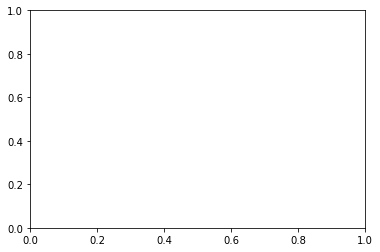

In [205]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-3, 2)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42,n_jobs=-1,verbose=1)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") #log loss requires caliberated classifier
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()




The train log loss is: 0.42225340203065764
The test log loss is: 0.42225858868531635
Total number of data points : 330000


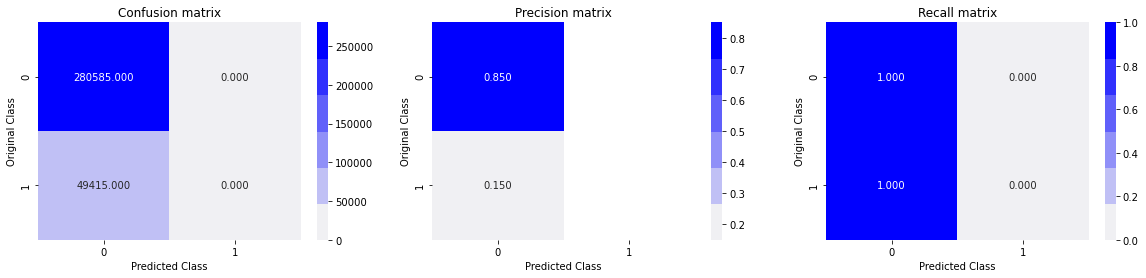

In [212]:
best_alpha = np.argmin(log_error_array)
print(best_alpha)
clf = SGDClassifier(class_weight='balanced', alpha=11, penalty='l2', loss='log', random_state=42,n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print( "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

This model has 100% False negatives.

> ### Decision Tree classifier

In [113]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1,verbose=1)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        #sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        sig_clf_probs = sig_clf.predict_proba(X_test)
        cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_test, sig_clf_probs)) 



for n_estimators = 100 and max depth =  5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Paral

Log Loss : 0.1623083115817278
for n_estimators = 100 and max depth =  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Paral

Log Loss : 0.15991763235600145
for n_estimators = 200 and max depth =  5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   31.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   28.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 184 t

Log Loss : 0.16269335372003166
for n_estimators = 200 and max depth =  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   51.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 184 t

Log Loss : 0.15994800213623764
for n_estimators = 500 and max depth =  5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.4s 

Log Loss : 0.1622712308236708
for n_estimators = 500 and max depth =  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.7s 

Log Loss : 0.15992024259322937
for n_estimators = 1000 and max depth =  5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   

Log Loss : 0.16224799378479146
for n_estimators = 1000 and max depth =  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   

Log Loss : 0.1599290329820752
for n_estimators = 2000 and max depth =  5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  5.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=

[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:   16.1s finished


Log Loss : 0.16195732318894795
for n_estimators = 2000 and max depth =  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 10.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.1min
[Parallel(n_jobs=

[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:   17.8s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:   20.2s finished


Log Loss : 0.15991316453717225


There is no major difference in the log loss when n_estimators = 100 and max depth =  10 compared to  for n_estimators = 2000 and max depth =  10



Hence training a model with n_estimators=100 and max depth = 10

In [213]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10, random_state=42, n_jobs=-1,verbose=1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
#sig_clf_probs = sig_clf.predict_proba(X_test)
#cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
#print("Log Loss :",log_loss(y_test, sig_clf_probs)) 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Paral

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=10,
                                                             n_jobs=-1,
                                                             random_state=42,
                                                             verbose=1))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_job

The train log loss is: 0.15746357932866165


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_job

The test log loss is: 0.15991763235600145
Total number of data points : 330000


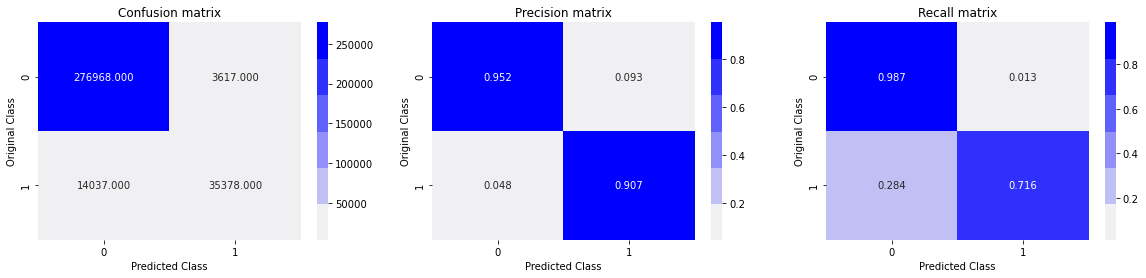

In [123]:
predict_y = sig_clf.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

This model has the least log loss.
The confusion matrix shows that the ration of False negatives to True positives is 1:2
This is the model which has the least False negatives. (i.e., a true prospect identified otherwise). 


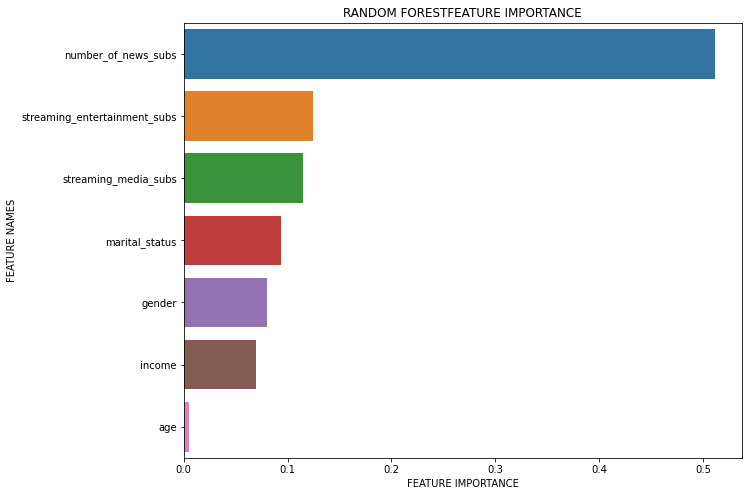

In [126]:
plot_feature_importance(clf.feature_importances_,X_train.columns,'RANDOM FOREST')

This means that number of news subscription a user has is a strong indicator of whether a user will listen to podcast or not. 
Subscription to steaming services is also a moderate indictor of the same. 
But number of news subscription is the clear winner.

### Pickling the model

In [218]:
# Save the Modle to file in the current working directory
import pickle
Pkl_Filename = "FinalModel.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

### Saving predictions to the dataframe

In [188]:
df_result = X_test.copy()
df_result['target']= y_test
#df_result.reset_index(inplace=True)
df_result['Predictions'] = clf.predict(X_test)
df_result['Probabilities (Class 1)']= predict_y[:, 1]


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


In [199]:
df_result=df_result[['target','Predictions','Probabilities (Class 1)']]

In [200]:
df_result

,target,Predictions,Probabilities (Class 1)
379797,0,0,0.034896
870775,0,0,0.142372
635924,0,0,0.038911
844882,0,0,0.025261
278040,0,0,0.035043
...,...,...,...
88706,0,0,0.022682
957531,0,0,0.023398
145085,0,0,0.024022
569922,0,0,0.051570


In [191]:
IndiceList=df_result.index.to_list()

In [197]:
df_id=pd.DataFrame(df['anon_person_id'].loc[df.index[IndiceList]])


In [201]:
df_final=pd.merge(df_id, df_result, left_index=True, right_index=True)

In [202]:
df_final

,anon_person_id,target,Predictions,Probabilities (Class 1)
379797,379798,0,0,0.034896
870775,870776,0,0,0.142372
635924,635925,0,0,0.038911
844882,844883,0,0,0.025261
278040,278041,0,0,0.035043
...,...,...,...,...
88706,88707,0,0,0.022682
957531,957532,0,0,0.023398
145085,145086,0,0,0.024022
569922,569923,0,0,0.051570


In [203]:
df_final[df_final['target']==1]

,anon_person_id,target,Predictions,Probabilities (Class 1)
923506,923507,1,1,0.986911
187762,187763,1,0,0.023963
460523,460524,1,0,0.038643
704474,704475,1,1,0.986967
82546,82547,1,1,0.986973
...,...,...,...,...
336293,336294,1,0,0.461585
109659,109660,1,1,0.987097
852116,852117,1,1,0.986911
524715,524716,1,0,0.115208


#### Importing to csv 

In [204]:
df_final.to_csv('Path/Scores.csv')

# -------------------------------------------------THE END------------------------------------------------